# Data Cleaning for OpenFoodFacts

## Dataset Description

Open Food Facts dataset is a comprehensive collection containing detailed information on food products from around the world. It encompasses a vast array of data, including product names, ingredients, nutritional values, labels, packaging details, and more. 

The Open Food Facts dataset currently holds over 3 million entries, covering a wide range of food products from various countries and categories.

With a crowdsourced approach, this dataset offers extensive information on food items, aiding in understanding dietary patterns, allergens, additives, and nutritional content. The dataset serves as a valuable resource for researchers, nutritionists, and consumers aiming to make informed choices about food consumption, fostering transparency in the food industry.

In [1]:
# Load the required packages

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import csv

#import re
import regex as re
import math

import os
from pathlib import Path

In [2]:
# Parameters

path = str(Path(os.path.abspath(os.getcwd())).parent.absolute())
openfoodfactsUrl = path + '/data/en.openfoodfacts.org.products.csv'
foodtableUrl = path + '/data/data_2.tsv'

ingredients_tx = path + '/data/ingredients.txt'
additives_tx = path + '/data/additives.txt'
vitamins_tx = path + '/data/vitamins.txt'
packaging_materials_tx = path + '/data/packaging_materials.txt'
packaging_shapes_tx = path + '/data/packaging_shapes.txt'
labels_tx = path + '/data/labels.txt'

savePath =  path + '/data/foodDB/'

## Helper Functions

Method to visualizes the distribution of missing values across columns in a Pandas DataFrame.

In [3]:
# Plotting the dataset

def plotMissingValues(dataframe, width, high, character=False):
    plt.figure(figsize=(width, high)) 
    if character==False:
        ax = dataframe.isnull().sum().plot.barh(color='skyblue') 
    else:
        occurrences = (dataframe == character).sum().sort_values(ascending=True)
        ax = occurrences.plot.barh(color='skyblue') 


    # Customizing the plot

    plt.title('Missing Values per Column', fontsize=16)
    plt.xlabel('Number of Missing Values', fontsize=12)
    plt.ylabel('Columns', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7) 
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)


    # Display the values on the bars
    
    if character==False:
        for i, v in enumerate(dataframe.isnull().sum()):
            ax.text(v + 500, i, str(v), color='gray', va='center', fontsize=8)
    else:
        for i, v in enumerate(occurrences):
            ax.text(v + 500, i, str(v), color='gray', va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

Method to split the entries in a DataFrame's target column based on a specified separator, creating new rows for each element resulting from the split.

In [4]:
# Split dataset

def splitDataFrameList(df, target_column, separator):
    def splitListToRows(row, row_accumulator, target_column, separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

## Import Data

Load data from a .tsv file keeping only the desired columns.

In [5]:
# Create a filter with the desired columns

df_filter = ["code",
             "product_name",
             "packaging_tags",
             "brands",
             "brands_tags",
             "labels_en",
             "countries_en",
             "ingredients_tags",
             "serving_size", 
             "additives_n", 
             "additives_tags", 
             "nutriscore_score",
             "nutriscore_grade", 
             "nova_group", 
             "food_groups",
             "food_groups_tags", 
             "brand_owner",
             "ecoscore_grade", 
             "energy-kcal_100g", 
             "energy_100g", 
             "fat_100g", 
             "saturated-fat_100g",
             "trans-fat_100g",
             "cholesterol_100g",
             "carbohydrates_100g", 
             "sugars_100g",
             "fiber_100g", 
             "proteins_100g", 
             "salt_100g", 
             "sodium_100g", 
             "vitamin-a_100g",
             "vitamin-c_100g", 
             "calcium_100g", 
             "iron_100g"] 

In [6]:
filter_df = pd.read_csv(openfoodfactsUrl, sep="\t", usecols=df_filter)

C:\Users\vitto\AppData\Local\Temp\ipykernel_18904\2163774153.py:1: DtypeWarning: Columns (0,50,54,65) have mixed types. Specify dtype option on import or set low_memory=False.
  filter_df = pd.read_csv(openfoodfactsUrl, sep="\t", usecols=df_filter)


## Quick overview of data

Perform a preliminary analysis of the dataset, including inspecting the column names, data shape, and visualizing missing values distribution.

In [7]:
# View columns name

print(filter_df.columns.values)

filter_df.shape

['code' 'product_name' 'packaging_tags' 'brands' 'brands_tags' 'labels_en'
 'countries_en' 'ingredients_tags' 'serving_size' 'additives_n'
 'additives_tags' 'nutriscore_score' 'nutriscore_grade' 'nova_group'
 'food_groups' 'food_groups_tags' 'brand_owner' 'ecoscore_grade'
 'energy-kcal_100g' 'energy_100g' 'fat_100g' 'saturated-fat_100g'
 'trans-fat_100g' 'cholesterol_100g' 'carbohydrates_100g' 'sugars_100g'
 'fiber_100g' 'proteins_100g' 'salt_100g' 'sodium_100g' 'vitamin-a_100g'
 'vitamin-c_100g' 'calcium_100g' 'iron_100g']


(3021705, 34)

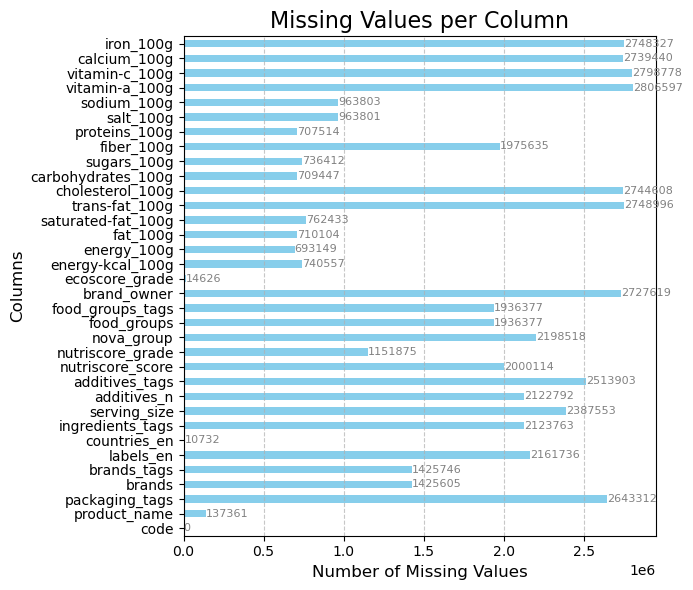

In [8]:
# Plotting the dataset
    
plotMissingValues(filter_df, 7, 6)

In [9]:
# Print original dataset

countries = filter_df["countries_en"].value_counts()

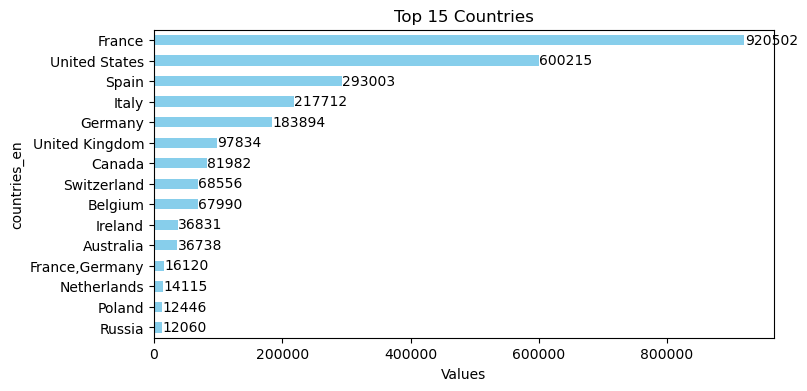

In [10]:
# Plotting the horizontal bar chart

ax = countries[:15][::-1].plot.barh(figsize=(8, 4), color='skyblue')
plt.xlabel('Values')
plt.title('Top 15 Countries')


# Displaying the value of each bar on the plot

for i, v in enumerate(countries[:15][::-1]):
    ax.text(v + 500, i, str(v), color='black', va='center', fontsize=10)

plt.show()

## Data Cleaning

Removing entries from the dataset after defining which columns can contain empty values or not.

In [11]:
# Replace null values in additives_tags with empty string if additives_n is 0
# entries with null values will be removed from the dataset

def replace_null(row):
    if row['additives_n'] == 0 and pd.isnull(row['additives_tags']):
        return ""
    else:
        return row['additives_tags']
    
def replace_null_bycoll(row, col):
    if pd.isnull(row[col]):
        return ""
    else:
        return row[col]
    

filter_df['additives_tags'] = filter_df.apply(replace_null, axis=1)

filter_df["packaging_tags"] = filter_df.apply(replace_null_bycoll, args=('packaging_tags',), axis=1)
filter_df["brands"] = filter_df.apply(replace_null_bycoll, args=('brands',), axis=1)
filter_df["brands_tags"] = filter_df.apply(replace_null_bycoll, args=('brands_tags',), axis=1)
filter_df["labels_en"] = filter_df.apply(replace_null_bycoll, args=('labels_en',), axis=1)
filter_df["serving_size"] = filter_df.apply(replace_null_bycoll, args=('serving_size',), axis=1)
filter_df["nutriscore_score"] = filter_df.apply(replace_null_bycoll, args=('nutriscore_score',), axis=1)
filter_df["nutriscore_grade"] = filter_df.apply(replace_null_bycoll, args=('nutriscore_grade',), axis=1)
filter_df["nova_group"] = filter_df.apply(replace_null_bycoll, args=('nova_group',), axis=1)
filter_df["food_groups"] = filter_df.apply(replace_null_bycoll, args=('food_groups',), axis=1)
filter_df["food_groups_tags"] = filter_df.apply(replace_null_bycoll, args=('food_groups_tags',), axis=1)
filter_df["brand_owner"] = filter_df.apply(replace_null_bycoll, args=('brand_owner',), axis=1)
filter_df["ecoscore_grade"] = filter_df.apply(replace_null_bycoll, args=('ecoscore_grade',), axis=1)
filter_df["saturated-fat_100g"] = filter_df.apply(replace_null_bycoll, args=('saturated-fat_100g',), axis=1)
filter_df["trans-fat_100g"] = filter_df.apply(replace_null_bycoll, args=('trans-fat_100g',), axis=1)
filter_df["cholesterol_100g"] = filter_df.apply(replace_null_bycoll, args=('cholesterol_100g',), axis=1)
filter_df["sugars_100g"] = filter_df.apply(replace_null_bycoll, args=('sugars_100g',), axis=1)
filter_df["fiber_100g"] = filter_df.apply(replace_null_bycoll, args=('fiber_100g',), axis=1)
filter_df["salt_100g"] = filter_df.apply(replace_null_bycoll, args=('salt_100g',), axis=1)
filter_df["sodium_100g"] = filter_df.apply(replace_null_bycoll, args=('sodium_100g',), axis=1)
filter_df["vitamin-a_100g"] = filter_df.apply(replace_null_bycoll, args=('vitamin-a_100g',), axis=1)
filter_df["vitamin-c_100g"] = filter_df.apply(replace_null_bycoll, args=('vitamin-c_100g',), axis=1)
filter_df["calcium_100g"] = filter_df.apply(replace_null_bycoll, args=('calcium_100g',), axis=1)
filter_df["iron_100g"] = filter_df.apply(replace_null_bycoll, args=('iron_100g',), axis=1)

In [12]:
# Apply the filter to the Dataframe

food_table = filter_df[df_filter].copy()

food_table["isempty"] = np.where(food_table.isnull().sum(axis=1) >= 1, 1, 0)
percentage = food_table.isempty.value_counts()[1] / food_table.shape[0] * 100
print("Percentage of dropped rows: " + str(percentage))

food_table = food_table[food_table.isempty==0].copy()
food_table.isnull().sum()

food_table.drop("isempty", inplace=True,axis=1)
food_table.dropna(axis = 0, how = "any", inplace=True)

Percentage of dropped rows: 75.53000706554744


In [13]:
food_table.shape

(739411, 34)

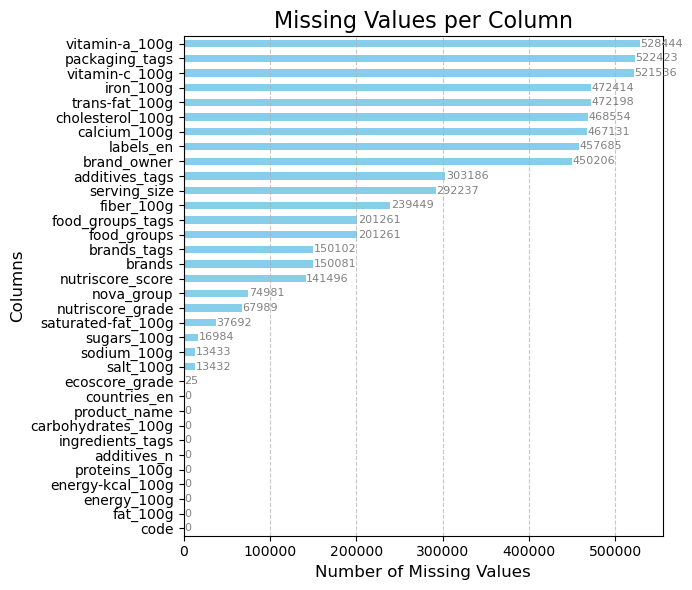

In [14]:
# Plotting the dataset
    
plotMissingValues(food_table, 7, 6, character="")

In [15]:
pd.set_option('display.max_columns', None)
food_table.head()

code            product_name packaging_tags  \
32  0000000001199  Solène céréales poulet                  
40  0000000001663  Crème dessert chocolat                  
49  0000000002264       Baguette Poitevin                  
62  0000000003827          Suedois saumon                  
68  0000000004510   Salade shaker taboulé                  

                     brands              brands_tags labels_en countries_en  \
32                    CROUS                    crous                 France   
40  Ferme De La Frémondière  ferme-de-la-fremondiere                 France   
49              Crous resto              crous-resto                 France   
62                    Crous                    crous                 France   
68                    Crous                    crous                 France   

                                     ingredients_tags serving_size  \
32  en:antioxidant,en:colour,en:tomato,en:vegetabl...                
40  en:whole-milk,en:dairy,en:milk,en:sugar,en:add...                
49  fr:baguette-poite-vin-pain-baguette,en:water,e...                
62  fr:paln-suedois,en:water,en:rye-flour,en:flour...                
68  fr:taboule,en:vegetable,en:colza-oil,en:oil-an...                

   additives_n                            additives_tags nutriscore_score  \
32         5.0  en:e150,en:e160a,en:e202,en:e316,en:e466                    
40         1.0                                   en:e406                    
49         0.0                                                              
62         2.0                           en:e300,en:e503                    
68         1.0                                   en:e202                    

   nutriscore_grade nova_group food_groups food_groups_tags brand_owner  \
32          unknown        4.0                                            
40          unknown        4.0                                            
49          unknown        4.0                                            
62          unknown        4.0                                            
68          unknown        4.0                                            

   ecoscore_grade  energy-kcal_100g  energy_100g  fat_100g saturated-fat_100g  \
32        unknown             219.0        916.0       5.9                0.5   
40        unknown               0.0          0.0       0.0                0.0   
49        unknown             207.0        866.0       6.7                3.8   
62        unknown             172.0        720.0       4.4                1.2   
68        unknown             114.0        477.0       8.1                0.9   

   trans-fat_100g cholesterol_100g  carbohydrates_100g sugars_100g fiber_100g  \
32                                                30.3         1.7        2.8   
40                                                 0.0         0.0              
49                                                27.5         0.6        1.7   
62                                                23.3         4.6        2.7   
68                                                 5.7         1.4        1.7   

    proteins_100g salt_100g sodium_100g vitamin-a_100g vitamin-c_100g  \
32            9.7     0.464      0.1856                                 
40            0.0       0.0         0.0                                 
49            8.9       0.4        0.16                                 
62            8.4      3.58       1.432                                 
68            3.9      0.31       0.124                                 

   calcium_100g iron_100g  
32                         
40                         
49                         
62                         
68

## Save or Load the Dataset

In [16]:
# Save the new Dataset

food_table.to_csv(path + '/data/data_2.tsv', sep='\t', index=False)

In [17]:
# Import the Dataset

food_table = pd.read_csv(foodtableUrl, sep="\t", na_values='unknown')

C:\Users\vitto\AppData\Local\Temp\ipykernel_18904\210409877.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  food_table = pd.read_csv(foodtableUrl, sep="\t", na_values='unknown')


In [18]:
pd.set_option('display.max_columns', None)
food_table.head()

code            product_name packaging_tags                   brands  \
0  1199  Solène céréales poulet            NaN                    CROUS   
1  1663  Crème dessert chocolat            NaN  Ferme De La Frémondière   
2  2264       Baguette Poitevin            NaN              Crous resto   
3  3827          Suedois saumon            NaN                    Crous   
4  4510   Salade shaker taboulé            NaN                    Crous   

               brands_tags labels_en countries_en  \
0                    crous       NaN       France   
1  ferme-de-la-fremondiere       NaN       France   
2              crous-resto       NaN       France   
3                    crous       NaN       France   
4                    crous       NaN       France   

                                    ingredients_tags serving_size  \
0  en:antioxidant,en:colour,en:tomato,en:vegetabl...          NaN   
1  en:whole-milk,en:dairy,en:milk,en:sugar,en:add...          NaN   
2  fr:baguette-poite-vin-pain-baguette,en:water,e...          NaN   
3  fr:paln-suedois,en:water,en:rye-flour,en:flour...          NaN   
4  fr:taboule,en:vegetable,en:colza-oil,en:oil-an...          NaN   

   additives_n                            additives_tags  nutriscore_score  \
0          5.0  en:e150,en:e160a,en:e202,en:e316,en:e466               NaN   
1          1.0                                   en:e406               NaN   
2          0.0                                       NaN               NaN   
3          2.0                           en:e300,en:e503               NaN   
4          1.0                                   en:e202               NaN   

  nutriscore_grade  nova_group food_groups food_groups_tags brand_owner  \
0              NaN         4.0         NaN              NaN         NaN   
1              NaN         4.0         NaN              NaN         NaN   
2              NaN         4.0         NaN              NaN         NaN   
3              NaN         4.0         NaN              NaN         NaN   
4              NaN         4.0         NaN              NaN         NaN   

  ecoscore_grade  energy-kcal_100g  energy_100g  fat_100g  saturated-fat_100g  \
0            NaN             219.0        916.0       5.9                 0.5   
1            NaN               0.0          0.0       0.0                 0.0   
2            NaN             207.0        866.0       6.7                 3.8   
3            NaN             172.0        720.0       4.4                 1.2   
4            NaN             114.0        477.0       8.1                 0.9   

   trans-fat_100g  cholesterol_100g  carbohydrates_100g  sugars_100g  \
0             NaN               NaN                30.3          1.7   
1             NaN               NaN                 0.0          0.0   
2             NaN               NaN                27.5          0.6   
3             NaN               NaN                23.3          4.6   
4             NaN               NaN                 5.7          1.4   

   fiber_100g  proteins_100g  salt_100g  sodium_100g  vitamin-a_100g  \
0         2.8            9.7      0.464       0.1856             NaN   
1         NaN            0.0      0.000       0.0000             NaN   
2         1.7            8.9      0.400       0.1600             NaN   
3         2.7            8.4      3.580       1.4320             NaN   
4         1.7            3.9      0.310       0.1240             NaN   

   vitamin-c_100g  calcium_100g  iron_100g  
0             NaN           NaN        NaN  
1             NaN           NaN        NaN  
2             NaN           NaN        NaN  
3             NaN           NaN        NaN  
4             NaN           NaN        NaN

## Ingredients Counter

Creation of a file containing the list of ingredients in the dataset with the respective number of times in which it appears sorted in ascending order.

In [19]:
ingredients_map = {}

def cl_ingredients(text, ingredients_map, debug = False):
    
    # Pattern to split the text
    pattern = r"[,]"
    split_text = re.split(pattern, text)

    for ingredient in split_text:
        if ingredient in ingredients_map:
            ingredients_map[ingredient] += 1
        else:
            ingredients_map[ingredient] = 1
    
    if debug:
        print(text)

food_table['ingredients_tags'].apply(cl_ingredients, args=(ingredients_map,))
print(len(ingredients_map))

845268


In [20]:
# File path to save the CSV data
file_path = path + '/data/ingrediets_2.tsv'

sorted_ingredients = dict(sorted(ingredients_map.items(), key=lambda x: x[1], reverse=True))

# Writing the dictionary to a CSV file with tab-separated values
with open(file_path, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file, delimiter='\t')
    writer.writerow(['Ingredient', 'Count'])  # Writing header
    for ingredient, count in sorted_ingredients.items():
        writer.writerow([ingredient, count])

print(f"Dictionary has been written to {file_path}")

Dictionary has been written to C:\Users\vitto\Desktop\Uni\graphle/data/ingrediets_2.tsv


## Data Visualization

Visualizes the top 15 most frequently appearing countries in the Open Food Facts dataset using horizontal bar charts.

**Countries:**

In [21]:
# Print new dataset

food_countries = splitDataFrameList(food_table, "countries_en", ",")
countries_count = food_countries["countries_en"].value_counts()

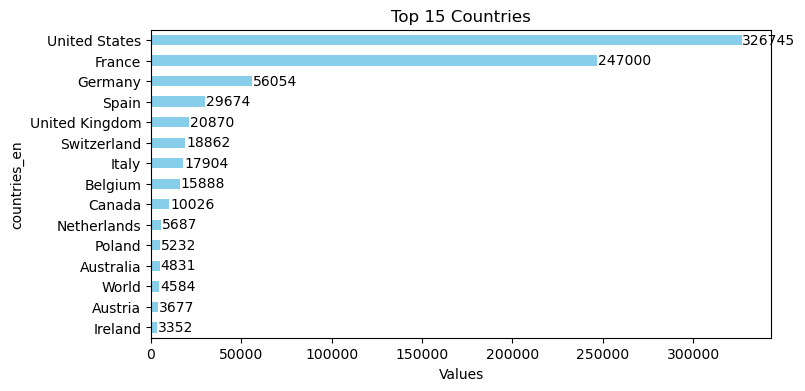

In [22]:
# Plotting the horizontal bar chart

ax = countries_count[:15][::-1].plot.barh(figsize=(8, 4), color='skyblue')
plt.xlabel('Values')
plt.title('Top 15 Countries')


# Displaying the value of each bar on the plot

for i, v in enumerate(countries_count[:15][::-1]):
    ax.text(v + 500, i, str(v), color='black', va='center', fontsize=10)

plt.show()

## Read Taxonomy

The Open Food Fact project contains some taxonomies to gather knowledge about ingredients, labels and similar concepts through translations, synonyms and relations. The taxonomies are contained in .txt files in the repository and have a pretty simple and human-readable encoding, though as far as we know it does not follow any established standard.

The following code connects each element with its synonyms, words in other languages, and related concepts. This enhanced context enables a better understanding of the data's meaning.

In [4]:
#This function takes an input string and checks if any of the words it contains are synonyms of other words,
#or potentially useless words and outputs a list of semantically equivalent strings if either of these
#cases occurs

def check_synonyms(in_item, synonym_set, stopword_set):
    out = []
    split_in_item = re.split(':', in_item)
    in_tag = split_in_item[0]
    if in_tag in synonym_set:
        for syn_list in synonym_set[in_tag]:
            for syn in syn_list:
                if re.search(f'(^{syn}-)|(-{syn}-)|-{syn}$',split_in_item[1]):
                    for syn2 in syn_list:
                        if syn != syn2:
                            out.append(re.sub(syn, syn2, split_in_item[1]))
            if len(out) != 0:
                break
    if in_tag in stopword_set:
        for stopword in stopword_set[in_tag]:
            if re.search(f'(^{stopword}-)|(-{stopword}-)|-{stopword}$',split_in_item[1]):
                out.append(re.sub('--+', '-', re.sub(stopword, '', split_in_item[1])))
    #if len(out) != 0:
        #print(in_item)
        #print(out)
    return out

Synonyms and Stopwords are extracted in slightly different data structures:
Both have codes of languages (e.g. 'en', 'it', 'fr') as keys.

A pair in the Synonym dictionary has a list of lists as value. Each inner list contains words that could be exchanged for one another without altering the meaning of their context.

A pair in the Stopword dictionary has a list as value. The list contains the words, for that language, that could be removed from its context without changing the context's meaning.

In [5]:
#Extract synonym and stopword base from the taxonomy files

def extract_synonyms(file, synonym_set):
    
    cur_line = file.readline()
    while cur_line != '':
        if re.match('^synonyms:[a-z]{2}:', cur_line):
            new_item = re.match('^synonyms:[a-z]{2}:[^#]*', cur_line).group()
            split_item = re.split(':', new_item)
            new_tag = split_item[1]
            new_syns = []
            for word in re.split(',', split_item[2]):
                new_syns.append(word.strip().lower().replace(' ', '-'))
            if '' in new_syns:
                new_syns.remove('')
            if new_tag in synonym_set:
                synonym_set[new_tag].append(new_syns)
            else:
                synonym_set[new_tag] = [new_syns]
        cur_line = file.readline()
    return synonym_set


def extract_stopwords(file, stopword_set):
    
    cur_line = file.readline()
    while cur_line != '':
        if re.match('^stopwords:[a-z]{2}:', cur_line):
            new_item = re.match('^stopwords:[a-z]{2}:[^#]*', cur_line).group()
            split_item = re.split(':', new_item)
            new_tag = split_item[1]
            new_stops = []
            for word in re.split(',', split_item[2]):
                new_stops.append(word.strip().lower().replace(' ', '-'))
            if new_tag not in stopword_set:
                stopword_set[new_tag] = []
            for stop in new_stops:
                stopword_set[new_tag].append(stop)
        cur_line = file.readline()
    for key in stopword_set:
        stopword_set[key] = list(set(stopword_set[key]))
    return stopword_set

synonym_set = {}
stopword_set = {}

with open(ingredients_tx, 'r', encoding='utf-8') as file:
    extract_synonyms(file, synonym_set)
    file.seek(0)
    extract_stopwords(file, stopword_set)
    file.close()

with open(additives_tx, 'r', encoding='utf-8') as file:
    extract_synonyms(file, synonym_set)
    file.seek(0)
    extract_stopwords(file, stopword_set)
    file.close()
    
with open(vitamins_tx, 'r', encoding='utf-8') as file:
    extract_synonyms(file, synonym_set)
    file.seek(0)
    extract_stopwords(file, stopword_set)
    file.close()
    
with open(packaging_materials_tx, 'r', encoding='utf-8') as file:
    extract_synonyms(file, synonym_set)
    file.seek(0)
    extract_stopwords(file, stopword_set)
    file.close()
    
with open(packaging_shapes_tx, 'r', encoding='utf-8') as file:
    extract_synonyms(file, synonym_set)
    file.seek(0)
    extract_stopwords(file, stopword_set)
    file.close()
    
with open(labels_tx, 'r', encoding='utf-8') as file:
    extract_synonyms(file, synonym_set)
    file.seek(0)
    extract_stopwords(file, stopword_set)
    file.close()
    
print(synonym_set)
print(stopword_set)
    

{'en': [['fiber', 'fibre'], ['hydrolysed', 'hydrolyzed'], ['pasteurised', 'pasteurized'], ['wholemeal', 'whole', 'whole-grain', 'wholegrain', 'complete'], ['semi-wholemeal', 'semi-whole', 'semi-whole-grain', 'semi-wholegrain', 'semi-complete', 'semiwhole', 'semiwholemeal'], ['semi-sweet', 'semisweet'], ['fd&c', 'fd-and-c', 'fdc', 'ffdca', 'fdca'], ['n°', 'no', 'number', 'nb'], ['no1', 'n1', '1'], ['no2', 'n2', '2'], ['no3', 'n3', '3'], ['no4', 'n4', '4'], ['no5', 'n5', '5'], ['no6', 'n6', '6'], ['no7', 'n7', '7'], ['no8', 'n8', '8'], ['no9', 'n9', '9'], ['no10', 'n10', '10'], ['no11', 'n11', '11'], ['no12', 'n12', '12'], ['colour', 'color'], ['biobased', 'bio-based', 'biosourced', 'bio-sourced'], ['coloring', 'colouring', 'color', 'colour'], ['flavor', 'flavour', 'flavoring', 'flavouring'], ['gmos', 'genetically-modified-organisms', 'gmo'], ['rich-in', 'high-in'], ['msg', 'glutamate'], ['preservatives', 'conservatives'], ['seafood', 'sea-food'], ['without', '0%', 'free'], ['carbon', 'c

**Ingredients:**
A dictionary is used to store ingredients. 

The key is the first name that appears in the taxonomy for that ingredient. With the way the taxonomy is structured, if there is an english name (this is the case in the great majority of cases) it will be on top, and thus become the key. 

The value is a list of two lists:

1. The ingredients that are conceptually broader than the current ingredient (e.g. 'fruit' if current ingredient is 'apple')

2. All the names that can be used to refer to the ingredient, both for different languages and different ways to write the same ingredient in the same language

In [6]:
ing_dict = {}

with open(ingredients_tx, 'r', encoding='utf-8') as file:
    
    cur_line = file.readline()
    while cur_line != '':
        cur_ing = ''
        super_items = []
        if re.match('^<?[a-z]{2}:', cur_line):
            while re.match('^<[a-z]{2}:', cur_line):
                new_item = re.match('^<[a-z]{2}:[^#]*', cur_line).group()
                new_item = re.split(':', new_item)[1]
                super_items.append(re.sub('"', "'", re.sub('--+', '-', new_item.strip().lower().replace(' ', '-'))))
                cur_line = file.readline()
            while cur_line != '\n' and cur_line != '':
                if re.match('^[a-z]{2}:', cur_line):
                    new_item = re.match('^[a-z]{2}:[^#]*', cur_line).group()
                    new_item = re.split(':', new_item)
                    new_tag = new_item[0]
                    new_items = re.split(',', new_item[1])
                    for item in new_items:
                        item = re.sub('"', "'", re.sub('--+', '-', item.strip().lower().replace(' ', '-')))
                    if cur_ing == '':
                        cur_ing = re.sub('"', "'", re.sub('--+', '-', new_items[0].strip().lower().replace(' ', '-')))
                        ing_dict[cur_ing] = [super_items,[]]
                    for item in new_items:
                        f_name = re.sub('"', "'", re.sub('--+', '-', item.strip().lower().replace(' ', '-')))
                        f_item = f"{new_tag}:{f_name}"
                        ing_dict[cur_ing][1].append(f_item)
                        for synoym in check_synonyms(f_item, synonym_set, stopword_set):
                            ing_dict[cur_ing][1].append(f"{new_tag}:{synoym}")
                cur_line = file.readline()
            if(cur_ing != ''):
                ing_dict[cur_ing][1] = list(set(ing_dict[cur_ing][1]))
                print(cur_ing + f":\n{ing_dict[cur_ing]}\n")
        cur_line = file.readline()
    file.close()

imazalil:
[[], ['fa:انیل\u200cکونازول', 'fr:imazalil', 'de:imazalil', 'hu:imazalil', 'pt:imazalil', 'fi:imatsaliili', 'it:imazalil', 'en:imazalil', 'da:imazalil', 'nl:imazalil', 'es:imazalil', 'pl:imazalil', 'sl:imazalil', 'ja:イマザリル', 'sk:imazalil']]

frying:
[[], ['en:frying', 'fr:friture']]

caramel-syrup:
[[], ['ru:карамельный-сироп', 'hr:karamelov-sirup', 'hr:karamel-sirup', 'pt:xarope-de-caramelo', 'es:caramelo-líquido', 'bg:карамелен-сироп', 'pl:syrop-karmelowy', 'pt:xarope-caramelo', 'ca:xarop-de-carmel', 'ca:caramel-liquid', 'lt:karamelizuoto-sirupo', 'it:sciroppo-di-caramello', 'es:sirope-caramelo', 'es:sirope-de-caramelo', 'nl:karamel-siroop', 'hu:karamella-szirup', 'de:karamellsirup', 'ja:キャラメルシロップ', 'hu:karamellszirup', 'da:karamelsukkersirup', 'de:caramelsirup', 'fr:sirop-de-caramel', 'fi:karamellisiirappi', 'lt:karamelizuotas-sirupas', 'es:jarabe-caramelo', 'es:jarabe-de-caramelo', 'ca:xarop-carmel', 'hu:karamell-szirup', 'hr:karamelizirani-sirup', 'ja:カラメルシラップ', 'fr:siro

sunflower-lecithin:
[['e322(i)'], ['et:päevalille-letsitiin', 'pt:lecitina-girassol', 'fi:auringonkukkalesitiiniä', 'es:lecitinas-girasol', 'it:lecitina-di-girasole', 'nn:solsikkelecithin', 'bg:слънчогледов-лецитин', 'pl:lecytyna-słonecznikowa', 'ca:lecitina-gira-sol', 'nl:zonnebloem-lecithine', 'hr:suncokretov-lecitin', 'de:sonnenblumenlecithin', 'nl:zonnebloemlecithine', 'en:sunflower-lecithin', 'hu:napraforgó-lecitin', 'pt:lecitina-de-girassol', 'cs:slunečnicový-lecitin', 'lt:lecitinai-saulėgrąžų', 'nb:solsikkelecitin', 'el:λεκιθίνες-ηλιστροπιου', 'lv:lecitinai-iš-saulègrąžų', 'pl:lecytyny-ze-słonecznika', 'lv:saulespuķu-lecitīns', 'hr:lecitin-suncokreta', 'da:solsikkelecithin', 'lv:saulespuku-lecitīns', 'et:päevalilleletsitiin', 'ro:lecitina-de-florarea-soarelui', 'es:lecitinas-de-girasol', 'de:sonnenblumenlecithine', 'pl:lecytyna-słonecznika', 'it:lecitine-di-girasole', 'ro:lecitine-din-floarea-soarelui', 'sv:solroslecitin', 'es:lecitina-de-girasol', 'lt:saulėgrąžų-lecitinai', 'nb

mono-and-diglycerides-of-fatty-acids-of-vegetable-origin:
[['e471'], ["ca:monoglicèrids-d'àcids-grassos-d'origen-vegetal", 'pt:mono-e-diglicéridos-de-ácidos-gordo-de-origem-vegetal', 'pt:mono-e-diglicéridos-ácidos-gordos-origem-vegetal', 'nl:mono-en-diglyceriden-van-plantaardige-vetzuren', "fr:mono-et-diglycérides-d'acides-mg-d'origine-végétale", 'de:mono-diglyzeride-von-speisefettsäuren', 'de:mono-und-diglyzeride-von-speisefettsäuren', 'es:monoglicéridos-y-diglicéridos-ácidos-grasos-origen-vegetal', "fr:mono-et-diglycérides-d'acides-gras-d'origine-végétale", 'pt:mono-diglicéridos-d-ácidos-gordos-d-origm-vgtal', 'es:diglicéridos-de-ácidos-grasos-de-vegetal', 'es:monoglicéridos-y-diglicéridos-de-ácidos-grasos-de-origen-vegetal', 'es:monoglicéridos-de-acidos-grasos-de-origen-vegetal', 'nl:mono-en-diglyceriden-plantaardige-vetzuren', 'pt:mono-e-diglicéridos-de-ácidos-gordos-de-origem-vegetal', "ca:monoglicèrids-i-diglicèrids-d'àcids-grassos-d'origen-vegetal", 'pt:mono-e-diglicéridos-de-ác

corn-dextrin:
[['e1400'], ['hu:kukoricadextrin', 'hu:dextrin-kukoricából', 'fi:maissidekstriini', 'it:destrina-di-mais', 'nl:maïsdextrine', 'de:maisdextrin', 'es:dextrina-de-maiz', 'en:corn-dextrin', 'fr:xtrine-maïs', 'fr:dextrine-de-maïs', 'bg:царевичен-декстрин', 'es:xtrina-maiz']]

modified-potato-starch:
[['modified-starch', 'potato-starch'], ['pl:modyfikowana-skrobia-ziemniaczana', 'fr:amidon-transformé-pommes-terre', 'ja:加工澱粉', 'pt:amido-modificado-batata', 'nl:gemodificeerd-aardappelzetmeel', 'fr:amidon-transformé-de-pomme-de-terre', 'fr:fécule-de-pomme-de-terre-modifiée', 'pl:skrobia-modyfikowana-ziemniaczana', 'fr:amidon-de-pomme-de-terre-modifié', 'pl:skrobia-ziemniaczana-modyfikowana', 'hr:modificirani-krumpirov-škrob', 'en:modified-potato-starch', 'fr:amidon-modifié-pomme-terre', 'ca:midó-modificat-patata', 'fr:amidon-transformé-pomme-terre', 'es:almidon-de-patata-modificado', 'fr:fécule-modifiée-pommes-terre', 'hu:módosított-burgonyakeményítő', 'lt:modifikuotas-bulvių-krak

sourdough-starter:
[['lactic-ferments'], ['fr:starters-pour-levain', 'de:sauerteigkulturen', 'de:sauerteigstarterkulturen', 'es:levadura-natural-de-masa-madre', 'es:levadura-de-origen-natural-de-masa-madre', 'es:levadura-natural-masa-madre', 'de:sauerteig-starter', 'en:sourdough-culture', 'es:levadura-de-masa-madre', 'es:levadura-origen-natural-de-masa-madre', 'de:sauerteigstarter', 'en:sourdough-starter', 'es:levadura-masa-madre', 'da:surdejskultur']]

vegan-lactic-ferments:
[['lactic-ferments'], ['da:vegansk-yoghurtkultur', 'es:fermentos-lácticos-veganos', 'de:vegane-joghurtkulturen', 'nb:vegansk-yoghurtkultur', 'fr:cultures-lactiques-véganes', 'en:vegan-lactic-ferments', 'sv:vegansk-yoghurtkultur']]

lactic-and-aging-ferments:
[['lactic-ferments'], ['es:fermentos-lácticos-de-maduración', "fr:ferment-lactique-d'affinage", "it:fermenti-lattici-e-d'affinatura", 'pt:frmntos-lácticos-d-maturação', "fr:ferments-lactiques-d'affinage", 'it:fermenti-lattici-e-invecchianti', 'es:fermentos-lác

selected-ferments:
[['ferment'], ['en:selected-ferments', 'pt:fermentos-selecionados', 'es:fermentos-seleccionados', 'nl:geselecteerde-fermenten', 'de:ausgewählte-kulturen', 'fr:ferments-sélectionnés', 'it:fermenti-selezionati']]

enzyme:
[[], ['nb:enzymer', 'da:enzym', 'br:enzim', 'is:ensím', 'bn:উৎসেচক', 'qu:huptana', 'hy:ֆերմենտ', 'yi:ענזים', 'pl:enzymy', 'bg:ензим', 'ml:രാസാഗ്നി', 'ru:ферменты', 'hu:enzim', 'fr:enzyme', 'nl:enzymen', 'nb:enzym', 'jv:ènzim', 'li:enzym', 'mr:उत्प्रेरक', 'se:entsyma', 'oc:enzim', 'su:énzim', 'fa:آنزیم', 'ku:enzîm', 'fo:kveiki', 'tr:enzim', 'nn:enzym', 'si:එන්සයිම', 'it:enzima', 'hi:प्रकिण्व', 'ga:einsím', 'mk:ензим', 'pa:ਐੱਨਜ਼ਾਈਮ', 'eu:entzima', 'vi:enzym', 'bg:ензими', 'hr:enzim', 'fi:entsyymi', 'th:เอนไซม์', 'so:ensiim', 'ja:酵素', 'ar:ئەنزیم', 'gl:enzima', 'es:enzima', 'cs:enzym', 'ka:ფერმენტები', 'ro:enzimă', 'la:enzymum', 'ps:انزايم', 'tl:ensaym', 'ht:anzim', 'af:ensiem', 'my:အင်န်ဇိုင်း', 'el:ένζυμο', 'sr:ензим', 'sh:enzim', 'ko:효소', 'id:enzim', '


derivado-lacteo-en-polvo:
[['dairy'], ['es:derivado-lacteo-polvo', 'es:derivado-lacteo-en-polvo']]

fermented-milk-products:
[['dairy'], ['en:cultured-milk-products', 'fr:produits-laitiers-de-culture', 'en:cultured-dairy-foods', 'cs:kysaný-mléčný-výrobek', 'ca:productes-làctics-fermentats', 'de:sauermilchprodukte', 'fi:hapanmaitotuote', 'es:producto-fermentado-la-leche', 'hu:tejkultúrák', 'de:sauermilcherzeugnis', 'be:кісламалочныя-прадукты', 'fr:produits-issus-de-lait-de-culture', 'fr:-de-lait-de-culture', 'ru:кисломолочные-продукты', 'ca:llet-fermentada', 'fi:hapanmaitotuotteet', 'fr:produits-laitiers-culture', 'hy:կաթնաթթվային-մթերք', 'fr:produits-laitiers-fermentés', 'es:producto-fermentado-de-la-leche', 'uk:кисломолочний-продукт', 'hu:fermentált-tejtermékek', 'es:producto-fermentado-de-leche', 'de:sauermilcherzeugnisse', 'bg:ферментирали-млечни-продукти', 'fr:produits-de-lait-de-culture', 'fr:produits-issus-lait-culture', 'hu:savanyított-tejtermékek', 'de:sauermilchprodukt', 'en:

pasteurised-milk:
[['milk'], ['ro:lapte-pasteurizat', 'en:pasteurised-milk', 'bg:пастьоризирано-мляко', 'nl:gepasteuriseerde-melk', 'fi:pastöroidusta-maidosta', 'pl:mleko-pasteryzowane', 'pt:leite-pasteurizado', 'es:leche-pasteurizada', 'ca:llet-pasteuritzada', 'en:pasteurized-milk', 'it:latte-pastorizzato', 'hu:pasztörizált-tej', 'de:pasteurisierte-milch', 'sv:pastöriserad-mjölk', 'fi:pastöroitu-maito', 'lt:pasterizuotas-pienas', 'tr:pastörize-süt', 'fr:lait-pasteurisé', 'cs:pasterizované-mléko', 'ru:молоко-пастеризованное', 'hr:pasterizirano-mlijeko', 'hu:pasztőrözött-tej', 'ru:пастеризованное-молоко', 'da:pasteuriseret-mælk', 'et:pastöriseeritud-piim', 'nb:pasteurisert-melk']]

uht-pasteurised-milk:
[['sterilised-milk'], ['bg:uht-пастьоризирано-мляко', 'en:uht-pasteurised-milk', 'ca:llet-esterilitzada-uht', 'it:latte-pastorizzato-uht', 'hu:ultrapasztőrözött-tej', 'fr:lait-stérilisé-u.h.t', 'fi:iskukuumennettu-maito', 'en:uht-pasteurized-milk', 'de:uht-milch', 'es:leche-esterelizada-


lait-demi-écrémé-uht:
[['semi-skimmed-milk'], ['pt:leite-meio-graxos-uht', 'fr:lait-stérilisé-u-h-t-demi-écrémé', 'pt:leite-meio-graxo-uht', 'fr:lait-stérilisé-uht-demi-écrémé', 'pt:leite-uht-meio-graxo', 'de:fettarme-haltbarmilch', 'pt:leite-uht-meio-gordos', 'ca:llet-semidesnatada-esterilitzada-uht', 'pt:leite-meio-gordo-uht', 'es:leche-semidesnatada-esterilizada-uht', 'de:fettarme-h-milch', 'es:leche-parcialmente-desnatada-esterilizada-uht', 'fr:lait-demi-écrémé-uht', 'pt:leite-uht-meio-graxos', 'fr:lait-demi-écrémé-stérilisé-uht', 'pt:leite-uht-meio-gordo', 'fr:lait-demi-écrémé-stérilisé-u.h.t', 'ca:llet-parcialment-desnatada-esterilitzada-uht', 'it:latte-semiscremato-uht', 'pt:leite-meio-gordos-uht', 'es:leche-uht-parcialmente-descremada', 'nl:halfvolle-melk-uht-verhit']]

lait-de-montagne-demi-écrémé-stérilisé-uht:
[['lait-demi-écrémé-uht'], ['fr:lait-montagne-mi-écrémé-stérilisé-uht', 'fr:lait-de-montagne-demi-écrémé-stérilisé-uht']]

pasteurized-semi-skimmed-milk:
[['semi-skim

raw-milk:
[['milk'], ['fi:raakamaito', 'es:leche-cruda', 'ca:llet-crua', 'tr:çiğ-süt', 'en:raw-milk', 'de:rohmilch', 'fr:lait-cru', 'hu:nyers-tej', 'it:latte-crudo', 'fi:tilamaito', 'nl:rauwe-melk', 'tr:pastörize-edilmemiş-süt', 'bg:сурово-мляко', 'ja:生乳']]

lait-cru-entier:
[['raw-milk', 'whole-milk'], ['ca:llet-crua-sencera', 'fr:lait-cru-entier', 'es:leche-cruda-entera']]

cow's-milk:
[['milk'], ['ja:牛乳', 'pl:krowie-mleko', 'pt:leite-vaca', 'ro:lapte-de-vacă', 'it:latte-vaccino', 'ro:lapte-de-vaca', 'zh:牛奶', 'de:kuhmilch', 'nl:koemelk', 'sv:komjölk', 'hu:tehéntej', 'tr:inek-sütü', 'fr:lait-vache', 'en:cow-milk', "en:cows'-milk", 'fi:lehmänmaito', 'ca:llet-vaca', 'ru:коровье-молоко', "en:cow's-milk", 'ca:llet-de-vaca', 'es:leche-vaca', 'fr:lait-de-vache', 'bg:краве-мляко', "uk:коров'яче-молоко", 'nb:kumelk', 'pt:leite-de-vaca', 'es:leche-de-vaca', 'it:latte-di-mucca', 'hr:kravlje-mlijeko']]

milk-with-1.0%-milk-fat:
[['milk'], ['hr:mlijeko-s-1%-mliječne-masti', 'en:milk-with-1.0%-mil

whole-goat-milk:
[['goat-milk'], ['fr:lait-entier-chèvre', 'es:leche-cabra-cruda', 'ca:llet-sencera-de-cabra', 'de:ziegenvollmilch', 'fr:lait-cru-chèvre', 'de:ziegen-vollmilch', 'ca:llet-sencera-cabra', 'ca:llet-cabra-crua', 'es:leche-entera-cabra', 'es:leche-entera-de-cabra', 'de:ziegen-rohmilch', 'en:whole-grain-goat-milk', 'en:wholegrain-goat-milk', 'en:raw-goat-milk', 'en:wholemeal-goat-milk', 'fi:vuohen-täysmaito', 'ca:llet-cabra-sencera', 'es:leche-de-cabra-cruda', 'en:complete-goat-milk', 'fr:lait-cru-de-chèvre', 'ca:llet-de-cabra-sencera', 'es:leche-cabra-entera', 'es:leche-cruda-de-cabra', 'fi:vuohen-raakamaito', 'fr:lait-entier-de-chèvre', 'fi:raaka-vuohenmaito', 'ca:llet-de-cabra-crua', 'ca:llet-crua-de-cabra', 'ca:llet-crua-cabra', 'fr:lait-chèvre-cru', 'en:whole-goat-milk', 'nl:volle-geitemelk', 'de:ziegenrohmilch', 'fr:lait-de-chèvre-cru', 'bg:пълномаслено-козе-мляко', 'es:leche-cruda-cabra', 'es:leche-de-cabra-entera', 'de:unpasteurisierte-ziegenmilch', 'hu:nyers-kecsket

condensed-milk:
[['milk'], ['tr:kondense-süt', 'fa:شیر-تغلیظ\u200cشده', 'eo:kondensita-lakto', 'pl:mleko-skondensowane', 'pl:skondensowane-mleko', 'fi:kondensoitu-maito', 'nl:gecondenseerde-melk', 'he:חלב-מרוכז', 'id:susu-kental', 'pl:zagęszczone-mleko', 'ko:연유', 'ru:сгущённое-молоко', 'sv:kondenserad-mjölk', 'ja:加糖練乳', 'ar:الحليب-المبخر', 'lt:kondensuotas-pienas', 'gl:leite-condensado', 'lb:béchsemëllech', 'tl:gatas-na-kondensada', 'pl:mleko-zagęszczone', 'kn:ಕಂಡೆನ್ಸ್\u200cಡ್-ಮಿಲ್ಕ್', 'zh:煉奶', 'eu:esne-kondentsatu', 'de:dosenmilch', 'bg:кондензирано-мляко', 'hy:խտացրած-կաթ', 'ms:susu-pekat', 'cs:kondenzované-mléko', 'nb:kondensert-melk', 'fr:lait-condensé', 'be:згушчанае-малако', 'pt:leche-condensada', 'uk:згущене-молоко', 'af:kondensmelk', 'tt:куертылган-сөт', 'es:leche-condensada', 'de:büchsenmilch', 'ro:lapte-condensat', 'it:latte-condensato', 'et:kondenspiim', 'de:eingedickte-milch', 'eu:esne-lurrundua', 'de:kondensmilch', 'sl:kondenzirano-mleko', 'ca:llet-condensada', 'hu:sűrítet

lactose-and-milk-proteins:
[['milk-proteins', 'lactose'], ['en:lactose-and-milk-proteins', 'es:ctosa-y-proteínas-de-leche', 'ca:proteïnes-de-la-llet-lactosa', 'es:lactosa-y-proteínas-la-leche', 'pt:lactos-protínas-do-lit', 'fr:lactose-et-protéines-de-lait', 'de:milchzucker-und-milcheiweiß', 'fr:protéine-de-lait-et-lactose', 'it:lattosio-e-proteine-del-latte', 'fr:lactose-et-protéine-lait', 'fr:lactose-protéines-de-lait', 'ca:lactosa-i-proteïnes-la-llet', 'es:proteínas-de-la-leche-lactosa', 'hu:tejcukor-és-tejfehérje', 'ca:proteïnes-la-llet-i-lactosa', 'pt:lactose-e-proteínas-leite', 'da:laktose-og-mælkeprotein', 'fr:lactose-et-protéine-de-lait', 'fr:lactose-protéine-de-lait', 'fr:protéines-lait-et-lactose', 'es:proteínas-de-la-leche-y-lactosa', 'es:lactosa-proteínas-de-la-leche', 'nl:lactose-en-melkeiwitten', 'ca:lactosa-i-proteïnes-de-la-llet', 'de:milchzucker-und-milcheiweiss', 'de:milchzucker-milcheiweiß', 'fr:protéine-lait-et-lactose', 'fr:protéine-de-lait-lactose', 'pl:białka-mlec

reconstituted-skimmed-milk:
[['skimmed-milk'], ['ca:llet-desnatada-reconstituida', 'nl:gerehydrateerde-magere-melk', 'pl:odtworzone-odtłuszczone-mleko', 'hu:visszaállított-sovány-tej', 'de:rekonstituierte-magermilch', 'ca:llet-descremada-reconstituida', 'ca:llet-descremada-rehidratada', 'pt:leite-magro-reconstituído', 'fr:lait-écrémé-réhydraté', 'es:leche-desnatada-reconstituida', 'es:leche-descremada-rehidratada', 'es:leche-desnatada-rehidratada', 'pl:odtworzone-mleko-odtłuszczone', 'hu:feloldott-sovány-tej', 'en:reconstituted-skimmed-milk', 'es:leche-descremada-reconstituida', 'ca:llet-desnatada-rehidratada', 'lt:regeneruotas-nugriebtas-pienas', 'it:latte-scremato-reidratato']]

възстановено-обезмаслено-мляко-на-прах:
[['skimmed-milk-powder'], ['es:leche-desnatada-polvo-rehidratada', 'bg:възстановео-обезмаслено-сухо-мляко', 'ca:llet-desnatada-en-pols-rehidratada', 'es:leche-desnatada-en-polvo-rehidratada', 'bg:възстановено-обезмаслено-мляко-на-прах', 'es:leche-desnatada-polvo-reconst

yogurt-powder:
[['yogurt'], ['pl:jogurt-w-proszku', 'ca:iogurt-en-pols', 'es:yogur-en-polvo', 'fr:yaourt-poudre', 'pl:proszek-jogurtowy', 'fr:yaourt-en-poudre', 'fi:jogurttijauhe', 'hu:joghurtpor', 'en:yogurt-powder', 'es:yogur-polvo', 'sv:yoghurtpulver', 'de:joghurtpulver']]

whole-milk-yogurt-powder:
[['whole-milk-yogurt'], ['en:whole-milk-yogurt-powder', 'es:yogur-leche-entera-en-polvo', 'en:complete-milk-yogurt-powder', 'es:yogur-de-leche-entera-en-polvo', 'en:wholegrain-milk-yogurt-powder', 'ca:iogurt-de-llet-sencera-en-pols', 'en:whole-grain-milk-yogurt-powder', 'en:wholemeal-milk-yogurt-powder', 'de:vollmilchjoghurtpulver', 'fi:täysmaitojogurttijauhe', 'ca:iogurt-llet-sencera-en-pols', 'es:yogur-de-leche-tera-polvo']]

skimmed-milk-yogurt-powder:
[['joghurtpulver'], ['nb:skummetmelkyoghurtpulver', 'hr:jogurt-u-prahu-od-obranog-mlijeka', 'de:magermilchjoghurtpulver', 'fr:poudre-de-yaourt-au-lait-écrémé', 'fr:poudre-de-yaourt-lait-écrémé', 'es:yogur-descremado-polvo', 'sv:skummjöl

sweet-whey-powder:
[['sweet-whey'], ['fi:makea-herajauhe', 'hr:slatka-sirutka-u-prahu', 'de:süßmolkenpulver', 'de:süssmolkenpulver', 'bg:сладка-суроватка-на-прах', 'de:süssmolkepulver', 'fr:lactosérum-doux-en-poudre', 'es:lactosuero-azucarado-polvo', 'es:lactosuero-azucarado-en-polvo', 'de:süßmolken-pulver', 'de:süßmolkepulver', 'et:magus-vadakupulber', 'fi:makeutettu-herajauhe', 'it:siero-di-latte-dolce-in-polvere', 'es:suero-de-leche-azucarado-en-polvo', 'de:sußmolkenpulver', 'fr:poudre-de-lactosérum-sucré', 'en:sweet-whey-powder', 'ro:zer-pudră-îndulcit', 'fr:petit-lait-doux-en-poudre', 'es:suero-leche-azucarado-en-polvo', 'fr:petit-lait-doux-poudre', 'fr:lactosérum-doux-poudre', 'nl:zoete-weipoeder', 'es:suero-de-leche-azucarado-polvo', 'pl:słodka-serwatka-w-proszku', 'fr:poudre-lactosérum-sucré', 'de:sussmolkenpulver']]

skimmed-sweet-whey:
[['sweet-whey'], ['hr:slatka-obrana-sirutka', 'en:skimmed-sweet-whey']]

filtered-whey-powder:
[['whey-powder'], ['es:suero-de-leche-polvo-fil

crème-fraîche-légère-epaisse:
[['light-cream'], ['ca:nata-lleugera-espessa', 'es:crema-leche-ligera-espesa', 'ca:crema-llet-lleugera-espessa', 'ca:crema-de-llet-lleugera-espessa', 'fr:crème-fraîche-légère-epaisse', 'es:nata-ligera-espesa', 'es:crema-de-leche-ligera-espesa']]

single-cream:
[['cream'], ['de:haldsahne', 'sv:flytande-grädde', 'bg:течна-сметана', 'it:panna-liquida', 'de:halbrahm', 'nl:vloeibare-room', 'fr:demi-crème', 'hu:habtejszín', 'fi:ruokakerma', 'fr:crème-liquide', 'sv:matgrädde', 'en:single-cream']]

double-cream:
[['cream'], ['es:crema-doble', 'de:doppelrahm', 'fr:crème-fraîche-épaisse', 'en:double-cream']]

whole-cream:
[['cream'], ['es:nata-entera', 'de:vollrahm', 'en:whole-grain-cream', 'en:whole-cream', 'nl:volle-room', 'it:panna-intera', 'es:crema-de-leche-entera', 'en:complete-cream', 'fr:crème-entière', 'hu:teljes-tejszín', 'en:wholegrain-cream', 'ca:crema-de-llet-sencera', 'fi:täysrasvainen-kerma', 'en:full-cream', 'ca:nata-sencera', 'en:wholemeal-cream', '

bergkäse:
[['cheese'], ['de:bergkäse', 'hu:hegyisajt']]

cow-cheese:
[['cheese'], ['fr:fromage-de-vache', 'fi:lehmänmaitojuusto', 'pl:ser-krowi', 'de:käse-kuhmilch', 'es:queso-vaca', 'fr:fromage-lait-de-vache', 'fr:fromage-au-lait-de-vache', 'pl:krowi-ser', 'ca:formatge-vaca', 'hu:tehénsajt', 'bg:краве-сирене', 'ca:formatge-de-vaca', 'nl:koekaas', 'fr:fromage-vache', 'es:queso-de-vaca', 'en:cow-cheese', 'fi:lehmänmaidosta-valmistettu-juusto', 'fr:fromage-au-lait-vache', 'de:käse-aus-kuhmilch']]

fromage-au-lait-de-vache-bio-thermisé:
[['cow-cheese'], ['ca:formatge-de-llet-de-vaca-ecológic', 'fr:fromage-lait-de-vache-bio-thermisé', 'fr:fromage-au-lait-de-vache-bio-thermisé', 'ca:formatge-llet-vaca-ecológic', 'es:queso-de-leche-de-vaca-ecológica', 'es:queso-leche-vaca-ecológica', 'fr:fromage-au-lait-vache-bio-thermisé']]

fromage-au-lait-de-vache-pasteurisé:
[['cow-cheese'], ['ca:formatge-llet-vaca-pasteuritzada', 'fr:fromage-lait-de-vache-pasteurisé', 'es:queso-de-leche-de-vaca-pasteuri

melted-grated-cheese:
[['melted-cheese'], ['es:queso-fundido-rallado', 'ca:formatge-fos-ratllat', 'en:melted-grated-cheese']]

low-fat-cheese:
[['cheese'], ['ca:formatge-magre', 'nl:vetarme-kaas', 'fr:fromage-maigre', 'en:low-fats-cheese', 'es:queso-magro', 'en:low-fat-cheese', 'de:fettarmer-käse', 'bg:нискомаслено-сирене']]

fromage-à-pâte-pressée-cuite:
[['cheese'], ['fr:fromage-à-pâte-pressée-cuite']]

fromage-au-lait-cru:
[['cheese'], ['es:queso-leche-cruda', 'fr:fromage-au-lait-cru', 'fr:fromage-lait-cru', 'ca:formatge-llet-crua', 'ca:formatge-de-llet-crua', 'es:queso-de-leche-cruda']]

fromage-au-lait-pasteurisé:
[['cheese'], ['es:queso-leche-pasteurizada', 'ca:formatge-llet-pasteuritzada', 'fr:fromage-au-lait-pasteurisé', 'ca:formatge-de-llet-pasteuritzada', 'fr:fromage-lait-pasteurisé', 'es:queso-de-leche-pasteurizada']]

mixture-of-melted-cheeses-and-powdered-cheeses:
[['melted-cheese', 'cheese-powder'], ['hr:mješavina-topljenih-sireva-i-sireva-u-prahu', 'en:mixture-melted-che


cotija-cheese:
[['cheese'], ['ru:котиха', 'de:cotija', 'jv:cotija', 'en:cotija-cheese', 'fr:queso-cotija', 'en:cotija', 'jv:cotija-kèju', 'es:cotija', 'fr:cotija', 'ja:コテハ・チーズ', 'hu:cotija', 'es:queso-cotija', 'de:cotija-käse', 'ko:코티하-치즈']]

double-gloucester:
[['cheese'], ['de:double-gloucester-käse', 'en:double-gloucester-cheese', 'de:double-gloucester', 'fr:fromage-double-gloucester', 'fr:fromage-de-double-gloucester', 'en:double-gloucester']]

edam:
[['cheese'], ["en:edam-cheese-from-cow's-milk", 'xx:edam', 'fr:edam', 'ca:formatge-edam', 'ja:エダムチーズ', 'de:edamer', "en:edam-cheese-cow's-milk", 'fr:fromage-edam', 'hu:edami', 'es:queso-edam', 'nl:edammer', 'nl:edam', 'pt:queijo-edam', 'ms:keju-edam', 'sl:edamski-sir', 'mk:едамер', 'eu:edam-gazta', 'id:keju-edam', 'he:אדם', 'ko:에담-치즈', 'uk:едам', 'nl:edammer-kaas', 'hy:էդամ', 'en:edam', 'fa:پنیر-ادامر', 'jv:kèju-edam', 'tl:keso-de-bola', 'de:edamer-käse', 'cs:eidam', 'nb:edamerost', 'sk:eidamský-syr', 'fi:edamjuustoa', 'pl:edam', 'zh:

gouda:
[['cheese'], ['hy:գաուդա', 'lt:gaudos-sūris', 'nb:goudaost', 'eu:gouda-gazta', 'ja:ゴーダチーズ', 'he:חאודה', 'af:goudakaas', 'nn:goudaost', 'en:gouda-cheese', 'id:keju-gouda', 'fa:پنیر-گودا', "en:gouda-cheese-from-cow's-milk", 'fi:goudajuustoa', 'hu:gouda-sajt', 'ms:keju-gouda', 'da:gouda-ost', 'tr:gouda-peyniri', 'uk:гауда', 'zh:豪达奶酪', 'es:queso-gouda', 'ar:جودة', 'el:γκούντα', 'eo:gaŭdo-fromaĝo', 'en:gouda', 'sl:gavda', 'az:quda', 'hr:gouda', 'pl:ser-gouda', 'ca:formatge-gouda', "en:gouda-cheese-cow's-milk", 'xx:gouda', 'fi:goudajuusto', 'ru:гауда', 'ko:하우다-치즈', 'hr:gouda-sir', 'pl:gouda', 'bg:гауда', 'cv:гауда']]

grana-padano:
[['cow-cheese'], ['ca:formatge-grana-padano', 'sl:ribani-trdi-sir-grana-padano', "en:grana-padano-cheese-cow's-milk", 'es:queso-grana-padano', 'hr:sir-grana-padano', 'da:grana-padano', 'cv:грана-падано', 'nl:grana-padano', 'fi:grana-padano', 'ja:グラナ・パダーノ', 'nl:grana-padano-kaas', 'fr:fromage-grana-padano', 'bg:грана-падано', 'uk:грана-падано', 'eo:грана-пад

cow-mozzarella:
[['mozzarella'], ['fr:mozzarella-au-lait-vache', 'fr:mozzarella-lait-de-vache', 'pl:ser-moarella-mleka-krowiego', 'fr:mozzarella-au-lait-de-vache', 'fr:mozzarella-de-vache', 'en:cow-mozzarella', 'pl:ser-mozzarella-z-mleka-krowiego', 'fr:mozzarella-vache', 'en:cow-milk-mozzarella', 'it:mozzarella-di-vacca']]

buffalo-mozzarella:
[['mozzarella'], ['fr:mozzarella-au-lait-de-bufflonne', 'fr:mozzarella-lait-de-bufflonne', 'it:mozzarella-di-bufala', 'en:buffalo-milk-mozzarella', 'fr:mozzarella-bufflonne', 'fr:mozzarella-de-bufflonne', 'fr:mozzarella-au-lait-bufflonne', 'en:buffalo-mozzarella']]

low-moisture-mozzarella:
[['mozzarella'], ['en:low-moisture-mozzarella']]

part-skim-mozzarella:
[['mozzarella'], ['en:part-skim-mozzarella']]

whole-milk-mozzarella:
[['mozzarella'], ['en:complete-milk-mozzarella', 'en:whole-grain-milk-mozzarella', 'en:wholegrain-milk-mozzarella', 'en:wholemeal-milk-mozzarella', 'en:whole-milk-mozzarella']]

low-moisture-part-skim-mozzarella:
[['part


stilton:
[['cheese'], ['de:stilton', 'en:stilton', 'en:stilton-cheese', 'fr:stilton']]

blue-stilton:
[['stilton'], ['en:blue-stilton', 'fr:fromage-blue-stilton', 'de:blue-stilton', 'en:blue-stilton-cheese']]

white-stilton:
[['stilton'], ['en:white-stilton', 'de:white-stilton', 'en:white-stilton-cheese', 'de:white-stilton-käse']]

taleggio:
[['cheese'], ['nl:taleggio', 'de:taleggio', 'it:taleggio', 'nb:taleggio', 'fr:fromage-taleggio-aop', 'sv:taleggio', 'la:taleggio', 'fr:taleggio', 'es:queso-taleggio', 'ko:탈레조', 'uk:таледжіо', 'en:taleggio', 'hu:taleggio-sajt', 'da:taleggio', "he:טלג'יו", 'ru:таледжо', 'hu:taleggio', 'id:taleggio', 'fi:taleggio', 'de:taleggio-käse', 'ja:タレッジョ']]

tilsit:
[['cheese'], ['eo:tilziter', 'fi:tilsiter', 'la:tilsiter', 'es:queso-tilsit', 'nb:tilsiter', 'pl:ser-tylżycki', 'ko:틸지터', 'uk:тільзитер', 'fr:tilsit', 'de:tilsiter', 'lt:tilžės-sūris', 'id:tilsiter', 'it:tilsiter', 'bg:тилзитер', 'cs:tilsiter', 'pt:tilsit', 'sw:tilsiter', 'ja:ティルジットチーズ', 'fi:tilsit

riboflavin:
[['vitamins'], ['be:рыбафлавін', 'pl:ryboflawina', 'kk:рибофлавин', 'ko:리보플래빈', 'eu:b2-bitamina', 'cy:ribofflafin', 'hi:विटामिन-बी२', 'ko:바이타민-b2', 'es:vitamina-b2', 'ja:リボフラビン', 'bn:রিবোফ্লেবিন', 'ms:riboflavin', 'ta:ரிபோஃபிளாவின்', 'dv:ވިޓަމިން-ބީ2', 'eo:vitamino-b2', 'wa:vitamene-b2', 'oc:vitamina-b2', 'nn:riboflavin', 'cy:fitamin-b2', 'da:riboflavin', 'en:e101', 'ml:റൈബോഫ്ലേവിൻ', 'hi:रिबोफ्लेविन', 'fr:riboflavine', 'id:riboflavin', 'or:ଜୀବସାର-ଖ୨', 'ro:vitamina-b2', 'ms:vitamin-b2', 'cs:riboflavin', 'fa:ویتامین-ب۲', 'fo:vitamin-b2', 'sr:riboflavin', 'ne:भिटामिन-बी-२', 'af:riboflavien', 'pl:witamina-b2', 'tr:riboflavin', 'ca:riboflavina', 'it:vitamina-b2', 'gl:riboflavina', 'uk:вітамін-b2', 'hr:riboflavin', 'sv:riboflavin', 'fo:riboflavin', 'pl:ryboflawiny', 'ky:рибофлавин', 'lv:riboflavīns', 'he:ויטמין-b2', 'id:vitamin-b2', 'fr:vitamine-b2', 'bs:vitamin-b2', 'el:ριβοφλαβίνη', 'zh:核黄素', 'ja:ビタミンb2', 'pt:vitamina-b2', 'tr:b2-vitamini', 'en:b2', 'sk:vitamín-b2', 'en:ribofla

cobalamin:
[['vitamins'], ['en:cobalamin', 'ja:ビタミンb12', 'ja:コバラミン', 'en:b12', 'en:vitamin-b12']]

vitamin-b8:
[['vitamins'], ['fi:b8-vitamiini', 'pl:witamina-b8', 'it:vitamina-b8', 'ca:b8', 'en:vitamin-b8', 'fi:b8', 'hu:b8', 'fr:vitamine-b8', 'fr:b8', 'hu:b8-vitamin', 'pt:vitamina-b8', 'de:vitamin-b8', 'en:b8', 'it:b8', 'es:vitamina-b8-b8', 'pl:b8', 'ca:vitamina-b8']]

vitamin-k:
[['vitamins'], ['vi:vitamin-k', 'ja:ビタミンk', 'hy:վիտամին-k', 'sv:k-vitamin', 'th:วิตามินเค', 'cs:vitamín-k', 'eu:k-bitamina', 'az:k-vitamini', 'hu:k-vitamin', 'lt:vitaminas-k', 'fi:k-vitamiini', 'mr:के-जीवनसत्त्व', 'ms:vitamin-k', 'lv:k-vitamīns', 'it:vitamina-k', 'es:vitamina-k', 'he:ויטמין-k', 'is:k-vítamín', 'ar:فيتامين-ك', 'ca:vitamina-k', 'su:vitamin-k', 'pl:witamina-k', 'id:vitamin-k', 'nb:vitamin-k', 'pt:vitamina-k', 'gl:vitamina-k', 'uk:вітамін-k', 'dv:ވިޓަމިން-ކޭ', 'jv:vitamin-k', 'zh:维生素k', 'hi:विटामिन-के', 'ka:ვიტამინი-k', 'da:vitamin-k', 'bg:витамин-k', 'fi:k-vitamiinit', 'ko:비타민-k', 'fr:vitamine-k

salt-from-noirmoutier:
[['sea-salt'], ['de:salz-noirmoutier', 'fr:sel-de-noirmoutier', 'en:sea-salt-from-noirmoutier', 'fr:sel-noirmoutier', 'de:salz-von-noirmoutier', 'fr:sel-marin-de-noirmoutier', 'en:salt-from-noirmoutier', 'de:meeressalz-noirmoutier', 'de:meeressalz-von-noirmoutier', 'en:salt-noirmoutier', 'en:sea-salt-noirmoutier', 'fr:sel-marin-noirmoutier']]

mediterranean-salt:
[['sea-salt'], ['es:sal-de-mar-mediterránea', 'fr:sel-de-la-méditerranée', 'es:sal-marina-mar-mediterráneo', 'fr:sel-de-la-mer-méditerranée', 'bg:средиземноморска-сол', 'de:mediterranes-meersalz', 'ca:sal-de-la-mar-mediterrània', 'ca:sal-la-mar-mediterrània', 'fr:sel-de-méditerranée', 'es:sal-marina-del-mar-mediterráneo', 'en:mediterranean-salt', 'ca:sal-mediterrània', 'fr:sel-de-mer-méditerranée', 'es:sal-mediterránea', 'en:mediterranean-sea-salt', 'es:sal-de-la-mar-mediterránea', 'es:sal-la-mar-mediterránea', 'fr:sel-la-méditerranée', 'fr:sel-la-mer-méditerranée', 'da:middelhavssalt']]

salt-from-guéra

animal:
[[], ['ca:animal', 'en:animal', 'nb:dyr', 'pt:animal', 'it:animale', 'pl:zwierzęcy', 'hu:állati-eredetű', 'es:animal', 'cs:živočišný', 'hu:állati', 'pl:zwierzę', 'pl:zwierzęta', 'da:dyr', 'pl:zwierzęce', 'fi:eläin', 'nl:dier', 'bg:животно', 'fr:animal', 'ja:動物', 'pl:zwierzęca', 'sv:djur', 'de:tierisch']]

meat:
[[], ['pl:mięsa', 'hu:hús', 'cs:maso', 'en:meat', 'nb:kjøtt', 'he:בשר', 'zh:肉', 'ro:carne', 'bg:месо', 'fi:liha', 'ca:carn', 'nl:vlees', 'pl:mięso', 'tr:et', 'fr:viande', 'it:carne', "uk:м'ясо", 'pt:carne', 'ru:мясо', 'hr:meso', 'da:kød', 'pl:mięs', 'sv:kött', 'ja:肉', 'de:fleisch', 'es:carne', 'bs:meso']]

meat-preparation:
[['preparation', 'meat'], ['fr:préparation-de-viande', 'nl:vleesbereiding', 'de:fleischzubereitung', 'fr:préparation-vian', 'fi:lihavalmiste', 'en:meat-preparation']]

dried-beef-preparation:
[['meat-preparation'], ['hr:pripravak-sušenog-goveđeg-mesa', 'en:dried-beef-preparation']]

mechanically-separated-meat:
[['meat'], ['fr:viandes-séparées-mécaniq

beef-meat-extract:
[['beef-meat'], ['fr:extrait-vian-boeuf', 'fr:extrait-vian-bœuf', 'pl:ekstrakt-wołowy', 'sv:nötkottextrakt', 'ca:extracte-vella', 'fi:naudanlihatiiviste', 'nl:rundvleesextract', 'fr:extrait-de-viande-bovine', 'en:beef-meat-extract', 'ca:extracte-de-carn', 'ca:extracte-de-vedella', 'es:extracto-de-carne', 'es:extracto-carne', 'fr:extrait-vian-bovine', 'ca:extracte-carn', 'hu:marhahúskivonat', 'fr:extrait-de-viande-de-bœuf', 'de:rindfleisch-extrakt', 'fr:extrait-de-viande-de-boeuf', 'es:extracto-ternera', 'es:extracto-de-ternera', 'sv:nötköttsextrakt']]

préparation-viande-hachée-de-boeuf:
[['minced-beef'], ['es:preparación-carne-molida-res', 'fr:préparation-viande-hachée-de-boeuf', 'fr:préparation-vian-hachée-boeuf', 'ca:preparació-de-carn-molta-de-res', 'es:preparación-de-carne-molida-de-res', 'ca:preparació-carn-molta-res']]

préparation-de-viande-de-boeuf-cuite:
[[], ['fr:préparation-de-viande-de-boeuf-cuite', 'fr:préparation-vian-boeuf-cuite']]

viande-de-boeuf-mi

rabbit-meat:
[['rabbit', 'meat'], ['ca:carn-conill', 'uk:кролятина', 'fi:kaninliha', 'it:carne-di-coniglio', 'cs:králičí-maso', 'es:carne-conejo', 'ru:крольчатина', 'ca:carn-de-conill', 'de:kaninchenfleisch', 'nl:konijnenvlees', 'en:rabbit-meat', 'hu:nyúlhús', 'zh:兔肉', 'ko:토끼고기', 'vi:thịt-thỏ', 'fr:viande-de-lapin', 'eo:kuniklaĵo', 'fr:vian-lapin', 'id:daging-kelinci', 'es:carne-de-conejo', 'de:hasenfleisch']]

rabbit-liver:
[['rabbit'], ['fr:foie-de-lapin', 'fr:foie-lapin', 'en:rabbit-liver']]

sheep:
[['animal'], ['hr:domaća-ovca', 'da:får', 'nn:sau', 'fr:mouton', 'se:sávza', 'ro:oaie-domestică', 'bm:saga', 'is:sauðfé', 'os:фыс', 'or:ମେଣ୍ଢା', 'sl:domača-ovca', 'ln:mpatá', 'cv:сурăх', 'cy:dafad', 'ko:양', 'be:авечка', 'ks:کَٹھ', 'lv:aita', 'ar:خروف', 'so:ido', 'ja:ヒツジ', 'gl:ovella', 'th:แกะ', 'de:schaf', 'tg:гӯсфанд', 'uk:вівця', 'fa:گوسفند', 'ne:भेडा', 'sn:hwayi', 'ur:بھیڑ', 'sh:ovca', 'tl:tupa', 'li:sjaop', 'yo:àgùtàn', 'en:sheep', 'fo:seyður', 'bs:ovca', 'vi:cừu-nhà', 'ce:ústaģ', 't

cooked-minced-beef-steak-with-5%-fat:
[['minced-beef'], ['en:cooked-minced-beef-steak-with-5%-fat', 'fr:steak-haché-de-bœuf-cuit-à-5%-de-matières-grasses', 'fr:steak-haché-de-bœuf-cuit-à-5%-de-mg', 'fr:steak-haché-bœuf-cuit-à-5%-matières-grasses', 'en:cooked-minced-beef-steak-5%-fat', 'fr:steak-haché-de-bœuf-cuit-à-5%-de-gras', 'en:cooked-minced-beef-steak-with-5%-fats']]

cooked-minced-beef-steak-with-10%-fat:
[['minced-beef'], ['fr:steak-haché-de-bœuf-cuit-à-10%-de-matières-grasses', 'fr:steak-haché-de-bœuf-cuit-à-10%-de-mg', 'en:cooked-minced-beef-steak-with-10%-fat', 'en:cooked-minced-beef-steak-with-10%-fats', 'fr:steak-haché-bœuf-cuit-à-10%-matières-grasses', 'en:cooked-minced-beef-steak-10%-fat', 'fr:steak-haché-de-bœuf-cuit-à-10%-de-gras']]

cooked-minced-beef-steak-with-15%-fat:
[['minced-beef'], ['en:cooked-minced-beef-steak-with-15%-fats', 'en:cooked-minced-beef-steak-with-15%-fat', 'fr:steak-haché-de-bœuf-cuit-à-15%-de-matières-grasses', 'en:cooked-minced-beef-steak-15%-fat

pork-heart:
[['pork'], ['es:corazón-cerdo', 'es:corazón-de-cerdo', 'de:schweineherz', 'pl:serca-wieprzowe', 'en:pork-heart', 'fr:coeur-porc', 'bg:свинско-сърце', 'pl:serce-wieprzowe', 'bg:свински-сърца', 'fr:coeur-de-porc', 'ca:cor-porc', 'ca:cor-de-porc']]

pork-kidney:
[['pork'], ['fr:rogons-porc', 'de:schweineniere', 'nl:varkensnier', 'en:pork-kidney', 'fr:rogons-de-porc']]

pigs-trotters:
[['pork'], ['es:patas-cerdo', 'de:schweinepfoten', 'es:patas-de-cerdo', 'en:pigs-trotters']]

pork-offal:
[['pork', 'offal'], ['en:pork-offal', 'pl:podroby-wieprzowe']]

smoked-bacon:
[['bacon'], ['hu:füstölt-bacon', 'hu:füstölt-bacon-szalonna', 'fi:savustettu-pekoni', 'ca:cansalada-fumada', 'fr:lard-fumé', 'it:lardo-affumicato', 'de:geräucherter-speck', 'nl:gerookte-spek', 'es:tocino-ahumado', 'nl:gerookt-spek', 'sv:rökt-bacon', 'en:smoked-bacon', 'bg:пушен-бекон', 'fi:savupekoni']]

barde:
[['bacon'], ['fr:barde']]

lardon:
[['bacon'], ['es:mechar', 'ja:ラードン', 'br:lardez', 'en:lardon', 'de:speck

superior-cooked-ham:
[['cooked-ham'], ['ca:pernil-cuit-de-qualitat-superior', 'es:jamón-cocido-de-calidad-superior', 'es:jamón-cocido-calidad-superior', 'fr:jambon-cuit-supérieur', 'de:delikatess-kochschinken', 'en:superior-cooked-ham', 'fi:superior-keittokinkku', 'ca:pernil-cuit-qualitat-superior']]

jambon-cuit-de-qualité-supérieure-avec-couenne-jambon-de-porc:
[['superior-cooked-ham'], ['fr:jambon-cuit-de-qualité-supérieure-avec-couenne-jambon-de-porc', 'fr:jambon-cuit-qualité-supérieure-avec-couenne-jambon-porc', 'fr:jambon-cuit-de-qualité-supérieure-couenne-jambon-de-porc']]

presunto:
[['ham'], ['pt:presunto']]

smoked-ham-with-natural-juices:
[['ham'], ['de:geräucherter-schinken-natürlichen-säften', 'de:geräucherter-schinken-mit-natürlichen-säften', 'en:smoked-ham-with-natural-juices', 'en:smoked-ham-natural-juices']]

pork-by-product:
[['pork'], ['fi:sianlihan-sivutuote', 'fi:sianlihasta-saatava-sivutuote', 'it:prodotto-con-maiale', 'de:nebenprodukt-aus-schweinefleisch', 'es:su

pork-fat:
[['animal-fat'], ['ja:豚脂', 'en:pork-fat', 'hr:svinjsko-masno-tkivo', 'nl:varkensvet', 'fr:gras-porc', 'de:schweinefett', 'ar:دهن-خنزير', 'da:svinefedt', 'pt:gordura-de-porco', 'en:pork-fats', 'it:grasso-suino', 'lt:kiaulienos-lašiniai', 'fr:matières-grasses-de-porc', 'it:grasso-di-maiale', 'pl:tłuszcze-wieprzowe', 'cs:vepřový-tuk', 'tr:domuz-yağı', 'fr:mg-de-porc', 'pl:tłuszcz-ze-świni', 'fa:چربی-خوک', 'sv:fett-från-gris', 'bg:свинска-мазнина', 'fr:gras-de-porc', 'sl:svinjska-mast', 'bg:свинска-мас', 'no:svinefett', 'pt:gorduras-de-porco', 'eu:txerri-gantz', 'pt:lípidos-de-porco', 'pl:tłuszcz-wieprzowy', 'sr:svinjska-mast', 'id:lemak-babi', 'es:grasa-animal-de-cerdo', 'hr:svinjska-mast', 'hu:sertészsír', 'pt:gordura-porco', 'sh:svinjska-mast', 'es:grasa-de-cerdo', 'hu:slanina', 'es:grasa-animal-cerdo', 'es:grasa-cerdo', 'sv:grisfett', 'el:χοιρινό-λίπος', 'it:grasso-di-suino', 'hr:svinjsko-čvrsto-masno-tkivo', 'pt:lípido-de-porco', 'sv:fett-gris']]

lard:
[['pork-fat'], ['es:m

starch:
[[], ['fi:tärkkelystä', 'eu:almidoi', 'la:amylum', 'he:עמילן', 'en:starch', 'en:food-starch', 'kk:крахмал', 'an:amelón', 'yi:קראכמל', 'sl:škrob', 'bg:нишесте', 'nn:stive', 'ru:крахмал', 'bs:škrob', 'sh:škrob', 'de:speisestärke', 'en:starches', 'fr:amidon', 'pa:ਸਟਾਰਚ', 'lv:ciete', 'zh:淀粉', 'li:zètmael', 'sk:škrob', 'sq:amidoni', 'id:amilum', 'oc:amidon', 'fr:fécules', 'ml:അന്നജം', 'bg:нишестета', 'it:amido', 'su:aci', 'hr:škrob', 'ar:نشا', 'bg:скорбяла', 'it:amidi', 'de:stärke', 'el:άμυλο', 'bn:স্টার্চ', 'pl:skrobia', 'mn:цардуул', 'nl:zetmeel', 'es:almidón', 'ja:デンプン', 'ja:澱粉', 'uz:kraxmal', 'ko:녹말', 'sv:stärkelse', 'ms:kanji', 'ja:でん粉', 'uk:крохмаль', 'az:nişasta', 'lt:krakmolas', 'tr:nişasta', 'fy:stiselmoal', 'de:stärken', 'tl:gawgaw', 'hi:मंड', 'ga:stáirse', 'tt:kraxmal', 'ba:крахмал', 'ka:სახამებელი', 'is:sterkja', 'sr:скроб', 'hy:օսլա', 'ca:midó', 'it:fecola', 'th:แป้ง', 'et:tärklis', 'fr:fécule', 'ta:மாப்பொருள்', 'vi:tinh-bột', 'ro:amidon', 'es:fecula', 'ur:نشاستہ', 'io:

potato-starch:
[['starch'], ['ar:نشا-البطاطا', 'et:kartulitärklis', 'it:fecola-di-patate', 'cs:bramborový-škrob', 'nn:potetmjøl', 'fr:amidon-de-pommes-de-terre', 'es:fécula-patata', 'fr:fécule-pommes-terre', 'ru:картофельный-крахмал', 'fr:amidon-de-pomme-de-terre', 'fr:fécule-pomme-terre', 'ca:midó-patata', 'fr:amidon-pommes-terre', 'is:kartöflusterkja', 'uk:картопляний-крохмаль', 'ru:крахмал-картофельный', 'es:almidón-de-papa', 'pt:amido-batata', 'pt:fecula-batata', 'pl:skrobia-ziemniaczana', 'bg:картофено-нишесте', 'pt:fecula-de-batata', 'ko:감자-녹말', 'sv:potatisstärkelse', 'en:potato-starch', 'fi:perunatärkkelys', 'it:amido-di-patata', 'lt:bulvių-krakmolas', 'hu:burgonyakeményítő', 'ca:fècula-de-patata', 'da:kartoffelmel', 'es:almidón-papa', 'zh:太白粉', 'de:kartoffelstärke', 'hr:krumpirov-škrob', 'fr:fécule-de-pommes-de-terre', 'pt:amido-de-batata', 'ro:amidon-de-cartofi', 'fr:fécule-de-pomme-de-terre', 'id:tepung-kentang', 'nb:potetstivelse', 'es:almidón-de-patata', 'ca:fècula-patata',

refined-vegetable-oil:
[['oil-and-fat'], ['es:aceite-vegetal-refinado', 'pl:olej-roślinny-rafinowany', 'bg:рафинирано-растително-масло', 'es:grasas-vegetales-refinadas', 'en:refined-vegetable-oil', 'de:raffinierte-pflanzliche-öle', 'de:raffinierte-pflanzenöle', 'pt:óleo-vegetal-refinado', 'pl:oleje-roślinne-rafinowane', 'pl:rafinowany-olej-roślinny']]

oil:
[['oil-and-fat'], ['pl:olej', 'pl:oleju', 'hr:ulja', 'hu:olaj', 'is:olía', 'fr:huile-de-cuisine', 'hr:ulje', 'ca:oli', 'ta:எண்ணெய்', 'kn:ಎಣ್ಣೆ', 'he:שמן', 'es:aceites', 'br:eoul', 'nl:olie', 'tt:näft', 'hu:olajok', 'sw:mafuta', 'et:õli', 'hy:յուղ', 'pa:ਤੇਲ', 'wa:ôle', 'tr:yağ', 'zh:油', 'eu:olio', 'gd:ola', 'fr:huile-cuisine', 'en:cooking-oil', 'mk:масло', 'es:aceite', 'fr:huile', 'yi:בוימל', 'vi:dầu', 'cy:olew', 'fi:öljy', 'pt:óleo', 'de:öl', 'fi:ruokaöljy', 'sk:olej', 'ru:масла', 'bn:তেল', 'so:saliid', 'th:น้ำมัน', 'an:aceite', 'io:oleo', 'lt:aliejus', 'gl:aceite', 'yo:epo', 'sl:olje', 'ml:എണ്ണ', 'de:öle', 'oc:òli', 'uk:олія', 'ms:

ghee:
[['butterfat'], ['si:ගිතෙල්', 'fr:huile-de-beurre', 'en:ghee', 'sa:घृतम्', 'de:ghee', 'gu:ઘી', 'sv:ghee', 'nn:ghi', 'te:నెయ్యి', 'mr:तूप', 'ro:ghee', 'uk:ґі', 'hu:ghí-vaj', 'uk:ґгі', 'ms:minyak-sapi', 'ml:നെയ്യ്', 'pl:ghee', 'sl:ghee', 'ar:سمن-حيواني', 'ga:gí', 'ne:घिउ', 'bg:гхи', 'he:גהי', 'ur:گھی', 'nb:ghee', 'es:ghee', 'zh:酥油', 'fr:ghi', 'hu:ghí', 'nl:ghee', 'nn:ghee', 'fi:ghi', 'eo:gio', 'is:skírt-smjör', 'az:sarı-yağ', 'it:ghi', 'fa:روغن-کرمانشاهی', 'ru:гхи', 'bn:ঘি', 'id:minyak-samin', 'dv:ދަހީ', 'hr:ghee', 'pl:ghi', 'lt:ghi', 'pt:ghi', 'pt:ghee', 'uk:гхі', 'pa:ਘਿਉ', 'cs:ghí', 'fr:ghee', 'fi:ghee', 'nb:ghi', 'ko:기', 'ka:ერბო', 'fr:huile-beurre', 'nl:ghi', 'ta:நெய்', 'hi:घी', 'kn:ತುಪ್ಪ', 'ja:ギー', 'da:ghee']]

vegetable-oil:
[['vegetable-oil-and-fat'], ['fr:huile-végétale', 'sh:biljno-ulje', 'ky:өсүмдүк-майлары', 'fr:huiles-végétale', 'el:φυτικό-λάδι', 'fa:دانه\u200cهای-روغنی', 'ru:растительное-масло', 'fi:kasviöljyjä', 'ru:масло-растительное', 'el:φυτικά-έλαια', 'et:taimeõli

non-hydrogenated-vegetable-fats:
[['vegetable-fat'], ['fi:kovettamaton-kasvirasva', 'fr:graisses-végétales-non-hydrogénées', 'it:grassi-vegetali-non-idrogenati', 'fi:hydrogenoimattomat-kasvirasvat', 'de:ungehärtete-pflanzenfette', 'bg:нехидрогенирани-растителни-мазнини', 'fr:gras-végétales-non-hydrogénées', 'fr:matière-grasse-végétale-non-hydrogénée', 'sv:ej-härdade-vegetabilisk-fetter', 'en:non-hydrogenated-vegetable-fats', 'fi:kovettamattomat-kasvirasvat', 'fi:hydrogenoimaton-kasvirasva', 'fr:mg-végétales-non-hydrogénées', 'en:non-hydrogenated-vegetable-fat', 'bg:нехидрогенирана-растителна-мазнина', 'fr:matières-grasses-végétales-non-hydrogénées', 'es:grasas-vegetales-no-hydrogenadas']]

non-hydrogenated-vegetable-oils:
[['vegetable-oil'], ['de:ungehärtete-pflanzliche-öle', 'en:non-hydrogenated-vegetable-oil', 'fr:huiles-végétales-non-hydrogénées', 'fr:huile-végétale-non-hydrogénée', 'hu:nem-hidrogénezett-növényi-olaj', 'fi:kovettamattomat-kasviöljyt', 'it:oli-vegetali-non-idrogenati

palm:
[['palm-oil'], ['hr:palma', 'pt:palma', 'de:palme', 'hr:palmina', 'hu:pálma', 'de:palm', 'es:palma', 'en:palm', 'sv:palm', 'bg:палмово', 'ru:пальмовое', 'nl:palm', 'nb:palme', 'ro:palmier', 'hr:palmino', 'bg:палмова', 'lt:palmių', 'fi:palmu', 'it:palma', 'fr:palme', 'sk:palma', 'hr:palmine', 'pl:palma', 'cs:palmový', 'da:palme', 'ja:パーム', 'he:דקל']]

babassu:
[['palm'], ['en:babassu', 'hr:babasu']]

palm-olein:
[['palm-oil'], ['fr:oléïne-de-palme', 'fi:palmuoleiini', 'bg:палмов-олеин', 'es:oleína-palma', 'th:น้ำมันปาล์มโอเลอิน', 'nl:palmoleïne', 'en:palmolein', 'fr:oléïne-palme', 'en:palm-olein', 'en:palmolein-oil', 'de:palmolein', 'es:oleína-de-palma', 'pt:oleína-de-palma', 'pt:oleína-palma']]

refined-palmolein-oil:
[['palm-olein'], ['en:refined-palmolein-oil']]

mixture-of-palm-oil-and-palm-superolein:
[['palm-oil', 'palm-olein'], ['en:mixture-of-palm-oil-and-palm-superolein', 'hr:mješavna-palmnog-ulja-palmnog-superolena', 'en:mixture-palm-oil-and-palm-superolein', 'hr:mješavi

palmiste-totalement-hydrogénée:
[['palm-kernel-oil'], ['fr:palmiste-totalement-hydrogénée', 'fr:huile-palmiste-entièrement-hydrogénée', 'fr:huile-de-palmiste-entièrement-hydrogénée']]

fractionated-palm-kernel-oil:
[['palm-kernel-oil'], ['es:aceite-de-semilla-de-palma-fraccionado', 'es:aceite-fraccionado-de-semilla-de-palma', 'en:fractionated-palm-kernel-oil', 'es:aceite-fraccionado-semilla-palma', 'fr:huile-de-palmiste-fractionnée', 'es:aceite-de-semilla-de-palma-fraccionada', 'fr:huile-palmiste-fractionnée', 'es:aceite-semilla-palma-fraccionada', 'es:aceite-semilla-palma-fraccionado', 'it:olio-di-palmisti-frazionato', 'de:fraktioniertes-palmkernöl']]

palm-and-palm-kernel-oil:
[['palm-kernel-oil', 'palm-oil'], ['de:palm-und-palmkernöl', 'de:palmöl-und-palmkernöl', 'de:palmöl-palmkernöl', 'fi:palmu-ja-palmuydinöljy', 'fr:huile-de-palme-et-de-palmiste', 'hu:pálma-és-pálmamagolaj', 'nl:palmolie-en-palmkernolie', 'fr:huile-palme-et-palmiste', 'de:palm-palmkernöl', 'es:aceite-de-palma-y-p

olive-oil:
[['vegetable-oil'], ['ta:ஆலிவ்-எண்ணெய்', 'no:olivenolje', 'is:ólífuolía', 'eu:oliba-olio', 'th:น้ำมันมะกอก', 'tt:зәйтүн-мае', "fr:huiles-végétales-d'olive", 'bg:дървено-масло', 'bs:maslinovo-ulje', 'kk:зәйтүн-майы', 'tl:langis-ng-oliba', 'es:aceite-de-oliva', 'de:olivenöl', 'gl:aceite-de-oliva', 'tr:zeytinyağı', 'it:olio-di-oliva', 'ko:올리브유', 'nn:olivenolje', 'sk:olivový-olej', 'ru:оливковое-масло', 'hu:olivaolaj', 'nb:olivenolje', 'fa:روغن-زیتون', 'pl:oliwa-oliwek', 'ro:ulei-de-măsline', 'bg:зехтин', 'hu:olívaolaj', 'uk:оливкова-олія', 'sv:olivolja', 'bg:маслиново-масло', "fr:huile-d'olive", "it:olio-d'oliva", 'zh:橄欖油', 'cs:olivový-olej', 'hi:जैतून-का-तेल', 'pl:olej-oliwkowy', 'nl:olijfolie', 'hr:maslinovo-ulje', 'ja:オリーブ油', 'mk:маслиново-масло', 'sh:maslinovo-ulje', 'my:သံလွင်ဆီ', 'sr:маслиново-уље', 'az:zeytun-yağı', 'fi:oliiviöljy', 'id:minyak-zaitun', 'ar:زيت-زيتون', 'ja:オリーブ・オイル', 'be:аліўкавы-алей', 'et:oliiviõli', "oc:òli-d'oliva", 'en:olive-oil', 'eo:oliv-oleo', 'ka

rapeseed-oil:
[['vegetable-oil-and-fat'], ['en:rapeseed-vegetable-oil', 'ro:ulei-de-rapita', 'hu:repceolaj', 'ru:рапсовое-масло', 'pl:tłuszcz-roślinny-rzepakowy', 'sv:rapsolja', 'fi:rapsiöljy', 'ca:oli-de-nabina', 'nb:rapsolje', 'sv:rybsolja', 'sk:repkový-olej', 'sv:rapsfett', 'is:repjuolía', 'ko:유채유', 'es:aceite-de-nabina', 'en:rapeseed-oil', 'en:rapeseed-oil-and-fat', 'et:rapsiseemneõli', 'it:olio-di-colza', 'es:aceite-nabina', 'da:rapsolie', 'sq:repičino-ulje', 'bg:рапично-масло', 'ca:oli-nabina', 'de:rapsöl', 'no:rapsolje', 'hr:repicino-ulje', 'sv:rypsolja', 'hr:repičino-ulje', 'hu:repcemagolaj', 'nl:raapolie', 'et:rüpsiõli', 'hu:repce-étolaj', 'he:שמן-לפתית', 'ro:ulei-vegetal-de-rapiță', 'nl:gedeeltelijk-geharde-raapzaadolie', 'hr:repičina-mast', 'fr:huile-navette', 'cs:olej-řepkový', 'fi:rapsirasva', 'pl:olej-roślinny-rzepakowy', 'cs:řepkový-olej', 'fi:rapsiöljy-ja-rasva', 'pl:olej-rzepakowy', 'hr:repičina-biljna-mast', 'lt:augaliniai-aliejai-rapsų', 'nl:raapzaad', 'nl:raap', 'en

avocado-oil:
[['vegetable-oil'], ['es:aceite-de-aguacate', 'it:olio-di-avocado', 'nl:avocado-olie', 'es:aceite-aguacate', 'en:avocado-oil', 'pl:olej-z-awokado', 'pl:olej-awokado', 'hu:avokádóolaj', 'fi:avokadoöljy', "fr:huile-d'avocat", 'de:avocadoöl']]

corn-oil:
[['vegetable-oil'], ['it:olio-di-mais', 'en:corn-oil', 'pt:óleo-de-milho', 'eo:maizoleo', 'nl:maisolie', 'bg:царевично', 'ru:кукурузное-масло', 'tr:mısırözü-yağı', 'ar:زيت-الذرة', 'hu:kukoricaolaj', 'hr:u-različitim-omjerima-ulja', 'hr:-ulja', 'be:кукурузны-алей', 'da:majsolie', 'bg:царевично-олио', 'id:minyak-jagung', 'ca:oli-de-blat-de-moro', 'en:maize-oil', 'fr:huile-de-maïs', 'fa:روغن-ذرت', 'de:maiskeimöl', 'it:olio-di-semi-di-mais', 'pl:olej-z-kukurydzy', 'es:aceite-de-maíz', 'lt:kukurūzų-aliejus', 'eu:arto-olio', 'ko:옥수수기름', 'pl:olej-kukurydy', 'fi:maissiöljy', 'es:aceite-maíz', 'uk:кукурудзяна-олія', 'gl:aceite-de-millo', 'de:maisöl', 'fr:huile-maïs', 'ca:oli-blat-moro', 'pt:óleo-milho', 'kk:жүгері-майы', 'nb:maisolje'

shea-oil:
[['vegetable-oil', 'shea'], ['sv:sheaolja', 'pl:olej-roślinny-shea', 'pl:olej-shea', 'en:shea-oil', 'hr:shea-ulje', 'de:sheaöl', 'ro:ulei-de-shea']]

illipe-oil:
[['vegetable-fat'], ['hu:illipeolaj', "fr:mg-végétales-d'illipe", "fr:matières-grasses-végétales-d'illipe", "fr:huile-végétale-d'illipé", 'fr:illipé', "fr:gras-végétales-d'illipe", 'en:illipe', "fr:graisses-végétales-d'illipe", "fr:graisse-d'illipé", 'en:illipe-oil', "fr:huile-d'illipé", 'uk:ілліпе', "fr:matière-grasse-d'illipe", 'fi:illipeöljy', 'hu:illipe-olaj', 'de:illipebutter']]

sunflower-fat:
[['vegetable-fat'], ['fr:matière-grasse-du-tournesol', 'fr:matière-grasse-issue-du-tournesol', 'de:sonnenblumenfett', 'en:sunflower-fat', 'hr:suncokretova-mast', 'hu:napraforgózsír', 'fr:matière-grasse-issue-tournesol', 'fi:auringonkukkarasva', 'en:sunflower-fats', 'pl:tłuszcz-słonecznikowy']]

fully-hydrogenated-sunflower-fat:
[['sunflower-fat'], ['fr:graisse-de-tournesol-entièrement-hydrogénée', 'nl:zonnebloemvet-geheel

non-hydrogenated-sunflower-oil:
[['sunflower-oil'], ['hu:nem-hidrogénezett-napraforgóolaj', 'bg:нехидрогенирано-слънчогледово-масло', 'de:ungehärtetes-sonnenblumenöl', 'fr:huile-de-tournesol-non-hydrogénée', 'bg:нехидрогенирано-слънчогледово-олио', 'fr:huile-tournesol-non-hydrogénée', 'es:aceite-de-girasol-no-hidrogenado', 'fr:huile-végétale-de-tournesol-non-hydrogénée', 'fi:hydrogenoimaton-auringonkukkaöljy', 'es:aceite-girasol-no-hidrogenado', 'fr:huile-végétale-tournesol-non-hydrogénée', 'fi:kovettamaton-auringonkukkaöljy', 'en:non-hydrogenated-sunflower-oil', 'nl:zonnebloemolie-ongehard', 'sv:ohärdad-solrosolja']]

refined-sunflower-oil:
[['sunflower-oil'], ['hu:finomított-napraforgó-étolaj', 'en:refined-sunflower-oil', 'ca:oli-refinat-de-gira-sol', 'de:raffiniertes-sonnenblumenöl', 'ca:oli-refinat-gira-sol', 'fi:raffinoitu-auringonkukkaöljy', 'bg:рафинирано-слънчогледово-масло', 'es:aceite-refinado-de-girasol', 'es:aceite-girasol-refinado', 'fr:huile-de-tournesol-raffinée', 'ru:ма

essential-oil:
[[], ['ga:bláthola', 'he:שמן-אתרי', 'lt:eterinis-aliejus', 'uk:ефірні-олії', 'de:ätherische-öle', 'lv:ēteriskās-eļļas', 'nn:norwegian-nynorsk', 'nb:eteriske-oljer', 'hi:वाष्पशील-तेल', 'sk:éterický-olej', 'ca:oli-essencial', 'et:eeterlik-õli', 'gl:aceite-esencial', 'sl:dišavno-olje', 'ml:സുഗന്ധ-എണ്ണകൾ', 'da:æterisk-olie', 'el:αιθέριο-έλαιο', 'hr:eterična-ulja', 'hy:եթերային-յուղ', 'ro:ulei-esențial', 'ru:эфирные-масла', 'sv:eterisk-olja', 'te:ఆవశ్యక-నూనె', 'es:aceite-esencial', 'th:น้ำมันหอมระเหย', 'fa:اسانس', 'sh:eterično-ulje', 'en:essential-oil', 'fi:eteerinen-öljy', 'fr:huile-essentielle', 'ja:精油', 'id:minyak-atsiri', 'bs:eterično-ulje', 'eo:volatila-oleo', 'az:efir-yağı', 'cs:czech', 'mk:етерично-масло', 'io:esencala-oleo', 'zh:精油', 'kk:эфир-майлары', 'be:эфірныя-алеі', 'tr:organik-hidrosol', 'ar:زيت-عطري', 'nl:etherische-olie', 'et:eeterlikud-õlid', 'si:සගන්ධ-තෙල්', 'ta:ஆவி-எண்ணை', 'af:eteriese-olie', 'jv:lenga-atsiri', 'ko:방향유', 'pl:olejek-eteryczny', 'vi:tinh-dầu'

wine-vinegar:
[['vinegar'], ['ro:oțet-din-vin', 'cs:vinný-ocet', 'fr:vinaigre-vin', 'ru:винный-уксус', 'fr:vinaigre-de-vin', 'pl:octu-winnego', 'pt:vinagre-vinho', 'ca:vinagre-vi', 'es:vinagre-vino', 'sv:vinäger-vin', 'it:aceto-di-vino', 'ja:ワインビネガー', 'ro:oţet-de-vin', 'bg:винен-оцет', 'en:wine-vinegar', 'sv:vinäger-av-vin', 'de:weinessig', 'fi:viinietikka', 'hr:vinski-ocat', 'hu:borecet', 'ca:vinagre-de-vi', 'sv:vinättika', 'es:vinagre-de-vino', 'pt:vinagre-de-vinho', 'da:vineddike', 'sv:vinsvinäger', 'pl:ocet-winny', 'nl:wijnazijn', 'ro:otet-din-vin']]

white-wine-vinegar:
[['wine-vinegar'], ['it:aceto-di-vino-bianco', 'bg:бял-винен-оцет', 'es:vinagre-vino-blanco', 'pl:octu-białego-wina', 'lt:baltojo-vyno-actas', 'pl:ocet-wina-białego', 'en:white-wine-vinegar', 'pl:biały-ocet-winny', 'fr:vinaigre-vin-blanc', 'fi:valkoviinietikka', 'pt:vinagre-vinho-branco', 'da:hvidvinseddike', 'fr:vinaigre-de-vin-blanc', 'de:weißweinessig', 'de:weissweinessig', 'pl:octu-z-białego-wina', 'pl:ocet-z-w

ethanol:
[['alcohol'], ['vi:êtanol', 'tt:этанол', 'en:ethanol', 'az:etanol', 'it:alcol-etilico', 'pl:alkohol-etylowy', 'ka:ეთანოლამიდი', 'fa:اتانول', 'bs:etanol', 'ur:ایتھنول', 'ms:etanol', 'nb:etanol', 'uz:etanol', 'de:ethylalkohol', 'nl:ethylalcohol', 'sh:alkohol', 'nl:ethanol', 'tr:etanol', 'hu:etanol', 'eo:etanolo', 'id:etanol', 'ro:etanol', 'be:этанол', 'gl:etanol', 'ko:에탄올', 'fr:éthanol', 'cy:ethanol', 'fy:etanol', 'ru:этанол', 'el:αιθανόλη', 'ba:этанол', 'cs:ethanol', 'sw:ethanoli', 'zh:乙醇', 'ru:спирт-этиловый-ректификованный-из-пищевого-сырья', 'ru:спирт-этиловый-ректификованный-пищевого-сырья', 'ne:इथानोल', 'it:etanolo', 'yi:עטאנאל', 'ak:nsa', 'si:එතනෝල්', 'sl:etanol', 'pl:etanol', 'ca:etanol', 'ga:eatánól', 'ta:எத்தனால்', 'br:etanol', 'mk:етанол', 'bo:ཨ་རག་ཉིང་ཁུ།', 'nn:etanol', 'is:etanól', 'ja:エタノール', 'tg:итонул', 'hr:etilni-alkohol', 'af:etanol', 'uk:етанол', 'da:ethanol', 'kk:этил-спирті', 'an:etanol', 'hy:էթիլ-սպիրտ', 'jv:etanol', 'pt:etanol', 'ru:спирт-этиловый', 'bg:ет

natural-sweet-wine:
[['wine'], ['en:natural-sweet-wine', "fr:vin-doux-d'origine-naturelle", 'fr:vin-doux-naturel', 'fr:vin-doux-origine-naturelle']]

vin-de-france:
[['wine'], ['fr:vin-francais', 'fr:vin-france', 'fr:vin-français', 'fr:vin-de-france', 'hu:francia-borok', 'hu:francia-bor']]

sparkling-wine:
[['wine'], ['cs:sekt', 'hy:փրփրուն-գինի', 'nb:musserende-vin', 'de:schaumwein', 'ar:نبيذ-فوار', 'es:vino-espumoso', 'fr:vin-mousseux', 'be:пеністае-віно', 'lv:dzirkstošais-vīns', 'fa:شراب-گازدار', 'bg:пенливо-вино', 'ru:игристое-вино', 'et:vahuvein', 'ja:発泡性ワイン', 'ko:발포성-포도주', 'sv:mousserande-vin', 'da:mousserende-vin', 'en:sparkling-wine', 'tr:köpüklü-şarap', 'fo:brúsandi-vín', 'uk:ігристі-вина', 'pt:vinho-espumante', 'nl:mousserende-wijn', 'he:יין-נתזים', 'ro:vin-spumant', 'af:vonkelwyn', 'sk:sekt', 'zh:气泡酒', 'mk:пенливо-вино', 'hu:gyöngyözőbor', 'hr:biser-vino', 'ca:vi-escumós', 'it:vino-spumante', 'el:αφρώδης-οίνος', 'ga:fíon-cúrach', 'vi:vang-sủi', 'oc:vin-efervescent', 'pl:wino

port:
[['liqueur-wine'], ['lv:portvīns', 'an:vin-de-porto', 'en:port-wine', 'it:porto', 'nb:portvin', 'ro:vin-de-porto', 'en:port', 'ca:vi-de-porto', 'cv:портвейн', 'da:portvin', 'fo:portvín', 'vi:rượu-vang-port', 'zh:波特酒', 'is:púrtvín', 'pt:vinho-porto', 'gl:viño-do-porto', 'pt:vinho-do-porto', 'sh:porto', 'lt:portveinas', 'fi:portviini', 'be:партвейн', 'fr:porto', 'tr:porto-şarabı', 'mk:порто', 'fa:شراب-پورت', 'he:פורט', 'ar:نبيذ-بورت', 'es:oporto', 'sv:portvin', 'cs:portské-víno', 'eo:oporto', 'ru:портвейн', 'ko:포르투-포도주', 'ga:pórt', 'hu:portói', 'li:port', 'de:portwein', 'sk:portské-víno', 'nl:port', 'pl:porto', 'el:πόρτο', 'hu:portói-bor', 'eu:porto', 'es:vino-oporto', 'oc:porto', 'az:portveyn', 'ca:vi-porto', 'fy:port', 'nn:portvin', 'hr:vinho-do-porto', 'uk:портвейн', 'bg:порто', 'ka:პორტვაინი', 'ja:ポートワイン']]

red-port:
[['port'], ['fi:punainen-portviini', 'hu:kékoportó', 'nl:rode-port', 'de:roter-portwein', 'de:roter-port', 'en:red-port', 'hu:vörös-portói', 'fr:porto-rouge']]

m

natural-flavouring:
[['flavouring'], ['en:natural-flavour', 'nl:natuurlijk-aroma', 'en:natural-flavor', 'fr:arômes-naturels', 'lt:natūralios-kvapiosios-medžiagos', 'hu:természetes-ízesítőt', 'hu:természetazonos-aromát', 'hu:természetazonos-aroma', 'en:natural-flavourings', 'en:natural-flavours', 'hu:természetazonos-aromákat', 'sl:naravna-aroma', 'it:aromi-naturali', 'en:natural-flavouring', 'bg:натурален-ароматизант', 'hr:prirodne-arome', 'hu:természetes-aromák', 'hu:természetazonos-ízesítők', 'hr:arome-prirodne', 'es:aroma-origen-natural', "nl:natuurlijke-aroma's", 'ru:натуральные-ароматизаторы', 'sv:naturliga-aromer', 'mk:природна-арома', 'da:naturlige-smagsstoffer', 'fr:arôme-naturel', 'lv:dabīgs-aromatizētājs', 'nl:natuurlijke-smaakstoffen', 'it:aroma-origine-naturale', 'fi:luontaisia-aromeja', 'es:aromas-naturales', 'bg:натурален-ароматизатор', 'es:aroma-de-origen-natural', 'ru:ароматизаторы-натуральные', 'bg:-ароматизатор', 'sv:naturlig-smakämne', 'pt:aromatizante-natural', 'ro:a

brandy-flavouring:
[['flavouring'], ['es:aroma-brandy', 'en:brandy-flavour', 'en:brandy-flavor', 'es:aroma-de-brandy', 'en:brandy-flavoring', 'en:brandy-flavouring', 'de:brandy-aroma']]

plum-flavouring:
[['flavouring'], ['en:plum-flavoring', 'de:pflaumenaroma', 'en:plum-flavour', 'en:plum-flavouring', 'es:aroma-ciruela', 'de:pflaumen-aroma', 'en:plum-flavor', 'es:aroma-de-ciruela']]

aroma-koffein:
[['flavouring'], ['de:aroma-koffein']]

natural-peanut-flavouring:
[['flavouring'], ['en:natural-peanut-flavouring', 'de:natürliches-erdnussaroma', 'en:natural-peanut-flavour', 'en:natural-peanut-flavoring', 'en:natural-peanut-flavor']]

rum-flavouring:
[['flavouring'], ['en:rum-flavouring', 'en:rum-flavoring', 'en:rum-flavor', 'hr:rum-aroma', 'hr:aroma-rum', 'en:rum-flavour']]

natural-rum-flavouring:
[['natural-flavouring', 'rum-flavouring'], ['fr:arôme-naturel-rhum', "fr:arôme-d'origine-naturelle-de-rhum", 'hu:természetes-rum-aromákat', 'en:natural-rum-flavouring', 'hu:természetes-rum-íz

grapefruit-natural-flavouring:
[['natural-flavouring', 'grapefruit-flavouring'], ['fr:arôme-naturel-pamplemousse', 'hu:természetes-grépfrút-ízesítők', 'hu:természetes-grépfrút-ízesítő', 'fr:arôme-origine-naturelle-de-pamplemousse', 'de:natürlicher-grapefruitgeschmack', 'fr:arôme-naturel-de-pamplemousse', 'fi:luontainen-greippiaromi', 'en:grapefruit-natural-flavor', 'hu:természetes-grépfrút-aromákat', 'en:grapefruit-natural-flavour', "fr:arôme-d'origine-naturelle-de-pamplemousse", 'en:grapefruit-natural-flavouring', 'fi:luonnollinen-greippiaromi', 'hu:-grépfrút-aroma', 'hu:természetes-grépfrút-aromák', 'hu:természetes-grépfrút-ízesítőt', 'en:grapefruit-natural-flavoring', 'hu:természetes-grépfrút-aromát', 'hr:prirodna-aroma-grejpa', 'hu:természetes-grépfrút-ízesítőket', 'hu:természetes-grépfrút-aroma']]

pink-grapefruit-natural-flavouring:
[['grapefruit-natural-flavouring'], ['en:pink-grapefruit-natural-flavoring', "fr:arôme-d'origine-naturelle-de-pamplemousse-rose", 'fr:arôme-naturel-d

natural-apple-flavouring:
[['natural-flavouring'], ['fr:arôme-naturel-jus-pomme', 'nl:natuurlijk-appelaroma', 'is:náttúruleg-eplabragðefni', 'de:natürliches-apfelaroma', 'en:natural-apple-flavoring', 'es:saborizante-de-manzana-natural', 'en:natural-apple-flavor', 'es:saborizante-manzana-natural', 'pl:naturalny-aromat-jabłkowy', 'fr:arôme-origine-naturelle-de-jus-de-pomme', 'hr:prirodna-aroma-jabuke', 'hu:természetes-alma-aromákat', 'hu:természetes-alma-ízesítőket', 'hu:természetes-alma-aromák', 'fi:luontainen-omena-aromi', 'fr:arôme-origine-naturelle-de-pomme', 'hu:természetes-alma-aromát', 'fr:arôme-naturel-de-jus-de-pomme', 'en:natural-apple-flavour', 'hu:természetes-alma-ízesítők', 'fi:luontainen-omena-maku', "fr:arôme-d'origine-naturelle-de-jus-de-pomme", 'en:natural-apple-flavouring', 'es:sabor-de-manzana-natural', 'hu:természetes-alma-ízesítő', "fr:arôme-d'origine-naturelle-de-pomme", 'hu:természetes-alma-aroma', 'fr:arôme-naturel-pomme', 'nb:naturlig-eplesmak', 'fr:arôme-naturel

natural-paprika-flavor:
[['natural-flavouring'], ['en:natural-paprika-flavour', 'hu:természetes-paprika-ízesítőt', 'en:natural-flavouring-of-paprika', 'hu:természetes-paprika-aromát', 'fi:luontainen-paprika-aromi', 'en:natural-flavor-of-paprika', 'en:natural-paprika-flavor', 'hu:természetes-paprika-aroma', 'fi:luontainen-paprika-maku', 'en:natural-flavour-of-paprika', 'fr:arôme-naturel-paprika', 'hu:természetes-paprika-ízesítőket', 'pl:naturalny-aromat-papryki', 'en:natural-flavor-paprika', 'hu:-paprika-aroma', "fr:arôme-d'origine-naturelle-de-paprika", 'en:natural-paprika-flavouring', 'en:natural-paprika-flavoring', 'en:natural-flavoring-of-paprika', 'hu:természetes-paprika-aromákat', 'fr:arôme-naturel-de-paprika', 'de:natürlicher-paprikageschmack', 'hu:természetes-paprika-ízesítő', 'fr:arôme-origine-naturelle-de-paprika', 'hu:természetes-paprika-ízesítők', 'hu:természetes-paprika-aromák']]

arôme-naturel-de-poivre-avec-autres-arômes-naturels:
[['natural-flavouring', 'natural-pepper-f

natural-carrot-flavouring:
[['natural-flavouring'], ['fr:arôme-naturel-de-carotte', "fr:arôme-d'origine-naturelle-de-carotte", 'en:natural-carrot-flavouring', 'de:natürliches-möhrenaroma', 'de:natürliches-karottenaroma', 'hu:természetes-répa-ízesítők', 'hu:természetes-répa-ízesítő', 'hu:természetes-répa-aroma', 'hu:természetes-répa-aromák', 'fr:arôme-naturel-carotte', 'hu:természetes-répa-ízesítőt', 'en:natural-carrot-flavour', 'fi:luontainen-porkkana-aromi', 'hu:természetes-répa-ízesítőket', 'en:natural-carrot-flavoring', 'hu:-répa-aroma', 'de:natürliches-möhren-aroma', 'de:natürliches-karotten-aroma', 'fi:luontainen-porkkana-maku', 'hu:természetes-répa-aromát', 'hu:természetes-répa-aromákat', 'en:natural-carrot-flavor', 'fr:arôme-origine-naturelle-de-carotte']]

onion-flavouring:
[['flavouring'], ['de:zwiebelaroma', 'hu:hagyma-aroma', 'hu:hagyma-aromát', 'en:onion-flavour', 'nl:uiensmaak', 'hu:hagyma-aromák', 'hu:hagyma-ízesítő', 'hu:hagyma-ízesítőt', 'en:onion-flavor', 'es:sabor-a-c

vanillin:
[[], ['fi:vaniliini', 'ar:فانيلين', 'fr:vanilline', 'ky:ванилин', 'lt:vanilinas', 'hu:vanillin', 'cs:vanilin', 'fi:vanilliini', 'th:วานิลลิน', 'zh:香草醛', 'pt:vanilina', 'hy:վանիլին', 'hr:vanilin', 'kk:ванилин', 'fa:وانیلین', 'mk:ванилин', 'sv:vanillin', 'ca:vanillina', 'fi:vanilliinia', 'nb:vanillin', 'bg:ванилин', 'en:vanillin', 'ko:바닐린', 'et:vanilliin', 'ms:vanilin', 'pl:wanilina', 'it:vanillina', 'eu:bainilina', 'ru:ароматизатор-ванилин', 'eo:vanilino', 'he:ונילין', 'uz:vanilin', 'de:vanillin', 'el:βανιλίνη', 'nl:vanilline', 'pt:vanillina', 'ru:ванилин', 'sr:vanilin', 'uk:ванілін', 'da:vanillin', 'ja:バニリン', 'el:βανιλλίνη', 'es:vainillina', 'tr:vanilin', 'be:ванілін']]

ethylvanillin:
[['vanillin'], ['en:ethylvanillin', 'pl:etylowanilina', 'es:etilvainillina', 'es:etil-vainillina', 'de:ethylvanillin', 'fr:éthylvanilline']]

natural-vanilla-flavouring-with-other-natural-flavourings:
[['natural-vanilla-flavouring', 'natural-flavouring'], ['de:natürliches-vanillearoma-anderen-n

natural-mint-flavouring:
[['natural-flavouring', 'mint-flavouring'], ['fi:luonnollinen-minttuaromi', "fr:arôme-d'origine-naturelle-de-menthes", 'it:aroma-di-menta-naturale', 'it:aroma-di-menta-di-origine-naturale', 'en:natural-mints-flavoring', 'fi:luontainen-minttuaromi', 'hu:természetes-menta-ízesítőt', 'es:aroma-natural-de-menta', 'hu:természetes-menta-ízesítőket', 'fr:arôme-origine-naturelle-de-menthes', 'de:natürliches-minzaroma', 'es:aroma-de-origen-natural-de-menta', 'es:aroma-origen-natural-de-menta', 'sv:naturlig-mintsmak', 'fr:arôme-naturel-de-menthes', 'en:natural-mint-flavouring', 'fi:luontaisia-minttuaromeja', 'fr:arôme-origine-naturelle-de-menthe', 'fr:arômes-naturels-menthe', 'en:natural-mint-flavour', 'it:aroma-di-menta-origine-naturale', 'fr:arôme-naturel-menthes', 'en:natural-mint-flavours', 'en:natural-mint-flavoring', 'hu:természetes-menta-aromákat', 'nl:natuurlijk-muntaroma', 'fr:arôme-naturel-menthe', 'hr:prirodna-aroma-mentola', 'en:natural-mints-flavor', 'hu:ter


arôme-crabe:
[['flavouring'], ['fi:rapuaromi', 'nl:krabaroma', 'sv:krabbarom', 'fr:arôme-crabe']]

arôme-identique-nature:
[['flavouring'], ['fr:arôme-identique-nature']]

aniseed-aroma:
[['flavouring'], ['hu:ánizs-aromákat', 'en:aniseed-aroma', 'hu:ánizs-aromák', 'nl:anijsaroma', 'es:aroma-de-anís', 'hu:ánizs-ízesítőket', 'es:aroma-anís', 'hu:ánizs-ízesítők', "fr:arôme-d'anis", 'hu:ánizs-aroma', 'fi:anisaromi', 'hu:ánizs-aromát', 'hu:ánizs-ízesítő', 'de:anisaroma', 'hu:ánizs-ízesítőt']]

natural-star-anise-aroma:
[['natural-flavouring'], ['hu:természetes-csillagánizs-aroma', "fr:arôme-naturel-d'anis-étoilé", 'hu:természetes-csillagánizs-ízesítők', 'hu:természetes-csillagánizs-ízesítőt', 'hu:természetes-csillagánizs-aromákat', "fr:arôme-d'origine-naturelle-d'anis-étoilé", 'fi:luontainen-tähtianisaromi', "fr:arôme-origine-naturelle-d'anis-étoilé", 'hu:természetes-csillagánizs-ízesítőket', 'hu:-csillagánizs-aroma', 'hu:természetes-csillagánizs-aromák', 'de:natürliches-sternanisaroma', '

natural-cheddar-flavouring:
[['natural-flavouring'], ['hu:természetes-cheddar-aromát', "fr:arôme-d'origine-naturelle-de-cheddar", 'hu:természetes-cheddar-aromákat', 'en:natural-cheddar-flavour', 'sv:naturlig-cheddarostarom', 'fr:arôme-naturel-de-cheddar', 'fi:luontainen-cheddar-maku', 'de:natürliches-cheddar-aroma', 'hu:természetes-cheddar-aroma', 'hu:természetes-cheddar-aromák', 'hu:természetes-cheddar-ízesítők', 'en:natural-cheddar-flavor', 'en:natural-cheddar-flavoring', 'hu:természetes-cheddar-ízesítő', 'hu:természetes-cheddar-ízesítőket', 'en:natural-cheddar-flavouring', 'fr:arôme-origine-naturelle-de-cheddar', 'de:natürliches-cheddararoma', 'fi:luonnollinen-cheddarjuustoaromi', 'fr:arôme-naturel-cheddar', 'fi:luontainen-cheddarjuustoaromi', 'hu:természetes-cheddar-ízesítőt', 'hu:-cheddar-aroma', 'fi:luontainen-cheddar-aromi']]

natural-cheese-flavouring:
[['natural-flavouring'], ['en:natural-cheese-flavoring', 'hu:-sajt-aroma', 'fr:arôme-naturel-fromage', 'hu:természetes-sajt-íze

blueberry-flavouring:
[['flavouring'], ['fi:mustikka-maku', 'en:blueberry-flavoring', 'en:blueberry-flavor', 'es:aroma-de-arándano', 'hr:aroma-borovnice', 'en:blueberry-flavouring', 'fr:arôme-de-myrtille', 'en:blueberry-flavour', 'fi:mustikka-aromi', 'de:heidelbeer-aroma', 'es:aroma-arándano', 'fr:arôme-myrtille', 'sv:blåbärsarom', 'de:heidelbeeraroma']]

dill-flavouring:
[['flavouring'], ['de:dillaroma', "fr:arôme-d'aneth", 'fi:tilliaromi', 'en:dill-flavour', 'de:dill-aroma', 'en:dill-flavor', 'en:dill-flavoring', 'sv:dillarom', 'en:dill-flavouring']]

natural-sea-buckthorn-flavouring:
[['natural-flavouring'], ['en:natural-sea-buckthorn-flavour', "fr:arôme-d'origine-naturelle-de-baie-d'argousier", 'fi:luontainen-tyrniaromi', "fr:arôme-naturel-de-baie-d'argousier", 'en:natural-sea-buckthorn-flavor', "fr:arôme-origine-naturelle-de-baie-d'argousier", "fr:arôme-naturel-baie-d'argousier", 'en:natural-sea-buckthorn-flavouring', 'sv:naturlig-havtornsarom', 'de:natürliches-sanddornaroma', 'fi

billes-de-céréales:
[['cereal'], ['fr:billes-céréales', 'fr:billes-de-céréales']]

wholemeal-cereal:
[['cereal'], ['es:cereal-integral', 'hr:proizvodi-od-cjelovitih-žitarica-od-cijelog-zrna', 'fi:täysjyvävilja', 'el:δημητριακά-ολικής-άλεσης', 'de:vollkorngetreide', 'en:whole-grain-cereal', 'en:wholemeal-cereal', 'en:whole-cereal', 'fr:céréale-intégrale', 'hr:žitarice-cijelog-zrna', 'en:wholegrain-cereal', 'fr:céréales-complètes', 'en:complete-cereal', 'it:cereale-integrale', 'hr:proizvi-cjelovitih-žitarica-cijelog-zrna', 'hu:teljes-kiőrlésű-gabona', 'nl:volkorengraan', 'fr:céréale-complète', 'es:cereales-integrales']]

cereals-containing-gluten:
[['cereal'], ['de:gluten-enthaltendes-getreide', 'it:cereali-contenenti-glutine', 'pl:zboża-zawierające-gluten', 'es:cereales-con-gluten', 'fr:céréales-contenant-gluten', 'fr:céréales-contenant-du-gluten', 'es:cereales-que-contienen-gluten', 'en:cereals-containing-gluten', 'fi:gluteenia-sisältävää-viljaa', 'fi:gluteenia-sisältävät-viljat', 'es:

wheat-flakes:
[['wheat'], ['fr:pétales-de-blé', 'sv:veteflingor', 'fr:flocon-blé', 'fr:flocons-de-blé', 'fr:flocon-de-blé', 'pl:chrupki-pszenno-żytnie', 'fr:pétales-blé', 'fr:flocons-blé', 'fi:vehnähiutale', 'lt:kvietinis-dribsniai', 'pt:flocos-trigo', 'it:fiocchi-di-frumento', 'es:copos-trigo', 'sl:pšenični-kosmiči', 'ro:fulgi-de-grâu', 'hu:búzapelyhek', 'lt:kvietinės-dribsniai', 'et:nisuhelbed', 'ja:小麦フレーク', 'nl:tarwevlokken', 'lt:kvietiniai-dribsniai', 'hr:pšenične-pahuljice', 'pl:płatki-pszenne', 'bg:пшеница-люспи', 'lt:kviečių-dribsniai', 'ca:flocs-de-blat', 'nb:hveteflak', 'th:เกล็ดข้าวสาลี', 'de:weizenflocken', 'ca:flocs-blat', 'pt:flocos-de-trigo', 'en:wheat-flakes', 'es:copos-de-trigo']]

malted-wheat-flakes:
[['wheat-flakes'], ['en:malted-wheat-flakes', 'fr:flocons-blé-malté', 'fr:flocons-de-blé-malté']]

whole-wheat-flakes:
[['wheat-flakes'], ['fr:pétales-blé-complet', 'fr:flocons-blé-complet', 'it:fiocchi-di-grano-interi', 'hr:pšenične-pahuljice-cjelovitog-zrna', 'fr:flocon


superior-quality-durum-wheat-semolina:
[['durum-wheat-semolina'], ['en:superior-quality-durum-wheat-semolina', 'es:sémola-de-trigo-duro-de-calidad-superior', 'pt:sêmola-trigo-rijo-qualida-superior', 'pt:sêmola-de-trigo-rijo-de-qualidade-superior', 'de:hochwertiger-hartweizengrieß', 'nl:durumtarwegriesmeel-hoge-kwaliteit', 'fr:semoule-blé-dur-qualité-supérieure', 'nl:durumtarwegriesmeel-van-hoge-kwaliteit', 'it:semola-di-grano-duro-di-qualità-superiore', 'fr:semoule-supérieure-de-blé-dur', 'fr:semoule-supérieure-blé-dur', 'fr:semoule-de-blé-dur-de-qualité-supérieure', 'es:sémola-trigo-duro-calidad-superior']]

semoule-blanche-de-blé-dur:
[['durum-wheat-semolina'], ['fr:semoule-blanche-de-blé-dur', 'fr:semoule-blanche-blé-dur']]

semoule-de-blé-dur-blanche-biologique:
[['semoule-blanche-de-blé-dur'], ['fr:semoule-de-blé-dur-blanche-biologique', 'fr:semoule-blé-dur-blanche-biologique']]

semoule-blanche-de-blé-dur-biologique-de-sicile:
[['semoule-de-blé-dur-blanche-biologique'], ['fr:sem

wheat-bulgur:
[['bulgur'], ['en:wheat-bulgur', 'fr:boulgour-blé', 'fr:boulgour-de-blé']]

whole-wheat-bulgur:
[['bulgur'], ['fr:boulgour-de-blé-intégral', 'en:complete-wheat-bulgur', 'en:wholegrain-wheat-bulgur', 'fr:boulgour-blé-complet', 'en:whole-wheat-bulgur', 'en:wholewheat-bulgur', 'en:whole-grain-wheat-bulgur', 'fr:boulgour-de-blé-complet', 'en:wholemeal-wheat-bulgur']]

durum-wheat-bulgur:
[['bulgur'], ['pl:kasza-bulgur-z-pszenicy-twardej', 'pl:bulgur-z-pszenicy-durum', 'fr:boulgour-blé-dur', 'pl:kasa-bulgur-psenicy-twardej', 'fr:boulgour-de-blé-dur', 'pl:kasa-bulgur-psenicy-durum', 'en:durum-wheat-bulgur', 'pl:bulgur-psenicy-durum', 'pl:kasza-bulgur-z-pszenicy-durum']]

emmer:
[['wheat'], ['it:farro-dicocco', 'zh:二粒小麦', 'ru:пшеница-двузернянка', 'uk:полба', 'cv:пăри', 'hu:tönkebúza', 'de:emmer', 'nl:emmertarwe', 'pl:pszenica-płaskurka', 'en:emmer', 'en:emmer-wheat', 'es:trigo-farro', 'fi:emmervehnä', 'ml:എമ്മെർ', 'pt:farro', 'es:farro', 'os:уасылы', 'da:emmer', 'fr:blé-amidonn


munich-malt:
[['malt'], ['fr:malt-munich', 'fi:munich-maltaat', 'en:munich-malt', 'fi:munich-mallas', 'de:münchner-malz']]

malted-barley:
[['malt'], ['hr:ječmenog-slada', 'ru:солодовый-ячмень', "fr:malts-d'orge", 'sv:malt-korn', 'sv:malt-av-korn', 'pl:słód-jęczmienny', 'zh:含大麥芽片', 'pl:słodu-jęczmiennego', "fr:malt-d'orge", 'fr:orge-malté', 'lv:miežu-iesals', 'sv:korn-malt', 'de:gerstenmalz', "it:malto-d'orzo", 'pt:malte-cevada', 'en:barley-malt', 'ro:malt-de-orz', 'ru:солод-пивоваренный-ячменный', 'es:malta-de-cebada', 'lt:miežinis-salyklas', 'nb:maltet-bygg', 'pt:malte-de-cevada', 'bg:ечемичен-малц', 'lt:miežių-salyklas', 'bg:ечемично-малцов', 'es:malta-cebada', 'ro:malt-din-orz', 'es:cebada-de-malta', 'da:bygmalt', 'et:odralinnased', "ca:malt-d'ordi", 'cs:ječmenný-slad', 'fi:ohramallasta', 'fr:orge-maltée', 'fi:ohramallas', 'nl:mout-van-gerst', 'hu:árpa-maláta', 'hr:ječmeni-slad', 'sl:ječmenov-slad', 'es:cebada-malta', 'nl:mout-gerst', 'sv:kornmalt', 'lt:miežinio-salyklas', 'en:mal

kasha:
[['buckwheat'], ['eo:fagopira-grio', 'cv:пăтă', 'ko:카샤', 'de:gretschnewaja-kascha', 'fr:kacha', 'ar:كشكاة', 'es:kasza-gryczana', 'pl:kasza-gryczana', 'zh:卡莎', 'it:kaša', 'fi:kasha', 'pl:kaszy-gryczanej', 'he:קאשה', 'fr:kasha', 'nl:kasha', 'pt:kasha', 'es:kasha', 'ru:гречневая-каша', 'et:tatrapuder', 'hy:հնդկացորենի-շիլա', 'lt:grikių-košė', 'tr:düğürcük-çorbası', 'nl:kasja', 'en:buckwheat-kasha', 'uk:гречана-каша', 'fa:کاشا', 'hu:hajdinakása', 'az:qarabaşaq-sıyığı', 'lv:griķu-biezputra', 'hr:heljdina-prekrupa', 'en:kasha']]

roasted-buckwheat-kasha:
[['buckwheat-kasha'], ['en:roasted-buckwheat-kasha', 'pl:kasza-gryczana-prażona', 'pl:kasza-gryczana-palona']]

rehydrated-nuckwheat:
[['buckwheat'], ['en:rehydrated-nuckwheat', 'fr:sarrasin-réhydraté']]

millet:
[['cereal'], ['ar:دخن', 'pt:milhete', 'nl:gierst', 'sh:proso', 'tr:darı', 'da:hirse', 'ga:muiléad', 'af:manna', 'uz:soʻk', 'pt:milho-miúdo', 'pl:jaglany', 'de:hirse', 'ja:雑穀', 'el:κεχρί', 'gl:paínzo', 'ha:gero', 'hr:proso', '

gluten-free-oat-flakes:
[['oat-flakes'], ["it:fiocchi-d'avena-0%-glutine", "it:fiocchi-d'avena-zero-glutine", 'bg:безглутенови-овесени-ядки', "fr:flocons-d'avoine-0%-gluten", 'en:gluten-without-oat-flakes', 'de:glutenfreie-haferflocken', 'en:gluten-0%-oat-flakes', 'es:hojuelas-de-avena-libres-de-gluten', 'fi:gluteeniton-kaurahiutale', "it:fiocchi-d'avena-senza-glutine", 'en:gluten-free-oat-flakes', 'it:fiocchi-di-avena-senza-glutine', 'it:fiocchi-di-avena-0%-glutine', "fr:flocons-d'avoine-sans-gluten", 'it:fiocchi-di-avena-zero-glutine', 'hu:gluténmentes-zabpehely', 'es:hojuelas-avena-libres-gluten']]

whole-grain-oat-flakes:
[['oat-flakes'], ['es:copos-de-avena-integral-laminados', "fr:flocons-d'avoine-intégral", 'es:copos-avena-integral-laminados', 'en:whole-grain-rolled-oats', 'pt:flocos-aveia-integral', 'en:whole-grain-grain-rolled-oats', 'en:wholemeal-grain-oat-flakes', 'da:fullkornshavregryn', 'en:whole-rolled-oats', "fr:flocon-d'avoine-intégral", 'en:wholemeal-oat-flakes', 'lt:v

red-quinoa:
[['quinoa'], ['hu:vörös-kinoa', 'en:red-quinoa', 'bg:червена-киноа', 'pl:komosa-ryżowa-czerwona', 'de:rotes-quinoa', 'de:quinoa-rot', 'it:quinoa-rossa', 'fr:quinoa-rouge', 'hr:quinoa-crvena', 'fi:punainen-kvinoa', 'de:roter-quinoa', 'es:quinoa-roja']]

black-quinoa:
[['quinoa'], ['bg:черна-киноа', 'de:quinoa-schwarz', 'fr:quinoa-noir', 'it:quinoa-nera', 'nl:zwarte-quinoa', 'es:quinoa-negra', 'pl:komosa-ryżowa-czarna', 'en:black-quinoa', 'de:schwarzer-quinoa', 'pt:quinoa-preta', 'de:schwarzes-quinoa']]

white-quinoa:
[['quinoa'], ['de:weiße-quinoa', 'fr:quinoa-blond', 'es:quinoa-blanca', 'hr:bijela-kvinoja', 'pl:komosa-ryżowa-biała', 'fi:valkoinen-kvinoa', 'de:weißer-quinoa', 'pt:quinoa-branco', 'fr:quinoa-blanc', 'hu:fehér-kinoa', 'hr:quinoa-bijela', 'bg:бяла-киноа', 'en:white-quinoa', 'de:quinoa-weiß']]

oganic-white-quinoa:
[['white-quinoa'], ['hr:eko-quinoa-bijela', 'en:oganic-white-quinoa']]

white-quinoa-flour:
[['quinoa'], ['fr:farine-quinoa-blanche', 'en:white-quinoa

whole-spelt:
[['spelt'], ['en:whole-spelt', 'en:complete-spelt', 'nl:volkoren-spelt', 'en:wholemeal-spelt', 'en:wholegrain-spelt', 'en:whole-grain-spelt', 'de:dinkelvollkorn']]

sprouted-spelt:
[['spelt'], ['de:dinkelkeimlinge', 'pl:kiełki-orkiszu', 'en:sprouted-spelt', 'de:dinkel-sprossen']]

flocons-d'épeautre:
[['spelt'], ['hr:pirove-pahuljice', 'fi:spelttihiutale', 'it:fiocchi-di-quinoa', 'pl:płatki-orkiszowe', 'de:dinkelflocken', "fr:flocons-d'épeautre", 'hu:tönkölybúzapehely']]

speltschroot:
[['spelt'], ['nl:speltschroot']]

whole-grain-spelt-flakes:
[['whole-spelt'], ['en:whole-grain-grain-spelt-flakes', 'en:complete-spelt-flakes', 'en:wholemeal-spelt-flakes', 'en:whole-spelt-flakes', 'en:wholegrain-spelt-flakes', 'en:wholegrain-grain-spelt-flakes', "fr:flocons-d'épeautre-complet", 'sv:fullkornsdinkelveteflingor', 'en:wholemeal-grain-spelt-flakes', 'en:whole-grain-spelt-flakes', 'de:dinkelvollkornflocken', 'de:dinkelvollkornschrot', "fr:flocons-d'épeautre-intégral", 'en:complet

flour:
[[], ['fr:farines', 'ar:طحين', 'th:แป้งประกอบอาหาร', 'bm:farinimugu', 'vi:bột', 'be:мука', 'or:ଅଟା', 'rm:farina', 'rw:fu', 'zh:麵粉', 'ml:മാവു', 'jv:glepung', 'tt:он', 'id:tepung', 'kk:ұн', 'nl:bloem', 'oc:farina', 'km:ម្សៅ', "qu:hak'u", 'bg:брашна', 'cy:blawd', 'ja:穀粉', 'nl:meel', 'es:harina', 'gl:fariña', 'nv:akʼáán', 'ko:밀가루', 'az:un', 'sv:mjöl', 'uz:un', 'mr:पीठ', 'cv:çăнăх', 'ky:ун', 'sq:mielli', 'ne:पिठो', 'fi:jauhot', 'lv:milti', 'hr:brašno', 'no:mjøl', 'he:קמח', 'ln:falíni', 'so:bur', 'pa:ਆਟਾ', 'wa:farene', 'gu:આટો', 'ak:esam', 'eo:faruno', 'mk:брашно', 'ro:făină', 'pl:mąki', 'la:farina', 'no:mel', 'lb:miel', 'da:mel', 'ca:farina', 'hy:ալյուր', 'io:farino', 'co:farina', 'fy:moal', 'ug:ئۇن', 'tr:un', 'fa:آرد', 'en:flour', 'wo:sunguf', 'te:పిండి', 'hu:liszt', 'os:ссад', 'sr:брашно', 'eu:irin', 'sl:moka', 'is:mjöl', 'nn:mjøl', 'ga:plúr', 'ik:palauvak', 'de:mehl', 'tl:arina', 'yi:מעל', 'tk:un', 'ka:ფქვილი', 'mn:гурил', 'my:မှုန့်', 'ba:он', 'tg:орд', 'si:පිටි', 'kn:ಹಿಟ್ಟು', 'm

wheat-flour-type-00:
[['wheat-flour'], ['de:weichweizenmehl-typ-00', 'it:farina-di-grano-tenero-tipo-00', 'de:weizenmehl-typ-00', 'en:flour-type-00', 'en:wheat-flour-type-00', 'fr:farine-blé-tendre-type-00', 'pl:mąka-pszenna-typ-00', 'hr:brašno-tip-00', 'fr:farine-de-blé-tendre-type-00', 'it:farina-di-grano-tipo-00', 'de:typ-00-weichweizenmehl', 'fr:farine-de-blé-type-00', 'fr:farine-blé-type-00']]

pšenično-brašno-tip-400:
[['wheat-flour'], ['hr:pšenično-brašno-tip-400-oštro-bijelo', 'hr:pšenična-krupica-t-400', 'hr:pšenično-brašno-tip-400']]

wheat-flour-type-500:
[['wheat-flour'], ['pl:mąka-pszenna-500', 'en:wheat-flour-type-500', 'bg:пшенично-брашно-тип-500', 'en:flour-type-500', 'pl:mąka-pszenna-typ-500', 'bg:бяло-пшенично-брашно-тип-500', 'bg:брашно-тип-500']]

wheat-flour-type-550:
[['wheat-flour'], ['hr:brašno-tip-550', 'en:wheat-flour-type-550', 'hr:pšenično-bijelo-brašno-tip-550', 'hr:pšenično-brašno-t-550', 'hr:brašno-pšenično-t-550', 'hr:brašno-t-550', 'hr:pšenično-brašno-t

barley-flour:
[['cereal-flour', 'barley'], ['pl:mąka-jęczmienna', 'cs:ječmenná-mouka', 'en:barley-flour', 'de:gerstenmehl', 'pt:farinha-de-cevada', 'es:harina-de-cebada', 'tr:arpa-unu', 'bg:ечемично-брашно', 'nl:gerstemeel', 'hu:árpaliszt', 'ro:făină-de-orz', 'es:harina-cebada', "fr:farine-d'orge", 'sv:kornmjöl', 'fi:ohrajauho', "it:farina-d'orzo", 'hr:ječmeno-brašno', 'pt:farinha-cevada', 'ru:ячменная-мука']]

wholemeal-barley-flour:
[['wholemeal-flour', 'barley-flour'], ['de:gersten-vollkornmehl', 'fr:farine-intégrale-d’orge', 'nl:volkoren-gerstemeel', 'es:harina-integral-de-cebada', 'pl:mąka-jęczmienna-pełnoziarnista', 'en:wholegrain-grain-barley-flour', 'pl:pełnoziarnista-mąka-jęczmienna', "fr:farine-d'orge-complète", 'es:harina-de-cebada-integral', 'en:whole-grain-barley-flour', 'hr:integralno-ječmeno-brašno', 'hu:teljes-kiőrlésű-árpaliszt', 'en:wholemeal-grain-barley-flour', 'bg:пълнозърнесто-ечемичено-брашно', 'sv:fullkornskornmjöl', 'es:harina-integral-cebada', 'hr:ječmeno-braš

broad-bean-flour:
[['flour'], ['fi:härkäpapujauho', 'es:harina-de-habas', 'fr:farine-de-fèves', 'ca:farina-fava', 'de:bohnenmehl', 'fr:farine-fève', 'hu:széles-bab-liszt', 'nl:bonenmeel', 'bg:бобено-брашно', 'fr:farine-de-fève', 'fr:farine-fèves', 'hu:lóbabliszt', 'nl:veldbonenmeel', 'it:farina-di-fave', 'es:harina-habas', 'hr:grahovo-brašno', 'ca:farina-de-fava', 'en:broad-bean-flour']]

flax-flour:
[['flour', 'flax-seed'], ['es:semillas-de-lino-amarillo', 'es:semillas-de-lino-marron', 'fi:pellavansiemenjauho', 'es:semillas-lino-amarillo', 'es:semilla-lino-amarillo', 'fr:farine-graines-lin', 'de:flachsmehl', 'pl:mąka-z-lnu', 'ro:făină-din-seminte-de-in', 'de:leinmehl', 'es:semilla-de-lino-amarillo', 'en:flax-flour', 'bg:брашно-от-ленено-семе', 'fr:farine-lin', 'fr:farine-de-lin', 'es:semillas-lino-marron', 'pl:mąka-lnu', 'fr:farine-de-graines-de-lin', 'bg:брашно-ленено-семе', 'pl:mąka-lniana', 'en:flaxseed-flour', 'sv:linfrömjöl']]

sunflower-seed-flour:
[['flour', 'sunflower-seed'], 

whole-green-pea-flour:
[['flour', 'green-peas'], ['de:ganzes-grünes-erbsenmehl', 'en:whole-grain-green-pea-flour', 'en:whole-green-pea-flour', 'en:wholemeal-green-pea-flour', 'en:wholegrain-green-pea-flour', 'en:complete-green-pea-flour']]

coconut-flour:
[['flour', 'coconut'], ['de:kokosnussmehl', 'fr:farine-coco', 'es:harina-de-coco', 'pl:mąka-kokosa', 'es:harina-coco', 'en:coconut-flour', 'et:kookosjahu', 'de:kokosmehl', 'fi:kookosjauho', 'fr:farine-de-noix-de-coco', 'pl:mąka-kokosowa', 'fr:farine-noix-coco', 'hr:kokosovo-brašno', 'sv:kokosmjöl', 'hr:kokos-brašno', 'fr:farine-de-coco', 'pl:mąka-z-kokosa', 'bg:кокосово-брашно']]

corn:
[['cereal'], ["wa:dinrêye-d'awousse", 'et:mais', 'en:corn', 'de:gemüsemais', 'hr:kukuruzno', 'nl:mais', 'yi:קוקורוזע', 'kn:ಮೆಕ್ಕೆ-ಜೋಳ', 'eu:arto', 'de:mais', 'gn:avati', 'ja:トウモロコシ', 'ff:masarji', 'sk:korua', 'ht:mayi', 'tr:mısır', 'nn:mais', 'pl:kukurydziane', 'pl:kukurydziany', 'ce:хьаьжкӏа', 'ay:tunqu', 'sq:misri', 'sn:chibage', 'ku:garis', 'cy:indr


rice:
[[], ['ka:ბრინჯი', 'tg:биринҷ', 'ca:arròs', 'cy:reis', 'oc:ris', 'sa:तण्डुलाः', 'fa:برنج', 'tr:pirinç', 'es:arroz', 'sv:ris', 'he:אורז', 'mg:vary', 'it:riso', 'rn:umuceri', 'ne:धान', 'de:reis', 'mk:ориз', 'or:ଚାଉଳ', 'ml:അരി', 'kn:ಅಕ್ಕಿ', 'yi:רייז', 'qu:arrus', 'sh:riža', 'la:oryza', 'ii:ꍯ', 'tk:bürünç', 'ig:oskàpà', 'fy:rys', 'hu:rizs', 'co:risu', 'lv:rīsi', 'nn:ris', 'jv:pantun', 'za:haeuxbieg', 'an:roz', 'eo:rizo', 'sn:mupunga', 'as:ধান', 'be:рыс', 'my:စပါး', 'fr:riz', 'fi:riisi', 'sw:mpunga', 'ce:дуга', 'su:béas', 'hr:riže', 'is:hrísgrjón', 'ur:چاول', 'ta:நெல்', 'mr:तांदूळ', 'nl:rijst', 'wo:ceeb', 'tl:palay', 'az:düyü', 'uk:рис', 'so:bariis', 'kw:rys', 'zu:ilayisi', 'bs:riža', 'se:riisa', 'cs:rýže-a-obilniny', 'sl:riž', 'vo:risat', 'te:వరి', 'th:ข้าว', 'zh:稻', 'bo:འབྲས།', 'st:raese', 'ko:쌀', 'af:rys', 'km:ស្រូវ', 'fo:rís', 'dv:ހަނޑޫ', 'sq:orizi', 'ba:дөгө', 'hy:բրինձ', 'ru:рис', 'gl:arroz', 'hr:riža', 'br:riz', 'tt:дөге', 'mn:тутарга', 'os:пырындз', 'ku:riz', 'uz:guruch', 'vi

organic-long-grain-rice:
[['long-grain-rice'], ['fi:luomu-pitkäjyväinen-riisi', 'fr:riz-long-biologique', 'en:organic-long-grain-rice', 'bg:био-дългозърнест-ориз', 'hu:bio-hosszú-szemű-rizs']]

superior-quality-long-grain-rice:
[['long-grain-rice'], ['nl:langkorrelige-rijst-hoogwaardige-kwaliteit', 'de:spitzen-langkornreis', 'fr:riz-long-qualité-supérieure', 'fr:riz-long-grain-de-qualité-supérieure', 'fr:riz-long-de-qualité-supérieure', 'fr:riz-long-grain-qualité-supérieure', 'nl:langkorrelige-rijst-van-hoogwaardige-kwaliteit', 'en:superior-quality-long-grain-rice']]

superior-quality-organic-long-grain-rice:
[['superior-quality-long-grain-rice'], ['fr:riz-long-grain-biologique-de-qualite-superieure', 'en:superior-quality-organic-long-grain-rice', 'fr:riz-long-grain-biologique-qualite-superieure']]

long-grain-white-rice:
[['long-grain-rice', 'white-rice'], ['de:weißer-langkornreis', 'en:long-grain-white-rice', 'bg:дългозърнест-бял-ориз', 'pl:ryż-biały-długoziarnisty', 'fr:riz-long-gra

basmati-rice:
[['rice'], ['hu:baszmati-rizs', 'eo:basmatio', 'en:basmati', 'gl:basmati', 'ca:arròs-basmati', 'he:אורז-בסמטי', 'ko:바스마티', 'fa:باسماتی', 'de:basmatireis', 'ar:بسمتي', 'ru:басмати', 'es:arroz-basmati', 'sd:باسپتي', 'hu:basmati-rizs', 'it:riso-basmati', 'en:basmati-rice', 'uk:басматі', 'hu:basmati', 'bn:বাসমতী', 'hi:बासमती-चावल', 'ml:ബസുമതി', 'de:basmati-reis', 'br:basmati', 'ms:beras-basmati', 'cs:basmati', 'te:బాస్మతి-బియ్యం', 'fr:riz-basmati', 'pl:ryż-basmati', 'ca:basmati', 'fi:basmatiriisi', 'bg:ориз-басмати', 'bg:басмати', 'pt:basmati', 'th:บาสมาตี', 'ta:பாசுமதி', 'ja:バスマティ', 'nl:basmatirijst']]

white-basmati-rice:
[['basmati-rice'], ['hu:fehér-basmati-rizs', 'fr:riz-basmati-blanc', 'de:weißer-basmatireis', 'en:white-basmati-rice', 'nl:witte-basmatirijst', 'hu:fehér-baszmati-rizs', 'fi:valkoinen-basmatiriisi']]

brown-basmati-rice:
[['basmati-rice'], ['hu:barna-baszmati-rizs', 'nl:volkoren-basmati-rijst', 'fr:riz-basmati-intégral', 'hu:barna-basmati-rizs', 'fi:tumma-

carnaroli-rice:
[['long-grain-rice', 'rice-from-italy'], ['hu:carnaroli-rizs', 'de:carnaroli-reis', 'fr:riz-carnaroli', 'hr:carnaroli-riža', 'en:carnaroli-rice', 'fi:carnaroli-riisi', 'ru:карнароли', 'ko:카르나롤리', 'it:riso-carnaroli', 'nl:carnarolirijst', 'ja:カルナローリ']]

rice-cream:
[['rice'], ['en:rice-cream', 'pt:creme-arroz', 'de:reiscreme', 'es:crema-arroz', 'es:crema-de-arroz', 'pt:creme-de-arroz']]

rice-bran:
[['rice'], ['sv:riskli', 'pt:farelo-de-arroz', 'da:risklid', 'ko:쌀겨', 'it:crusca-di-riso', 'zh:米糠', 'fi:riisilese', 'pt:farelo-arroz', 'nl:rijstzemelen', 'el:πίτυρο-ρυζιού', 'fr:son-riz', 'es:salvado-de-arroz', 'de:reiskleie', 'en:rice-bran', 'es:salvado-arroz', 'fr:son-de-riz']]

rice-semolina:
[['rice'], ['it:semolino-di-riso', 'de:reisgrieß', 'es:sémola-arroz', 'fr:semoule-de-riz', 'pt:sêmola-de-arroz', 'fr:semoule-riz', 'es:sémola-de-arroz', 'de:reisgriess', 'hu:rizsdara', 'en:rice-semolina', 'fi:riisisuurimo', 'pt:sêmola-arroz']]

rice-flakes:
[['rice'], ['it:fiocchi-di-r

added-sugar:
[[], ['fr:sucre-ajouté', 'nl:toegevoegde-suiker', 'bg:добавена-захар', 'es:azúcares-añadidos', 'es:azúcar-añadido', 'fr:sucres-ajoutés', 'pl:cukier-dodany', 'pl:cukry-dodane', 'ca:sucres-afegits', 'en:added-sugar']]

monosaccharide:
[['added-sugar'], ['fr:monosaccharides', 'it:monosaccaridi', 'es:monosacáridos', 'de:monosaccharide', 'nl:monosachariden', 'en:monosaccharide']]

sugar:
[['disaccharide'], ['la:saccharum', 'is:matarsykur', 'et:suhkur', 'da:sukker', 'cs:cukr', 'ro:zahăr', 'bg:захари', 'hr:jogurtna-baza', 'is:sykur', 'pt:açúcar', 'iu:ᓱᑲᒃ', 'nl:tafelsuiker', 'mn:элсэн-чихэр', 'ps:بوره', 'tt:шикәр', 'ga:siúcra', 'ky:кант', 'qu:asukar', 'be:цукар', 'sa:शर्करा', 'li:sókker', 'he:סוכר', 'bn:চিনি', 'or:ଚିନି', 'sn:shuga', 'kk:қант', 'ja:砂糖', 'eu:azukre', 'az:şəkər', 'eo:sukero', 'es:azúcares', 'sv:socker', 'rw:isukari', 'fy:sûker', 'ln:sukáli', 'fi:sokeria', 'fa:شکر', 'en:sugar', 'nb:sukker', 'bg:захар', 'ru:сахар-песок', 'ro:zahar', 'si:සීනි', 'ko:설탕', 'th:น้ำตาล', 'nl

evaporated-cane-juice:
[['sugarcane-juice'], ['es:jugo-caña-evaporado', 'de:angedickter-zuckerrohrsaft', 'es:jugo-de-caña-evaporado', 'fr:jus-de-canne-évaporé', 'en:evaporated-cane-juice', 'es:zumo-de-caña-evaporado', 'fr:jus-canne-évaporé']]

cane-sugar-cubes:
[['cane-sugar'], ['bg:кубчета-тръстикова-захар', 'fi:ruokopalasokeri', 'de:braune-zuckerwürfel', 'fr:sucre-en-morceaux-pure-canne', 'hu:nád-kockacukor', 'fr:sucre-morceaux-pure-canne', 'bg:тръстикова-захар-на-кубчета', 'en:cane-sugar-cubes']]

brown-cane-sugar-cubes:
[['cane-sugar-cubes'], ['en:brown-cane-sugar-cubes', 'es:azúcar-moreno-de-caña-en-terrones', 'es:azúcar-moreno-caña-en-terrones', 'fr:sucre-roux-de-canne-morceaux', 'fr:sucre-roux-canne-en-morceaux', 'it:zollette-di-zucchero-grezzo-di-canna', 'nl:bruin-rietsuiker-in-klontjes', 'fr:sucre-roux-de-canne-en-morceaux', 'hu:barna-nád-kockacukor', 'es:azúcar-moro-de-caña-terrones', 'de:brauner-rohrzucker-in-würfeln']]

organic-cane-sugar:
[['cane-sugar'], ['fr:sucre-de-can

biologische-kokosbloesem-siroop:
[['coconut-sugar'], ['nl:biologische-kokosbloesem-siroop']]

nectar-del-brote-de-la-flor-del-coco:
[['coconut-sugar'], ['es:nectar-l-brote-la-flor-l-coco', 'es:nectar-del-brote-de-flor-del-coco', 'es:nectar-brote-de-la-flor-coco', 'es:nectar-del-brote-de-la-flor-del-coco']]

grape-sugar:
[['monosaccharide'], ['hu:mazsolacukor', 'fr:sucre-de-raisin', 'nb:druesukker', 'sv:druvsocker', "it:zucchero-d'uva", 'es:azúcar-uva', 'fr:sucre-raisin', 'da:druesukker', 'pt:açúcar-de-uva', 'is:þrúgusykur', 'en:raisin-sugar', 'fi:rypälesokeri', 'pt:açúcar-uva', 'es:azúcar-de-uva', 'en:grape-sugar', 'de:traubenzucker']]

sucre-vanilline:
[['sugar', 'vanillin'], ['de:vanillinzucker', 'fi:vanilliinisokeri', 'fr:sucre-vanilline', 'pl:cukier-wanilinowy']]

maltose:
[['sugar'], ['nl:maltose', 'oc:maltòsa', 'it:maltosio', 'ru:мальтоза', 'sk:maltóza', 'ko:말토스', 'nn:maltose', 'eo:maltozo', 'af:maltose', 'hy:մալթոզ', 'uk:мальтоза', 'kk:мальтоза', 'lt:maltozė', 'zh:麥芽糖', 'sr:малт

mizuame:
[['glucose-syrup'], ['de:mizuame', 'fa:میزوآمه', 'pa:ਮਿਜ਼ੂਆਮੇ', 'pl:mizuame', 'es:mizuame', 'en:mizuame', 'ja:麦水飴', 'fr:mizuame', 'sq:mizuame', 'zh:水飴']]

sirope-de-glucosa-de-maíz:
[['corn-syrup', 'glucose'], ['es:glucosa-maíz', 'pl:syrop-glukozowy-kukurydziany', 'es:sirope-de-glucosa-de-maíz', 'pl:syrop-glukoowy-kukurydy', 'sv:majsglukossirap', 'pl:syrop-glukozowy-z-kukurydzy', 'fr:sirop-glucose-maïs', 'es:jarabe-de-glucosa-de-maíz', 'es:sirope-glucosa-maíz', 'es:glucosa-de-maíz', 'fr:sirop-de-glucose-de-maïs']]

glucose-de-blé:
[['glucose'], ['fr:glucose-blé', 'fr:glucose-de-blé']]

wheat-glucose-syrup:
[['glucose-syrup'], ['pl:syrop-glukozowy-z-pszenicy', 'de:weizenglukosesirup', 'es:sirope-de-glucosa-de-trigo', 'nl:tarweglucosestroop', 'en:wheat-glucose-syrup', 'bg:пшеничен-глюкозен-сироп', 'pt:xarope-glucose-trigo', 'bg:глюкозен-сироп-пшеница', 'pl:syrop-glukoowy-psenicy', 'hu:búza-glükóz-szirup', 'hu:búza-glükózszirup', 'bg:глюкозен-сироп-от-пшеница', 'es:jarabe-de-gluc

invert-sugar-syrup:
[['invert-sugar', 'sugar-syrup'], ['pl:syrop-cukrowy-inwertowany', 'ru:сироп-инвертный', 'sv:invertsockersirap', 'bg:сироп-на-инвертна-захар', 'nl:invertsuikerstroop', 'en:liquid-invert-syrup', 'bg:сироп-от-инвертна-захар', 'es:jarabe-de-azúcar-invertido', 'it:sciroppo-di-zucchero-invertito', 'es:sirope-de-azúcar-invertido', 'bg:инвертен-сироп', 'es:jarabe-azúcar-invertido', 'lt:invertuotas-sirupas', 'hu:invertcukor-szirup', 'fr:sucre-inverti-en-sirop', 'fr:sirop-de-sucre-inverti', 'bg:сироп-инвертна-захар', 'en:invert-syrup', 'hr:invertni-sirup', 'fr:sirop-sucre-inverti', 'hu:invertcukorszirup', 'nl:invertsuikersiroop', 'pl:syrop-cukru-inwertowanego', 'en:invert-sugar-syrup', 'hr:sirup-invertnoga-šećera', 'fr:sucre-liquide-inverti', 'pl:syrop-inwertowanego-cukru', 'lt:invertuotasis-cukraus-sirupas', 'pt:xarope-de-açúcar-invertido', 'bg:инвертен-захарен-сироп', 'hr:invertni-šećerni-sirup', 'pl:syrop-z-inwertowanego-cukru', 'ro:sirop-de-zahăr-invertit', 'pt:xarope-aç

brown-sugar-syrup:
[['sugar-syrup'], ['fr:sirop-sucre-brun', 'fr:sirop-de-sucre-mélassé', 'bg:кафяв-захарен-сироп', 'fr:sirop-de-sucre-brun', 'nl:bruine-suiker-siroop', 'en:brown-sugar-syrup', 'de:brauner-zuckersirup', 'nl:bruine-suikerstroop', 'fi:ruskea-sokerisiirappi', 'bg:сироп-кафява-захар', 'nb:mørk-sirup', 'da:mørk-sirup', 'bg:сироп-от-кафява-захар', 'sv:mörk-sirap', 'fr:sirop-sucre-mélassé']]

dextrose:
[['glucose'], ['nl:dextrose', 'fi:dekstroosia', 'da:dextrose', 'is:dextrósi', 'bs:dekstroza', 'fi:dekstroosi', 'sl:dekstroza', 'sr:dekstroza', 'ja:ブドウ糖', 'sv:dextros', 'bg:декстроза', 'it:destrosio', 'lt:dekstrozė', 'de:dextrose', 'fr:dextrose', 'el:δεξτροζη', 'es:dextrosa', 'pt:dextrose', 'hu:dextróz', 'cs:dextróza', 'pl:dekstroza', 'ro:dextroză', 'he:דקסטרוז', 'ca:dextrosa', 'lv:dekstroze', 'nn:dekstrose', 'ru:декстроза', 'nb:dekstrose', 'en:dextrose', 'ro:dextroza', 'sk:dextróza', 'no:dekstrose', 'et:dekstroos', 'hr:dekstroza']]

organic-dextrose:
[['dextrose'], ['de:dextrose

plant-protein:
[['protein'], ['nl:plantaardig-eiwit', 'en:vegetable-protein', 'ca:proteïna-vegetal', 'ru:растительный-белок', 'en:plant-protein', 'en:vegetal-protein', 'da:vegetabilsk-protein', 'fi:kasviproteiini', 'pl:białka-roślinnego', 'hu:növényi-fehérjék', 'de:pflanzenproteine', 'bg:растителен-протеин', 'de:pflanzliches-eiweiß', 'it:proteine-vegetali', 'es:proteína-vegetal', 'cs:rostlinné-proteiny', 'fr:protéines-végétales', 'de:pflanzenprotein', 'sv:grönsaksprotein', 'hr:biljni-proteini', 'pt:proteína-vegetal', 'ja:植物性蛋白', 'nb:vegetabilsk-protein', 'hu:növényi-fehérje', 'nl:plantaardige-eiwit', 'ja:植物性たん白', 'cs:rostlinné-bílkoviny', 'fr:protéine-végétale', 'pl:białko-roślinne', 'hr:biljne-bjelančevine']]

protéines-végétales-réhydratées:
[['plant-protein'], ['hu:rehidratált-növényi-fehérjék', 'nl:plantaardig-eiwithydrolysaat', 'nl:gehydrolyseerde-plantaardige-eiwitten', 'fr:protéines-végétales-réhydratées']]

textured-plant-protein:
[['plant-protein'], ['de:texturiertes-pflanzenp

rehydrated-soy-protein:
[['dehydrated-soy-protein'], ['fr:textures-soja-réhydratées', 'hu:rehidratált-szójafehérje', 'sv:rehydrerat-sojaprotein', 'bg:рехидратиран-соев-протеин', 'fr:textures-de-soja-réhydratées', 'es:proteina-soya-rehidratada', 'en:rehydrated-soy-protein', 'nl:gerehydrateerd-soja-eiwit', 'fr:protéines-végétales-soja-réhydratées', 'de:angerührtes-sojaproteinisolat', 'de:rehydriertes-sojaproteinisolat', 'es:proteina-de-soya-rehidratada', 'fr:protéines-soja-réhydratées', 'fr:protéines-végétales-de-soja-réhydratées', 'de:rehydriertes-sojaprotein', 'nl:gerehydrateerde-soja-eiwit', 'fr:protéines-de-soja-réhydratées', 'fi:uudelleen-hydratoitu-soijaproteiini']]

soy-protein-isolate:
[['soy-protein'], ['en:isolated-soy-protein', 'pl:izolowane-białko-sojowe', 'es:aislado-de-proteína-de-soja', 'es:aislado-proteína-soja', 'fr:isolat-protéine-soja', 'hr:izolat-sojinih-bjelančevina', 'de:sojaeiweißisolat', 'fi:soijaproteiini-isolaatti', 'it:proteine-isolate-della-soia', 'pl:izolat-b

milk-whey-proteins:
[['milk-proteins'], ['hr:mliječni-sirutkini-proteini', 'fr:protéines-petit-lait', 'en:milk-whey-proteins', 'fr:protéines-de-petit-lait']]

protéines-de-lait-en-poudre:
[['milk-proteins'], ['nl:melkeiwitpoeder', 'fr:protéines-lait-en-poudre', 'fr:protéines-de-lait-en-poudre', 'fr:protéines-de-lait-poudre']]

milk-protein-concentrate:
[['milk-proteins'], ['it:proteine-del-latte-concentrate', 'en:milk-protein-concentrate', 'nl:melkeiwitconcentraat', 'de:milcheiweißkonzentrat', 'es:proteina-de-leche-concentrada', 'es:proteina-leche-concentrada', 'fr:protéine-lait-concentré', 'fr:protéine-de-lait-concentré', 'hu:tejfehérje-koncentrátum', 'fi:maitoproteiinitiiviste']]

whey-protein:
[['milk-proteins'], ['nl:weiproteïne', 'de:molkeneiweiß', 'fa:پروتیین-وی', 'it:proteine-del-siero-del-latte', 'it:wp', 'ja:乳清タンパク質', 'pl:białko-serwatkowe', 'pt:proteína-soro-leite', 'sv:vassleprotein', 'pl:białko-serwatki', 'th:โปรตีนหางนม', 'hu:tejsavófehérje', 'vi:đạm-váng-sữa', 'es:proteín

raw-cacao-butter:
[['cocoa-butter'], ['fr:beurre-cacao-brut', 'fr:beurre-de-cacao-brut', 'en:raw-cacao-butter', 'de:rohe-kakaobutter']]

pure-cocoa-butter:
[['cocoa-butter'], ['en:pure-cocoa-butter', 'es:manteca-cocoa-pura', 'fi:-kaakaovoi', 'en:-cocoa-butter', 'nl:puur-cacaoboter', 'fi:puhdas-kaakaovoi', 'fr:pur-beurre-de-cacao', 'fr:-beurre-de-cacao', 'de:reine-kakaobutter', 'es:manteca-de-cocoa-pura', 'it:burro-cocco-puro', 'fr:pur-beurre-cacao']]

beurre-de-cacao-cru:
[['cocoa-butter'], ['fr:beurre-de-cacao-cru', 'fr:beurre-cacao-cru']]

organic-cocoa-butter:
[['cocoa-butter'], ['en:organic-cocoa-butter', 'fr:beurre-cacao-bio', 'fr:beurre-de-cacao-bio', 'fi:luomu-kaakaovoi', 'de:bio-kakaobutter', 'da:økologisk-kakaosmør']]

cocoa-paste:
[['cocoa'], ['uz:qirilgan-kakao', 'ro:masă-cacao', 'pl:miazga-kakaowa', 'fr:cacao-pâte', 'da:kakaomasse', 'bs:kakao-masa', 'ca:massa-cacau', 'fr:pâte-de-cacao', 'pl:masa-kakaowa', 'pt:pasta-cacau', 'nb:kakaomasse', 'el:κακαόμαζα', 'en:chocolate-liqu

organic-cocoa-beans:
[['cocoa-bean'], ['fi:luomukaakaopapu', 'nl:bio-cacaobonen', 'fr:fèves-de-cacao-bio', 'fi:luomu-kaakaopapu', 'fr:fèves-cacao-bio', 'fi:luomukaakaopavut', 'fi:luomu-kaakaopavut', 'de:bio-kakaobohnen', 'en:organic-cocoa-beans']]

cocoa-nibs:
[['cocoa-bean'], ['it:granella-di-fave-di-cacao', 'en:cocoa-nibs', 'en:cocoa-bean-chips', 'fr:éclats-de-fèves-de-cacao', 'fr:éclats-fèves-cacao', 'de:kakaobohnenchips', 'de:kakaonibs', 'it:granella-di-semi-di-cacao', 'es:pepitas-cacao', 'es:trozos-de-habas-de-cacao', 'es:trozos-habas-cacao', 'it:scaglie-di-cacao', 'es:pepitas-de-cacao', 'de:kakao-nibs', 'es:trocitos-de-pepitas-de-cacao', 'es:trocitos-pepitas-cacao', 'it:granella-di-cacao', 'ja:カカオニブ', 'fi:kaakaopapusipsit']]

éclats-de-fèves-de-cacao-torréfiés:
[['cocoa-nibs'], ['nl:geroosterde-schilfers-cacaobonen', 'fr:éclats-de-fèves-de-cacao-torréfiés', 'es:trozos-de-habas-de-cacao-tostados', 'it:granella-di-fave-di-cacao-tostate', 'nl:geroosterde-schilfers-van-cacaobonen', '

belgian-dark-chocolate:
[['dark-chocolate'], ['en:belgian-dark-chocolate', 'de:belgische-dunkle-schokolade', 'de:dunkle-belgische-schokolade', 'fr:chocolat-noir-belge', 'en:dark-belgian-chocolate', 'nl:belgische-pure-chocolade']]

chocolat-noir-à-70-de-cacao:
[['dark-chocolate'], ['fr:chocolat-noir-à-70-de-cacao', 'fr:chocolat-noir-à-70-cacao']]

dark-chocolate-chunks:
[['dark-chocolate'], ['fr:pépites-chocolat-noir', 'es:trozos-chocolate-negro', 'fr:copeaux-de-chocolat-noir', 'nl:stukjes-pure-chocolade', 'pl:kawalki-czekolady-deserowej', 'es:pedacitos-de-chocolate-negro', 'es:trozos-de-chocolate-negro', 'en:dark-chocolate-chunks', 'it:pezzetti-di-cioccolato-fondente', 'es:pedacitos-chocolate-negro', 'hr:kapljice-tamne-čokolade', 'fr:morceaux-de-chocolat-noir', 'de:bitterschokoladenstückchen', 'fr:morceaux-chocolat-noir', 'es:pepitas-de-chocolate-negro', 'es:pepitas-chocolate-negro', 'en:dark-chocolate-chips', 'bg:парчета-тъмен-шоколад', 'fr:pépites-de-chocolat-noir', 'fr:copeaux-choco

brewing-water:
[['water'], ['fr:eau-brassage', 'fr:eau-de-brassage', 'en:brewing-water', 'de:brauwasser']]

spring-water:
[['water'], ['de:quellwasser', 'pl:woda-źródlana', 'it:acqua-di-fonte', 'bg:изворна-вода', 'fr:eau-de-source', 'fr:eau-source', 'pt:água-nascente', 'hu:forrásvíz', 'nl:bronwater', 'pt:água-de-nascente', 'es:agua-de-manantial', 'es:agua-manantial', 'tr:kaynak-suyu', 'fi:lähdevesi', 'en:spring-water']]

eau-de-source-st-benoît:
[['spring-water'], ['fr:eau-source-saint-benoît', 'fr:eau-de-source-st-benoît', 'fr:eau-source-st-benoît', 'fr:eau-de-source-saint-benoît']]

natural-spring-water:
[['spring-water'], ['en:natural-spring-water', 'fr:eau-de-source-naturelle', 'pt:água-mineral-origem-natural', 'fi:luonnollinen-lähdevesi', 'pt:água-mineral-natural', 'bg:натурална-изворна-вода', 'nl:natuurlijk-bronwater', 'fr:eau-source-naturelle', 'es:agua-de-manantial-de-origen-natural', 'de:natürliches-quellwasser', 'es:agua-de-manantial-origen-natural', 'fi:luontainen-lähdevesi'

filtered-water:
[['water'], ['nl:gezuiverd-water', 'hu:szűrt-víz', 'es:agua-purificada', 'hu:tisztított-víz', 'it:acqua-filtrata', 'de:gefiltertes-wasser', 'ru:фильтрованная-вода', 'pl:woda-filtrowana', 'sv:filterat-vatten', 'pt:água-filtrada', 'fr:eau-purifiée', 'de:gereinigtes-wasser', 'es:agua-filtrada-purificada', 'fi:suodatettu-vesi', 'en:filtered-water', 'en:purified-water', 'es:agua-filtrada', 'es:agua-filtrada-y-purificada', 'fr:eau-filtrée', 'fi:puhdistettu-vesi']]

cooking-water:
[['water'], ['en:cooking-water', 'es:agua-cocción', 'nl:kookwater', 'fr:eau-de-cuisson', 'de:kochendes-wasser', 'es:agua-de-cocción', 'fr:eau-cuisson']]

ice:
[['water'], ['nv:tin', 'sr:лед', 'sh:led', 'te:మంచు', 'li:ies', 'hi:बर्फ़', 'eu:izotz', 'sw:barafu', 'zu:iqhwa', 'gd:dèigh', 'et:jää', 'az:buz', 'ka:ყინული', 'ay:chhullunkhaya', 'ln:galási', 'nl:ijs', 'ca:gel', 'hu:jég', 'ms:ais', 'sq:akulli', 'wa:glaece', 'pl:lód', 'io:glacio', 'ar:جليد', 'it:ghiaccio', 'tr:buz', 'id:es', 'hr:led', 'cs:led', '


gluten-vital-de-blé:
[['wheat-gluten'], ['fr:gluten-vital-blé', 'fr:gluten-vital-de-blé']]

maltodextrin:
[[], ['bg:малтодекстрин', 'en:maltodextrin', 'lt:maltodekstrinas', 'pt:maltodextrinas', 'it:maltodestrine', 'sv:maltodextriner', 'fr:malto-dextrine', 'is:maltódextrín', 'es:maltodextrina', 'fr:maltodextrine', 'ja:マルトデキストリン', 'ro:maltodextrină', 'he:מלטודקסטרינים', 'da:maltodextrin', 'hr:maltodekstrini', 'sv:maltodextrin', 'pl:maltodekstryny', 'zh:麦芽糊精', 'de:maltodextrin', 'en:maltodextrins', 'fr:maltodextrines', 'ru:мальтодекстрин', 'hr:maltodekstrin', 'pt:maltodextrina', 'es:maltodextrinas', 'fi:maltodekstriiniä', 'el:μαλτοδεξτρίνες', 'et:maltodekstriin', 'hu:maltodextrin', 'nl:maltodextrine', 'ro:maltodextrina', 'de:maltodextrine', 'fi:maltodekstriini', 'it:maltodestrina', 'lv:maltodekstrīns', 'nb:maltodekstrin', 'cs:maltodextriny', 'pl:maltodekstryna', 'el:μαλτοδεξτρίνη', 'ru:патока', 'ca:maltodextrina']]

maltodextrine-fumée:
[['maltodextrin'], ['fr:maltodextrine-fumée']]

tap

суха-мая:
[['yeast'], ['de:trockenhefe', 'fr:levure-sèche', 'it:lievito-secco', 'bg:суха-мая']]

brewer's-yeast:
[['yeast'], ['pt:levedura-cerveja', 'fr:levure-bière', 'pt:levedura-de-cerveja', 'hu:sörélesztő', 'de:bierhefe', 'it:lievito-di-birra', 'fr:levure-de-bière', 'pl:drożdże-winiarskie-saccharomyces-cerevisiae', 'bg:бирена-мая', 'la:saccharomyces-cerevisiae', 'nl:biergist', 'cs:pekarské-drozdi', 'es:levadura-cerveza', 'fi:oluthiiva', 'es:levadura-de-cerveza', 'pl:drożdże-saccharomyces-cerevisiae', 'sv:bryggerijäst', 'fi:panimohiiva', "en:brewer's-yeast"]]

torula-yeast:
[['yeast'], ['de:torula-hefe', 'fr:levure-torula', 'it:lievito-torula', 'la:candida-utilis', 'en:torula-yeast', 'la:cyberlindnera-jadinii']]

hops-yeast:
[['yeast'], ['en:hops-yeast', 'hr:hmelj-kvasac']]

yeast-extract:
[['yeast'], ['et:pärmiekstrakt', 'hu:élesztőkivonat', 'pt:extrato-levedura', 'ro:extract-de-drojdie', 'bg:екстракти-от-мая', 'bg:екстракт-от-мая', 'cs:výtažek-z-kvasnic', 'lt:mieliu-ekstraktas', '

potassium-phosphates:
[[], ['en:potassium-phosphates', 'es:fosfato-potasio', 'ms:kalium-fosfat', 'hu:kálium-foszfátok', 'fr:phosphate-de-potassium', 'fr:phosphate-potassium', 'hu:kálium-foszfát', 'bg:калиеви-фосфати', 'nl:kaliumorthofosfaten', 'pt:fosfato-de-potácio', 'es:fosfato-de-potasio', 'de:kaliumphosphate', 'fr:phosphates-de-potassium', 'pt:fosfato-potácio', 'pl:fosforany-potasu', 'pt:fosfatos-potácio', 'fi:kaliumfosfaatit', 'es:fosfatos-potasio', 'en:e340', 'it:fosfati-di-potassio', 'sv:kaliumfosfat', 'es:fosfatos-de-potasio', 'en:e-340', 'fr:phosphates-potassium', 'pl:fosforan-potasu', 'pt:fosfatos-de-potácio', 'es:fosfato-potásico']]

monopotassium-phosphate:
[['potassium-phosphates'], ['ro:fosfat-de-potasiu-monobazic', 'it:fosfato-monopotassico', 'fr:phosphate-monopotassique', 'pt:fosfato-monobásico-de-potássio', 'mt:monofosfat-monopotassiku', 'es:monofosfato-monopotásico', 'bg:едноосновен-калиев-фосфат', 'sv:monokaliummonofosfat', 'en:monopotassium-monophosphate', 'fi:monok

tricalcium-phosphate:
[['calcium-phosphates', 'calcium'], ['el:ορθοφωσφορικό-ασβέστιο', 'en:e341iii', 'vi:tricanxi-photphat', 'en:e341-iii', 'el:υδροξυφωσφορικό-ασβέστιο', 'el:φωσφορικο-ασβεστιο', 'sl:trikalcijev-fosfat', 'zh:磷酸钙', 'es:fosfato-tricálcico', 'de:tricalciumphosphat', 'lt:trikalcio-fosfatas', 'ro:fosfat-tricalcic', 'nn:trikalsiumfosfat', 'da:tricalciumphosphat', 'sh:trikalcijum-fosfat', 'hu:trikalcium-foszfát', 'lv:trikalcija-fosfāts', 'mt:fosfat-trikalċiku', 'bs:trikalcij-fosfat', 'ja:リン酸三カルシウム', 'ru:e341iii', 'sr:trikalcijum-fosfat', 'sv:tricalciumfosfat', 'ro:ortofosfat-de-calciu', 'uk:ортофосфат-кальцію', 'cs:fosforečnan-vápenatý', 'ky:кальций-фосфаты', 'nl:tricalciumfosfaat', 'ro:fosfat-de-calciu-tribazic', 'fr:phosphate-tricalcique', 'sk:fosforečnan-trivápenatý', 'bg:трикалциев-фосфат', 'pt:fosfato-tricálcico', 'en:e-341iii', 'es:fosfato-tri-cálcico', 'ar:فوسفات-ثلاثي-الكالسيوم', 'fa:تری\u200cکلسیم-فسفات', 'et:kaltsiumfosfaat', 'el:ουδέτερο-φωσφορικό-ασβέστιο', 'ro:m


gellan-gum:
[[], ['en:gellan-gum', 'it:gomma-di-gellano', 'lt:gelano-derva', 'sk:guma-gellan', 'fi:gellaanikumi', 'hu:gellángumi', 'ro:gumă-gellan', 'en:ins418', 'sv:gellangummi', 'pl:guma-gellan', 'es:goma-gelana', 'en:gellan', 'es:goma-gellan', 'en:e-418', 'bg:гума-джелан', 'fr:gomme-gellane', 'lv:želena-sveķi', 'mt:gomma-ġellan', 'en:e418', 'zh:結蘭膠', 'en:ins-418', 'el:κομμι-τζελαν', 'ja:ゲランガム', 'pt:goma-gelana', 'ca:goma-gellan', 'da:gellangummi', 'sl:gelanski-gumi', 'nl:gellangom', 'et:gellankummi', 'es:goma-gellana', 'de:gellan', 'cs:guma-gellan', 'ar:صمغ-الجيلان']]

diphosphates:
[[], ['es:difosfatos', 'fr:diphosphates', 'bg:дифосфат', 'lt:emulsiklis-difosfatai', 'it:difosfati', 'zh:焦磷酸盐', 'ru:двузамещенный-пирофосфат-натрия', 'ca:difosfat', 'lv:e450', 'mt:e450', 'ru:тетракалийдифосфат', 'bg:дифосфати', 'fi:difosfaatit', 'fr:diphosphate', 'ro:difosfati', 'ru:трехзамещенный-пирофосфат-натрия', 'en:e-450', 'ja:ピロリン酸塩', 'sk:difosforečnany', 'en:e450', 'fi:pyrofosfaatit', 'nl:difosf

calcium-dihydrogen-diphosphate:
[['diphosphates'], ['pt:pirofosfato-ácido-cálcio', 'lt:rūgštusis-kalcio-pirofosfatas', 'bg:кисел-калциев-пирофосфат', 'nl:calciumdiwaterstofdifosfaat', 'mt:difosfat-diidroġenat-tal-kalċju', 'fr:pyrophosphate-calcium-aci', 'sk:dihydrogendifosforečnan-divápenatý', 'et:kaltsiumdivesinikpürofosfaat', 'en:e450vii', 'lv:skābais-kalcija-pirofosfāts', 'ro:difosfat-diacid-de-calciu', 'mt:e450vii', 'fr:dihydrogéno-diphosphate-calcium', 'mt:pirofosfat-tal-kalċju-aċiduż', 'sk:e450vii', 'cs:e450vii', 'pt:e450vii', 'sl:kisel-kalcijev-pirofosfat', 'da:surt-calciumpyrophosphat', 'ro:e450vii', 'bg:калциев-дихидроген-дифосфат', 'et:kaltsiumdivesinikdifosfaat', 'es:e450vii', 'fi:kalsiumdivetydifosfaatti', 'fr:diphosphate-biacide-de-calcium', 'fr:dihydrogéno-diphosphate-de-calcium', 'lt:kalcio-divandenilio-difosfatas', 'es:difosfato-cálcico-de-dihidrógeno', 'et:e450vii', 'da:calciumdihydrogendiphosphat', 'lt:e450vii', 'pt:di-hidrogenodifosfato-cálcio', 'el:δισοξινο-πυροφωσφ

sodium-polyphosphate:
[['polyphosphate'], ['it:e-452i', 'ro:e-452i', 'sk:e-452i', 'bg:натриев-полифосфат', 'nl:e452i', 'bg:e452i', 'pt:e-452i', 'el:e452i', 'lt:natrio-polifosfatas', 'es:e452i', 'bg:e-452i', 'fr:polyphosphates-sodium', 'pt:polifosfato-sódio', 'et:e452i', 'hu:e452i', 'sk:e452i', 'en:sodium-polyphosphate', 'ar:e452i', 'da:e452i', 'pt:sodium-polyphosphate', 'es:polifosfato-de-sodio', 'fi:e-452i', 'it:e452i', 'zh:e452i', 'fi:e452i', 'it:polifosfato-di-sodio', 'es:e-452i', 'zh:e-452i', 'lv:e452i', 'fr:polyphosphates-de-sodium', 'ar:e-452i', 'es:polifosfato-sodio', 'el:πολυφωσφορικο-νατριο', 'pt:e452i', 'el:e-452i', 'pt:-452i', 'ro:e452i', 'sv:e-452i', 'cs:e-452i', 'pl:polifosforan-sodu', 'pl:e452i', 'es:-452i', 'cs:polyfosforečnan-sodný', 'mt:e452i', 'en:e452i', 'sk:polyfosforečnan-sodný', 'cs:e452i', 'hu:e-452i', 'sv:natriumpolyfosfat', 'sl:e-452i', 'pl:e-452i', 'lt:e-452i', 'fr:e452i', 'en:e-452i', 'hu:nátrium-polifoszfát', 'de:natriumpolyphosphat', 'ro:polifosfat-de-sodiu


berries:
[['fruit'], ['es:bayas', 'ru:ягоды', 'fi:marja', 'da:bær', 'fi:marjat', 'he:פירות-יער', 'nl:rode-vruchten', 'fi:marjoja', 'fr:baie', 'ja:ベリーズ', 'hu:bogyótermés', 'en:berries', 'hu:bogyó', 'en:berry', 'sv:bär', 'fr:baies', 'pt:bagas', 'nb:bær', 'hu:bogyós-gyümölcs', 'hr:bobičasto-voće', 'pl:owoce-jagodowe', 'it:bacche']]

forest-berries:
[['berries'], ['ca:fruits-bosc', 'pl:owoce-leśne', 'es:frutas-del-bosque', 'fr:fruits-des-bois', 'pl:owoców-leśnych', 'hr:šumsko-voće', 'nl:bosvruchten', 'ca:fruits-de-bosc', 'fr:fruits-bois', 'en:forest-berries', 'es:frutas-bosque']]

forest-berries-paste:
[['forest-berries'], ['en:forest-berries-paste', 'hr:pasta-šumskog-voća', 'hr:pasta-od-šumskog-voća']]

berry-blend:
[['berries'], ['fi:marjaseos', 'en:berry-mix', 'fr:mélange-fruits-rouges', 'en:berry-blend', 'sv:bärblandning', 'de:beerenmischung', 'fr:mélange-de-fruits-rouges']]

seed-and-berry-mix:
[[], ['de:samen-und-beeren-mix', 'fr:mélange-de-graines-de-baies', 'fr:mélange-graines-et-

fruit-and-plant-concentrates:
[['fruit-concentrate', 'plant-concentrate'], ['en:fruit-and-plant-concentrates', 'pl:koncentraty-owocowe-i-roślinne', 'es:concentrado-de-frutas-plantas', 'fi:hedelmä-ja-kasvitiiviste', 'es:concentrado-frutas-y-plantas', 'sv:frukt-och-plantkoncentrat', 'es:concentrado-de-frutas-y-plantas', 'fr:concentré-de-fruits-et-de-plantes', 'fr:concentrés-de-fruits-de-plantes', 'pl:owocowo-roślinne-koncentraty', 'fi:hedelmä-ja-kasvitiivisteet', 'fr:concentré-de-fruits-de-plantes', 'fr:concentrés-de-fruits-et-de-plantes', 'it:concentrati-di-frutta-e-plante', 'nl:vruchten-en-plantenconcentraten', 'de:frucht-pflanzenkonzentrate', 'pl:koncentraty-roślinne-i-owocowe', 'fr:concentré-fruits-et-plantes', 'fr:concentrés-fruits-et-plantes', 'de:frucht-und-pflanzenkonzentrate']]

fruit-concentrate:
[['preparation', 'fruit'], ['nl:fruitconcentraat', 'pt:concentrados-fruto', 'fr:concentré-fruits', 'fr:concentré-fruit', 'fr:concentrés-fruits', 'pt:concentrados-de-frutas', 'fr:concen

banana:
[['fruit'], ['hr:banane', 'pl:banan', 'lv:banāni', 'la:musa', 'fr:banane', 'nl:banaan', 'eo:banano', 'my:ငှက်ပျော', 'si:කෙසෙල්', 'nb:bananer', 'es:plátano', 'ht:bannann', 'pl:bananowe', 'he:בננה', 'id:pisang', 'io:banano', 'br:bananez', 'za:gyoijhom', 'eu:banana', 'pa:ਕੇਲਾ', 'cs:banánových', 'pl:bananów', 'sa:कदलीफलम्', 'mr:केळ', 'pt:bananas', 'uz:banan', 'hu:banán', 'ty:meià', 'am:ሙዝ', 'ay:puquta', 'ia:banana', 'it:banana', 'gv:bananey', 'nl:bananen', 'tg:банан', 'kn:ಬಾಳೆ-ಹಣ್ಣು', 'ta:வாழைப்பழம்', 'tn:banana', 'nv:hashkʼaan', 'pl:banany', 'ln:etabé', 'rw:umuneke', 'ga:banana', 'hr:od-banane', 'da:bananer', 'bo:ངང་ལག', 'th:กล้วย', 'dv:ދޮންކެޔޮ', 'de:banane', 'pl:banana', 'jv:gedhang', 'ku:mûz', 'kk:банан', 'sv:banan', 'ca:plàtan', 'ne:केरा', 'cs:banán', 'co:banana', 'sc:banana', 'gd:banana', 'yi:באנאן', 'ur:کیلا', 'is:banani', 'hr:-banane', 'bi:banana', 'mg:akondro', 'or:କଦଳୀ', "sm:fa'i", 'de:bananen', 'sl:banana', 'ko:바나나', 'ca:banana', 'ee:akɔɖu', 'ar:موز', 'mk:банана', 'az:ba

peach:
[['prunus-species-fruit'], ['ru:персик', 'io:persiko', 'ar:دراق', 'hu:őszibarack', 'nl:perzik', 'ro:piersici', 'be:персік', 'da:fersken', 'cs:broskev', 'fi:persikat', 'kk:шабдалы', 'it:pesche', 'pl:brzoskwiń', 'ca:préssec', 'da:ferskener', 'es:durazno', 'fi:persikka', 'nl:perziken', 'hr:bresaka', 'sv:persika', 'br:pechez', 'sv:persikor', 'en:peaches', 'an:presiquera', 'pt:pêssegos', 'hr:breskve', 'oc:persec', 'sk:broskyňa', 'pl:brzoskwinie', 'el:ροδάκινο', 'ja:桃', 'pl:brzoskwini', 'ja:もも', 'pl:brzoskwinia', 'lb:piisch', 'de:pfirsiche', 'eo:persiko', 'zh:桃子', 'es:melocotones', 'tr:şeftali', 'bg:праскова', 'es:duraznos', 'es:melocotón', 'bg:праскови', 'fr:pêche', 'it:pesca', 'hr:breskva', 'en:peach', 'gl:pexego', 'bs:breskva', 'hi:आड़ू', 'pl:brzoskwiniowy', 'pl:brzoskwiniowego', 'de:pfirsich']]

flat-peach:
[['peach'], ['vi:bàn-đào', 'ja:バントウ', 'es:paraguaya', 'tg:анҷиршафтолу', 'et:lamevirsik', 'gl:pexego-chato', 'nl:platte-perzik', 'en:flat-peach', 'it:pesca-tabacchiera', 'ca:pr


chickasaw-plum:
[['prunus-species-fruit'], ['la:prunus-angustifolia', 'en:chickasaw-plum']]

japanese-plum:
[['prunus-species-fruit'], ['en:susina', 'la:prunus-salicina', 'en:japanese-plum', 'en:chinese-plum']]

sloe:
[['prunus-species-fruit'], ['fr:épine-noire', 'la:prunus-spinosa', 'en:sloe', 'fr:prunelle', 'fr:épines-noires', 'en:blackthorn', 'en:sloe-plum']]

plum-spread:
[['plum'], ['hr:namaz-od-šljiva', 'en:plum-spread', 'hr:namaz-šljiva']]

quince:
[['fruit'], ['et:aiva', 'ca:codony', 'bg:дюля', 'en:quince', 'bg:дюли', 'it:mele-cotogne', 'de:quitten', 'sc:mela-pirongia', 'fr:coings', 'el:κυδώνι', 'es:membrillo', 'da:kvæde', 'vo:aiva', 'et:harilik-küdoonia', 'pl:pigwowy', 'pl:pigwowca', 'en:quinces', 'de:quitte', 'nl:kweepeer', 'pl:pigwa', 'fi:kvitteni', 'fr:coing', 'ar:سفرجل', 'da:kveder', 'et:küdoonia', 'pl:pigwy']]

quince-jelly:
[['quince'], ['en:quince-jelly', 'es:dulce-de-membrillo', 'es:dulce-membrillo', 'de:quitten-gelee']]

greengage:
[['prunus-species-fruit'], ['la:pru

apple-puree:
[['apple', 'purée'], ['ru:пюре-яблочное', 'hu:almapüré', 'da:æblemos', 'pl:przecier-z-jabłek', 'de:apfelmus', 'fr:purée-de-pomme', 'nl:appelmoes', 'es:puré-de-manzana', 'bg:пюре-от-ябълки', 'pt:puré-de-maçãs', 'fr:purée-pomme', 'ru:яблочное-пюре', 'pl:przecier-jabłkowy', 'pt:puré-de-maçã', 'sv:äppelpuré', 'fi:omenapyree', 'es:puré-manzana', 'en:apple-puree', 'bg:ябълково-пюре', 'bg:пюре-ябълки', 'it:purea-di-mele', 'pt:puré-maçãs', 'nb:eplepuŕe', 'pl:precier-jabłek', 'pt:puré-maçã']]

bramley-apple-purée:
[['apple-purée'], ['en:bramley-apple-purée', 'de:bramley-apfelmus']]

purée-de-pommes-françaises:
[['apple-purée'], ['fr:purée-de-pommes-françaises', 'fr:purée-pommes-françaises']]

purée-de-pommes-concentrée:
[['apple-purée'], ['fr:purée-de-pomme-concentrée', 'fr:purée-pommes-concentrée', 'fr:purée-pomme-concentrée', 'nl:geconcentreerde-appelpuree', 'de:apfel-püree-konzentriert', 'fr:concentrés-végétaux-de-pomme', 'fr:concentrés-végétaux-pomme', 'fi:omenapyreetiiviste', 


cider-apple-juice:
[['apple-juice'], ['en:cider-apple-juice', 'fr:pur-jus-de-pommes-à-cidre', 'fr:-jus-de-pommes-à-cidre', 'fr:pur-jus-pommes-à-cidre']]

organic-cider-apple-juice:
[['cider-apple-juice'], ['fr:pur-jus-de-pommes-à-cidre-bio', 'fr:pur-jus-pommes-à-cidre-bio', 'fr:-jus-de-pommes-à-cidre-bio', 'en:organic-cider-apple-juice']]

cripps-pink-apple-juice:
[['apple-juice'], ['fr:jus-pomme-cripps-pink', 'fr:jus-de-pomme-cripps-pink', 'en:cripps-pink-apple-juice']]

granny-smith-apple-juice:
[['apple-juice'], ['en:granny-smith-apple-juice']]

jus-et-purée-de-pomme:
[['apple-juice', 'apple-puree'], ['fr:jus-et-purée-de-pomme', 'fr:jus-purée-de-pomme', 'fr:jus-et-purée-pomme']]

jus-et-purée-de-pomme-biologiques:
[['organic-apple-juice', 'organic-apple-puree'], ['fr:jus-et-purée-pomme-biologiques', 'fr:jus-purée-de-pomme-biologiques', 'fr:jus-et-purée-de-pomme-biologiques']]

apple-jam:
[[], ['ru:повидло-яблочное', 'de:apfelmarmelade', 'en:apple-jam', 'ru:яблочное-повидло']]

appl

grapefruit-juice-based-on-concentrate:
[['grapefruit-juice'], ['fr:jus-pamplemousse-à-base-concentré', 'de:grapefruitsaft-konzentrat', 'de:grapefruitsaft-grapefruitsaftkonzentrat', 'de:grapefruitsaft-aus-konzentrat', 'it:succo-di-pompelmo-a-base-di-concentrato', 'fr:jus-de-pamplemousse-à-base-de-concentré', 'en:grapefruit-juice-based-on-concentrate', 'pl:sok-grejpfrutowy-agęsconego-soku-grejpfrutowego', 'de:grapefruitsaft-aus-grapefruitsaftkonzentrat', 'pl:sok-grejpfrutowy-z-zagęszczonego-soku-grejpfrutowego', 'fi:greippimehu-tiivisteestä']]

écorces-de-pamplemousse:
[['grapefruit'], ['fr:écorces-pamplemousse', 'fr:écorces-de-pamplemousse', 'nl:pompelmoesschillen', 'de:grapefruitschale']]

yellow-grapefruit:
[['grapefruit'], ['fr:pulpe-pomelo-jaune-cru', 'fr:pulpe-de-pomelo-jaune-cru', 'fr:pulpe-pamplemousse-jaune-cru', 'en:yellow-grapefruit', 'fr:pulpe-de-pamplemousse-jaune-cru']]

pink-grapefruit:
[['grapefruit'], ['fi:verigreippi', 'bg:розов-грейпфрут', 'de:pink-grapefruit', 'en:pin

lemon-puree:
[['lemon'], ['es:puré-limon', 'fr:purée-de-citron', 'fr:purée-citron', 'nl:citroenpuree', 'en:lemon-purée', 'nl:puree-van-citroen', 'en:lemon-puree', 'de:zitronenmark', 'pt:puré-limão', 'it:purea-di-limone', 'fi:sitruunapyree', 'bg:пюре-от-лимони', 'nl:puree-citroen', 'pt:puré-de-limão', 'es:puré-de-limon', 'bg:пюре-лимони']]

purée-de-citron-sucrée:
[['lemon-puree'], ['fr:purée-citron-sucrée', 'nl:gesuikerde-citroenpuree', 'fr:purée-de-citron-sucrée']]

lemon-fibre:
[['vegetable-fiber'], ['en:lemon-fibre', 'en:lemon-fiber', 'es:fibras-de-limón', 'de:zitronenfaser', 'fr:fibre-de-citron', 'fr:fibres-citron', 'fr:fibre-citron', 'fi:sitruunakuitu', 'nl:citroenvezels', 'fr:fibres-de-citron', 'sv:citronfiber', 'ru:цитрусовые-волокна', 'es:fibras-limón']]

citron-confit:
[['lemon'], ['fr:citron-confit']]

zestes-de-citron-confits:
[['citron-confit'], ['fr:zestes-de-citron-confits', 'fr:zestes-citron-confits']]

lemon-oil:
[['lemon'], ['fr:huile-citron', 'es:aceite-limón', 'pt:ól

lime:
[['fruit', 'citrus-fruit'], ['si:දෙහි', 'es:lima', 'pl:limonki', 'pl:limonka', 'eu:lima', 'de:limette', 'ko:라임', 'or:ଲେମ୍ବୁ', 'bg:лайм', 'fa:لیموترش-سبز', 'pl:limonek', 'uk:лайм', 'cy:leim', 'lv:laims', 'sq:limon-i-athët', 'ar:ليم', 'nb:lime', 'gv:leeim', 'nn:lime', 'zh:青檸', 'pl:limetka', 'af:lemmetjie', 'mk:лимета', 'br:limez', 'bg:зелен-лимон', 'el:μοσχολέμονο', 'sh:limeta', 'th:มะนาว', 'en:lime', 'kn:ಲಿಂಬ್ಬೆ-ಹಣ್ಣು', 'ro:lămâie-verde', 'oc:lime', 'vi:chanh', 'ka:ლაიმი', 'hr:limeta', 'he:ליים', 'nv:chʼil-dootłʼizhí-díkʼǫ́zhígíí', 'pa:ਗਲਗਲ', 'ca:llimona-dolça', 'sk:limetka', 'sl:limeta', 'ja:ライム', 'pt:lima', 'as:গোলনেমু', 'hi:नींबू', 'la:lumia', 'ca:llima', 'cs:limetka', 'lo:ຫມາກນາວ', 'my:သံပရာ', 'fi:limetti', 'sr:лимета', 'da:lime', 'it:limetta', 'de:limone', 'ta:தேசிப்பழம்', 'bs:limeta', 'cv:лайм', 'hu:zöldcitrom', 'bn:লেবু', 'pl:lima', 'ga:líoma', 'fr:citron-vert', 'sw:ndimu', 'eo:limeo', 'ur:گلگل', 'be:лайм', 'nl:lime', 'os:лайм', 'nl:limoen', 'de:limetten', 'hr:limete', 'ru:


eating-orange:
[['orange'], ['en:eating-orange', 'de:tafelobst-orangen', 'nl:eetsinaasappel']]

orange-à-jus:
[['orange'], ['fr:orange-à-jus', 'nl:sapsinaasappel']]

orange-juice:
[['orange', 'fruit-juice'], ['es:jugo-de-naranja', 'sa:नारङ्गफलरसः', 'da:appelsinsaft', 'it:succo-di-arance-bionde', 'ta:ஆரஞ்சுச்-சாறு', 'fa:آب-پرتقال', 'zh:橙汁', 'sv:juice-av-apelsin', 'th:น้ำส้ม', 'tt:әфлисун-суы', 'id:sari-buah-jeruk', 'fi:appelsiinitäysmehu', 'tr:portakal-suyu', 'hr:voćni-sok-naranče', 'ro:suc-de-portocale', 'hr:sok-naranče', 'pa:ਸੰਤਰੇ-ਦਾ-ਰਸ', 'fi:appelsiinimehu', 'it:succo-di-arance', 'vi:nước-cam', 'es:zumo-de-naranja', 'pt:suco-de-laranja', 'eo:oranĝsuko', 'ca:suc-de-taronja', 'cs:pomerančový-džus', 'et:apelsinimahl', 'is:appelsínusafi', 'ga:sú-oráistí', 'ca:suc-taronja', 'hr:narančin-sok', 'ja:オレンジジュース', 'yi:מאראנצן-זאפט', 'bg:сок-от-портокал', "it:succo-d'arancia", 'ja:オレンジ果汁', 'uk:апельсиновий-сік', 'en:orange-juice', 'de:orangensaft', 'gl:zume-de-laranxa', 'el:πορτοκαλάδα', 'hr:sok

blood-orange-juice:
[['orange-juice', 'blood-orange'], ['nl:bloedsinaasappelsap', "fr:jus-d'orange-sanguine", 'it:puro-succo-di-arance-rosse', 'en:blood-orange-juice', 'de:blutorangensaft', 'it:succo-di-arancia-biondo', "it:succo-d'arancia-sanguigna"]]

pulp:
[[], ['bg:пулп', 'nl:pulp', 'pl:miąższu', 'nl:vruchtvlees', 'pl:miąższ', 'en:pulp', 'fr:pulpe']]

orange-pulp:
[['orange', 'pulp'], ['hu:narancs-gyümölcshős', 'ca:polpa-de-taronja', 'en:orange-pulp', 'es:pulpa-de-naranja', 'fi:appelsiinihedelmäliha', 'hr:pulpa-naranče', "fr:cellules-d'oranges", 'hu:narancs-püré', 'es:pulpa-naranja', 'bg:портокалов-пулп', 'pt:polpa-laranja', 'pt:polpa-de-laranja', 'bg:пулпа-портокал', 'pl:miąższu-pomarańczy', 'nl:sinaasappelpulp', 'fi:appelsiinin-hedelmäliha', 'ar:لب-البرتقال', 'bg:пулпа-от-портокал', 'ca:polpa-taronja', 'pl:miąższ-pomarańczy', "fr:pulpe-d'orange", 'de:orangenfruchtfleisch', "it:polpe-d'arancia"]]

orange-zest:
[['orange'], ['it:scorze-di-arancia', 'sv:apelsinskal', 'pt:gasca-de-la

acerola-juice:
[['acerola', 'fruit-juice'], ["fr:jus-concentré-d'acérola", 'nl:acerola-extract', 'bg:сок-ацерола', 'fi:acerola-uute', "fr:extrait-d'acérola", "it:estratto-d'acerola", 'fi:akerola-uute', 'es:zumo-acerola', 'bg:сок-от-ацерола', 'es:zumo-de-acerola', 'pl:sok-z-aceroli', 'ru:сок-ацеролы', "fr:extrait-sec-d'acérola", 'es:jugo-de-acerola', 'pl:sok-aceroli', 'de:acerolaextrakt', 'en:acerola-juice']]

acerola-juice-from-concentrate:
[['acerola-juice'], ['en:acerola-juice-concentrate', 'de:acerolasaft-acerolasaftkonzentrat', 'en:acerola-juice-from-concentrate', 'de:acerolasaft-aus-acerolasaftkonzentrat']]

acerola-powder:
[['acerola'], ["fr:poudre-d'acérola", 'it:acerola-in-polvere', 'pl:susz-z-owoców-aceroli', 'fi:acerola-jauhe', 'nl:acerolapoeder', 'de:acerolapulver', 'de:acerola-kirschpulver', 'bg:ацерола-на-прах', 'pl:acerola-w-proszku', 'en:acerola-powder', 'fi:akerola-jauhe', 'pl:sus-owoców-aceroli']]

acerola-powder-on-manioc-starch:
[['acerola-powder'], ['it:acerola-in-p

dewberry:
[['berries'], ['en:youngberries', 'en:youngberry', 'en:dewberries', 'la:rubus-caesius', 'en:dewberry']]

boysenberry:
[['berries'], ['bg:бойсен', 'ja:ボイセンベリー', 'nl:boysenbes', 'fr:boysenberry', 'it:boysenberry', 'de:boysenbeeren', 'nb:boysenbær', 'en:boysenberry', 'pl:boysenberry', 'pt:boysenberry', 'ru:бойзенова-ягода', 'en:boysenberries', 'de:boysenbeere', 'sv:boysenbär', 'ca:boysenberry', 'da:boysenbær', 'fi:boysenmarja', 'ko:보이즌베리']]

boysenberry-juice:
[['fruit-juice', 'boysenberry'], ['fi:boysenmarjatäysmehu', 'sv:boysenbärsjuice', 'en:boysenberry-juice', 'de:boysenbeersaft', 'fi:boysenmarjamehu']]

carambola:
[['fruit'], ['su:balimbing', 'el:καραμπόλα', 'cs:karambola', 'fi:karambola', 'ht:karanbòl', 'is:stjörnuávöxtur', 'te:నక్షత్ర-ఫలం-చెట్టు', 'si:කාමරංගා', 'pt:caramboleiro', 'my:စောင်းလျားပင်', 'tr:yıldız-meyvesi', 'zh:楊桃', 'nl:stervrucht', 'hu:carambola', 'hu:csillaggyümölcs', 'sr:карамбола', 'nb:stjernefrukt', 'ja:スターフルーツ', 'de:baumstachelbeere', 'pl:karamboli', 't


sweet-cherry-preparation:
[['preparation', 'sweet-cherry'], ['hr:pripravak-višnja', 'en:sweet-cherry-preparation']]

glacé-cherry:
[['cherry'], ['en:glacé-cherry', 'fr:cerises-confites', 'fi:kandeeratut-kirsikat', 'en:glacé-cherries', 'de:kandierte-kirsche', 'de:kandierte-kirschen']]

cherry-purée:
[['cherry', 'purée'], ['fr:purée-de-cerises', 'en:cherry-purée', 'bg:пюре-от-череши', 'es:puré-cerezas', 'de:kirschpüree', 'es:puré-de-cereza', 'fi:kirsikkasose', 'hr:pulpa-višnja', 'es:puré-cereza', 'it:purea-di-ciliegie', 'bg:пюре-череши', 'es:puré-de-cerezas', 'fi:kirsikkapyree', 'fr:purée-cerises']]

cherry-paste:
[['cherry'], ['hr:pasta-višnje', 'hr:pasta-od-višnje', 'en:cherry-paste']]

cherry-stem:
[['cherry'], ['en:cherry-stalk', 'de:kirschstiele', 'de:kirschenstiel', 'fr:queues-cerise', 'de:kirschstiel', 'en:cherry-stem', 'fr:queues-de-cerise', 'de:kirschenstiele']]

chokeberry:
[['berries'], ['de:aronia', 'pl:aronii', 'ru:арония', 'et:aroonia', 'hr:aronija', 'en:chokeberry', 'la:a

elderberry:
[['elder', 'berries'], ['fr:baie-sureau', 'de:holunderbeeren', 'fi:seljanmarja', 'fr:baies-de-sureau', 'bg:бъз', 'fr:baies-sureau', 'hr:bazga', 'de:holunderbeere', 'de:holunderbeer', 'hr:bazga-plod', 'es:bayas-del-sauco', 'pl:owoc-bzu-czarnego', 'pl:jagody-czarnego-bzu', 'hr:bazge', 'en:elderberry', 'es:bayas-sauco', 'pl:owoce-czarnego-bzu', 'pl:jagoda-czarnego-bzu', 'nl:vlierbes', 'fr:baie-de-sureau', 'sv:fläderbär', 'da:hyldebær', 'en:elderberries', 'pl:owoc-czarnego-bzu']]

elderberry-juice:
[['elderberry', 'fruit-juice'], ['es:zumo-de-saúco', 'bg:сок-от-бъз', 'pt:sumo-sabugo', 'de:holundersaft', 'pl:sok-carnego-bu', 'pt:sumo-de-sabugo', 'fi:seljanmarjamehu', 'es:jugo-de-saúco', 'pl:sok-z-czarnego-bzu', 'en:elderberry-juice', 'pt:suco-de-sabugo', 'fr:jus-sureau', 'fr:jus-de-sureau', 'sv:fläderbärsjuice', 'it:succo-di-sambuco', 'nl:vlierbessap', 'fi:seljanmarjatäysmehu', 'bg:сок-бъз', 'es:jugo-saúco']]

elderberry-juice-concentrate:
[['elderberry-juice'], ['de:konzentrier

kiwi-juice-from-concentrate:
[['kiwi-juice'], ['fr:jus-de-kiwi-à-base-de-concentré', 'fr:jus-kiwi-à-base-concentré', 'de:kiwisaft-aus-kiwisaftkonzentrat', 'pl:sok-koncentratu-kiwi', 'pl:sok-z-koncentratu-z-kiwi', 'de:kiwisaft-kiwisaftkonzentrat', 'en:kiwi-juice-from-concentrate', 'en:kiwi-juice-concentrate']]

lingonberry:
[['berries'], ['et:pohl', 'en:mountain-cranberry', 'en:foxberries', 'nl:vossebes', 'ru:брусника', 'de:preiselbeeren', 'en:cowberry', 'en:lingonberry', 'fi:puolukka', 'en:red-whortleberry', 'en:cowberries', 'fr:myrtille-rouge', 'nl:rode-bosbes', 'es:arándanos', 'la:vaccinium-vitis-idaea', 'ca:nabius', 'da:tyttebær', 'nb:tyttebær', 'es:arándanos-agrios', 'sv:lingon', 'en:foxberry', 'en:lingonberries', 'pl:borówka-brusznica', 'lb:rout-molbier', 'pl:borówka-czerwona', 'lt:bruknė', 'en:red-whortleberries', 'en:mountain-cranberries', 'it:mirtilli-rossi']]

lingonberry-juice:
[['lingonberry', 'fruit-juice'], ['sv:lingonjuice', 'de:preiselbeersaft', 'en:lingonberry-juice', '

aiguillettes-de-papaye:
[['papaya'], ['fr:aiguillettes-de-papaye', 'fr:aiguillettes-papaye']]

candied-papaya:
[['papaya'], ['nl:gekonfijte-papaya', 'pl:kandyzowana-papaja', 'de:kandierte-papaya', 'en:candied-papaya', 'fr:papaye-conﬁte', 'es:papaya-confitada']]

passionfruit:
[['fruit'], ['nl:markieza', 'pl:marakuja', 'es:fruta-de-pasion', 'cs:maracuji', 'sk:marakujo', 'en:passion-fruit', 'es:fruta-de-la-pasion', 'de:maracuja', 'fr:fruits-de-passion', 'ro:fructul-pasiunii', 'mk:маракуја', 'hu:maracuja', 'ca:fruita-de-la-passió', 'jv:markisah', 'fr:fruit-de-passion', 'la:passiflora', 'hr:marakuje', 'pt:maracujá', 'sl:marakuja', 'da:passionsfrugt', 'fi:passiohedelmä', 'fr:passion', 'sv:passionsfrukt', 'es:fruta-la-pasion', 'ru:маракуйи', 'eo:pasifrukto', 'pl:marakui', 'fi:passionhedelmä', 'cs:maracuja', 'tr:çarkıfelek-meyvesi', 'el:μαρακούγια', 'fr:fruit-de-la-passion', 'hr:marakuja', 'es:maracuyá', 'it:maracuja', 'sk:marakujová', 'bg:маракуя', 'el:φρούτο-του-πάθους', 'fr:maracuja', 'fr:

persimmon-pulp:
[['persimmon'], ['fr:pulpe-kaki', 'en:persimmon-pulp', 'fr:pulpe-de-kaki']]

raspberry:
[['berries'], ['te:కోరిందపండు', 'th:แรสเบอร์รี', 'ko:라즈베리', 'hr:plod-maline', 'de:himbeeren', 'sd:راسپ-بيري', 'hr:maline', 'cy:mafon-cochion', 'sr:малина', 'ht:franbwaz', 'zh:樹莓', 'kk:таңқурай', 'fr:framboise', 'mt:lampuna', 'fi:vadelma', 'an:chordón', 'uz:malina', 'sk:malinové', 'lt:avietė', 'ty:rahipere', 'es:frambuesa', 'de:himbeere', 'hi:रसभरी', 'hr:malina', 'pl:malinowa', 'kv:ӧмидз', 'nb:bringebær', 'kn:ರಾಸ್\u200dಬೆರಿ', 'sv:hallon', 'hr:od-malina', 'bs:malina', 'en:raspberry', 'ja:ラズベリー', 'mk:малина', 'nl:framboos', 'tl:prambuwesas', 'hr:-malina', 'it:lamponi', 'eo:frambo', 'ms:raspberi', 'fa:تمشک', 'pt:framboesas', 'cs:malina', 'da:hindbær', 'pl:malinowy', 'nv:dzidzé-łikaní-dinilchííʼígíí', 'gd:sùbh-craoibh', 'bg:малини', 'io:frambo', 'pl:malina', 'en:raspberries', 'sk:maliny', 'ga:sú-craobh', 'it:lampone', 'af:framboos', 'ca:gerds', 'ar:عليق', 'ta:ராஸ்பெரி', 'sw:mrasiberi', 'l

strawberry-juice:
[['strawberry', 'fruit-juice'], ['ja:いちご果汁', 'pl:sok-z-truskawek', 'pt:suco-de-morango', 'it:succo-di-fragola', 'en:strawberry-juice', 'bg:ягодов-сок', 'de:erdbeersaft', 'ja:苺ジュース', 'pt:sumo-morango', 'pl:sok-truskawek', 'pl:sok-truskawkowy', 'hu:eperlé', 'pt:sumo-de-morango', 'sv:jordgubbssaft', 'ja:イチゴジュース', 'es:jugo-de-fresa', 'es:zumo-fresa', 'pl:sok-z-truskawki', 'ja:苺果汁', 'bg:сок-ягоди', 'fr:jus-fraise', 'pl:sok-truskawki', 'nl:aardbeiensap', 'ja:イチゴ果汁', 'bg:сок-от-ягоди', 'sv:jordgubbsjuice', 'fr:jus-de-fraise', 'fi:mansikkamehu', 'es:zumo-de-fresa', 'ja:いちごジュース']]

strawberry-juice-concentrate:
[['strawberry-juice'], ['it:succo-concentrato-di-fragola', 'fi:mansikkatäysmehutiiviste', 'en:strawberry-juice-concentrate', 'es:concentrado-de-jugo-de-fresa', 'de:erdbeersaftkonzentrat', 'fr:concentré-jus-fraise', 'pl:agęscony-sok-truskawki', 'fi:mansikkamehutiiviste', 'nl:aardbeien-sap-concentraat', 'en:concentrated-strawberry-juice', 'es:concentrado-de-zumo-de-fresa'

raisin:
[['grape'], ['hu:mazsola', 'es:pasas', 'eo:sekvinbero', 'kn:ಒಣದ್ರಾಕ್ಷಿ', 'pt:passa', 'qu:pasa', 'is:rúsína', 'fi:rusina', 'es:uva-desecada', 'ky:мейиз', 'ga:rísín', 'ku:mewîj', 'be:разынкі', 'jv:kismis', 'he:צימוק', 'ru:изюм', 'lt:razina', 'fr:raisin-sec', 'eu:mahaspasa', 'no:rosiner', 'nn:rosin', 'lb:korënt', 'ne:किसमिस', 'yi:ראזשינקע', 'fi:rusinat', 'en:raisins', 'lv:rozīnes', 'fr:raisins-sec', 'sq:rrush', 'pt:passas-de-uva', 'pl:rodzynka', 'vi:nho-khô', 'sl:rozine', 'pl:rodzynki', 'ms:kismis', 'az:kişmiş', 'ca:pansa', 'te:ఎండుద్రాక్ష', 'sr:суво-грожђе', 'el:σταφίδα', 'ja:レーズン', 'fa:کشمش', 'nb:rosin', 'pt:passa-de-uva', 'gl:pasa', 'bg:стафиди', 'zh:葡萄乾', 'nl:rozijn', 'et:rosin', 'it:uva-passa', 'pt:passa-uva', 'ko:건포도', 'ta:உலர்திராட்சை', 'tg:мавиз', 'uk:родзинки', 'hi:किशमिश', 'tr:kuru-üzüm', 'es:uvas-pasas', 'de:rosine', 'da:rosin', 'bg:стафида', 'ar:زبيب', 'so:sabiib', 'id:kismis', 'hy:չամիչ', 'mr:मनुका', 'ca:panses', 'hr:suho-grožđe', 'ru:виноград-сушеный', 'pa:ਮੁਨੱਕਾ', '


concentrated-apple-must:
[['must'], ['fr:moût-de-pomme-concentré', 'fr:moût-pomme-concentré', 'en:concentrated-apple-must']]

grape-must:
[['must'], ['ro:must-de-struguri', 'es:mosto-uva', 'hr:groždani-mošt', 'pl:mosc-winogron', 'pl:moszcz-winogronowy', 'es:mosto-de-uva', 'de:traubenmost', 'fi:rypäleen-puristemehu', 'fr:moût-raisin', 'sq:mushti-i-rrushit', 'hr:grožđanog-mošta', 'hr:mošt-grožđa', 'nl:druivenmost', 'ta:நொதியேறாப்-பழச்சாறு', 'en:grape-must', 'fi:puristemehu', 'cs:vinný-mošt', 'fr:moût-de-raisin', 'pl:moszcz-z-winogron', 'ru:виноградное-сусло', "it:mosto-d'uva"]]

concentrated-grape-must:
[['grape-must'], ['es:mosto-concentrado-uva', 'fr:moût-raisin-concentré', 'es:mosto-de-uvas-desde-concentrado', 'en:concentrated-grape-must', 'es:mosto-concentrado-de-uva', 'hr:koncentrirani-grožiani-mošt', 'hr:koncentrirani-grožđani-mošt', "it:mosto-d'uva-concentrato", 'es:mosto-uvas-s-concentrado', 'pl:skoncentrowany-moszcz-winogronowy', 'pl:skoncentrowany-mosc-winogron', 'pl:skoncentr

merlot:
[['varietal'], ['ru:мерло', 'mr:मर्लो', 'he:מרלו', 'cv:мерло', 'la:merlot', 'id:merlot', 'fa:مرلو', 'es:merlot', 'pt:merlot', 'ml:മെർലോ', 'ko:메를로', 'hr:merlot', 'ja:メルロー', 'en:merlot', 'hu:merlot', 'is:merlot', 'fr:merlot', 'nl:merlot', 'da:merlot', 'cs:merlot', 'pl:merlot', 'it:merlot', 'de:merlot', 'sl:мерло', 'ro:merlot', 'ca:merlot', 'sv:мерло', 'fi:merlot', 'bg:мерло', 'gl:merlot']]

mourvèdre:
[['varietal'], ['nl:mourvèdre', 'es:uva-monastrell', 'en:mourvèdre', 'hu:mourvèdre', 'pl:mourvèdre', 'ca:monestrell', 'pt:mourvèdre', 'sv:monastrell', 'uz:murvedr', 'fr:mourvèdre', 'ru:мурведр', 'bg:мурведър', 'da:mourvèdre', 'ja:ムールヴェードル', 'uk:мурведр', 'fi:mourvèdre', 'de:mourvèdre']]

muscadelle:
[['varietal'], ['es:muscadelle', 'sv:muscadelle', 'de:muscadelle', 'fr:muscadelle', 'fi:muscadelle', 'it:muscadelle', 'nl:muscadelle', 'en:muscadelle', 'ja:ミュスカデル']]

muscat-of-alexandria:
[['varietal'], ['cv:мускат-александрийски', 'de:muscat-d’alexandrie', "fr:muscat-d'alexandrie", 'en

plavac-mali:
[['varietal'], ['nn:plavac-mali', 'tr:plavac-mali', 'pl:plavac-mali', 'no:plavac-mali', 'mk:плавец-мал', 'de:plavac-mali-crni', 'sv:plavac-mali', 'it:plavac-mali', 'hr:plavac-mali', 'en:plavac-mali', 'es:plavac-mali', 'nl:plavac-mali', 'ru:плавац-мали', 'fr:plavac-mali']]

plavina:
[['varietal'], ['en:plavka', 'en:velika-plavka', 'hr:bratkovina', 'en:plavinac', 'en:plavina-velka', 'hr:plavina-velka', 'hr:brajdica', 'hr:plavina-mala', 'hr:plavinac', 'hr:modrulj', 'en:plavina-sitnah', 'en:jurkovica', 'en:plavac-plavina', 'en:plavka-mala', 'hr:plavka-mala', 'en:bratkovina', 'hr:jurkovica', 'hr:brajda-mala', 'en:plavina-mala', 'en:modrulj', 'en:marasovka', 'en:brajdica', 'en:brajda-mala', 'hr:marasovka', 'hr:plavina-sitnah', 'hr:plavina', 'en:plavina', 'hr:plavac-plavina', 'hr:plavka', 'hr:velika-plavka']]

poulsard:
[['varietal'], ['nl:poulsard-blanc', 'cy:poulsard', 'fi:poulsard', 'es:poulsard', 'de:poulsard', 'en:poulsard', 'fr:poulsard']]

pošip:
[['varietal'], ['nl:pošip'

dried-vegetables:
[['vegetable'], ['pl:susze-warzywne', 'pl:warzywa-suszone', 'ru:сушеные-овощи', 'en:dried-vegetables', 'de:getrocknetes-gemüse', 'ru:сушеные-овощи-и-зелень', 'it:verdure-disidratate', 'pl:suszone-warzywa', 'hr:sušeno-povrće']]

vegetable-juice:
[['vegetable'], ['es:zumo-vegetal', 'ja:野菜ジュース', 'fr:jus-légumes', 'nb:grønnsaksjuice', 'da:grøntsagsjuice', 'ja:野菜汁', 'sv:grönsaksjuice', 'it:succo-di-verdura', 'pt:sumo-de-vejetais', 'da:grøntsagssaft', 'ru:овощной-сок', 'es:caldo-vegetal', 'fi:kasvismehu', 'en:vegetable-juice', 'pl:sok-warzywny', 'pt:suco-de-vejetais', 'es:jugo-vegetal', 'fr:jus-de-légumes', 'de:gemüsesaft', 'pt:sumo-vejetais', 'nl:groentensap']]

milk-substitute:
[[], ['nl:melkvervanger', 'hy:կաթի-փոխարինիչներ', 'tr:süt-ikamesi', 'ja:代替乳', 'uk:замінник-молока', 'hr:zamjena-za-mlijeko', 'jv:sesulih-susu', 'ar:بديل-حليب', 'pt:substituto-do-leite', 'id:pengganti-susu', 'el:υποκατάστατο-γάλακτος', 'de:pflanzliche-milch', 'he:תחליף-חלב', 'en:milk-substitute', 'k


spinach:
[['leaf-vegetable'], ['mk:спанаќ', 'co:spinacciu', 'da:spinat', 'mr:पालक', 'gl:espinaca', 'es:espinacas', 'vi:rau-chân-vịt', 'bg:спанак', 'cy:sbigoglys', 'de:spinat', 'sd:پالڪ', 'he:תרד', 'zh:菠菜', 'nl:spinazie', 'cs:špenát-setý', 'bn:পালং-শাক', 'hi:पालक', 'pl:szpinakowy', 'gu:પાલક', 'nn:spinat', 'uk:шпинат-городній', 'ne:पालुङ्गो', 'fo:spinat', 'ja:ホウレンソウ', 'hr:špinat', 'la:spinacia-oleracea', 'io:spinato', 'ca:espinac', 'hy:սպանախ', 'id:horenso', 'be:шпінат', 'sq:spinaqi', 'ku:siyale', 'oc:espinarc', 'tl:espinaka', 'it:spinaci', 'za:byaekbohcaiq', 'th:ปวยเล้ง', 'az:dirrik-ispanağı', 'li:spinaasj', 'ca:espinacs', 'lb:päinetsch', 'os:голмандзы', 'se:spináhtta', 'pl:szpinaku', 'ru:шпинат-огородный', 'wa:spinasse', 'pl:szpinakowe', 'ar:سبانخ', 'pl:szpinak', 'am:ቆስጣ', 'gd:bloinigean-gàrraidh', 'kk:самалдық', 'bo:ཚལ་སྣག', 'ur:پالک', 'nb:spinat', 'lt:daržinis-špinatas', 'pl:szpinak-warzywny', 'sr:спанаћ', 'lt:špinatas', 'kn:ಪಾಲಕ್', 'en:spinach', 'cs:špenát', 'ko:시금치', 'as:পালেং-শাক

purslane:
[['leaf-vegetable'], ['la:portulaca-oleracea', 'en:purslane']]

parsley:
[['herb', 'leaf-vegetable'], ['eo:petroselo', 'mk:магдонос', 'sv:persilja', 'de:persilie', 'nl:peterselie', 'ru:петрушка-кудрявая', 'vi:mùi-tây', 'kk:ақжелкен', 'cs:petržel', 'ru:зелень-петрушки', 'ca:julivert', 'fi:persilja', 'la:petroselinum-crispum', 'tr:maydanoz', 'hr:peršin', 'fr:persil', 'ms:pokok-pasli', 'pl:pietruszkowe', 'ar:بقدونس', 'el:μαϊντανός', 'ro:patrunjel', 'ga:peirsil', 'cy:persli', 'sq:majdanozi', 'hu:petrezselyem', 'br:perisilh', 'lt:petražolių', 'hy:մաղադանոս', 'is:steinselja', 'pl:pietruszka', 'ba:петрушка-үләне', 'ku:gêjnak', 'de:petersilie', 'ru:петрушка', 'ky:ашкөк', 'hi:अजमोद', 'pl:pietruszkowa', 'hr:peršinov', 'bg:магданоз', 'it:prezzemolo', 'id:peterseli', 'zh:香芹', 'oc:jolverd', 'fa:جعفری', 'lt:petražolės', 'sd:پارسلي', 'wa:pierzin', 'az:cəfəri', 'en:parsley', 'ka:ოხრახუში', 'sr:peršun', 'ko:파슬리', 'yi:פעטרישקע', 'ht:pèsi', 'sh:peršin', 'he:פטרוזיליה', 'ro:pătrunjel', 'sl:peter

pak-choi:
[['cabbage'], ['el:mποκ-τσόι', 'cs:čínské', 'pl:kapusta-pak-choy', 'fi:pak-choi', 'mk:пак-чој', 'fa:کلم-چینی', 'ko:청경채', 'en:pak-choi', 'ru:пак-чо́й', 'vi:bạch-giới-tử', 'nl:pak-choi', 'pt:bok-choi', 'da:kinesisk-kål', 'pl:kapusta-bok-choy', 'ar:ملفوف-صيني', 'da:pak-choi', 'de:pak-choi', 'fr:pak-choï', 'ca:pak-choi', 'ja:チンゲン菜', 'es:pak-choi', 'hu:bordáskel', 'uk:бок-чой', 'fr:chou-de-chine', 'de:chinesischer-senfkohl', 'vi:cải-chíp', 'fr:chou-chine', 'is:kínverskt-selleríkál', 'cs:bok-čoj', 'en:bok-choy', 'kn:ಬಾಯ್-ಚಾಯ್', 'vi:cải-bẹ-trắng', 'nb:pak-choy', 'eu:txinatar-aza', 'it:pak-choi', 'nb:tai-tsai', 'pl:pok-choi', 'gl:coia-chinesa', 'hu:pak-choi', 'hu:bok-choi', 'zh:小白菜', 'es:bok-choy', 'is:salatkál', 'is:blaðkál', 'fi:pinaattikiinankaali', 'pt:pak-choi', 'pl:bok-choy', 'id:pakcoy', 'vi:cải-thìa', 'ca:bleda-xinesa', 'id:bok-choy', 'hu:bok-choy', 'nb:paksoi', 'ru:бок-чой', 'nl:bokchoy', 'it:bok-choy', 'nb:bak-choy', 'gl:repolo-chinés', 'pl:pak-choi', 'ms:bok-choy', 'mk:бок

stalk-vegetable:
[['vegetable'], ['fr:légumes-tiges', 'en:stalk-vegetable', 'fr:légume-tige']]

celery:
[['stalk-vegetable'], ['hr:stablo-celera', 'gl:apio', 'nb:selleri', 'nv:hazaʼaleehtsoh', 'lt:salierai', 'lv:selerijas', 'fa:کرفس', 'tr:kereviz', 'uk:селе́ра', 'pl:selera', 'vi:cần-tây', 'et:aedseller', 'lv:selerija', 'el:σέλινο', 'es:apio', 'cy:seleri', 'br:ach', 'ko:셀러리', 'ro:țelină', 'hu:zeller', 'io:celerio', 'ru:сельдерея', 'ar:كرفس', 'sr:celer', 'et:seller', 'su:salédri', 'la:apium-graveolens', 'pl:selerowy', 'sc:appiu', 'bo:ལྕ་ཚལ།', 'sk:zeler-voňavý', 'cs:miřík-celer', 'sa:कुस्तुम्बरीपर्णम्', 'de:sellerie', 'af:seldery', 'az:i̇yli-kərəviz', 'os:маламар', 'hr:celera', 'it:sedano', 'sq:selinoja', 'oc:api', 'is:seljurót', 'en:celery', 'eo:celerio', 'pl:selerowe', 'ru:сельдерей-пахучий', 'ga:soilire', 'sl:navadna-zelena', 'th:ขึ้นฉ่าย', 'de:staudensellerie', 'hr:celer', 'pl:selerem', 'tg:карафс', 'ja:セロリ', 'ka:ნიახური', 'yi:סעלערי', 'qu:apiyu', 'ms:daun-saderi', 'ca:api', 'id:seled

white-asparagus:
[['asparagus'], ['it:asparagi-bianchi', 'fi:valkoinen-parsa', 'fr:asperges-blanches', 'pl:białych-szparagów', 'es:espárrago-blanco', 'pl:białe-szparagi', 'en:white-asparagus', 'nl:witte-asperges', 'fr:asperge-blanche', 'bg:бели-аспержи', 'bg:бяла-аспержа', 'de:weisse-spargeln', 'pt:espargos-brancos', 'pl:biały-szparag']]

chicory:
[['shoot-vegetable'], ['de:chicoree', 'fi:sikuri', 'es:achicoria', 'ja:チコリー', 'de:zichorie', 'he:עולש', 'hr:cikorije', 'en:chicory', 'pt:chicória', 'pl:cykorii', 'nl:chicorij', 'bg:цикория', 'pl:cykoria', 'it:cicoria', 'fr:chicorée']]

chicory-root:
[['chicory'], ['fr:racine-de-chicorée', 'de:zichorienwurzel', 'fr:racine-chicorée', 'pl:korzenia-cykorii', 'pl:korzeń-cykorii', 'hr:cikorija-korijen', 'en:chicory-root', 'hr:korijen-cikorije', 'it:radice-di-cicoria', 'de:chikoreewurzel']]

chicory-fibre:
[['vegetable-fiber', 'chicory'], ['nl:chichoreivezel', 'de:ballaststoff-aus-zichorienwurzel', 'es:fibra-de-la-raíz-de-achicoria', 'sv:fiber-cikor

onion-family-vegetable:
[['vegetable'], ["fr:légume-la-famille-l'oignon", "fr:légume-de-famille-de-l'oignon", "fr:légume-de-la-famille-de-l'oignon", 'en:onion-family-vegetable']]

onion:
[['onion-family-vegetable', 'root-vegetable'], ['nb:løk', 'nl:uien', 'bg:лук', 'bn:পিঁয়াজ', 'ja:オニオン', 'da:løg', 'uk:цибуля', 'eo:cepo', 'he:בצל', 'it:cipolle', 'tr:soğan', 'pt:cebola', 'sv:lök', 'lv:sīpoli', 'no:løk', 'hu:hagyma', 'ar:بصل', 'hu:vöröshagyma', 'lt:svogūnai', 'pl:cebulowa', 'ro:ceapă', 'pl:cebulka', 'es:cebollas', 'ro:ceapa', 'el:κρεμμύδι', 'et:sibul', 'cs:cibule', 'pl:cebula', 'en:onion', 'cy:nionyn', 'fi:sipuli', 'ja:タマネギ', 'pl:cebulowy', 'de:zwiebel', 'pl:cebulowe', 'ru:лук-репчатый', 'zh:洋葱', 'ja:玉ねぎ', 'hu:hagymák', 'fr:oignon', 'el:κρεμμύδια', 'hr:luk', 'pl:cebulki', 'vi:hành-tây', 'nv:tłʼohchin', 'es:cebolla', 'ru:лук', 'fi:sipulit', 'de:zwiebeln', 'io:onyono', 'eu:tipula', 'it:cipolla', 'nl:ajuin', 'ja:たまねぎ', 'ja:玉葱', 'is:laukur', 'fr:oignons', 'pl:cebuli', 'ca:ceba', 'nl:ui', 'h

leek:
[['onion-family-vegetable'], ['se:boskalávki', 'th:กระเทียมต้น', 'kn:ಲೀಕ್', 'ko:대파', 'ro:praz', 'li:sjpoor', 'jv:brambang-préi', 'de:lauche', 'es:puerro', 'de:porrees', 'bn:পলাণ্ডু', 'is:blaðlaukur', 'ku:pirasa', 'zh:韭葱', 'lt:daržinis-poras', 'co:porru', 'pl:pora', 'pt:alho-francês', 'id:bawang-prei', 'os:зæнгджын-хъæдындз', 'sr:празилук', 'ht:powo', 'be:цыбуля-парэй', 'rw:igitunguru', 'nn:purre', 'sk:pór', 'he:כרישה', 'la:allium-ampeloprasum-var.-porrum', 'sq:presh', 'sr:praziluk', 'kk:poreý-pïyazı', 'yi:פארע-ציבעלע', 'en:leek', 'az:kəvər-soğanı', 'hr:poriluk', 'lv:puravi', 'ar:كراث', 'de:lauch', 'fa:تره\u200cفرنگی', 'sh:praziluk', 'br:pour', 'ha:albasa-mai-kara', 'tr:pırasa', 'bo:ཀེའུ་ཙོང་།', 'gv:cannian', 'el:πράσο', 'nb:purreløk', 'it:porri', 'cs:pór', 'sc:porru', 'de:porree', 'vi:tỏi-tây', 'ur:کراث', 'cs:pórek', 'uk:цибуля-порей', 'eo:poreo', 'ca:porro', 'hu:póréhagyma', 'ms:bawang-perai', 'sq:preshi', 'kk:порей-пиязы', 'da:porre', 'gl:allo-porro', 'io:porelo', 'fi:purjo', '

tuber:
[['vegetable'], ['en:tuber', 'en:tuber-vegetable', 'fr:tubercule', 'es:tubérculo', 'de:knollengemüse', 'es:tubérculos', 'en:tubers']]

taproot-vegetable:
[['vegetable'], ['en:taproot-vegetable', 'en:tap-root-vegetable']]

root-vegetable:
[['vegetable'], ['ml:കിഴങ്ങുകൾ', 'fr:légume-racine', 'uk:коренеплоди', 'sv:rotfrukter', 'nb:rotfrukt', 'ca:arrel-vegetal', 'hy:արմատապտուղներ', 'ms:ubi', 'lt:šakniavaisis', 'ar:قائمة-الخضراوات-الجذرية', 'et:juurvili', 'cs:kořenová-zelenina', 'lv:sakņaugs', 'he:ירק-שורש', 'es:raíz-alimenticia', 'ja:根菜', 'lo:ມັນ', 'hi:रूट-सब्जि', 'el:wurzelgemüse', 'pl:warzywo-korzeniowe', 'ia:legumine-a-radice', 'pa:ਜੜ੍ਹ-ਵਾਲੀ-ਸਬਜ਼ੀ', 'pt:tubérculos', 'sq:rrënjë-perimesh', 'tg:бехмева', 'hr:ulje-korijenastog-povrća', 'hu:gyökérzöldség', 'la:vegetable-radix', 'ka:ძირხვენა', 'eo:radiklegomo', 'fi:juures', 'ca:arrel-comestible', 'da:rodfrugt', 'sa:कन्दमूलानि', 'de:wurzelgemüse', 'nn:rotfrukt', 'uz:ildizmevalilar', 'sk:koreňová-zelenina', 'mk:коренест-зеленчук', 'zh:根

concentrated-carrot-juice:
[['carrot-juice'], ['fr:jus-concentré-carotte', 'es:jugo-zanahoria-concentrado', 'da:koncentreret-gulerodssaft', 'de:karottensaftkonzentrat', 'de:konzentrierter-karottensaft', 'ru:концентрированный-морковный-сок', 'fr:jus-concentré-carottes', 'fr:jus-de-carotte-concentré', 'sv:morotjuicekoncentrat', 'it:succo-di-carota-concentrato', 'nl:geconcentreerd-wortelsap', 'fr:jus-concentré-de-carotte', 'fi:porkkanamehutiiviste', 'es:zumo-de-zanahoria-concentrado', 'da:koncentreret-gulerodsjuice', 'es:jugo-de-zanahoria-concentrado', 'fr:jus-concentré-de-carottes', 'en:concentrated-carrot-juice', 'no:gulrotkonsentrat', 'fr:jus-carotte-concentré']]

carrot-juice-from-concentrate:
[['carrot-juice'], ['es:jugo-de-zanahoria-a-partir-de-concentrado', 'fr:jus-de-carottes-à-base-de-concentré', 'en:carrot-juice-from-concentrate', 'fr:jus-de-carotte-à-base-de-concentré', 'da:gulerodssaft-koncentrat', 'fr:jus-carottes-à-base-concentré', 'de:karottensaft-aus-karottensaftkonzentrat

modified-tapioca-starch:
[['modified-starch', 'tapioca-starch'], ['fr:amidon-transformé-de-tapioca', 'fr:amidon-de-tapioca-modifié', 'pl:skrobia-modyfikowana-tapioki', 'sv:modifierad-tapioka-stärkelse', 'es:almidón-modificado-mandioca', 'nb:modifisert-tapiokastivelse', 'it:amido-modificato-di-tapioca', 'en:modified-manioc-starch', 'fr:amidon-modifié-de-tapioca', 'pt:amido-modificado-tapioca', 'fi:muunnettu-tapiokatärkkelys', 'fr:amidon-tapioca-modifié', 'nl:gemodificeerd-tapiocazetmeel', 'hu:módosított-tápiókakeményítő', 'pl:skrobia-modyfikowana-z-tapioki', 'fr:amidon-transformé-tapioca', 'es:almidón-modificado-de-tapioca', 'de:modifizierte-tapiokastärke', 'pt:amido-modificado-de-tapioca', 'da:modificeret-tapiokastivelse', 'fr:amidon-modifié-de-manioc', 'fr:amidon-modifié-manioc', 'es:almidón-modificado-de-mandioca', 'sv:modifierad-tapiokastärkelse', 'es:almidón-modificado-tapioca', 'fr:amidon-modifié-tapioca', 'en:modified-tapioca-starch']]

yam:
[['root-vegetable', 'tuber'], ['de:yam

taro:
[['tuber'], ['gu:અળવી', 'dv:އޮޅު-އަލަ', 'ka:ტარო', 'fi:taaro', 'mg:saonjo', 'el:κολοκασία-η-εδώδιμος', 'eu:taro', 'nn:taro', 'af:taro', 'bn:কচু', 'id:talas', 'ne:कर्कलो', 'bh:अरुई', 'sg:langä', 'ml:താള്', 'th:เผือก', 'it:colocasia-esculenta', 'sr:таро', 'nl:taro', 'ig:ede', 'pl:kleśnica', 'no:taro', 'pl:kolokazja-jadalna', 'en:taro', 'vi:colocasia-esculenta', 'lv:kolokāzija', 'ja:さといも', 'eo:taro', 'am:ጎደሬ', 'tr:gölevez', 'ur:تارو', 'za:biek', 'he:טארו', 'fr:colocasia-esculenta', 'kn:ಕೆಸು', 'fa:تارو', 'tl:gabi', 'uk:таро', 'bi:taro', 'pt:taro', 'pl:kolokazja', 'de:taro', 'sl:taro', 'pl:taro', 'pa:ਅਰਵੀ', 'ko:토란', 'mr:अळू', 'be:colocasia-esculenta', 'ca:taro', 'sm:talo', 'ty:taro', 'pl:eddo', 'zh:芋', 'la:colocasia-esculenta', 'sw:magimbi', 'ha:gwaza', 'fj:dalo', 'hu:taró', 'ms:keladi-cina', 'pl:kleśniec-jadalny', 'to:talo', 'ru:таро', 'es:colocasia-esculenta', 'hi:अरबी-सब्जी', 'sv:taro', 'gl:taro', 'ja:里芋', 'ht:chou-karayib', 'hr:taro', 'cs:kolokázie-jedlá', 'pl:kolokazja-', 'lt:val

prebiotics:
[[], ['es:prebióticos', 'de:präbiotikum', 'en:prebiotics', 'fr:prébiotiques']]

galacto-oligosaccharides:
[['prebiotics'], ['es:galactoligosacáridos', 'de:galacto-oligosaccharides', 'fi:galakto-oligosakkaridit', 'hu:galakto-oligoszaharid', 'sh:galaktooligosaharid', 'pt:galactooligossacarídeo', 'zh:低聚半乳糖', 'it:galatto-oligosaccaridi', 'en:galacto-oligosaccharides', 'sr:galaktooligosaharid', 'fr:galacto-oligosaccharides', 'nl:galacto-oligosacharide', 'ja:ガラクトオリゴ糖']]

lactose-containing-galacto-oligosaccharides:
[['galacto-oligosaccharides'], ['de:galactooligosaccharide-lactose', 'it:galatto-oligosaccaridi-di-lattosio', 'fr:galacto-oligosaccharides-issus-du-lactose', 'fr:galacto-oligosaccharides-issus-lactose', 'en:lactose-containing-galacto-oligosaccharides', 'de:galactooligosaccharide-aus-lactose', 'fr:galacto-oligosaccharides-du-lactose']]

beetroot:
[['root-vegetable', 'taproot-vegetable'], ['pl:buraka', 'de:rüben', 'pl:buraków', 'sv:rödbeta', 'pl:burak', 'es:betarraga', '

lotus-root:
[['root-vegetable'], ['es:raíz-de-loto', 'en:lotus-root', 'ja:蓮根', 'de:lotuswurzeln', 'fr:racine-de-lotus', 'it:radice-di-loto', 'fr:racine-lotus', 'ja:レンコン', 'ja:れんこん', 'de:lotuswurzel', 'es:raíz-loto']]

okra:
[['pod-and-seed-vegetable'], ['it:okra', 'bg:бамя', 'en:okra', 'it:ocra', 'es:candia', 'de:gemüse-eibisch', 'es:abelmosco', 'es:gombo', 'es:okra', 'pt:quiabo', 'es:ocra', 'de:okra', 'nl:okra', 'es:molondrón', 'es:ñajú', 'fr:gombo', 'es:quingombó', 'es:bamia', 'es:quimbombó', 'it:gombo', 'ja:オクラ']]

salad:
[['vegetable'], ['fi:salaatit', 'it:insalata', 'en:salad-greens', 'zh:沙拉', 'de:salat', 'fr:salade', 'en:salad', 'hu:saláta', 'nl:salade', 'sv:sallad', 'es:ensalada', 'fi:salaatti', 'en:leafy-greens', 'ru:зелень', 'da:salat']]

batavia:
[['salad'], ['fr:batavia']]

rocket:
[['salad'], ['nl:raketsla', 'en:rucola', 'fi:sinappikaali', 'el:ρόκα', 'es:arrúgula', 'hu:rukkola', 'ro:voinicică', 'da:rucolasalat', 'it:rughetta', 'mt:eruka', 'pl:rukolą', 'la:eruca-vesicaria', 

chili-pepper:
[['fruit-vegetable'], ['fi:chilipaprika', 'nn:chilipepar', 'zh:辣椒', "gn:ky'ỹi", 'br:pimant', 'es:ají', 'nb:paprikaslekten', 'sv:chili', 'sd:ڳاڙھا-مرچ', 'ku:îsot', 'fr:piment-chili', 'sv:chilipeppar', 'en:chile-pepper', 'su:cabé', 'mk:лута-пиперка', 'so:besbaas', 'sl:čili', 'fa:فلفل-تند', 'da:chilipeber', 'lt:raudonasis-pipiras', 'ne:खुर्सानी', 'et:tšilli', 'en:chilli', 'bg:люта-чушка', 'eu:pipermin', 'fr:piment-du-chili', 'ky:калемпир', 'nv:azeedíchʼííʼ', 'nl:chilipeper', 'en:chili-pepper', 'pl:papryczka-chili', 'pl:papryczki-chili', 'is:chilli-pipar', 'es:pimenton-picante', 'fr:piment', 'qu:utsu', 'pl:ostra-papryka-pepperoni', 'en:chile', 'pl:papryka-pepperoni', 'ro:chili', 'gu:મરચું', 'ca:bitxo', 'hy:կարմիր-պղպեղ', 'la:chili', 'et:tšillipipar', 'os:цывзы', 'bg:чили', 'sk:chilli-paprička', 'bg:люти-чушлета', 'ko:고추', 'th:พริก', 'de:chili', 'de:pfefferoni', 'ja:チリ', 'lv:čili-pipari', 'nl:pepers', 'nb:chilipepper', 'it:peperoncino', 'sv:fefferoni', 'eo:kapsiketo', 'bg:люти

peri-peri:
[['chili-pepper'], ['de:piri-piri', 'nl:pili-pili', 'en:pili-pili', 'fr:pili-pili', 'en:peri-peri', 'en:piri-piri']]

korean-chili-pepper:
[['chili-pepper'], ['en:korean-chili-pepper']]

korean-chili-powder:
[['korean-chili-pepper'], ['xx:gochugaru', 'en:korean-chili-powder', 'en:gochugaru']]

sichuan-pepper:
[['vegetable'], ['pl:pieprz-syczuański', 'hr:sečuanski-papar', 'en:sichuan-pepper']]

paprika:
[['spice'], ['io:papriko', 'en:paprika', 'tg:паприка', 'ca:pebre-vermell-picant', 'ro:boia', 'tl:paprika', 'ja:パプリカ', 'br:paprika', 'eo:papriko', 'ga:pemento', 'ar:بابريكا', 'ms:paprika', 'sr:паприка', 'es:pimentón', 'eu:piperrauts', 'lt:paprika', 'hu:fűszerpaprika-őrlemény', 'fr:paprika', 'he:פפריקה', 'bs:paprika', 'az:paprika', 'el:πάπρικα', 'zh:辣椒粉', 'uk:паприка', 'ca:pebre-vermell', 'it:paprika', 'ko:파프리카', 'hr:začinska-paprika', 'es:paprika', 'ca:piment-vermell', 'mk:црвен-пипер', 'fa:پاپریکا', 'cy:paprica', 'pt:paprica', 'ru:паприка']]

paprika-powder:
[['paprika'], ['pl

crushed-tomato:
[['chopped-tomatoes'], ['da:flåede-tomater', 'de:stückige-tomaten', 'en:crushed-tomato', 'nb:knust-tomat', 'fr:tomates-écrasées', 'it:pomodoro-schiacciato', 'de:tomaten-stückig', 'fi:tomaattimurska', 'sv:krossade-tomater', 'nl:geplette-tomaten', 'fi:tomaattimurskaa']]

crushed-peeled-tomato:
[['crushed-tomato'], ['bg:смачкани-белени-домати', 'it:pomodoro-pelato-e-tritato', 'es:tomate-pelado-triturado', 'de:zerkleinerte-geschälte-tomate', 'nl:gepelde-gehakte-tomaten', 'fr:tomates-pelées-concassées', 'de:zerkleinerte-schältomaten', 'fi:murskatut-kuoritut-tomaatit', 'fr:tomate-pelée-concassée', 'en:crushed-peeled-tomato']]

tomates-pelées-concassées-au-jus:
[['crushed-peeled-tomato'], ['fr:tomates-pelées-concassées-au-jus', 'fr:tomates-pelées-concassées-jus']]

tomato-pulp:
[['chopped-tomatoes'], ['fi:tomaattipulppa', 'de:tomatenfleisch', 'es:pulpa-tomate', 'bg:доматен-пулп', 'es:pulpa-de-tomate', 'fi:tomaattimassa', 'it:polpa-di-pomodoro', 'pl:pulpa-pomidorowa', 'pt:polpa


purée-et-pulpe-de-tomates:
[['tomato-purée', 'tomato-pulp'], ['fr:purée-pulpe-de-tomates', 'fr:purée-et-pulpe-de-tomates', 'fr:purée-et-pulpe-tomates']]

green-tomato:
[['vegetable'], ['en:green-tomato', 'es:tomates-verdes', 'de:grüne-tomaten', 'nl:groene-tomaat', 'fi:vihreä-tomaatti', 'fr:tomates-vertes', 'hr:zelena-rajčica', 'bg:зелени-домати', 'it:pomodori-verdi']]

green-tomato-puree:
[['green-tomato'], ['en:green-tomato-puree', 'fi:vihreä-tomaattipyree', 'fr:purée-tomates-vertes', 'fr:purée-de-tomates-vertes']]

fibres-de-tomate:
[['vegetable-fiber'], ['fr:fibre-tomate', 'fr:fibre-de-tomate', 'nl:tomatenvezel', 'fr:fibres-de-tomate', 'fr:fibres-tomate']]

rutabaga:
[['root-vegetable', 'taproot-vegetable'], ['en:swede', 'da:kålroe', 'nb:kålrot', 'de:kohlrübe', 'bg:кръмно-цвекло', 'es:colinabo', 'fr:rutabaga', 'en:rutabaga', 'et:kaalikas', 'fi:lanttu', 'sv:kålrot', 'es:nabicol']]

cooked-rutabaga:
[['rutabaga'], ['en:cooked-swede', 'fr:rutabaga-cuit', 'en:cooked-rutabaga']]

turnip

rapeseed:
[['root-vegetable'], ['nl:koolzaad', 'en:rape', 'de:raps', 'en:rape-seed', 'it:colza', 'ja:菜種', 'bs:repičino', 'fi:rapsinsiemenet', 'en:rapeseed', 'pl:rzepaku', 'hr:repičina', 'pl:rzepakowe', 'ca:llavor-colza', 'la:brassica-napus', 'ca:llavors-de-colza', 'nb:raps', 'ca:colza', 'bg:рапична', 'hr:repičino', 'pl:rzepakowy', 'fr:colza', 'bg:рапица', 'es:nabina', 'ro:rapiță', 'sv:rapsfrön', 'hr:repica', 'fi:rapsi', 'pl:rzepak', 'hr:repice', 'ca:llavor-de-colza', 'ca:llavors-colza', 'en:oilseed-rape', 'bg:рапично', 'es:colza', 'pl:rzepakowa', 'da:raps', 'sv:raps']]

canola:
[['rapeseed'], ['xx:canola', 'en:canola']]

turnip-rape:
[['root-vegetable'], ['fr:navette', 'en:field-mustard', 'fi:rypsi', 'en:turnip-rape', 'de:rübsamen', 'la:brassica-rapa-subsp.-oleifera']]

beans:
[['legume', 'pulse'], ['nl:bonen', 'de:bohne', 'hu:veteménybab', 'uk:квасоля-звичайна', 'eu:babarrun', 'nn:hagebønne', 'sw:maharagwe', 'tg:лӯбиё', 'pl:fasola-zwykła', 'en:common-bean', 'ku:lovî', 'et:uba', 'id:bu

white-beans:
[['legume', 'pulse'], ['en:navy-beans', 'en:white-beans', 'nl:witte-bonen', 'fr:haricots-blancs-lingots', 'da:hvide-bønner', 'fr:lingots', 'ru:фасоль-белая', 'sv:vit-böna', 'pl:fasola-biała', 'sv:vita-bönor', 'de:weiße-bohnen', 'fr:haricots-coco-blancs', 'fr:haricots-blancs-dits-mogette', 'fr:haricots-coco', 'bg:бял-боб', 'fr:haricots-cocos-blancs', 'fr:haricots-lingots', 'en:haricot-beans', 'fi:valkoinen-papu', 'fr:haricots-cocos', 'fr:haricots-blancs', 'en:great-northern-beans', 'hr:grah-bijeli', 'es:judia-blanca', 'fi:valkoiset-pavut', 'fr:lingots-blancs', 'fr:haricot-plat-coco', 'it:fagioli-bianchi', 'nb:hvite-bønner', 'es:alubias-blancas', 'fr:cocos-blancs']]

haricots-coco-roses:
[['pulse'], ['fr:haricots-coco-roses', 'fr:haricots-cocos-roses']]

haricots-chevriers-verts:
[['pulse'], ['fr:haricots-chevriers-verts']]

haricots-mogettes:
[['white-beans'], ['fr:mogettes', 'fr:haricots-mogettes']]

haricots-mogettes-de-vendée:
[['haricots-mogettes'], ['fr:haricots-mogett


vermicelle-de-pois-réhydraté:
[['vermicelle-de-pois'], ['fr:vermicelles-de-pois-réhydratés', 'fr:vermicelles-pois-réhydratés', 'fr:vermicelle-de-pois-réhydraté', 'fr:vermicelle-pois-réhydraté', 'nl:gerehydrateerde-vermicelli-erwten', 'nl:gerehydrateerde-vermicelli-van-erwten']]

veldbonen:
[['legume'], ['nl:veldbonen']]

broad-bean:
[['pod-and-seed-vegetable'], ['tr:bakla', 'uk:біб-кінський', 'eo:fabo', 'hy:բակլա', 'ka:ცერცვი', 'en:vicia-faba', 'ar:فول', 'et:põlduba', 'is:bóndabaunir', 'ga:pónaire-leathan', 'es:haba', 'fa:باقلا', 'nb:hestebønne', 'ml:അവര', 'os:бæхы-хъæдур', 'de:ackerbohne', 'ca:fava', 'sr:боб', 'en:faba-bean', 'bg:бакла', 'oc:fava', 'hi:बकला', 'nl:tuinboon', 'uz:boqla', 'ne:बकुल्ला-सिमी', 'cs:bob-obecný', 'ay:jawasa', 'sq:bathët', 'es:habas', 'fr:féverole', 'vi:đậu-răng-ngựa', 'ru:боб-садовый', 'sl:bob', 'th:ถั่วปากอ้า', 'gl:faballón', 'sh:bob', 'nl:tuinbonen', 'da:hestebønne', 'it:fave', 'tg:боқило', 'sv:bondböna', 'es:habas-tiernas', 'fr:fèves', 'sc:fae', 'ro:bob', 

green-peas:
[['pea'], ['nl:groene-erwt', 'da:grønne-ærter', 'hr:grašak-zeleni', 'sv:gröna-ärtor', 'ro:mazăre', 'pl:zielonego-groszku', 'fi:vihreät-herneet', 'en:green-peas', 'fi:vihreä-herne', 'it:piselli-verde', 'ru:зеленый-горошек', 'kk:көк-буршақ', 'lv:zaļie-zirnīši', 'bg:зелен-грах', 'es:guisante-verde', 'fr:pois-vert', 'th:ถั่ว-ลันเตา', 'nl:groene-erwten', 'es:guisantes-verdes', 'pl:zielony-groszek', 'pl:groch-zielony', 'pl:groszek-zielony', 'ja:グリーンピース', 'de:grüne-erbsen', 'lt:žalieji-žirneliai', 'la:pisum-sativum-l.-subsp.-sativum', 'pl:groszku-zielonego']]

garden-peas:
[['green-peas'], ['de:gartenerbsen', 'de:markerbsen', 'es:guisantes-de-jardín', 'fi:tarhaherneet', 'it:pisellini', 'fi:tarhaherne', 'fr:pois-doux', 'la:pisum-sativum-l.-subsp.-sativum-var.-sativum', 'nl:doperwten', 'nl:doperwt', 'fr:petits-pois', 'en:garden-peas', 'en:sweet-peas', 'de:markerbsenschoten', 'es:guisantes-jardín', 'fr:petit-pois']]

petits-pois-fins:
[['garden-peas'], ['fr:petits-pois-fins']]

extra

nut:
[[], ['gn:yvapo', 'ko:견과', 'nb:nøtt', 'tl:mani', 'es:otros-frutos-secos-cáscara', 'fi:muut-pähkinät', 'ga:cnónna', 'be:арэхі', 'te:గింజ', 'nn:nøtt', 'ro:fructe-cu-coajă-lemnoasă', 'nl:noten', 'bn:বাদাম', 'de:nüssen', 'ar:بندقة', 'de:anderer-schalenfrüchte', 'et:pähklid', 'de:andere-schalenfrüchte', 'uk:горіх', 'tg:чормағз', 'sk:oriešok', 'de:nußfrucht', 'fr:autres-fruits-à-coque', 'mt:ġewż', 'tr:kuru-yemiş', 'uz:yongʻoq', 'de:andere-nüsse', 'en:other-nuts', 'sl:orešek', 'fa:فندقی', 'fi:pähkinä', 'sh:orašasti-plod', 'ka:კაკალი', 'it:altra-frutta-a-guscio', 'sl:oreški', 'lt:riešutas', 'id:kacang-pohon', 'es:frutos-de-cáscara', 'lv:rieksti', 'sv:nöt', 'en:nut', 'is:hneta', 'de:anderen-schalenfrüchten', 'es:frutos-cáscara', 'fr:fruits-secs-à-coque', 'hu:diofeleket', 'sk:orechy', 'fr:fruits-à-coque', 'ro:nuci', 'eu:fruitu-oskoldun', 'es:otros-nueces', 'es:otros-frutos-cáscara', 'hr:orašaste-plodove', 'cs:oříšek', 'hr:orašasto-voće', 'sw:jozi', 'ce:бӏар', 'pl:inne-orzechy', 'br:kraoñ', 

sweet-almond:
[['tree-nut'], ['pt:amêndoa-doce', 'fr:amandes-douces', 'en:sweet-almond', 'fi:makeat-mantelit', 'fr:amande-douce', 'de:süße-mandeln', 'sv:sötmandel', 'fi:makea-manteli', 'de:süße-mandel', 'pt:amêndoas-doces']]

almond-paste:
[['almond'], ['es:pasta-almendra', 'es:masa-fina-mazapán', 'es:masa-fina-de-mazapán', "fr:pâte-d'amande", 'pt:pasta-amêndoa', 'en:almond-paste', 'hr:pasta-od-badema', 'hr:pasta-badema', 'fi:mantelitahna', "fr:pâte-d'amandes", 'pl:pasta-migdałów', 'de:mandelmus', 'de:mandelmasse', "fr:purée-d'amandes", 'pl:pasta-z-migdałów', 'it:pasta-di-mandorle', 'pt:pasta-de-amêndoa', 'hr:bademova-pasta', 'es:pasta-de-almendra', 'pt:pasta-de-amêndoas', 'pl:pasta-migdałowa', 'de:mandelpaste', "fr:purée-d'amande", 'pt:pasta-amêndoas', 'ja:アーモンドペースト']]

amandes-caramélisées:
[['almond'], ['fr:amandes-caramélisées', 'pt:amêndoa-caramelizada', 'pt:amêndoas-caramelizadas']]

praliné-aux-amandes-et-aux-noisettes:
[['almond', 'hazelnut'], ['fr:praliné-aux-amandes-aux-noist

hazelnut-paste:
[['hazelnut'], ['cs:oříšková-pasta', 'bg:лешникова-паста', 'hu:mogyoromassza', 'pt:pasta-de-avelãs', 'fr:pâte-noisette', 'de:haselnüsspaste', 'da:hasselnödmasse', 'pt:pasta-de-avelã', 'nb:hasselnøttpasta', 'bg:крем-лешник', 'hr:pasta-od-lješnjaka', 'es:pasta-avellana', 'hr:lješnjak-punjenje', 'ro:pastă-de-alune-de-pădure', 'en:hazelnut-paste', 'nb:hasselnøtmasse', 'pt:pasta-avelãs', 'fi:hasselpähkinätahna', 'fi:hasselpähkinämassa', 'fr:pâte-de-noisette', 'fr:purée-noisettes', 'hr:pasta-lješnjaka', 'hr:krema-od-lješnjaka', 'es:pasta-avellanas', 'nl:hazelnootpasta', 'pl:pasta-orechów-laskowych', 'es:pasta-de-avellanas', 'fr:purée-de-noisettes', 'de:haselnussmark', "ca:pasta-d'avellanes", 'de:haselnusspaste', 'sk:oriešková-pasta', 'hr:lješnjakova-pasta', 'it:pasta-di-nocciole', 'pl:pasta-z-orzechów-laskowych', 'es:pasta-de-avellana', 'pt:pasta-avelã', 'hr:lješnjak-pasta', 'de:haselnussmus', 'sv:hasselnötsmassa', 'hr:krema-lješnjaka', "ca:pasta-d'avellana", 'de:haselnussmas

peanut-butter:
[['peanut'], ['en:peanut-butter-peanut-paste', 'en:peanut-butter', 'de:erdnussbutter', 'fr:beurre-de-cacahuète', 'bg:фъстъчено-масло', 'pl:masło-oresków-iemnych', 'nl:pindakaas', 'it:burro-di-arachidi', 'pt:manteiga-amendoim', 'fr:beurre-de-cacahouète', 'pl:masło-z-orzeszków-ziemnych', 'pt:manteiga-de-amendoim', 'en:peanut-paste', 'fr:beurre-cacahouète', 'fr:beurre-cacahuète', "fr:beurre-d'arachide", 'ja:ピーナッツバーター', 'en:peanut-butter-or-peanut-paste', 'hr:kikiriki-maslac', 'es:crema-cacahuete', 'bg:фъстъчена-паста', 'sv:jordnöttssmör', "fr:pâte-d'arachide", 'es:crema-de-cacahuete', 'nb:peanøttssmör']]

crunchy-peanut-butter:
[['peanut-butter'], ['es:crema-de-cacahuete-crujiente', 'de:knusprige-erdnussbutter', 'es:crema-cacahuete-con-trozos', 'es:crema-de-cacahuete-con-trozos', 'es:crema-cacahuete-crujiente', 'es:crema-de-cacahuete-trozos', 'en:crunchy-peanut-butter']]

pecan-nut:
[['tree-nut'], ['en:pecan-nut', 'es:pacanas', 'nl:pecannoten', 'fi:pekaanipähkinät', 'bg:пек

aniseed:
[['seed'], ['pl:anyżu', 'tt:әнис-орлыгы', 'ru:семена-аниса', 'fr:anis', 'es:semilla-anís', 'fi:anis', 'sv:anis', "fr:graine-d'anis-vert", 'es:anis', 'hr:plod-anisa', 'fr:anis-vert', 'de:anis', 'pl:anyżek', 'pl:anyż', 'nl:anijs', 'es:matalahúga', "fr:graine-d'anis", 'sv:anisfrö', 'es:semilla-de-anís', 'da:anis', 'de:anissamen', 'en:anise', 'pl:anyz-owoc', 'da:anisfrø', 'pl:anyż-owoc', 'en:aniseed', 'hr:anis', 'it:anice', 'nl:anijszaad', 'te:సోపు']]

organic-aniseed:
[['aniseed'], ['fi:luomu-anis', 'en:organic-anise', 'en:organic-aniseed', 'es:anis-bio', 'nl:biologisch-anijszaad', 'fr:anis-bio', 'fi:luomuanis', 'it:anice-bio', 'nl:anijs-bio']]

coriander-seed:
[['seed', 'coriander'], ['eo:koriandra-frukto', 'de:koriandersamen', 'or:ଧନିଆ-ମଞ୍ଜି', 'pl:owoc-kolendry-siewnej', 'es:semillas-cilantro', 'hy:եփութուխ', 'nl:korianderzaad', 'it:semi-di-coriandolo', 'pl:nasiona-kolendry', 'es:semillas-de-cilantro', 'sv:korianderfrö', 'fi:korianterinsiemen', 'he:זרעי-כוסברה', 'pl:nasiono-kol

poppyseed:
[['poppy'], ['da:birkes', 'fi:unikonsiemen', 'ja:ケシの実', 'pt:sementes-de-papoila', 'ca:llavors-rosella', 'de:mohnsamen', 'fr:graines-pavot', 'ko:양귀비-씨', 'is:valmúafræ', 'ml:കശകശ', 'en:poppyseed', 'en:poppy-seed', 'bg:маково-семе', 'nb:valmuefrø', 'pa:ਖਸਖਸ', 'fr:graines-de-pavot', 'jv:wiji-poppy', 'ca:llavors-de-rosella', 'el:σπόροι-παπαρούνας', 'en:poppy-seeds', 'pt:sementes-papoila', 'nl:maanzaad', 'fi:unikonsiemenet', 'ar:بذور-خشخاش', 'it:semi-di-papavero', 'ca:rosella', 'de:mohnsaat', 'sa:तिलभेदः', 'es:semillas-amapola', 'tr:haşhaş-tohumu', 'af:papawersaad', 'mr:खस-खस', 'it:grani-di-papavero', 'es:semillas-de-amapola', 'zh:罌粟籽', 'sv:vallmofrön', 'pl:nasiona-maku']]

blue-poppy-seed:
[['poppyseed'], ['fr:graine-de-pavot-bleu', 'fr:graine-pavot-bleu', 'fr:graines-de-pavot-bleu', 'de:blaumohnsamen', 'it:semi-di-papavero-blu', 'en:blue-poppy-seed', 'fr:graines-pavot-bleu']]

sunflower-seed:
[['sunflower', 'seed'], ['tr:ayçiçek-çekirdeği', 'sk:slnečnicové-jadierka', 'ml:സൂര്യകാ

black-pepper-extract:
[['black-pepper'], ['es:extracto-pimienta-negra', 'fr:extrait-poivre-noir', 'bg:екстракт-черен-пипер', 'en:black-pepper-extract', 'de:schwarzer-pfefferextrakt', 'fr:extrait-de-poivre-noir', 'nl:zwarte-peperextract', 'fi:mustapippuriuute', 'it:estratto-di-pepe-nero', 'es:extracto-de-pimienta-negra', 'nl:zwartepeperextract', 'sv:svartpepparextrakt', 'bg:екстракт-от-черен-пипер']]

black-and-green-pepper:
[['black-pepper', 'green-pepper'], ['en:green-and-black-pepper', 'en:black-and-green-pepper', 'fi:musta-ja-viherpippuri']]

colorful-pepper:
[['pepper'], ['pl:pieprz-kolorowy', 'hr:šareni-papar', 'en:colorful-pepper']]

sesame:
[['seed'], ['oc:sesam', 'as:তিল', 'pl:sezamowa', 'ku:kuncî', 'ml:എള്ള്', 'hr:sezama', 'mr:तीळ', 'pl:sezamków', 'th:งา', 'pt:sésamo', 'ja:ごま', 'tl:linga', 'lt:sezamas', 'te:నువ్వులు', 'my:နှမ်း', 'gu:તલ', 'is:sesam', 'en:sesame', 'ms:bijan', 'cs:sezam', 'sw:sesam', 'ja:ゴマ', 'lv:sezama', 'eu:sesamo', 'ky:кунжут', 'sr:сусам', 'ru:сезам', 'fa:کنج

herb:
[[], ['bg:билка', 'fr:fine-herbe', 'fr:plante-aromatique', 'sv:örtkryddor', 'bs:aromatično-bilje', 'pl:zioła', 'nl:kruiden', 'cs:bylina', 'bg:билки', 'es:hierbas', 'fi:yrtti', 'hr:aromatskog-bilja', 'fi:yrtit', 'cs:byliny', 'pl:ziół', 'es:finas-hierbas', 'pt:plantas-aromáticas', 'it:erba', 'pl:zioło', 'en:herb', 'en:mixed-herbs', 'hu:gyógynövény', 'es:mezcla-de-finas-hierbas', 'fr:plantes-aromatiques', 'fr:fines-herbes', 'nb:urt', 'es:plantas-aromáticas', 'ro:plante-aromatice', 'es:planta-aromática', 'fi:mausteyrtit', 'es:mezcla-finas-hierbas', 'ro:ierburi', 'ca:plantes-aromàtiques', 'da:urt', 'es:hierbas-aromaticas', 'ca:herbes', 'fr:mélange-de-plantes-aromatiques', 'de:kräuter', 'nb:urte', 'ca:herbes-aromàtiques', 'da:krydderurter', 'de:gewürz', 'sl:zelišča', 'he:עשב', 'fr:herbes-aromatiques', 'pl:mieszanka-ziołowa', 'es:hierba', 'sv:örter', 'it:piante-aromatiche', 'fr:mélange-plantes-aromatiques', 'hu:gyógynövények', 'sv:kryddörter', 'it:erbe-aromatiche', 'fr:herbes', 'ja:ハーブ'

caraway:
[['spice'], ['nb:karve', 'sl:kumina', 'da:kommen', 'pl:kminek', 'nn:karve', 'bs:kim', 'la:careum', 'pt:alcaravia', 'is:kúmen', 'lt:kmynas', 'ml:കരിഞ്ചീരകം', 'tg:карвиё', 'ku:jaj', 'mt:karwija', 'sq:qimnoni', 'eu:txarpoil', 'el:κιουμέλ', 'fa:زیره', 'en:caraway', 'lv:ķimenes', 'sh:kim', 'hi:शाहजीरा', 'de:kümmel', 'id:jintan', 'ar:كروياء', 'ja:キャラウェイ', 'fr:carvi', 'bo:གོ་སྙོད།', 'az:adi-zirə', 'gl:carvea', 'sk:kmín', 'hu:fűszerkömény', 'af:karwy', 'mr:शहाजिरे', 'zh:葛縷子', 'sv:kummin', 'ga:cearbhas', 'fi:kumina', 'hr:kim', 'uk:кмин', 'bg:ким', 'ko:캐러웨이', 'nl:karwij', 'pa:زيره', 'es:alcaravea', 'cs:kmín', 'ca:alcaravia', 'ro:chimen', 'he:כרוויה-תרבותית', 'th:เทียนตากบ', 'hy:քիմիոն', 'te:కరం-కరవే', 'sr:ким', 'ms:jintan', 'my:ကရဝေး', 'dv:ފަރިހި-ދަމުއި', 'it:carvi', 'ka:ძირა', 'cy:carwy', 'et:harilik-köömen', 'mk:ким', 'el:αγριοκύμινο', 'eo:karvio']]

caraway-seed:
[['caraway'], ['it:seme-di-carvi', 'es:semilla-de-alcaravea', 'pt:semente-alcaravia', 'es:semilla-alcaravea', 'pt:semente-

cinnamon:
[['spice'], ['ga:cainéal', 'de:zimt', 'el:κανέλλη', 'ja:シナモン', 'jv:kayu-manis', 'fa:دارچین', 'tr:tarçın', 'te:దాల్చిన-చెక్క', 'nb:kanel', 'en:cinnamon', 'hu:fahéj', 'lv:kanēlis', 'or:ଡାଳଚିନି', 'is:kanill', 'eu:kanela', 'fi:kaneli', 'hr:cimet', 'fr:canelle', 'bn:দারুচিনি', 'mr:दालचिनी', 'eo:cinamo', 'ro:scorțișoară', 'af:kaneel', 'vi:quế-quan', 'co:cannella', 'sd:دالچيني', 'ku:darçîn', 'he:קינמון', 'sl:cimet', 'mk:цимет', 'lt:cinamonas', 'el:κανέλα', 'yi:צימערינג', 'da:kanel', 'ar:قرفة', 'fr:cannelle', 'kn:ದಾಲ್ಚಿನ್ನಿ', 'si:කුරුඳු', 'ur:دارچینی', 'oc:canèla', 'ms:kayu-manis', 'dv:ފޮނި-ތޮށި', 'es:canela', 'sq:kanella', 'sk:škorica', 'sw:mdalasini', "qu:kanila-sach'a", 'ta:கறுவா', 'lb:kanéil', 'sh:cimet', 'pa:ਦਾਲਚੀਨੀ', 'it:cannella', 'sa:वराङ्गम्', 'ca:canyella', 'gl:canela', 'ru:корица', 'pt:canela', 'bg:канела', 'id:kulit-kayu-manis', 'cy:sinamon', 'la:cinnamum', 'ml:കറുവ', 'ka:დარიჩინი', 'cs:skořice', 'az:darçın', 'uk:кориця', 'su:ki-amis', 'my:သစ်ကြံပိုးပင်', 'hy:դարչին', 'pl

ginger-extract:
[['ginger'], ["fr:l'extrait-de-gingembre", 'fr:extrait-de-gingembre', "fr:l'extrait-gingembre", 'fr:extrait-gingembre', 'en:ginger-extract']]

ginger-syrup:
[['ginger'], ['en:ginger-syrup', 'nl:gembersiroop']]

griffonia:
[[], ['hr:griffonia', 'hr:griffonia-simplicifolia', 'en:griffonia', 'en:griffonia-simplicifolia']]

mustard:
[[], ['lv:sinepes', 'de:senf', 'hu:mustár', 'fy:moster', 'es:mostaza', 'ja:マスタード', 'pl:musztarda', 'hr:gorušice', 'mk:сенф', 'io:mustardo', 'pa:ਸਰੋਂ', 'hr:senf', 'it:senape', 'be:гарчыца', 'ru:горчица', 'fi:sinappi', 'el:μουστάρδα', 'sl:gorčica', 'hi:सरसों', 'sk:horčica', 'nl:mosterd', 'bg:горчица', 'ro:muştar', 'fa:خردل', 'fo:sinoppur', 'ga:mustard', 'zu:umasitadi', 'fr:moutarde', 'or:ଶୋରିଷ-ଆଚାର', 'jv:mustar', 'et:sinep', 'ca:mostassa', 'da:sennep', 'pt:mostarda', 'is:sinnep', 'bg:синап', 'cs:hořčice', 'ka:მდოგვი', 'li:sinapi', 'ms:mustard', 'qu:mustasa', 'mt:mustarda', 'ro:muștar', 'ku:gormiz', 'sq:mustardë-kuzhine', 'ru:горчицы', 'th:มัสตาร์ด

rosemary:
[['herb'], ['vi:hương-thảo', 'ia:rosmarino', 'cs:rozmarýn', 'es:romero', 'it:rosmarino', 'uk:розмарин', 'hy:հազրեվարդ-բուժիչ', 'lv:rozmarīns', 'pt:alecrim', 'ta:ரோசுமேரி', 'gl:romeu', 'cy:rhosmari', 'qu:sallika', 'he:רוזמרין-רפואי', 'io:rosmarino', 'ky:розмарин', 'sk:rozmarín', 'mk:рузмарин', 'ml:റോസ്-മേരി', 'lb:rousemaräin', 'ht:womaren', 'la:rosmarinus-officinalis', 'nl:rozemarijn', 'ps:اکليل', 'ca:romaní', 'el:δενδρολίβανο', 'hr:ružmarina', 'ja:ローズマリー', 'pl:rozmaryn', 'zh:迷迭香', 'ka:როზმარინი', 'eu:erromero', 'fa:رومارن', 'bg:розмарин', 'id:rosemary', 'sh:ružmarin', 'si:රෝස්මෙරි', 'lt:rozmarinas', 'br:roumarin', 'ko:로즈메리', 'lo:ຕົ້ນໂຣສ-ເມຣີ', 'nn:rosmarin', 'hr:ružmarin', 'sq:rozmarina', 'ms:rosmari', 'pl:rozmarynu', 'sv:rosmarin', 'da:rosmarin', 'en:rosemary', 'ga:marós', 'is:rósmarín', 'rw:romarin', 'fr:romarin', 'nb:rosmarin', 'hi:गुलमेंहदी', 'sl:rožmarin', 'bs:ruzmarin', 'kn:ರೋಸ್\u200cಮರಿ', 'ru:розмарин', 'hu:rozmaring', 'sc:romasinu', 'tr:biberiye', 'sr:рузмарин', 'de:r

verbena:
[['herb'], ['cy:y-ferfain', 'ru:вербена-лекарственная', 'kk:дәрілік-нарқайсар', 'en:vervain', 'ja:クマツヅラ', 'pl:werbeny', 'lt:vaistinė-verbena', 'rw:umugosora', 'eu:berbena', 'it:verbena', 'az:dərman-minaçiçəyi', 'pl:werbena', 'hu:közönséges-vasfű', 'ab:адәыҳәымсаг', 'fi:rohtorautayrtti', 'de:eisenkraut', 'uk:вербена-лікарська', 'ca:berbena', 'la:lippia-citriodora', 'da:læge-jernurt', 'sw:järnört', 'zh:马鞭草', 'fa:وربنا-آفیسینالیس', 'ar:رعي-الحمام-الطبي', 'et:harilik-raudürt', 'ko:마편초', 'sk:železník-lekársky', 'gv:vervine', 'gl:verxebán', 'bg:върбинка', 'nl:ijzerhard', 'fi:rohtoverbena', 'en:verbena', 'es:verbena', 'fr:verveine', 'cs:sporýš-lékařský', 'nl:verbena', 'fr:verveine-odorante']]

organic-verbena:
[['verbena'], ['nl:biologisch-ijzerhard', 'en:organic-verbena', 'fr:verveine-bio', 'fi:luomu-rohtorautayrtti']]

feuilles-de-verveine:
[['verbena'], ['fr:feuilles-de-verveine', 'fr:feuilles-verveine']]

lemon-verbena:
[['verbena'], ['fr:verveine-citronelle', 'fr:verveine-citron

cornflower:
[['herb'], ['kk:көк-гүлкекіре', 'ko:수레국화', 'lv:rudzupuķe', 'lt:rugiagėlė', 'bg:синя-метличина', 'hy:տերեփուկ-կապույտ', 'de:kornblume', 'sk:nevädza-poľná', 'eo:cejano', 'tr:mavi-kantaron', 'ca:blavet', 'fr:bleuet-des-champs', 'nb:kornblom', 'sl:modri-glavinec', 'is:garðakornblóm', 'ar:قنطريون-عنبري', 'ja:ヤグルマギク', 'da:kornblomst', 'fa:گل-گندم', 'cy:glas-yr-ŷd', 'sv:blåklint', 'lb:karblumm', 'th:คอร์นฟลาวเวอร์', 'az:əkin-güləvəri', 'gv:blaa-arroo', 'es:aciano', 'ba:зәңгәр-сәскә', 'en:cornflower', 'cs:chrpa-polní', 'tg:чашми-гӯсола', 'nl:korenbloem', 'nn:kornblom', 'hu:búzavirág', 'os:æрвдидинæг', 'ro:albăstrea', 'de:kornblumen', 'uk:волошка-синя', 'be:васілёк-сіні', 'fr:bleuet-champs', 'eu:nabar-lore', 'io:aciano', 'ga:gormán', 'la:centaurea-cyanus', 'pl:chaber-bławatek', 'zh:矢車菊', 'fi:ruiskaunokki', 'he:דרדר-כחול', 'it:fiordaliso', 'sq:kokoçeli-ngjyrë-qielli', 'ru:василёк-синий', 'et:rukkilill']]

bleuets:
[['cornflower', 'blueberry'], ['fr:bleuets']]

pétales-de-bleuet:
[['b

capers:
[['plant'], ['io:kapero', 'de:kapern', 'pt:alcaparras', 'nl:kappertjes', 'en:capers', 'pl:kapary', 'fr:câpres', 'eo:kaporo', 'da:kapers', 'it:capperi', 'cs:kapary', 'bg:каперси', 'es:bayas-de-alcaparra', 'sl:kapra', 'ku:kewer', 'pl:kaparów', 'fi:kapris', 'es:bayas-alcaparra', 'fr:câpre', 'es:alcaparras']]

equisetum-arvense:
[['plant'], ['hr:zelen-poljske-preslice', 'en:equisetum-arvense', 'hr:equisetum-arvense']]

feuilles-de-frêne:
[['plant'], ['fr:feuilles-de-frêne', 'fr:feuilles-frêne']]

coriander:
[['herb'], ['lb:koriander', 'su:katuncar', 'is:kóríandrajurt', 'lt:kalendra', 'th:ผักชี', 'tr:kişniş', 'bg:кориандър', 'az:keşniş', 'gu:કોથમીર', 'ko:고수', 'ky:кориандр', 'oc:coriandre', 'bn:ধনে', 'mk:коријандер', 'hi:धनिया', 'ar:كزبرة', 'ru:кориандр-молотый', 'sl:koriander', 'nl:ketoembar', 'os:чиндзи', 'sr:коријандар', 'si:කොත්තමල්ලි', 'vo:koriand', 'eu:martorri', 'kk:кориандр', 'fr:coriandre', 'io:koriandro', 'br:koriandrez', 'it:coriandolo', 'id:ketumbar', 'bo:འུ་སུ།', 'af:kol


lavender-flower:
[['lavender'], ['nl:lavendelbloem', 'en:lavender-flowers', 'en:lavender-flower', 'nb:lavendelblomst', 'es:flor-lavanda', 'fr:fleurs-lavan', 'sv:lavendelblomma', 'da:lavendelblomst', 'es:flor-de-lavanda', 'fi:laventelinkukka', 'fr:fleurs-de-lavande', 'de:lavendelblüten']]

lemon-balm:
[['herb'], ['zh:蜜蜂花', 'hr:matičnjak', 'lt:vaistinė-melisa', 'pl:melisa-lekarska', 'ru:мелисса-лекарственная', 'ja:レモンバーム', 'nl:citroenmelisse', 'bg:маточина', 'eo:citronmeliso', 'eu:garraiska', 'pl:melisa', 'es:melisa', 'la:melissa-officinalis', 'lv:citronmētra', 'az:dərman-limonotu', 'hr:melissa-officinalis-l', 'is:sítrónumelissa', 'da:citron-melisse', 'hy:պատրինջ-դեղատու', 'cy:balm', 'ba:мелисса', 'ka:ბარამბო', 'sh:matičnjak', 'ar:ترنجان-مخزني', 'fr:mélisse', 'mk:маточина', 'fa:بادرنجبویه', 'pl:ziele-melisy', 'sk:medovka-lekárska', 'th:สะระแหน่', 'vi:tía-tô-đất', 'de:zitronenmelisse', 'ro:roiniță', 'uk:меліса-лікарська', 'nb:sitronmelisse', 'fi:sitruunamelissa', 'el:μελισσόχορτο', 'sl:n

olive:
[['fruit-vegetable'], ['fr:olive', 'ia:oliva', 'tt:зәйтүн', 'cs:oliva', 'fi:oliivi', 'sk:olivy', 'nl:olijf', 'pt:azeitonas', 'gl:oliva', 'it:oliva', 'sk:oliva', 'pl:oliwek', 'sv:oliver', 'fi:oliivit', 'zh:阿塞图纳', 'en:olive', 'mt:żebbuġa', 'pt:axeitonas', 'mk:маслинка', 'it:olive', 'tr:zeytin', 'de:oliven', 'ru:маслины', 'es:aceituna', 'pl:oliwkowe', 'pl:oliwkowy', 'ca:oliva', 'da:oliven', 'nn:oliven', 'hr:maslina', 'et:oliiv', 'eo:olivo', 'ja:オリーブ', 'sv:oliv', 'bg:маслина', 'no:oliven', 'th:นํ้า', 'ln:olive', 'he:זית', "gn:tarumaite'a", 'fr:olives', 'cs:olivy', 'en:olives', 'ro:măsline', 'pl:oliwki', 'hu:olajbogyó', 'ro:măslină', 'hr:masline', 'ru:оливка', 'pt:azeitona', 'pl:oliwkowa', 'bg:маслини', 'pl:oliwka', 'de:olive', 'qu:asitunas', 'bo:རྒྱ་ཨར།', 'nl:olijven', 'et:oliivid', 'oc:oliva', 'eu:oliba', 'ar:الزيتون']]

koroneiki:
[['olive'], ['xx:koroneiki', 'en:koroneiki-olives', 'en:koroneiki', 'pl:oliwki-koroneiki']]

halkidiki-olives:
[['olive'], ['pl:oliwki-halkidiki', 'en:h

rose-water:
[['rose-petals'], ['de:rosenwasser', 'fr:eau-de-rose', 'fr:eau-rose', 'bg:вода-от-рози', 'ro:apă-de-trandafiri', 'bg:вода-рози', 'en:rose-water']]

roselle-flower:
[['plant'], ['cs:ibišek-súdánský', 'de:karkadeblüten', 'ln:ngai-ngai', 'pl:kwiat-hibiskusa', 'su:rosella', 'nl:hibiscusbloem', 'fr:fleurs-carcadé', 'hr:hibiskusa', 'mr:अंबाडी', 'pl:ketmia-szczawiowa', 'fr:hibiscus', 'es:flor-roselle', 'pl:kwiatów-hibiskusa', 'tr:hibiskus', 'hu:rozella', 'jv:rosela', 'fr:fleurs-de-carcadé', 'de:hibiskusblüten', 'sv:hibiskusblomma', 'ms:asam-belanda', 'fi:teehibiskus', 'zh:玫瑰茄', 'ca:rosa-de-jamaica', "fr:fleurs-d'hibiscus", 'es:hibisco', 'en:hibiscus-flower', 'en:roselle-flower', 'eo:sabdarifo', 'as:টেঙামৰা', 'bg:চুকাই', 'fa:روزل', 'my:ချဉ်ပေါင်', 'tr:kerkede', 'en:hibiscus', 'ca:rosa-jamaica', 'hr:hibiskus-cvijet', 'hr:hibiskus', 'hr:cvjetovi-hibiskusa', 'th:กระเจี๊ยบเปรี้ยว', 'ko:로젤', 'nl:roselle', 'hr:cvijet-hibiskusa', 'sd:کٽنبڙو', 'pl:hibiskusa', 'pt:vinagreira', 'fi:hibiskuks

black-tea:
[['tea'], ['cs:černý-čaj', 'el:μαύρο-τσάι', 'az:qara-çay', 'pl:czarna-herbata', 'ru:чёрный-чай', 'sr:црни-чај', 'lt:juodoji-arbata', 'ml:കട്ടൻ-ചായ', 'it:tè-nero', 'ko:홍차', 'bo:ཇ་དམར།', 'mk:црн-чај', 'fi:musta-tee', 'be:чорны-чай', 'af:swart-tee', 'gu:કાળી-ચા', 'bg:черен-чай', 'nl:zwarte-thee', 'pa:ਬਲੈਕ-ਟੀ', 'vi:trà-đen', 'nb:svart-te', 'da:sort-te', 'fr:thé-noir', 'jv:tèh-ireng', 'ja:紅茶', 'uk:чорний-чай', 'ba:ҡара-сәй', 'de:schwarzer-tee', 'eu:te-beltz', 'pt:chá-preto', 'bn:কালো-চা', 'th:ชาดำ', 'hy:սև-թեյ', 'ar:شاي-أحمر', 'he:תה-שחור', 'ru:чай-черный', 'id:teh-hitam', 'en:black-tea', 'de:schwarztee', 'eo:nigra-teo', 'nn:svart-te', 'fa:چای-سیاه', 'zh:红茶', 'pl:herbata-czarna', 'ro:ceai-negru', 'ca:te-negre', 'tr:siyah-çay', 'lo:ຊາດຳ', 'sv:svart-te', 'gl:té-negro', 'es:té-negro', 'hr:crni-čaj', 'sl:črni-čaj', 'oc:tè-negre']]

black-tea-leaf:
[['black-tea'], ['en:black-tea-leaf', 'fr:feuilles-thé-noir', 'fr:feuilles-de-thé-noir', 'en:black-tea-leaves']]

чай-черный-байховый:
[['

bourbon-vanilla-powder:
[['bourbon-vanilla', 'vanilla-powder'], ['fr:poudre-vanille-bourbon', 'de:bourbon-vanillepulver', 'de:bourbon-vanille-gemahlen', 'en:bourbon-vanilla-powder', 'fr:poudre-de-vanille-bourbon']]

vanilla-extract:
[['vanilla'], ['ko:바닐라-추출액', 'pl:ekstrakt-z-wanilii', 'ro:extract-de-vanilie', 'jv:vanilla-èkstrak', 'lv:vaniļas-ekstrakts', 'mk:екстракт-од-ванила', 'cs:vanilkový-výtažek', 'sl:izvlecek-vanilje', 'de:vanilleextrakt', 'ms:ekstrak-vanila', 'sv:vaniljextrakt', 'es:extracto-vainilla', 'bg:екстракт-ванилия', 'sk:výtažok-z-vanilky', 'fi:vaniljauute', 'sr:ekstrakt-vanile', 'pt:extracto-de-baunilha', 'pl:ekstrakt-wanilii', 'nl:vanille-extract', 'et:vanilliekstrakt', 'ca:extracte-de-vainilla', 'uk:ванільний-екстракт', 'nn:vaniljeekstrakt', 'pt:extrato-de-baunilha', 'es:esencia-de-vainilla', 'da:vaniljeessens', 'hu:vanília-kivonat', 'ru:экстракт-ванили', 'it:estratto-di-vaniglia', 'zh:香草精精', 'fr:extrait-vanille', 'uk:екстракт-ванілі', 'cs:vanilkový-extrakt', 'hu:van

ashwagandha:
[['plant'], ['de:schlafbeere', 'fr:ashwagandha', 'ja:アシュワガンダ', 'am:ጊዜዋ', 'gu:અશ્વગંધા', 'nl:ashwaganda', 'zh:睡茄', 'en:ashwagandha', 'pl:witania-ospała', 'as:অশ্বগন্ধা', 'sv:withania-somnifera', 'uk:withania-somnifera', 'ca:bufera', 'it:withania-somnifera', 'he:ויתניה-משכרת', 'ar:عبعب-منوم', 'hi:अश्वगंधा', 'bn:অশ্বগন্ধা', 'es:withania-somnifera', 'te:అశ్వగంధ', 'fi:rohtokoisio', 'hu:álombogyó', 'fi:ashwagandha', 'et:uimastav-juustumari', 'mr:आसकंद', 'cs:withanie-snodárná', 'bg:ашваганда', 'pt:withania-somnifera', 'si:අමුක්කරා', 'kn:ಅಶ್ವಗಂಧಾ', 'pl:ashwagandha', 'en:withania-somnifera', 'fa:گیلاس-زمستانی', 'ml:അമുക്കുരം', 'ta:அமுக்கிரா', 'pa:ਅਸ਼ਵਗੰਧਾ', 'vi:sâm-ấn-độ', 'ne:अश्वगन्धा']]

yacón:
[['plant'], ['ja:ヤーコン', 'en:yacón']]

ashitaba:
[['plant'], ['ru:angelica-keiskei', 'ja:明日葉', 'es:angelica-keiskei', 'en:ashitaba', 'ja:あしたば', 'vi:angelica-keiskei', 'zh:明日叶', 'jv:ashitaba', 'it:angelica-keiskei', 'sv:angelica-keiskei', 'id:ashitaba', 'ja:アシタバ']]

japanese-hornwort:
[['pl

palmaria-palmata:
[['dulse'], ['es:dillisk', 'fr:palmaria-palmata', 'de:lappentang-(palmaria-palmata)', 'la:palmaria-palmata', 'es:duse', 'en:palmaria-palmata', 'es:palmaria-palmata']]

fucus:
[['seaweed'], ['sq:fukusi', 'pl:morszczyn', 'ar:فوقس', 'uk:фукус', 'en:fucus', 'fr:fucus', 'da:blæretang-slægten', 'be:фукус', 'ko:푸쿠스', 'de:tang', 'ru:фукус', 'la:fucus', 'es:fucus', 'ja:ヒバマタ属']]

glasswort:
[['seaweed'], ['en:glasswort', 'cy:senpeder', 'fr:salicorne', 'la:salicornia-europaea', 'de:queller', 'en:marsh-samphire', 'ga:lus-na-gloine', 'nl:zeekraal', 'es:salicornia']]

fresh-glasswort:
[['glasswort'], ['en:fresh-glasswort', 'fr:salicornia-fraîche', 'en:fresh-salicornia', 'fr:salicorne-fraîche', 'nl:verse-zeekraal']]

kombu:
[['seaweed'], ['fa:کونبو', 'fr:konbu', 'en:kombu', 'is:kombu', 'hy:կոմբու', 'tr:kombu', 'sk:konbu', 'pt:kombu', 'fi:kombu-merilevä', 'de:kombu', 'th:คมบุ', 'fr:kombu', 'fi:kombu', 'br:kombu', 'id:kombu', 'az:yapon-laminariyası', 'es:kombu', 'it:kombu', 'ru:комбу'

golden-chanterelle:
[['cantharellus'], ['io:kantarelo', 'la:cantharellus-cibarius', 'lv:parastā-gailene', 'eu:zizahori', 'ro:gălbior', 'cy:siantrel', 'it:gallinaccio', 'ja:アンズタケ', 'fr:chanterelle', 'ka:მიქლიო', 'cs:liška-obecná', 'fi:keltavahvero', 'co:ghjalletta', 'de:pfifferlinge', 'sr:lisičarka', 'en:golden-chanterelle', 'se:kantarella', 'es:chantarela', 'en:cantharellus-cibarius', 'pl:kurka', 'tr:yumurta-mantarı', 'bg:пачи-крак', 'eo:kantarelo', 'ru:лисичка-обыкновенная', 'uk:лисичка-справжня', 'ko:꾀꼬리버섯', 'vi:nấm-mồng-gà', 'nn:kantarell', 'fr:girole', 'nl:c', 'sl:navadna-lisička', 'sk:kuriatko-jedlé', 'hu:sárga-rókagomba', 'fr:cantharellus-cibarius', 'id:jamur-chanterelle', 'ga:cantarnaid', 'mk:лисичарка', 'pl:pieprznik-jadalny', 'nb:kantarell', 'ar:فطر-الشانتريل', 'de:echter-pfifferling-(cantharellus-cibarius)', 'vo:kikkasiin', 'fa:قارچ-قیفی', 'is:kantarella', 'et:kukeseen', 'zh:鸡油菇', 'sv:kantarell', 'et:harilik-kukeseen', 'hr:lisička', 'gl:cantarela', 'be:лісічка-сапраўдная', 'c

saffron-milk-cap:
[['milkcap'], ['cv:хыр-кăмпи', 'sk:rýdzik-pravý', 'cs:ryzec-pravý', 'cy:cap-llaeth-saffrwm', 'zh:松乳菇', 'be:рыжык', 'pl:mleczaj-rydz', 'et:porgandriisikas', 'sl:užitna-sirovka', 'el:κουμαρίτες', 'co:lattaghjolu', 'hr:rujnica', 'ar:فطر-زعفراني-حليبي-الغطاء', 'az:narıncı-südləyən', 'ka:მჭადა-სოკო', 'uk:рижик-смачний', 'pl:rydz', 'tt:җирән-гөмбә', 'en:saffron-milk-cap', 'nl:oranjegroene-melkzwam', 'fa:شیر-زعفران-کلاه', 'ro:râșcov-de-brad', 'lt:pušyninė-rudmėsė', 'ca:rovellon', 'bg:обикновена-млечница', 'gl:níscaro', 'eu:esnegorri', 'fi:männynleppärousku', 'fr:lactaire-délicieux', 'sh:rujnica', 'mk:рујница', 'ca:pinetell', 'es:níscalo', 'la:lactarius-deliciosus', 'nn:furumatriske', 'de:edel-reizker', 'hu:ízletes-rizike', 'pl:rydze', 'nb:furumatriske', 'ru:рыжик-настоящий', 'sv:tallblodriska', 'lv:priežu-rudmiese', 'es:níscalos', 'en:red-pine-mushroom']]

bloody-milk-cap:
[['milkcap'], ['sr:врсовница', 'sv:vinriska', 'en:bloody-milk-cap', 'cs:ryzec-krvomléčný', 'ru:рыжик-кр

champignon-noir-réhydraté:
[['shiitake'], ['nl:gerehydrateerde-chinese-champignons', 'fr:champignons-noirs-réhydratés', 'fr:champignon-noir-réhydraté', 'sv:rekonstituerad-svart-champinjon']]

shiitake-extract:
[['shiitake', 'mushroom-extract'], ['en:shiitake-extract']]

straw-mushroom:
[['mushroom'], ['la:volvaria-volvaria', 'en:straw-mushroom']]

pleurotus:
[['mushroom'], ['pl:boczniak', 'de:seitlinge', 'en:pleurotus', 'pl:boczniaki']]

oyster-mushroom:
[['pleurotus'], ['la:pleurotus-ostreatus', 'ps:صدفي-پوڅکۍ', 'sk:hliva-ustricová', 'sv:ostronmussling', 'gl:pleuroto', 'fa:قارچ-چروک', 'lb:austerechampignon', 'hu:késői-laskagomba', 'de:austernpilz', 'ca:auriana', 'zh:平菇', 'fr:pleurote-huître', 'es:champiñon-ostra', 'nl:oesterzwam', 'pl:boczniak-ostrygowaty', 'lv:austeru-sānause', 'be:вешанка-звычайная', 'eu:belarri-landu', 'mk:буковка', 'en:oyster-mushroom', 'ja:ヒラタケ', "fr:pleurote-en-forme-d'huître", 'ms:cendawan-tiram', 'it:orecchione', 'sr:буковача', 'fr:pleurotes', 'da:almindelig-ø

fish-meat:
[['fish'], ['hr:meso-ribe', 'fr:chair-poissons', 'de:fischfleisch', 'fr:chair-de-poissons', 'en:fish-meat', 'bg:месо-от-риба', 'fr:chair-poisson', 'pl:mięso-ryb', 'bg:месо-риба', 'fr:chair-de-poisson']]

white-fish-meat:
[['fish-meat', 'white-fish'], ['hr:meso-bijele-ribe', 'en:white-fish-meat']]

fish-protein:
[['fish'], ['en:fish-protein', 'hr:riblji-proteini']]

fumet-de-poisson:
[['fish'], ['fr:fumet-poisson', 'fr:fumet-de-poisson', 'fr:fumet']]

fumet-de-poissons-de-la-méditerranée:
[['fumet-de-poisson'], ['fr:fumet-de-poissons-de-la-méditerranée', 'fr:fumet-de-poissons-de-méditerranée', 'fr:fumet-poissons-la-méditerranée']]

fumet-de-poisson-aromatisé:
[['fumet-de-poisson'], ['fr:fumet-de-poisson-aromatisé', 'fr:fumet-poisson-aromatisé']]

jus-de-poisson:
[['fish'], ['fr:jus-de-poisson', 'fr:jus-poisson']]

fish-stock:
[['fish', 'broth'], ['fr:bouillon-poisson', 'de:fischbrühe', 'es:caldo-de-pescado', 'fi:kalaliemi', 'sv:fiskbuljong', 'es:caldo-pescado', 'bg:рибен-буль

raw-atlantic-bass:
[['atlantic-wolffish'], ["fr:loup-l'atlantique", 'en:raw-atlantic-bass', 'fr:bar-cru', "fr:loup-de-l'atlantique"]]

spotted-wolffish:
[['fish'], ['fr:loup-tacheté', 'en:spotted-wolffish']]

raw-spotted-wolffish:
[['spotted-wolffish'], ['en:raw-spotted-wolffish', 'fr:loup-tacheté-cru']]

blue-whiting:
[['fish', 'white-fish'], ['de:micromesistius-poutassou', 'bg:синя-северна-треска', 'eu:bakalada', 'nn:micromesistius-poutassou', 'eu:micromesistius-poutassou', 'zh:藍鱈', 'gl:micromesistius-poutassou', 'cy:micromesistius-poutassou', 'nn:kolmule', 'sv:kolmule', 'fa:سفیدگون-آبی', 'fo:micromesistius-poutassou', 'br:merlank-glas', 'hu:micromesistius-poutassou', 'fr:merlan-bleu', 'en:micromesistius-poutassou', 'fa:micromesistius-poutassou', 'en:blue-whiting', 'nl:micromesistius-poutassou', 'gl:lirio', 'bg:micromesistius-poutassou', 'pl:micromesistius-poutassou', 'is:kolmunni', 'br:micromesistius-poutassou', 'la:micromesistius-spp', 'uk:micromesistius-poutassou', 'de:blauer-witt

raw-nile-perch:
[['nile-perch'], ['fr:perche-du-nil-crue', 'en:raw-nile-perch', 'fr:perche-nil-crue']]

european-perch:
[['perch'], ['it:pesce-persico', 'la:perca-fluviatilis', 'lt:ešerys', 'et:ahven', 'sk:ostriež-zelenkastý', 'ru:речной-окунь', 'ga:peirse', 'en:european-perch', 'ca:perca-riu', 'ro:biban-european', 'sv:abborre', 'pl:okoń-europejski', 'hu:csapósügér', 'bg:костур', 'es:perca-europea', 'ca:perca-de-riu', 'lv:asaris', 'da:aborre', 'fi:ahven', 'de:flussbarsch', 'el:πέρκα', 'sl:perca-fluviatilis', 'cs:okoun-říční', 'hr:grgeč', 'nn:åbor', 'fr:perche-commune']]

raw-european-perch:
[['european-perch'], ['en:raw-european-perch', 'fr:perche-crue']]

european-seabass:
[['fish'], ['ga:doingean-mara', 'nl:europese-zeebaars', 'sl:brancin', 'hr:lubin', 'io:barsho', 'bg:морски-вълк', 'eu:lupi', 'ar:شبص-أوروبي', 'fr:bar-commun', 'ja:ヨーロピアンシーバス', 'la:dicentrarchus-labrax', 'sk:okúň-branzino', 'gl:robaliza', 'sv:havsabborre', 'lt:paprastasis-vilkešeris', 'eo:labrako', 'cy:draenogyn-mor',

grouper:
[['fish'], ['de:zackenbarsche', 'ru:груперы', 'ca:epinefelí', 'fr:mérou', 'nl:tandbaars', 'en:grouper', 'fi:meriahvenet', 'ga:garúpach']]

raw-grouper:
[['grouper'], ['fr:mérou-cru', 'en:raw-grouper']]

halibut:
[['white-fish'], ['fr:flétan', 'en:halibut', 'da:helleflynder', 'de:heilbutt']]

greenland-halibut:
[['halibut'], ['da:hellefisk', 'uk:палтус-чорний', 'nn:blåkveite', 'fi:grönlanninpallas', 'bg:гренландска-камбала', 'de:schwarzer-heilbutt', 'fr:flétan-groenland', 'fa:لوزی\u200cماهی-گرینلند', 'ca:halibut-negre', 'is:grálúða', 'en:greenland-halibut', 'it:halibut-della-groenlandia', 'nl:groenlandse-heilbot', 'pl:halibut-czarny', 'ja:カラスガレイ', 'sv:mindre-hälleflundra', 'fr:flétan-du-groenland', 'cy:lleden-yr-ynys-las', 'fo:svartkalvi', 'zh:馬舌鰈', 'la:reinhardtius-hippoglossoides', 'nb:blåkveite']]

arrowtooth-flounder:
[['halibut'], ['es:halibut-alaska', 'en:arrowtooth-flounder', 'es:halibut-de-alaska', 'la:atheresthes-stomas']]

herring:
[['fish', 'oily-fish'], ['fy:hjerrin

pink-salmon:
[['salmon'], ['cy:eog-cefngrwm', 'ja:カラフトマス', 'fa:آزادماهی-صورتی', 'ru:горбуша', 'it:salmone-rosa', 'nb:pukkellaks', 'zh:驼背大马哈鱼', 'is:hnúðlax', 'bg:горбуша', 'eo:gorbuŝo', 'de:buckellachs', 'uk:горбуша', 'fr:saumon-rose-pacifique', 'pl:gorbusza', 'sv:puckellax', 'ik:amaqtuuq', 'hy:սապատաձուկ', 'uz:bukri-baliq', 'ky:бүкүр-сом', 'ko:곱사연어', 'ca:salmó-rosat-del-pacífic', 'vi:cá-hồi-hồng', 'fr:saumon-rose-du-pacifique', 'la:oncorhynchus-gorbuscha', 'fr:saumon-rose-à-bosse', 'he:אלתית-דבשתית', 'da:pukkellaks', 'nl:roze-pacific-zalm', 'en:pink-salmon', 'hu:gorbusalazac', 'cs:losos-gorbuša', 'nl:pacifische-zalm', 'fi:kyttyrälohi', 'ka:ღურკანა']]

sockeye-salmon:
[['salmon'], ['de:roter-lachs', 'nl:rode-zalm', 'th:ปลาแซลมอนซ็อกอาย', 'hu:vörös-lazac', 'fi:intiaanilohi', 'nb:rødlaks', 'is:rauðlax', 'it:salmone-rosso', 'ka:ნერკა', 'cs:losos-nerka', 'es:salmon-rojo', 'sv:indianlax', 'fi:punalohi', 'he:אלתית-אדומה', 'la:oncorhynchus-nerka', 'de:rotlachs', 'eo:nerko', 'bg:червена-сьомга'

bonite:
[['tuna'], ['fr:bonite']]

skipjack-tuna:
[['tuna', 'bonite'], ['vi:cá-ngừ-vằn', 'fr:thon-listao', 'fi:boniitti', 'es:bonito-norte', 'hu:csíkoshasú-tonhal', 'hr:katsuwonus-pelamis', 'bg:ивичест-тунец', 'eu:lanpo-sabelmarradun', 'sl:črtasti-tun', 'la:euthynnus-palamis', 'hr:prugasta-tuna', 'fr:bonite-à-ventre-rayé', 'ru:полосатый-тунец', 'ar:تونة-وثابة', 'fr:thon-rosé', 'la:katsuwonus-pelamis', 'gl:atún-listado', 'ca:bonítol-ratllat', 'th:ปลาโอแถบ', 'es:bonito-del-norte', 'cy:marlin', 'nl:gestreepte-tonijn', 'fa:هوور-مسقطی', 'nb:bukstripet-bonitt', 'es:bonito-altura', 'tr:yazılı-orkinos', 'sv:bonit', 'ga:boiníotó-aigéanach', 'id:cakalang', 'la:katsuwonus', 'su:cakalang', 'jv:iwak-cakalang', 'la:euthynnus', 'cs:tuňák-pruhovaný', 'hr:tuna-prugasta', 'it:tonnetto-striato', 'es:bonito-de-altura', 'ms:ikan-aya', 'de:echter-bonito', 'he:אטונס-שחור-קווים', 'en:skipjack-tuna', 'sv:skipjack-tonfisk', 'pt:bonito', 'is:randatúnfiskur', 'fr:thon-rose', 'ja:カツオ', 'si:බලයා', 'uk:тунець-смугас

seabream:
[['fish', 'white-fish'], ['nl:zeebrasems', 'fa:شانک\u200cماهیان', 'sa:अनुप-अभिजन', 'he:ספרוסיים', 'ar:فصيلة-الأسبور', 'eu:sparidae', 'sv:havsrudefiskar', 'eo:sparedoj', 'uk:спарові', 'ga:deargán', 'be:марскія-карасі', 'en:seabreams', 'ia:sparidae', 'bg:спаридови', 'hu:tengeri-durbincsfélék', 'ca:espàrid', 'hi:स्पेरिदे', 'fi:hammasahvenet', 'nb:havkarusser', 'ta:இசுப்பாரைடீ', 'vi:họ-cá-tráp', 'pt:esparídeos', 'en:seabream', 'ja:タイ科', 'de:meerbrassen', 'kn:ಸ್ಪಾರಿಡೇ', 'lt:jūriniai-karosai', 'pl:prażmowate', 'zh:鯛科', 'af:sparidae', 'ka:სპარუსისებრნი', 'ru:спаровые', 'th:วงศ์ปลาจาน', 'sh:ljuskavke', 'ro:sparide', 'el:σπαρίδες', 'hr:ljuskavke', 'es:dorada', 'ky:деңиз-таманбалыктары', 'fr:dorade', 'gl:espáridos', 'la:sparidae', 'et:merikogerlased', 'tl:bakoko', 'sl:špari', 'ko:도미과']]

black-seabream:
[['seabream'], ['fr:dorade-grise', 'la:spondyliosoma-cantharus', 'ca:càntera', 'wo:wersun', 'nb:havkaruss', 'fr:tanude', 'fr:canthère', 'hr:kantar', 'zh:黑椎鯛', 'uk:кантар', 'en:black-sea

raw-tub-gurnard:
[['tub-gurnard'], ['fr:grondin-perlon-cru', 'en:raw-tub-gurnard']]

turbot:
[['fish', 'white-fish'], ['en:turbot', 'fi:piikkikampela', 'fr:turbot']]

farmed-turbot:
[['turbot'], ['en:turbot-farming', "fr:turbot-d'élevage", 'en:turbot-from-farming', 'en:farmed-turbot']]

wild-turbot:
[['turbot'], ['en:wild-turbot', 'fr:turbot-sauvage']]

weever:
[['fish'], ['el:δράκαινα', 'fi:louhikalat', 'bg:драконови', 'he:דרקוניים', 'nb:fjesinger', 'la:trachinidae', 'eu:xabiroi', 'fa:زهرماهی', 'ca:traquínid', 'sv:fjärsingfiskar', 'mk:морски-змејчиња', 'pl:ostroszowate', 'en:weever', 'ar:الطرخين', 'br:morzer', 'ko:동미리과', 'fr:vive', 'de:petermännchen', 'ka:ზღვის-დრაკონი', 'uk:дракончикові', 'lt:drakoniukinės', 'zh:鱷鱚科', 'nl:pietermannen', 'tr:trakonya']]

whiting:
[['fish', 'white-fish'], ['bg:мерланг', 'de:wittling', 'fa:سفیدگون', 'gd:cuiteag', 'ja:ホワイティング', 'ca:merlà', 'da:hvilling', 'sv:vitling', 'ht:melan', 'cy:gwyniad-môr', 'is:lýsa', 'en:whiting', 'nl:wijting', 'uk:мерланг', 'ru:

mediterranean-mussel:
[['mussel'], ['zh:mytilus-galloprovincialis', 'sl:mytilus-galloprovincialis', 'fi:välimerensimpukka', 'de:mytilus-galloprovincialis', 'uk:mytilus-galloprovincialis', 'vi:mytilus-galloprovincialis', 'gl:mexillón', 'af:mediterreense-mossel', 'fi:mytilus-galloprovincialis', 'it:mytilus-galloprovincialis', 'ja:ムラサキイガイ', 'ru:черноморская-мидия', 'nl:mytilus-galloprovincialis', 'ca:mytilus-galloprovincialis', 'es:genóma-mejillón', 'ja:mytilus-galloprovincialis', 'hr:dagnja', 'sl:mediteranska-klapavica', 'fr:moule-méditerranéenne', 'it:mitilo-mediterraneo', 'ca:musclo-del-mediterrani', 'nl:diepwatermossel', 'es:mytilus-galloprovincialis', 'pl:omułek-śródziemnomorski', 'es:genóma-del-mejillón', 'uk:мідія-середземноморська', 'zh:地中海貽貝', 'af:mytilus-galloprovincialis', 'de:mittelmeer-miesmuschel', 'bg:mytilus-galloprovincialis', 'bg:черна-морска-мида', 'fr:mytilus-galloprovincialis', 'en:mytilus-galloprovincialis', 'gl:mytilus-galloprovincialis', 'hr:mytilus-galloprovincial

noix-de-saint-jacques-sans-corail:
[['scallop'], ['fr:noix-de-saint-jacques-0%-corail', 'fr:noix-saint-jacques-sans-corail', 'fr:noix-de-saint-jacques-sans-corail']]

scallop-with-coral:
[['scallop'], ['en:scallop-with-coral', 'fr:coquilles-saint-jacques-avec-noix-corail', 'fr:coquilles-saint-jacques-noix-et-corail', 'en:scallop-coral', 'fr:coquilles-saint-jacques-avec-noix-et-corail']]

scallop-without-coral:
[['scallop'], ['en:scallop-0%-coral', 'en:scallop-free-coral', 'en:scallop-without-coral', 'fr:coquilles-saint-jacques-avec-noix', 'fr:coquilles-saint-jacques-noix']]

atlantic-bay-scallop:
[['scallop'], ['en:atlantic-bay-scallop', 'zh:海湾扇贝', 'de:jakobsmuscheln-der-atlantischen-küste', 'en:bay-scallop', 'fr:pétoncles', 'is:flóaskel', 'la:argopecten-irradians', 'fr:pétoncle', 'fa:گوش\u200cماهی-خلیج']]

atlantic-calico-scallop:
[['scallop'], ['fr:pétoncle-calicot', 'en:atlantic-calico-scallop', 'sr:ostrea-gibba', 'de:atlantische-kattunmuschels', 'la:argopecten-gibbus']]

american-s

humboldt-squid:
[['squid'], ['sv:humboldtbläckfisk', 'en:dosidicus-gigas', 'ga:dosidicus-gigas', 'ca:dosidicus-gigas', 'th:dosidicus-gigas', 'ca:calamar-gegant-l-corrent-humboldt', 'en:humboldt-squid', 'zh:美洲大赤魷', 'nb:dosidicus-gigas', 'nb:humboldtblekksprut', 'fi:dosidicus-gigas', 'ga:ollscuid-eitilte', 'tr:dosidicus-gigas', 'es:calamar-de-humboldt', 'it:dosidicus-gigas', 'de:dosidicus-gigas', 'es:calamar-humboldt', 'es:potón-pacífico', 'th:หมึกฮัมโบลต์', 'zh:dosidicus-gigas', 'es:potón-del-pacífico', 'id:dosidicus-gigas', 'de:riesenkalmar', 'en:chuka-ika', 'en:giant-squid', 'es:jibia-gigante', 'ja:dosidicus-gigas', 'vi:mực-humboldt', 'he:dosidicus-gigas', 'pt:lula-de-humboldt', 'de:humboldt-kalmar', 'he:דיונון-הומבולדט', 'fa:سرپاور-هامبالت', 'it:totano-gigante', 'pt:pota-gigante', 'ca:calamar-gegant-del-corrent-de-humboldt', 'fi:humboldtinkalmari', 'pt:dosidicus-gigas', 'ru:dosidicus-gigas', 'pt:lula-humboldt', 'ru:кальмар-гумбольдта', 'tr:humboldt-kalamarı', 'vi:dosidicus-gigas', 'l

red-swamp-crayfish:
[['crayfish'], ['sk:rak-americký', 'es:cangrejo-de-río-americano', 'ar:procambarus-clarkii', 'en:red-swamp-crayfish', 'sv:röd-sumpkräfta', 'nl:rode-rivierkreeft', 'es:cangrejo-río-americano', 'de:procambarus-clarkii', 'nl:procambarus-clarkii', 'ca:cranc-riu-americà', 'es:procambarus-clarkii', 'ko:미국가재', 'ca:procambarus-clarkii', 'gl:cangrexo-de-río-americano', 'th:procambarus-clarkii', 'cs:rak-červený', 'ja:procambarus-clarkii', 'ja:アメリカザリガニ', 'ca:cranc-de-riu-americà', 'pt:lagostim-vermelho-luisiana', 'eu:ibai-karramarro-gorri', 'pt:lagostim-vermelho-da-luisiana', 'ko:procambarus-clarkii', 'eu:procambarus-clarkii', 'af:procambarus-clarkii', 'th:กุ้งแดง', 'sk:procambarus-clarkii', 'it:procambarus-clarkii', 'hu:kaliforniai-vörösrák', 'it:gambero-killer', 'pt:procambarus-clarkii', 'fr:écrevisse-louisiane', 'eo:luiziana-kankro', 'ar:إستاكوزا-المستنقعات-الحمراء', 'gl:procambarus-clarkii', 'fi:punarapu', 'hu:procambarus-clarkii', 'de:roter-amerikanischer-sumpfkrebs', 'cs

raw-peeled-shrimp:
[['shrimp'], ['en:raw-peeled-shrimp', 'ca:gamba-pelada-crua', 'es:gamba-pelada-cruda']]

red-prawn:
[['shrimp'], ['en:red-prawn', 'es:gamba-roja', 'de:blassrote-tiefseegarnele', 'de:gamba-roja']]

shrimp-paste:
[['shrimp'], ['fi:katkaraputahna', 'sv:räkpasta', 'en:shrimp-paste', 'pl:pasta-krewetkowa', 'fr:pâte-de-crevettes', 'fr:pâte-crevettes', 'ja:海老ペスト', 'nn:rekepasta', 'de:garnelenpaste']]

crevettes-décortiquées:
[['shrimp'], ['fr:crevettes-décortiquées', 'fr:crevette-décortiquée']]

shrimp-powder:
[['shrimp'], ['en:shrimp-powder', 'fr:poudre-de-crevette', 'de:garnelenpulver', 'ja:エビパウダー', 'sv:räkpulver', 'nl:garnalenpoeder', 'fr:poudre-crevette']]

queues-de-crevettes:
[['shrimp'], ['fr:queues-crevettes', 'fr:queues-de-crevettes']]

queues-de-crevettes-décortiquées:
[['queues-de-crevettes'], ['fr:queues-crevettes-décortiquées', 'fr:queues-de-crevettes-décortiquées']]

crevettes-entières-crues:
[['shrimp'], ['fr:crevettes-entières-crues']]

pink-shrimps:
[['shri

honey:
[['added-sugar'], ['es:miel-de-abeja', 'li:honing', 'ar:عسل-النحل', 'te:తేనె', 'el:μέλι', 'en:honey', 'de:honig', 'gn:eirete', 'ml:തേൻ', 'ja:蜂蜜', 'gl:mel', 'ne:मह', 'vo:miel', 'nb:honning', 'ky:бал', 'sk:med', 'ps:گبين', 'ee:anyitsi', 'my:ပျားရည်', 'kw:mel', 'ru:мёд-натуральный', 'he:דבש', 'ru:мед', 'hy:մեղր', 'sh:med', 'ta:தேன்', 'pl:miód', 'si:මී-පැණි', 'sr:мед', 'is:hunang', 'dv:މާމުއި', 'fi:hunaja', 'am:ማር', 'la:mel', 'cv:пыл', 'hr:med', 'os:муд', 'id:madu', 'vi:mật-ong', 'ab:ацха', 'mr:मध', 'sv:honung', 'pl:miodowe', 'ia:melle', 'hi:मधु', 'be:мёд', 'ms:madu', 'km:ទឹកឃ្មុំ', 'sa:मधु', 'pl:miodu', 'sd:ماکي', 'ug:ھەسەل', 'tk:bal', "qu:lachiwa-misk'i", 'es:miel-azahar', 'et:mesi', 'kn:ಜೇನು', 'lo:ມະທຸ', 'es:miel-abejas', 'su:madu', 'ru:мед-натуральный', 'cs:med', 'az:bal', 'fa:عسل', 'fo:hunangur', 'ln:mafúta-ma-nzói', 'tl:pulot-pukyutan', 'uz:asal', 'cu:мєдъ', 'th:น้ำผึ้ง', 'sl:med', 'tt:бал', 'mt:għasel', 'pl:miodowy', 'or:ମହୁ', 'lb:hunneg', 'ja:はちみつ', 'ka:თაფლი', 'ja:ハチミツ', 'a

thyme-honey:
[['honey'], ['en:thyme-honey', 'bg:мед-от-мащерка', 'da:timianhonning', 'es:miel-tomillo', 'fr:miel-thym', 'fi:timjamihunaja', 'nl:tijmhoning', 'es:miel-de-tomillo', 'bg:мед-мащерка', 'de:thymianhonig', 'fr:miel-de-thym']]

miel-de-thym-d'espagne:
[['thyme-honey', 'honey-from-spain'], ["fr:miel-de-thym-d'espagne", "fr:miel-thym-d'espagne"]]

linden-honey:
[['honey'], ['nl:lindebloesemhoning', 'fr:miel-tilleul', 'en:linden-honey', 'hr:lipov-med', 'de:lindenblütenhonig', 'fr:miel-de-tilleul', 'bg:липов-мед']]

miel-de-tilleul-de-picardie:
[['miel-de-tilleul', 'honey-from-france'], ['fr:miel-tilleul-picardie', 'fr:miel-de-tilleul-de-picardie']]

clover-honey:
[['honey'], ['de:kleehonig', 'en:clover-honey', 'fr:miel-de-trefle', 'nl:klaverhoning', 'de:kleeblütenhonig', 'fr:miel-trefle']]

blend-of-honeys:
[['honey'], ['de:mischung-honig', 'en:blend-of-honeys', 'fi:sekoitehunaja', 'es:mezcla-mieles', 'fr:mélange-de-miels', 'bg:смес-медове', 'bg:смес-от-медове', 'de:mischung-aus-

propolis:
[[], ['bg:прополис', 'fr:propolis', 'es:extracto-propóleo', 'de:propolis', 'es:propoleo', 'es:extracto-de-propóleo', 'es:propóleo', 'en:propolis']]

royal-jelly:
[[], ['gl:xelea-real', 'fr:gelée-royale', 'id:royal-jelly', 'ko:로열젤리', 'de:bienenköniginnenfuttersaft', 'ar:هلام-ملكي', 'he:מזון-מלכות', 'sv:bidrottninggelé', 'ba:инә-ҡорт-һөтө', 'pl:mleczko-pszczele', 'az:arı-südü', 'cs:mateří-kašička', 'be:матачнае-малачко', 'it:pappa-reale', 'sh:matična-mliječ', 'da:bidronningeføde', 'pt:geleia-real', 'sk:materská-kašička', 'sq:βασιλικός-πολτός', 'th:นมผึ้ง', 'vi:sữa-ong-chúa', 'sl:matični-mleček', 'lv:peru-pieniņš', 'sr:матични-млеч', 'zh:蜂王漿', 'ca:gelea-reial', 'ms:madu-ratu-lebah', 'eo:reĝa-ĵeleo', 'eu:erregina-jele', 'fr:gelées-royales', 'kk:ара-сүті', 'bg:пчелно-млечице', 'ru:маточное-молочко', 'hu:méhpempő', 'ro:lăptișor-de-matcă', 'ja:ローヤルゼリー', 'es:jalea-real', 'ml:രാജകീയ-ജെല്ലി', 'nl:koninginnengelei', 'en:royal-jelly', 'et:mesilaspiim', 'fa:شاه\u200cانگبین', 'pt:geléia-re

coffee-powder:
[['coffee'], ['es:café-en-polvo', 'fr:café-poudre', 'fr:café-en-poudre', 'de:kaffeepulver', 'es:café-polvo', 'sv:kaffepulver', 'bg:кафе-на-прах', 'hr:kava-u-prahu', 'fi:kahvijauhe', 'nl:koffiepoeder', 'en:coffee-powder']]

arabica-coffee:
[['coffee'], ['es:café-arabica', 'id:kopi-arabika', 'fa:قهوه-عربیکا', 'ro:coffea-arabica', 'de:arabica-kaffee', 'vi:cà-phê-chè', 'fr:café-pur-arabica', 'fr:coffea-arabica', 'nl:coffea-arabica', 'mk:coffea-arabica', 'en:coffea-arabica', 'sd:ڪافي-عربيڪا', 'hr:kave-100-arabica', 'sk:kávovník-arabský', 'sv:arabiskt-kaffe', 'ko:커피나무', 'hu:arab-kávé', 'to:kofi', 'fr:arabica', 'de:kaffe-arabica', 'hy:սուրճ-արաբիկա', 'ml:കോഫി-അറബിക', 'et:araabia-kohvipuu', 'az:ərəb-qəhvəsi', 'sv:arabiska-kaffe', 'he:קפה-ערביקה', 'uz:coffea-arabica', 'es:coffea-arabica', 'ca:coffea-arabica', 'cv:кофе-арабика', 'en:arabica', 'no:coffea-arabica', 'tr:arabica-kahvesi', 'hr:kave-arabica', 'it:caffè-arabica', 'kn:ಅರಾಬಿಕ-ಕಾಫಿ', 'eo:arabia-kofeo', 'sv:arabicakaffer', '

vinegar-gherkin:
[['gherkin'], ['nl:augurken-op-azijn', 'fr:cornichon-vinaigre', 'fr:cornichon-au-vinaigre', 'fr:cornichons-au-vinaigre', 'en:vinegar-gherkin', 'en:pickled-gherkin', 'fr:cornichons-vinaigre', 'de:kleine-essiggurken']]

vinegar-cucumbers:
[['cucumber'], ['de:essiggurken', "it:cetrioli-all'aceto", 'en:vinegar-cucumbers', 'fi:etikkakurkut', 'fr:concombres-vinaigre', 'fr:concombres-au-vinaigre']]

cucumber-juice:
[['cucumber'], ['bg:сок-от-краставица', 'fr:jus-de-concombre', 'fr:jus-concombre', 'en:cucumber-juice', 'de:gurkensaft', 'es:jugo-pepino', 'it:succo-di-cocomero', 'es:zumo-pepino', 'es:zumo-de-pepino', 'fi:kurkkumehu', 'bg:сок-краставица', 'es:jugo-de-pepino', 'nl:komkommersap']]

cucumber-juice-from-concentrate:
[['cucumber-juice'], ['fi:kurkkumehu-tiivisteestä', 'es:zumo-de-pepino-procedente-de-concentrado', 'es:zumo-pepino-a-partir-concentrado', 'de:gurkensaft-gurkensaftkonzentrat', 'es:jugo-de-pepino-a-partir-de-concentrado', 'fr:jus-concombre-à-base-concentré'

chicken-meat:
[['chicken'], ['hr:pilećeg-mesa', 'zh:鸡肉', 'pl:mięso-kurcąt', 'fr:vian-poulet', 'pl:mięso-drobiowe-z-kurczaka', 'ro:carne-de-pui', 'hr:pileće-meso', 'pl:mięso-kurcaka', 'pl:mięso-z-kury', 'pl:mięso-drobiowe-kurcaka', 'nl:kippenvlees', 'de:hühnchenfleisch', 'hr:pileće-meso-i-kategorije', 'nb:kyllingkjøtt', 'es:carne-de-pollo', 'hr:pleće-meso-kategorje', 'pl:mięso-kurczęce', 'pl:mięso-kury', 'pl:mięsa-kurczaka', 'sv:kycklingkött', 'fr:vian-poule', 'fr:viande-de-poulet', 'ca:carn-de-gallina', 'pl:mięso-z-kurcząt', 'de:pouletfleisch', 'it:carne-di-pollo', 'fi:kananliha', 'fr:viande-de-poule', 'bg:пилешко-месо', 'ca:carn-gallina', 'de:hühnerfleisch', 'ca:carn-pollastre', 'pl:mięso-z-kurczaka', 'sk:prsia-kuracie', 'ru:куриное-мясо', 'ja:鶏肉', 'ca:carn-de-pollastre', 'es:carne-pollo', 'pl:mięso-kurze', 'hu:csirkehús', 'pl:mięso-kurczaka', 'tr:tavuk-eti', 'en:chicken-meat', 'da:kylling']]

chicken-meat-extract:
[['chicken-meat'], ['pl:ekstrakt-mięsa-kurzego', 'en:chicken-meat-extr

chicken-breast:
[['chicken-meat'], ['pl:piersi-kurcaka', 'pl:mięso-piersi-kurcaka', 'pl:piersi-kurczaka', 'es:carne-pechuga-pollo', 'pl:piersi-z-kurczaka', 'de:hähnchenbrustfleisch', 'lt:vištų-krūtinėlė', 'lt:vištos-krūtinėlė', 'fr:poitrine-poulet', 'ca:pit-pollastre', 'fr:poitrine-de-poulet', 'tr:tavuk-göğsü', 'de:hähnchenbrust', 'sv:kycklingbröst', 'fr:blanc-de-poulet', 'en:chicken-breast-meat', 'pt:peito-de-frango', 'pt:peito-frango', 'bg:пилешки-гърди', 'pl:pierś-kurczaka', 'ro:piept-de-pui', 'pl:pierś-kurcaka', 'lt:vištienos-krūtinėlė', 'fr:blancs-de-poulet', 'pl:mięso-z-piersi-kurczaka', 'hr:meso-pilećih-prsa', 'pl:mięso-z-piersi-kurcząt', 'nl:kippenborst', 'it:petto-di-pollo', 'en:chicken-breast', 'fr:blancs-poulet', 'hr:pileće-meso-grudi', 'pl:pierś-z-kurczaka', 'pl:mięso-piersi-kurcąt', 'es:pechuga-pollo', 'fr:blanc-poulet', 'es:pechuga-de-pollo', 'ca:pit-de-pollastre', 'es:carne-de-pechuga-de-pollo']]

british-chicken-breast:
[['chicken-breast'], ['de:putenbrust', 'en:british

putenfleisch:
[['turkey-meat'], ['de:putenfleisch', 'nl:kalkoenhenvlees']]

viande-de-dinde-halal:
[['turkey-meat'], ['fr:viande-de-dinde-halal', 'fr:vian-din-halal']]

turkey-breast:
[['turkey-meat'], ['de:putenfilet', 'it:filetto-di-tacchino', 'pl:mięso-z-piersi-indyka', 'fi:kalkkunanfilee', 'hr:file-purećih-prsa', 'pl:pierś-z-indyka', 'en:turkey-breast-meat', 'fi:kalkkunanrinta', "ca:pit-de-gall-d'indi", "ca:pit-gall-d'indi", 'fr:blancs-de-dinde', 'pl:pierś-indyka', 'fr:poitrine-din', 'tr:hindi-göğsü', 'fr:blanc-din', 'fr:blancs-din', 'fr:filet-de-dinde', 'fr:filets-de-dinde', 'hr:pureći-file-od-prsa', 'pl:mięso-piersi-indyka', 'fr:filet-din', 'en:turkey-fillet', 'fi:kalkkunan-filee', 'fr:filets-din', "ca:pit-d'indiot", 'fi:kalkkuna-filee', 'nl:kalkoenfilet', 'fi:kalkkunan-rintaliha', 'fr:poitrine-de-dinde', 'sv:kalkonbröst', 'bg:пуешко-филе', 'it:petto-di-tacchino', 'es:pechuga-pavo', 'hr:pureći-file-prsa', 'fr:blanc-de-dinde', 'es:pechuga-de-pavo', 'en:turkey-breast']]

mechanical

quartiers-d'œufs-durs:
[['hard-boiled-egg'], ["fr:quartiers-d'œufs-durs"]]

poached-egg:
[['egg'], ['en:poached-egg', 'bg:поширано-яйце', 'fr:oeuf-poché']]

chicken-egg:
[['egg'], ['es:huevo-gallina', 'bg:кокоши-яйца', 'pl:jajka-kurze', 'fi:kananmunaa', 'fr:oeufs-de-poules', 'it:uova-di-gallina', 'tr:tavuk-yumurtası', 'en:chicken-egg', 'fr:oeufs-poules', 'fi:kananmuna', 'fr:œufs-poules', 'ru:яйца-куриные', 'de:hühnereier', 'pl:jajko-kurze', 'de:hühnerei', 'de:hühnervollei', 'pl:jajo-kurze', 'nl:kippeneieren', 'fr:œufs-de-poules', 'ru:яйцо-куриное', 'fi:kanamunaa', 'pl:jaja-kurze', 'es:huevo-de-gallina']]

organic-chicken-egg:
[['chicken-egg'], ['fi:luomukanan-muna', 'fi:luomukananmuna', 'fi:luomukanan-munia', "fr:œufs-de-poules-de-l'agriculture-biologique", "fr:œufs-de-poules-issus-de-l'agriculture-biologique", "fr:œufs-poules-issus-l'agriculture-biologique", 'de:bio-hühnerei', 'en:organic-chicken-egg', 'de:bio-ei', 'fi:luomu-kananmuna']]

œufs-frais-de-poule:
[['chicken-egg'], ['fr:œu

egg-powder:
[['egg'], ['es:huevo-en-polvo', 'fi:kananmunajauhe', 'pl:jaja-w-proszku', 'pl:jajo-w-proszku', 'lt:kiaušinio-milteliai', 'hr:jaja-u-prahu', 'pt:ovo-em-pó', 'ru:меланж', "fr:poudre-d'œuf", 'fr:oeuf-en-poudre', 'da:æggepulver', 'fr:oeufs-en-poudre', 'nl:eipoeder', "fr:poudre-d'oeuf", 'en:powdered-egg', 'fr:œufs-en-poudre', 'lv:kiausšinių-milteliai', 'bg:яйце-на-прах', 'fr:œuf-poudre', 'bg:яйчен-прах', 'el:αλεύρι-σίτου-αυγό-σκόνη', 'es:huevo-polvo', 'lt:kiaušinių-milteliai', 'fr:oeuf-poudre', 'fr:oeufs-poudre', 'tr:yumurta-tozu', 'de:volleipulver', 'ru:меланж-яичный-сухой', 'pl:jajka-w-proszku', 'ro:ou-praf', 'pt:ovo-pó', 'ru:яичный-порошок', 'de:eipulver', 'sv:äggpulver', 'zh:蛋粉', 'nl:ei-poeder', 'fi:munajauhe', 'ca:ou-en-pols', 'ru:яичный-меланж', 'en:egg-powder', "ca:pols-d'ou", 'fr:œufs-poudre', 'hu:tojáspor', 'it:uova-in-polvere', 'pl:jajko-w-proszku', 'fr:œuf-en-poudre']]

whole-egg:
[['egg'], ['en:wholemeal-eggs', 'ja:全卵', 'ca:ou-sencer', 'pl:całe-jajo', 'en:complete-eg

egg-white:
[['egg'], ['gl:clara-de-ovo', 'en:egg-albumin', 'bn:সাদা-ডিম', 'ko:흰자', 'th:ไข่ขาว', 'pt:clara-ovo', 'es:albumina-huevo', 'pl:białko-jaj', 'el:ασπράδι-αυγού', 'fa:سفیده-تخم\u200cمرغ', 'tr:yumurta-akı', 'nl:ei-eiwit', 'de:eiklar', 'zh:蛋白', 'uk:яєчний-білок', 'tr:yumurta-beyazı', "fr:albumine-d'oeuf", "fr:blancs-d'œufs", 'hr:bjelanjak-jajeta', 'ru:белок', 'su:bodas-endog', 'pl:białka-jaj', 'da:æggehvide', 'ja:卵白', 'hr:bjelanjci', "ca:albumina-d'ou", 'kn:ಅಲ್ಬುಮೆನ್', "fr:blanc-d'œufs", 'es:albumina-de-huevo', 'en:egg-albumen', 'hi:חלבון-הביצה', 'es:clara-huevo', 'hr:bjelanjak-jaja', 'en:egg-white', 'pt:clara-de-ovos', 'sh:bjelance', 'io:albumeno', 'pl:białko-jaja', "it:albume-d'uovo", 'id:putih-telur', 'pt:clara-do-ovo', "fr:blancs-d'oeufs", 'pt:clara-ovos', 'hu:tojásfehérje', 'sv:äggvita', "ca:clares-d'ou", 'fi:munanvalkuainen', 'nb:eggehvite', 'eu:zuringo', 'sl:jajčni-beljak', "fr:blanc-d'œuf", "fr:albumine-d'œuf", 'ms:putih-telur', 'li:eiwit', "fr:blanc-d'oeuf", 'ar:بياض-البي

chicken-egg-yolk-powder:
[['chicken-egg-yolk'], ['fi:kananmunankeltuaisjauhe', 'en:chicken-egg-yolk-powder', "it:polvere-di-tuorlo-d'uovo-di-gallina", "en:hen's-egg-yolk-powder", 'pl:żółtko-jaj-kurzych-w-proszku', 'fr:poudre-de-jaune-d’œuf-de-poules', 'de:hühnereigelbpulver', 'fr:poudre-jaune-d’œuf-poules']]

free-range-chicken-egg-yolk:
[['free-range-egg-yolk'], ["fr:jaunes-d'oeufs-de-poules-élevés-en-plein-air", "fr:jaunes-d'oeufs-de-poules-élevé-en-plein-air", "fr:jaune-d'œuf-de-poules-élevées-plein-air", "fr:jaunes-d'œufs-de-poules-élevés-en-plein-air", 'pt:gema-ovo-galinhas-criadas-ao-ar-livre', "fr:jaunes-d'œufs-de-poules-élevée-en-plein-air", "fr:jaune-d'oeuf-issu-d'oeufs-de-poules-élevés-en-plein-air", "fr:jaune-d'oeuf-poules-élevées-en-plein-air", 'pt:gema-de-ovo-de-galinhas-criadas-ao-ar-livre', "fr:jaune-d'œuf-poules-élevées-en-plein-air", 'nl:eigeel-van-vrije-uitloop-eieren', "fr:jaune-d'oeuf-issu-d'oeufs-de-poules-élevée-en-plein-air", 'en:0%-range-chicken-egg-yolk', 'nl:e

egg-derivatives:
[['egg'], ['de:-ei', 'de:aus-ei', 'de:enthält-hühnerei', 'es:rivado-huevo', 'de:-hühnerei', 'en:egg-derivatives', 'es:derivado-huevo', 'es:derivado-del-huevo', 'es:derivado-de-huevo']]

duck-egg:
[['egg'], ['en:duck-egg', 'zh:鴨蛋', 'es:huevo-de-pato', "ca:ou-d'ànec", 'de:enteneier', 'fr:oeuf-canard', 'nl:eendenei', 'es:huevo-pato', 'fi:ankanmuna', 'fr:œuf-canard', 'ru:яйцо-утки', 'fr:oeuf-de-canard', 'bg:патешко-яйце', 'ko:오리알', 'fr:œuf-de-canard']]

raw-duck-egg:
[['duck-egg'], ['fr:oeuf-cane-cru', 'fr:oeuf-de-cane-cru', 'en:raw-duck-egg']]

mélange-œufs:
[[], ['fr:mélange-œufs']]

extract:
[[], ['et:ekstrakt', 'nl:extract', 'pt:extrato', 'sl:ekstrat', 'be:экстракт', 'fi:uute', 'id:ekstrak', 'ja:エキス', 'sq:ekstrakti', 'ky:экстракттар', 'he:תרכיז', 'ca:extret', 'fa:استخراج-کردن', 'fi:uutetta', 'fr:extrait', 'it:estratto', 'uk:екстракт', 'bg:екстракт', 'ru:экстракт', 'de:extrakt', 'hy:էքստրակտներ', 'nl:extracten', 'en:extract', 'lt:ekstraktas', 'kn:ಸಾರ', 'es:extracto', 'h

bone:
[[], ['fr:os', 'li:knaok', 'id:tulang', 'ur:ہڈی', 'tg:устухон', 'vi:xương', 'tt:сөяк', 'as:অস্থি-বা-হাড়', 'my:အရိုး', 'de:knochen', 'mr:अस्थि', 'jv:balung', 'pt:osso', 'gn:kangue', 'ka:ძვალი', 'sl:kost', 'wa:oxhea', 'sr:кост', 'cv:шăмă', 'he:עצם', 'ko:뼈', 'vo:bom', 'lv:kauls', 'co:ossu', 'el:οστό', 'da:knogle', 'bs:kost', 'ar:عظم', 'su:tulang', 'ml:അസ്ഥി', "ay:ch'aka", 'qu:tullu', 'sh:kosti', 'lt:kaulas', 'yo:egungun', 'cs:kost', 'sw:mfupa', 'am:አጥንት', 'fo:bein', 'ln:mokúwa', 'la:os', 'th:กระดูก', 'af:been', 'kk:қарға-сүйек', 'cy:asgwrn', 'ku:hestî', 'ta:எலும்பு', 'sk:kosť', 'eu:hezur', 'sv:ben', 'sq:eshtrat', 'sa:अस्थि', 'hi:अस्थि', 'nn:bein', 'is:bein', 'tl:buto', 'hy:ոսկոր', 'hr:kostiju', 'gd:cnàmh', 'hr:kost', 'ia:osso', 'ms:tulang', 'zh:骨骼', 'bg:кост', 'pl:kość', 'oc:òs', 'fy:bonke', 'hu:csont', 'et:luud', 'kn:ಮೂಳೆ', 'so:laf', 'be:косць', 'tn:lerapo', 'fa:استخوان', 'za:ndok', 'ja:骨', 'mn:яс', 'or:ହାଡ଼', 'pa:ਹੱਡੀ', 'tr:kemik-doku', 'uk:кістка', 'es:hueso', 'en:bone', 'ht:zo'

fresh-pasta:
[['pasta'], ['nl:verse-pasta', 'pt:massa-fresca', 'it:pasta-fresca', 'fi:tuore-pasta', 'fr:pâtes-fraîches', 'de:frische-teigwaren', 'es:pasta-fresca', 'en:fresh-pasta']]

cooked-fresh-pasta:
[['fresh-pasta'], ['en:cooked-fresh-pasta', 'fi:kypsennetty-tuore-pasta', 'fr:pâtes-fraîches-cuites', 'de:gekochte-frische-pasta']]

fresh-egg-pasta:
[['fresh-pasta'], ['es:pasta-alimenticia-fresca-compuesta-al-huevo', 'en:fresh-egg-pasta']]

pâtes-alimentaires-aux-oeufs-cuites:
[['pasta'], ['fr:pâtes-alimentaires-aux-oeufs-cuites', 'fr:pâtes-alimentaires-oeufs-cuites']]

tagliatelle:
[['pasta'], ['fa:تالیاتله', 'ko:탈리아텔레', 'nl:tagliatelle', 'bg:талиатели', 'pt:tagliatelle', 'ca:tallarina', 'nb:tagliatelle', 'af:tagliatelle', 'it:tagliatelle', 'de:tagliatelle', 'es:tallarines', 'ar:تالياتيلي', 'th:ตัลยาเตลเล', 'uk:тальятеле', 'cs:tagliatelle', 'id:tagliatelle', 'hu:tagliatelle', 'fi:tagliatelle', 'pl:tagliatelle', 'ru:тальятелле', 'el:ταλιατέλες', 'en:tagliatelle', 'ja:タリアテッレ', 'is:tag

special-bread:
[['bread'], ['en:special-bread', 'nl:speciaal-brood', 'it:pane-speciale', 'es:pan-especial', 'fr:pain-spécial', 'fi:erikoisleipä', 'bg:специален-хляб', 'pt:pão-especial', 'de:spezialbrot']]

pain-spécial-cuit:
[['special-bread'], ['fr:pain-spécial-cuit']]

pain-de-mie:
[['special-bread'], ['fr:pain-mie', 'fr:pain-de-mie']]

pain-de-mie-aux-céréales:
[['special-bread'], ['fr:pain-de-mie-aux-céréales', 'fr:pain-de-mie-céréales', 'pt:pão-mistura-com-cereais', 'pt:pão-de-mistura-cereais', 'fr:pain-mie-aux-céréales', 'pt:pão-de-mistura-com-cereais']]

pain-de-mie-complet:
[['special-bread'], ['fr:pain-mie-complet', 'fr:pain-de-mie-intégral', 'fr:pain-de-mie-complet']]

pain-spécial-bretzel:
[['special-bread'], ['fr:pain-spécial-bretzel']]

pain-spécial-de-campagne:
[['special-bread'], ['fr:pain-spécial-campagne', 'fr:pain-spécial-de-campagne']]

bread-roll:
[['special-bread'], ['fi:sämpylä', 'pl:bułka', 'de:brötchen', 'en:bread-roll', 'pl:bułki']]

sesame-seed-bun:
[['special

speculoos:
[['biscuit'], ['it:speculoos', 'en:speculoos', 'fr:spéculoos', 'nl:speculoos', 'ru:спекулос']]

speculaas:
[['biscuit'], ['zh:斯派庫魯斯', 'en:speculaas', 'de:spekulatius', 'fa:اسپکولاس', 'nn:spekulasje', 'fi:speculaas', 'eo:spekulaco', 'ja:スペキュラース', 'sv:spekulatius', 'pl:speculaas', 'ko:스페퀼로스', 'ar:سبيكولوس', 'cs:spekulatius', 'fr:spéculos', 'gd:spekulatius', 'es:spekulatius', 'br:spekulaas', 'pt:spekulaas', 'nb:spekulatius', 'nl:speculaas']]

cocoa-biscuit:
[['biscuit', 'cocoa'], ['hr:kakao-keksi', 'hr:keks-od-kakaa', 'hr:keks-kakaa', 'en:cocoa-biscuit', 'hr:kakov-keksa']]

biscuit-and-chocolate:
[['biscuit', 'chocolate'], ['hr:keksa-čokolade', 'en:biscuit-and-chocolate', 'hr:keksa-i-čokolade']]

plazma-biscuit:
[['preparation', 'biscuit'], ['en:plazma-biscuit', 'hr:plazma-keks', 'hr:plazma-keksi']]

vanilla-flavored-pudding-powder:
[['preparation', 'biscuit'], ['en:vanilla-flavored-pudding-powder', 'hr:prašak-za-puding-s-okusom-vanilije']]

powdered-preparation:
[['preparation

crêpe:
[[], ['eo:krespo', 'fr:crêpe', 'lb:paangech', 'fr:crêpes', 'ja:クレープ', 'uk:креп', 'is:crêpe', 'de:crêpe', 'sv:crêpes', 'nl:pannekoeken', 'da:pandekage', 'wa:vôte', 'fr:crepe', 'nl:pannenkoek', 'en:crepe', 'hr:palačinka', 'en:crêpe', 'tt:коймак', 'tr:akıtma', 'ko:크레프', 'sr:палачинка', 'el:κρέπα', 'br:krampouezh', 'en:crêpes', 'cy:crêpe', 'es:crepe', 'sq:krepa', 'be:крэпы', 'pt:crepes', 'nl:crêpe', 'hu:palacsinta', 'sl:palačinka', 'fa:پنکیک', 'pl:naleśnik', 'cv:икерчĕ', 'io:krespo', 'oc:pescajon', 'vi:bánh-kếp', 'en:crepes', 'nb:crêpe', 'ru:тонкие-блинчики', 'ro:clătită', 'bg:палачинки', 'hy:ալաձիկ', 'ca:crep', 'bg:палачинка', 'gl:crêpe', 'eu:krepe', 'fi:ohukainen', 'th:เครป', 'zh:可麗餅', 'he:חביתית', 'it:crespella', 'fr:crepes', 'de:crêpes', 'id:crêpe', 'it:crepe', 'la:crispa', 'pt:crepe', 'pl:naleśniki', 'cs:crêpe', 'ar:بان-كيك', 'tl:crêpe', 'nn:pannekake', 'az:krep', 'nv:abeʼ-neesmaasí']]

wheat-cakes:
[[], ['it:torte-di-grano', 'fr:galette-de-blé', 'de:weizenfladen', 'fr:galette-

brine:
[[], ['is:pækill', 'en:brine', 'de:salzlake', 'cs:lák', 'fi:suolavesi', 'id:air-garam', 'pl:solanka', 'uk:ропа', 'gl:moira', 'ja:塩水', 'zh:濃鹽水', 'bn:ব্রাইন', 'pl:zalewa', 'ca:salmorra', 'vi:nước-muối', 'nn:saltlake', 'el:άρμη', 'be:рапа', 'an:salmuerra', 'fi:suolaliemi', 'ro:saramură', 'sk:soľanka', 'nl:pekel', 'sv:saltlag', 'eu:gatzun', 'hu:telített-sósvíz', 'pl:zalewa-solankowa', 'sv:saltlake', 'it:salamoia', 'th:น้ำเกลือเข้มข้น', 'he:תמלחת', 'es:salmuera', 'fr:saumure', 'ar:أجاج', 'bg:саламура', 'ms:penjerukan', 'tr:salamura', 'da:saltlage', 'ko:소금물', 'mn:ханасан-ус', 'lt:sūrymas', 'ru:рапа', 'af:pekel', 'fa:آب\u200cنمک', 'pt:salmoura', 'et:soolvesi', 'nb:saltlake', 'sl:slanica', 'de:sole', 'eo:peklakvo']]

broth:
[[], ['da:bouillon', 'en:stocks', 'bg:бульон', 'eo:buljono', 'li:boeljóng', 'mt:brodu', 'yi:יויך', 'zh:清汤', "uz:sho'rva", 'de:brühe', 'fi:liemi', 'mk:бујо́н', 'en:fond', 'fi:liemivalmiste', 'es:caldos', 'af:bouillon', 'pt:caldo', 'et:puljong', 'lb:britt', 'nn:buljong

crust:
[[], ['en:crust', 'nl:korst', 'en:rind', 'de:kruste', 'de:rinde', 'es:corteza', 'fi:kuori', 'fr:croûte', 'it:crosta']]

cheese-rind:
[['crust'], ['de:käserinde', 'nl:kaaskorst', 'en:cheese-crust', 'it:crosta-di-formaggio', 'en:cheese-rind', 'ru:сырная-корочка', 'fi:juustokuori']]

inedible-crust:
[['crust'], ['nl:korst-niet-eetbaar', 'it:crosta-non-commestibile', 'de:unessabare-kruste', 'fr:croûte-non-consommable', 'fr:croûte-non-comestible', 'en:inedible-crust']]

crème-pâtissière:
[[], ['fr:crème-pâtissière']]

chorizo:
[['meat'], ['tl:longganisa', 'ru:чоризо', 'es:chorizo-extra', 'en:spicy-pork-sausage-with-red-pepper-nb-precision', 'en:chorizo', 'gl:chourizo', 'en:spicy-pork-sausage-with-red-pepper-n°-precision', 'eu:txorizo', 'hy:չորիսո', 'el:τσορίθο', 'fa:چوریزو', 'uk:чорісос', 'be:чарыза', 'ja:チョリソ', 'en:spicy-pork-sausage-with-red-pepper-no-precision', 'eo:ĉorizo', 'en:chorizos', 'nl:chorizos', 'en:spicy-pork-sausage-with-red-pepper-number-precision', 'ko:초리소', 'en:spicy

curry-sauce:
[['sauce'], ['en:curry-sauce', 'ca:salsa-curry', 'fr:sce-curry', 'fr:sauce-au-curry', 'ca:salsa-de-curry', 'es:salsa-de-curry', 'es:salsa-curry']]

sauce-au-café:
[['sauce'], ['fr:sce-café', 'fr:sauce-au-café']]

barbecue-sauce:
[['sauce'], ['en:barbecue-sauce', 'hr:bbq-umak']]

ajvar:
[['sauce'], ['hr:ajvar', 'en:ajvar']]

bechamel-sauce:
[['sauce'], ['sv:béchamelsås', 'hu:besamel', 'da:hvid-sovs', 'cs:bešamelová-omáčka', 'ja:ベシャメルソース', 'de:béchamelsauce', 'bg:сос-бешамел', 'be:бешамель', 'fi:valkokastike', 'ar:صلصة-البشاميل', 'fr:béchamel', 'af:witsous', 'pl:sos-beszamelowy', 'tr:beşamel-sos', 'bg:бешамел', 'et:valge-kaste', 'nl:bechamel', 'vi:xốt-béchamel', 'ru:бешамель', 'kk:бешамель', 'id:saus-béchamel', 'gl:bechamel', 'eu:bexamel', 'ko:베샤멜-소스', 'nl:bechamelsaus', 'uk:бешамель', 'zh:白汁', 'ca:beixamel', 'fa:سس-بشامل', 'en:béchamel-sauce', 'sk:wikikuchárka', 'fr:sauce-béchamel', 'es:bechamel', 'nb:hvit-saus', 'eo:beŝamelo', 'sk:bešamelova-omáčka', 'sv:béchamel', 'en:bec

light-soy-sauce:
[['soy-sauce'], ['pl:jasny-sos-sojowy', 'pl:sos-sojowy-jasny', 'de:helle-sojasauce', 'en:light-soy-sauce']]

dark-soy-sauce:
[['soy-sauce'], ['pl:ciemny-sos-sojowy', 'en:dark-soy-sauce', 'fr:sauce-soja-foncée', 'de:dunkle-sojasauce', 'pl:sos-sojowy-ciemny']]

sweet-soy-sauce:
[['soy-sauce'], ['en:sweet-soy-sauce', 'nl:ketjap-manis']]

soy-and-sesame-sauce:
[['soy-sauce'], ['fr:sauce-au-soja-au-sésame', 'en:sesame-and-soy-sauce', 'fr:sce-sésame-et-soja', 'en:soy-and-sesame-sauce', 'fi:soija-seesamikastike', 'fr:sce-soja-et-sésame', 'fr:sauce-au-sésame-et-au-soja', 'fr:sauce-au-soja-et-au-sésame', 'fr:sauce-au-sésame-au-soja']]

tamari:
[['soy-sauce'], ['fr:tamari', 'en:tamari-sauce', 'nl:tamari', 'fi:tamari', 'de:tamari', 'en:tamari-soy-sauce', 'ja:たまり', 'es:tamari', 'fr:sauce-soja-tamari', 'en:tamari', 'fr:sauce-tamari', 'it:tamari', 'he:תמרי']]

honjozo:
[['soy-sauce'], ['en:honjozo', 'ja:本醸造']]

remoulade-sauce:
[['sauce'], ['pl:remulada', 'cs:remuláda', 'io:remulado

margarine:
[[], ['ru:маргарин', 'gu:માર્જરિન', 'ga:buíoc', 'kk:маргарин', 'lt:margarinas', 'vi:bơ-thực-vật', 'hy:մարգարին', 'th:เนยเทียม', 'pl:margaryny', 'hi:मार्जरीन', 'sl:margarina', 'sr:маргарин', 'bg:маргарин', 'xx:margarin', 'cy:marjarîn', 'el:μαργαρίνη', 'tt:маргарин', 'ms:marjerinnb', 'tg:маргарин', 'pt:margarina', 'bn:মার্জারিন', 'he:מרגרינה', 'is:smjörlíki', 'ro:margarină', 'zh:植物牛油', 'it:margarina', 'uk:маргарин', 'hr:margarin', 'nl:margarine', 'gl:margarina', 'da:margarine', 'de:margarine', 'ar:سمن-نباتي', 'mk:маргарин', 'fr:margarine', 'be:маргарын', 'ja:マーガリン', 'ne:मार्गरिन', 'io:margarino', 'es:margarina', 'eu:margarina', 'en:margarine', 'et:margariin', 'eo:margarino', 'fa:مارگارین', 'fy:margarine', 'fi:margariini', 'ca:margarina', 'kn:ಮಾರ್ಗರೀನ್\u200c', 'cs:margarín', 'ko:마가린', 'pl:margaryna', 'sk:margarín', 'oc:margarine']]

vegetable-margarine:
[['margarine'], ['it:margarina-vegetale', 'nl:plantaardige-margarine', 'pt:margarina-vegetal', 'fi:kasvismargariini', 'sv:vege

**Additives:** 

This and the following cells contain code that is almost the same as the cell above. During prototyping keeping the procedures separate was useful to fine tune each one and find/fix errors that occured for one taxonomy but not for the others, but in the end the fixes were applied to all of them. Reformating the code to have a single function and a function call for each file would be next on our agenda, but we preferred not changing the code too drastically when close to the deadline.

In [7]:
add_dict = {}

with open(additives_tx, 'r', encoding='utf-8') as file:
    
    cur_line = file.readline()
    while cur_line != '':
        cur_add = ''
        super_items = []
        if re.match('^<?[a-z]{2}:', cur_line):
            while re.match('^<[a-z]{2}:', cur_line):
                new_item = re.match('^<[a-z]{2}:[^#]*', cur_line).group()
                new_item = re.split(':', new_item)[1]
                super_items.append(re.sub('"', "'", re.sub('--+', '-', new_item.strip().lower().replace(' ', '-'))))
                cur_line = file.readline()
            while cur_line != '\n' and cur_line != '':
                if re.match('^[a-z]{2}:', cur_line):
                    new_item = re.match('^[a-z]{2}:[^#]*', cur_line).group()
                    new_item = re.split(':', new_item)
                    new_tag = new_item[0]
                    new_items = re.split(',', new_item[1])
                    for item in new_items:
                        item = re.sub('"', "'", re.sub('--+', '-', item.strip().lower().replace(' ', '-')))
                    if cur_add == '':
                        cur_add = re.sub('"', "'", re.sub('--+', '-', new_items[0].strip().lower().replace(' ', '-')))
                        add_dict[cur_add] = [super_items,[]]
                    for item in new_items:
                        f_name = re.sub('"', "'", re.sub('--+', '-', item.strip().lower().replace(' ', '-')))
                        f_item = f"{new_tag}:{f_name}"
                        add_dict[cur_add][1].append(f_item)
                        for synoym in check_synonyms(f_item, synonym_set, stopword_set):
                            add_dict[cur_add][1].append(f"{new_tag}:{synoym}")
                cur_line = file.readline()
            if(cur_add != ''):
                add_dict[cur_add][1] = list(set(add_dict[cur_add][1]))
                print(cur_add + f":\n{add_dict[cur_add]}\n")
        cur_line = file.readline()
    file.close()

e100:
[[], ['nl:e100', 'nl:kurkuma-extract', 'fi:kurkumiiniuutetta', 'xx:e100', 'ro:e100', 'th:เคอร์คูมิน', 'nb:kurkumin', 'en:curcumin', 'lv:e100', 'ru:e100', 'sl:kurkumin', 'hr:kurkumin', 'lt:e100', 'ga:curcumina', 'kn:ಕರ್ಕ್ಯುಮಿನ್', 'ja:e100', 'cs:e100', 'en:e100', 'de:e100', 'tr:e100', 'lv:kurkuma-ekstrakts', 'it:estratto-di-curcuma', 'ca:e100', 'fi:kurkumiini', 'bs:kurkumin', 'tr:kurkumin', 'pl:ekstrakt-kurkumy', 'et:kurkumiin', 'da:gurkemejeekstrakt', 'he:כורכומין', 'lt:kurkuminas', 'ru:куркумины', 'hu:e100', 'mt:e100', 'cs:kurkumin', 'sv:e100', 'fa:کورکومین', 'ta:குர்க்குமின்', 'bg:e100', 'de:kurkumin', 'sk:e100', 'ta:e100', 'ko:e100', 'fr:e100', 'pl:ekstrakt-z-kurkumy', 'fa:e100', 'sv:gurkmejaextrakt', 'hr:e100', 'bg:куркумин', 'sl:e100', 'da:curcumin', 'ca:curcumina', 'de:kurkumaextrakt', 'nl:curcumine', 'pl:barwiący-wyciąg-kurkumy', 'ar:كركومين', 'kn:e100', 'el:e100', 'pl:kurkumina', 'sv:kurkumin', 'zh:姜黄素', 'es:e100', 'fi:e100', 'ja:クルクミン', 'it:e100', 'he:e100', 'sk:kurkumín'

e103:
[[], ['hu:krizoin', 'fr:jaune-chrysoïne-s', 'da:e103-food-additive', 'pl:alkanina', 'fr:chrysoïne-s', 'da:e103', 'fr:ci-rouge-naturel-20', 'hu:alkannin', 'bg:e103-food-additive', 'sk:e103-food-additive', 'pl:e103', "fr:jaune-d'or", 'ca:e103', 'en:e103', 'es:e103', 'fi:krysoiini-s', 'sl:e103', 'sl:e103-food-additive', 'lv:e103-food-additive', 'pt:e103-food-additive', 'fr:ci-rouge-origine-naturelle-20', 'cs:e103', 'fr:jaune-résorcinol', 'ro:e103', 'fr:alkannin', 'el:e103-food-additive', 'fr:e103', 'fr:résorcinol-de-chrysoine', 'sk:e103', 'fr:t-jaune', 'et:e103', 'fr:ci-natural-red-20', 'el:e103', 'mt:e103', "fr:ci-rouge-d'origine-naturelle-20", 'it:alcannina', 'fr:orcanete', 'en:alkannin', 'fr:crisoine', 'fr:chrysoineresorcinol', 'fr:jaune-de-résorcinol', 'hu:e103', 'lt:e103-food-additive', 'fr:alkanet-extract', 'nl:alkannin', 'de:e103', 'ca:crisoína', 'pt:e103', 'fi:tropaeoliini', 'sv:e103', 'mt:e103-food-additive', 'de:alkannin', "fr:extrait-d'alkannet", 'it:e103', 'xx:e103', 'lt

e111:
[[], ['fi:alfa-naftoli', 'pt:e111-food-additive', 'xx:e111', 'pl:e111', 'en:alpha-naphthol', 'cs:e111-food-additive', 'lt:e111', 'ro:e111', 'cs:e111', 'lt:oranžinis-ggn', 'ro:portocaliu-ggn', 'bg:e111', 'fr:alpha-naphthol-orange', 'et:e111', 'nl:e111', 'fr:alpha-naphtol', 'hu:orange-ggn', 'da:e111', 'es:naranja-ggn', 'fr:e111', 'sk:e111', 'de:e111-food-additive', 'en:alpha-naphthol-orange', 'el:e111', 'el:e111-food-additive', 'mt:e111-food-additive', 'pt:e111', 'fr:alpha-naphthol', 'en:orange-ggn', 'fi:e111', 'bg:e111-food-additive', 'lv:e111-food-additive', 'hu:e111', 'sv:e111-food-additive', 'it:e111-food-additive', 'sl:e111-food-additive', 'da:e111-food-additive', 'es:e111', 'it:e111', 'sk:e111-food-additive', 'sl:e111', 'mt:e111', 'en:alpha-naphtol', 'ca:taronja-ggn', 'fr:orange-ggn', 'ro:portocaliu-alfa-naftol', 'lv:e111', 'sv:e111', 'ca:e111', 'fi:oranssi-ggn', 'et:e111-food-additive', 'nl:e111-food-additive', 'pl:oranż-ggn', 'en:e111', 'de:e111']]

e120:
[[], ['ca:acid-car

e126:
[[], ['sl:e126-food-additive', 'cs:e126-food-additive', 'fi:ponceau-6r', 'fr:ponceau-6r', 'lt:e126-food-additive', 'en:ponceau-6r', 'xx:e126', 'bg:e126-food-additive', 'da:e126', 'et:e126', 'lv:e126-food-additive', 'en:e126', 'es:ponceau-6r', 'lt:e126', 'pl:pąs-6r', 'sk:e126', 'hu:e126', 'fi:e126', 'sv:e126-food-additive', 'de:e126', 'el:e126-food-additive', 'ro:ponceau-6r', 'et:e126-food-additive', 'nl:e126', 'cs:e126', 'pl:e126', 'da:e126-food-additive', 'it:e126', 'es:e126', 'ro:e126', 'pt:e126', 'nl:ponceau-6r', 'mt:e126-food-additive', 'sl:e126', 'el:e126', 'mt:e126', 'ca:e126', 'pt:e126-food-additive', 'hu:ponszó-6r', 'ca:ponceau-6r', 'sk:e126-food-additive', 'sv:e126', 'lv:e126', 'fr:e126', 'fr:ponceau-gr', 'it:e126-food-additive', 'bg:e126', 'de:ponceau-6r']]

e127:
[[], ['fr:pyrosin-b', 'et:e127', 'cs:erytrosin', 'ro:eritrozină', 'es:iodoeosina', 'ja:エリスロシン', 'ca:e127', 'fr:c.i.-food-red-14', 'en:fd-and-c-red-3', 'fr:nourriture-no.3-rouge', 'mk:еритрозин', 'mk:e127', 'fi

e140:
[[], ['da:e140', 'fr:e140', 'ca:clorofil-i-clorofilines', 'sl:e140-food-additive', 'mt:e140', 'lv:e140', 'pl:e140', 'pt:e140-food-additive', 'ro:e140', 'sk:e140', 'nl:e140', 'it:e140-food-additive', 'el:e140', 'nl:chlorofylen-en-chlorofyllinen', 'sk:e140-food-additive', 'sv:e140', 'es:e140', 'fi:klorofyllit-ja-klorofylliinit', 'fi:e140', 'hu:klorofillok-és-klorofillinek', 'fr:chlorophylles-chlorophyllines', 'xx:e140', 'lv:e140-food-additive', 'en:e140', 'cs:e140-food-additive', 'cs:e140', 'ca:clorofl-cloroflnes', 'fi:klorofyllejä-ja-klorofylliinejä', 'it:e140', 'de:chlorophyll-c1', 'pl:chlorofil-a', 'hr:e140', 'ca:e140', 'bg:e140-food-additive', 'et:e140-food-additive', 'hu:e140', 'el:e140-food-additive', 'pt:e140', 'bg:e140', 'en:chlorophylls-and-chlorophyllins', 'lt:e140-food-additive', 'lt:e140', 'ro:clorofile-și-clorofiline', 'et:e140', 'sv:klorofyll-b', 'de:e140', 'es:e140-food-additive', 'fr:chlorophylles-et-chlorophyllines', 'mt:e140-food-additive', 'sl:e140', 'da:e140-foo

e141(i):
[['e141'], ['it:clorofilla-rameica', 'fr:complexes-cuivriques-chlorophylles', 'et:ci-looduslik-roheline-3', 'hu:e141(i)', 'fr:vert-origine-naturelle-c.-i.-no-3', 'da:chlorophyll-kobber-kompleks', 'sv:klorofyllkopparkomplex', 'es:complejos-cúpricos-clorofilas', 'bg:меден-хлорофил', 'cs:chlorofyl-mědi', 'sl:bakrovi-kompleksi-klorofilov', 'en:ci-natural-green-no3', 'pt:verde-de-origem-natural-ci-3', 'bg:e141(i)', "fr:vert-d'origine-naturelle-c.-i.-no-3", 'mt:e141(i)', 'el:πράσινο-ci-natural-3', 'sv:e141(i)', 'da:ci-natural-green-3', 'fr:vert-naturel-c.-i.-no-3', 'et:vaskklorofüll', 'pt:verde-natural-ci-3', 'ro:verde-natural-ci-3', 'ro:e141(i)', 'nl:kopercomplexen-chlorofylen', 'en:copper-complexes-chlorophylls', 'es:ci-de-origen-natural-green-3', 'mt:ci-natural-green-3', 'bg:медни-комплекси-на-хлорофили', 'it:ci-verde-naturale-3', 'pt:clorofila-cúprica', 'pt:verde-origem-natural-ci-3', 'it:e141(i)', 'es:clorofila-cúprica', 'sv:kopparkomplex-av-klorofyller', 'et:klorofüllide-vasek

e150:
[[], ['uk:карамель', 'lv:karameles', 'nb:karamell', 'nb:e150', 'ga:caramal', 'fi:e150', 'it:e150', 'en:e150', 'pt:caramelo', 'eu:e150', 'tl:e150', 'mt:e150', 'oc:e150', 'ca:caramel', 'ur:e150', 'th:e150', 'ko:캐러멜', 'pl:e150', 'he:e150', 'hu:karamell', 'li:e150', 'zh:e150', 'ms:karamel', 'lv:e150', 'sl:e150', 'eu:karamelu', 'el:καραμέλα', 'eo:e150', 'tr:e150', 'ta:e150', 'de:karamell', 'nn:karamell', 'bg:e150', 'kk:карамель', 'es:caramelo-líquido', 'el:e150', 'et:e150', 'en:caramel', 'xx:e150', 'li:sjloek', 'io:karamelo', 'sr:karamela', 'uz:karamel', 'nn:e150', 'is:karamella', 'hy:e150', 'ja:カラメル', 'kn:e150', 'ka:e150', 'he:קרמל', 'hy:կարամել', 'sl:karamel', 'kn:ಕ್ಯಾರಮೆಲ್', 'mt:e150-food-additive', 'io:e150', 'nl:e150', 'ar:e150', 'ky:e150', 'ar:كراميل', 'hr:e150', 'sv:e150', 'pt:e150', 'fr:e150', 'hr:karamel', 'es:caramelina', 'ru:карамель', 'ur:محروق', 'is:e150', 'id:karamel', 'ta:கேரமல்', 'lt:karamelė', 'tl:karamelo', 'th:คาราเมล', 'kk:e150', 'hr:obični-karamel', 'sr:e150', 'pl

e152:
[[], ['hu:carbon-black', 'en:food-black-2', 'nl:e152', 'fr:black-7984', 'da:carbon-black', 'el:e152', 'hu:fekete-7984', 'pt:e152', 'ro:e152', 'da:e152', 'xx:e152', 'it:e152', 'fr:noir-de-co2', 'lv:e152', 'en:food-black-no2', 'et:tahm', 'fr:e152', 'sl:e152-food-additive', 'pl:e152', 'lt:e152', 'pt:e152-food-additive', 'en:carbon-black', 'fr:hydrocarbure', 'es:e152', 'bg:e152-food-additive', 'de:e152', 'fi:e152', 'fr:c.i.-27755', 'sk:e152', 'it:nero-di-carbone', 'sv:e152', 'el:e152-food-additive', 'es:carbón-negro', 'cs:e152-food-additive', 'hu:szénfekete', 'nl:carbon-black', 'pl:czerń-7984', 'sk:e152-food-additive', 'sv:kimrök', 'en:e152', 'es:carbono-negro', 'mt:e152-food-additive', 'et:e152', 'es:negro-de-carbón', 'en:co2-black', 'es:negro-carbón', 'fi:musta-7984', 'fr:food-black-2', 'mt:e152', 'en:black-7984', 'sl:e152', 'lt:e152-food-additive', 'cs:e152', 'es:co<sub>2</sub>-negro', 'es:co2-negro', 'fr:noir-7984', 'lv:e152-food-additive', 'en:food-black-n2', 'fr:noir-carbone', 

e160a(ii):
[['e160a'], ['et:e160a(ii)', 'mt:karoteni-tal-pjanti', 'pl:karoteny-otrymywane-roślin', 'bg:e160a(ii)', 'el:φυτικα-καροτενια', 'fr:carotènes-de-plantes', 'pl:karoteny-otrzymywane-z-roślin', 'ro:caroten-din-plante', 'sk:e160a(ii)', 'en:plant-carotenes', 'de:e160a(ii)', 'fi:e160a(ii)', 'cs:rostlinné-karoteny', 'it:e160a(ii)', 'es:carotenos-de-plantas', 'da:plantecarotener', 'sk:rastlinné-karotény', 'lv:e160a(ii)', 'es:e160a(ii)', 'fr:e160a(ii)', 'ro:e160a(ii)', 'nl:e160a(ii)', 'hu:növényi-karotinok', 'it:caroteni-vegetali', 'et:taimsete-õlide', 'et:kõrreliste', 'pt:e160a(ii)', 'el:e160a(ii)', 'pl:karoteny-roślinne', 'et:taimsed-karoteenid', 'sl:e160a(ii)', 'sv:karotener-från-växter', 'en:e160a(ii)', 'lt:e160a(ii)', 'pt:carotenos-provenientes-de-plantas', 'mt:e160a(ii)', 'pt:carotenos-provenientes-plantas', 'sv:e160a(ii)', 'lv:augu-karotīni', 'hu:e160a(ii)', 'fi:kasvikaroteenit', 'de:pflanzliche-carotine', 'es:carotenos-plantas', 'cs:e160a(ii)', 'da:e160a(ii)', 'xx:e160a(ii)', 

e160e:
[[], ['pl:e160e', "sl:beta-apo-8'-karotenal-(c30)", 'fr:β-apo-8′-caroténal-(c30)', "en:trans-beta-apo-8'-carotenal", 'en:e-number-160e', 'lv:e160e', 'en:e-nb-160e', 'pt:e160e', 'fr:1107-26-2', 'et:e160e', 'fi:e160e', 'mt:e160e', 'de:e160e', 'fr:e160e', 'hr:c-30', "de:beta-apo-8'-carotinal-(c30)", 'ro:beta-apo-8′-carotenal-(c30)', 'sk:e160e', 'de:8′-apo-β-caroten-8′-al', "fr:bêta-apocaroténal-8'", 'fr:colorant-alimentaire-orange-ci-6', 'en:c.i.-food-orange-n6', 'hr:c30', 'el:β-απο-8′-καροτεναλη-(c30)', "fr:bêta-apocaroténal-8'-(c-30)", 'hu:e160e', 'sk:beta-apo-8′-karotenal-(c-30)', 'hr:e160e', 'pt:beta-apo-8′-carotenal-(c30)', 'da:e160e', 'cs:e160e', 'da:beta-apo-8′-carotenal(c30)', 'de:beta-apocarotinal', 'en:e-n°-160e', 'fr:c30', 'lt:beta-apo-8′-karotenalis-(c30)', 'pl:beta-apo-8′-karotenal-(c30)', 'lv:βeta-apo-8′-karotenāls-(c30)', 'el:e160e', 'hu:béta-apo-8′-karotinal-(c30)', 'xx:e160e', "de:8'-apo-β-caroten-8'-al", 'fi:beta-apo-8′-karotenaali-(c30)', 'pl:β-apo-8′-karotenal',

e161d:
[[], ['mt:e161d-food-additive', 'fi:e161d', 'cs:e161d', 'et:e161d-food-additive', 'lt:e161d', 'bg:e161d-food-additive', 'de:e161d', 'en:rubixanthin', 'mt:e161d', 'ro:rubixantină', 'pl:e161d', 'fr:e161d', 'de:e161d-food-additive', 'fr:rubixanthine', 'fr:natural-yellow-27', 'da:e161d-food-additive', 'cs:e161d-food-additive', 'lv:e161d-food-additive', 'en:e161d', 'lv:e161d', 'hu:e161d', 'sk:e161d-food-additive', 'pl:rubiksantyna', 'pt:e161d-food-additive', 'sl:e161d-food-additive', 'el:e161d-food-additive', 'ro:e161d', 'sl:e161d', 'sk:e161d', 'fi:c.i.-75135', 'fi:rubiksantiini', 'es:rubixantina', 'sv:e161d-food-additive', 'xx:e161d', 'da:e161d', 'lt:rubiksantinas', 'nl:e161d', 'fr:c.i.-75135', 'pt:e161d', 'el:e161d', 'et:e161d', 'it:e161d', 'fi:natural-yellow-27', 'it:rubixantina', 'fi:rubiksantiinia', 'es:e161d', 'fr:ci-75135', 'hu:rubixantin', 'nl:rubixanthine', 'sv:e161d', 'bg:e161d', 'fi:ci-75135']]

e161e:
[[], ['fi:violaksantiini', 'hu:e161e', 'et:e161e', 'it:violaxantina', '

e163b:
[[], ['bg:e163b', 'hu:e163b', 'en:delphinidin', 'sv:e163b-food-additive', 'bg:e163b-food-additive', 'sk:e163b', 'fr:delphinidine', 'es:e163b-food-additive', 'fi:delfinidiini', 'lv:e163b', 'pl:e163b', 'da:e163b-food-additive', 'es:e163b', 'nl:e163b-food-additive', 'fi:delfinidiiniä', 'pl:delfinidyna', 'ro:e163b', 'de:e163b', 'mt:e163b', 'sl:e163b', 'pt:e163b', 'ro:e163b-food-additive', 'cs:e163b', 'lt:e163b', 'lv:e163b-food-additive', 'fi:e163b', 'pt:e163b-food-additive', 'nl:e163b', 'sk:e163b-food-additive', 'it:e163b', 'sv:e163b', 'el:e163b', 'et:e163b', 'el:e163b-food-additive', 'lt:e163b-food-additive', 'da:e163b', 'cs:e163b-food-additive', 'et:e163b-food-additive', 'fr:e163b', 'hu:delfinidin', 'xx:e163b', 'de:e163b-food-additive', 'en:e163b', 'sl:e163b-food-additive', 'mt:e163b-food-additive', 'it:e163b-food-additive']]

e163c:
[[], ['lv:e163c-food-additive', 'mt:e163c-food-additive', 'de:e163c-food-additive', 'fi:e163c', 'sk:e163c', 'fi:malvidiini', 'sl:e163c-food-additive'


e170(ii):
[['e170'], ['de:calciumbicarbonat', 'ta:e170(ii)', 'ca:hidrogencarbonat-de-calci', 'sv:e170(ii)', 'ja:炭酸水素カルシウム', 'vi:e170(ii)', 'es:carbonato-ácido-calcio', 'da:e170(ii)', 'nl:calciumwaterstofcarbonaat', 'ar:e170(ii)', 'el:e170(ii)', 'en:calcium-hydrogen-carbonate', 'nl:e170(ii)', 'ja:e170(ii)', 'fi:e170(ii)', 'fr:bicarbonate-de-calcium', 'ms:e170(ii)', 'pt:carbonato-ácido-cálcio', 'ru:гидрокарбонат-кальция', 'pl:e170(ii)', 'fi:kalsiumvetykarbonaatti', 'es:carbonato-ácido-de-calcio', 'sh:e170(ii)', 'sh:kalcijum-bikarbonat', 'ca:hidrogencarbonat-calci', 'cs:hydrogenuhličitan-vápenatý', 'eo:kalcia-hidrogenkarbonato', 'hu:e170(ii)', 'de:e170(ii)', 'nl:calciumbicarbonaat', 'ru:e170(ii)', 'sv:kalciumbikarbonat', 'ca:e170(ii)', 'ms:kalsium-hidrogen-karbonat', 'eo:e170(ii)', 'th:e170(ii)', 'sv:kalciumvätekarbonat', 'ta:கால்சியம்-பைகார்பனேட்டு', 'it:bicarbonato-di-calcio', 'fa:کلسیم-بی\u200cکربنات', 'pl:wodorowęglan-wapnia', 'it:idrogenocarbonato-di-calcio', 'xx:e170(ii)', 'en:calc

e172(iii):
[['e172'], ['el:e172(iii)-food-additive', 'ro:e172(iii)', 'lv:e172(iii)-food-additive', 'fr:oxyde-hydroxyde-de-fer-jaune-rouge', 'fr:oxyde-et-hydroxyde-de-fer-jaune-et-rouge', 'bg:e172(iii)', 'el:e172(iii)', 'en:yellow-iron-oxide', 'cs:e172(iii)-food-additive', 'it:e172(iii)-food-additive', 'xx:e172(iii)', 'lv:e172(iii)', 'nl:e172(iii)', 'pl:e172(iii)', 'it:e172(iii)', 'et:e172(iii)', 'ro:oxid-de-fier-galben', 'bg:e172(iii)-food-additive', 'hu:vas-sárga-oxid', 'fi:minetteä', 'en:e172(iii)', 'hu:sárga-vas-oxid', 'fr:oxyde-hydroxyde-de-fer-jaune', 'pt:e172(iii)-food-additive', 'da:e172(iii)', 'fi:keltamusta', 'lt:e172(iii)-food-additive', 'sl:e172(iii)', 'fr:oxyde-et-hydroxyde-de-fer-jaune', 'fi:keltaokraa', 'es:e172(iii)', 'es:e172(iii)-food-additive', 'de:eisenoxidgelb', 'fr:e172(iii)', 'et:e172(iii)-food-additive', 'fi:minette', 'sv:e172(iii)-food-additive', 'lt:e172(iii)', 'fi:keltaterra', 'fi:keltaokra', 'nl:e172(iii)-food-additive', 'fi:keltamustaa', 'fr:oxyde-de-fer-jau

e201:
[[], ['pl:e201', 'sv:e201', 'pt:e201', 'cs:e201', 'nl:e201', 'da:e201-food-additive', 'es:sorbato-de-sodio', 'mt:e201-food-additive', 'en:sodium-(e\\', 'es:sorbato-sodio', 'fr:e201', 'en:e201', 'es:consrvant-201', 'en:sodium-sorbate', 'it:e201', 'en:n4-dienoate', 'de:e-201', 'fi:natriumsorbaatti', 'es:e-201', 'et:e201-food-additive', 'hu:e201', 'ro:sorbat-de-sodiu', 'de:e201', 'lv:e201-food-additive', 'sl:e201', 'lt:e201', 'xx:e201', 'lt:natrio-sorbatas', 'pl:sorbinian-sodu', 'es:conservante-e201', 'en:no4-dienoate', 'el:e201-food-additive', 'fr:c6h7nao2', 'bg:e201-food-additive', 'de:natriumsorbat', 'fi:e201', 'es:sorbato-sodico', 'bg:e201', 'nl:natriumsorbaat', 'pt:e201-food-additive', 'hu:nátrium-szorbát', 'en:e)-hexa-2\\', 'it:sorbato-di-sodio', 'el:e201', 'et:e201', 'sk:e201', 'cs:e201-food-additive', 'es:-201', 'es:e201', 'sk:e201-food-additive', 'da:e201', 'fr:sorbate-de-sodium', 'fi:natriumsorbaattia', 'en:4-dienoate', 'lv:e201', 'ro:e201', 'es:conservante-e-201', 'fr:sor

e214:
[[], ['lt:etilparabenas', 'fi:e214', 'hu:etilparabén', 'pt:p-hidroxibenzoato-de-etilo', 'sv:e214', 'pl:etyloparaben', 'bg:етилпарабен', 'en:ethylparaben', 'es:-hidroxibenzoato-de-etilo', 'es:p-hidroxibenzoato-de-etilo', 'et:etüülparabeen', 'ro:e214', 'nl:ethylparaben', 'pl:e214', 'cs:e214', 'es:para-hidroxibenzoato-de-etilo', 'pt:p-hidroxibenzoato-etilo', "fr:4-hydroxybenzoate-d'éthyle", 'nl:e214', 'lv:etilparabens', 'en:ethyl-p-hydroxybenzoate', 'pt:e214', 'it:e214', 'de:4-hydroxybenzoesäureethylester', 'hu:etil-p-hidroxi-benzoát', 'fi:etyyli-p-hydroksibentsoaattia', 'lv:etil-p-hidroksibenzoāts', 'fi:etyyli-p-hydroksibentsoaatti', 'mt:p-idrossibenżoat-tal-etil', 'nl:ethyl-p-hydroxybenzoaat', 'de:ethylparaben', 'lv:e214', 'sv:etylparaben', 'pl:p-hydroksybenzoesan-etylu', 'sk:etyl-p-hydroxybenzoát', 'sl:e214', 'el:ethylparaben', 'lt:etilo-p-hidroksibenzoatas', 'fr:éthylparabène', 'sv:p-hydroxibensoesyraetylester', 'fi:etyyliparabeeniä', 'en:e214', 'es:e214', 'lt:e214', 'da:e214', 

e220:
[[], ['es:e220', 'su:walirang-dioksida', 'fi:rikkidioksidi', 'pl:so2', 'ca:diòxid-de-sofre', 'ca:dioxid-sofre', 'bn:সালফার-ডাইঅক্সাইড', 'ga:dé-ocsaíd-sulfair', 'lt:sieros-dioksidas', 'hr:sumporni-dioksid', 'hu:e220', 'pt:dióxido-de-enxofre', 'ms:sulfur-dioksida', 'sk:e220', 'cs:oxid-siřičitý', 'sr:сумпор-диоксид', 'sl:e220', 'fr:dioxyde-de-soufre', 'en:sulfur-dioxide', 'lv:sēra-dioksīds', 'da:e220', 'uk:діоксид-сірки', 'sl:žveplov-dioksid', 'hr:sumpornog-dioksida', 'hi:सल्फर-डाइआक्साइड', 'eo:sulfura-dioksido', 'bg:серен-двуокис', 'ca:diòxid-sofre', 'pl:e220', 'fr:anhydride-sulfureux', 'xx:e220', 'sv:e220', 'fr:e220', 'es:dióxido-de-azufre', 'de:e220', 'ky:күкүрттүү-ангидрид', 'ca:dioxid-de-sofre', 'hy:ծծմբի-օքսիդ', 'fi:e220', 'lv:e220', 'mt:e220', 'nl:e220', 'el:e220', 'cy:sylffwr-deuocsid', 'hu:kén-dioxid', 'ja:e220', 'az:kükürd-qazından-təmizlənmə-üsulları', 'lt:e220', 'fr:dioxy-soufre', 'mt:diossidu-tal-kubrit', 'ar:ثنائي-أكسيد-الكبريت', 'tr:kükürt-dioksit', 'it:e220', 'mk:сул

e224:
[[], ['lv:kālija-metabisulfīts', 'ca:e224', 'de:dikaliumdisulfit', 'vi:e224', 'hu:e224', 'da:kaliumdisulfit', 'es:e224', 'ro:metabisulfit-de-potasiu', 'eo:kalia-pirosulfito', 'ca:metabisulfit-de-potassi', 'fi:kaliumdisulfiittia', 'de:kaliummetabisulfit', 'hu:kálium-metabiszulfit', 'ja:亜硫酸k', 'ru:пиросульфит-калия', 'es:disulfito-potásico', 'sr:e224', 'pl:e224', 'ja:重亜硫酸k', 'fr:pyrosulfite-potassium', 'fr:pyrosulfite-de-potassium', 'ja:亜硫酸ｋ', 'bg:e224', 'ca:metabisulfit-potassi', 'ar:ميتابيسلفيت-البوتاسيوم', 'sh:kalijum-metabisulfit', 'es:metabisulfito-potásico', 'it:pirosolfito-di-potassio', 'es:pirosulfito-de-potasio', 'lt:e224', 'lt:kalio-metabisulfitas', 'fi:e224', 'sv:kaliumpyrosulfit', 'et:e224', 'de:e224', 'sr:kalijum-metabisulfit', 'ro:e224', 'es:pirosulfito-potasio', 'ja:重亜硫酸ｋ', 'es:metabisulfito-potasio', 'es:disulfito-potasio', 'cs:disiřičitan-didraselný', 'fr:métabisulfite-potassium', 'et:kaaliumdisulfit', 'mt:e224', 'ja:e224', 'et:kaaliumpürosulfit', 'it:disolfito-di-

e231:
[[], ['en:orthophenyl-phenol', 'et:e231', 'et:e231-food-additive', 'sv:e231', 'bg:e231', 'fi:ortofenyylifenolia', 'es:e231-food-additive', 'ro:e231-food-additive', 'fr:2-hydroxybiphényle', 'xx:e231', 'sl:e231', 'da:e231', 'sv:e231-food-additive', 'it:e231', 'bg:e231-food-additive', 'nl:fenylfenol', 'lt:e231-food-additive', 'hu:e231', 'sl:e231-food-additive', 'mt:e231', 'fr:e231', 'sk:e231', 'el:e231', 'cs:e231', 'fr:orthophénylphénol', 'pl:e231', 'pl:ortofenylofenol', 'lt:e231', 'de:e231', 'ro:e231', 'fi:e231', 'en:e231', 'el:e231-food-additive', 'sk:e231-food-additive', 'da:e231-food-additive', 'nl:e231', 'es:e231', 'hu:ortofenil-fenol', 'pt:e231', 'cs:e231-food-additive', 'de:e231-food-additive', 'fi:ortofenyylifenoli', 'lv:e231-food-additive', 'lv:e231', 'it:e231-food-additive', 'pt:e231-food-additive', 'mt:e231-food-additive']]

e232:
[[], ['da:e232', 'et:e232', 'ro:e232', 'pl:ortofenylofenolan-sodu', 'es:ortofenilfenato-sodio', 'et:e232-food-additive', 'nl:e232', 'fi:e232', 

e239:
[[], ['ca:e239', 'es:hexamina', 'lt:heksametileno-tetraaminas', 'cs:pevný-podpalovač', 'de:formin', 'lt:c6h12n4', 'et:urotropiin', 'sv:urotropin', 'sk:hexametylén-tetramín', 'fi:heksamiini', 'de:trockenspiritus', 'cs:urotropin', 'sl:heksametilen-tetramin', 'ro:e239', 'pl:hmta', 'sv:e239', 'de:e239', 'fi:urotropiini', 'fr:e-239', 'mt:eżammina', 'sv:e-239', 'fr:hexaméthylènetétramine', 'fi:heksamiiniä', 'es:hexametilentetramina', 'pl:metenamina', 'fr:méthénamine', 'pt:urotropina', 'fi:hmta', 'da:urotropin', 'ro:hexametilentetramină', 'sv:hexametylentetramin', 'it:esamina', 'lt:urotropinas', 'en:hexamethylene-tetramine', 'pl:heksametylenoczteroamina', 'lv:heksametilēntetramīns', 'sv:hmta', 'de:hexamin', 'nl:hexamethyleentetramine', 'cs:tuhý-podpalovač', 'nl:hexamine', 'ro:hexamină', 'fr:c6h12n4', 'cs:tuhý-líh', 'sv:hexamin', 'da:hexamin', 'es:urotropina', 'mt:eżametilen-tetrammina', 'fr:hexamine', 'pl:heksamina', 'lt:heksaminas', 'it:esametilentetrammina', 'fr:100-97-0', 'bg:хексаме

e250:
[[], ['ru:e250', 'fr:sels-salaison', 'bs:natrijum-nitrit', 'fr:nitrite-de-soude', 'fr:nitrite-sodique', 'ru:фиксатор-окраски-нитрит-натрия', 'zh:e250', 'da:natriumnitrit', 'sk:dusitan-sodný', 'fr:sel-de-salaison', 'et:naatriumnitrit', 'en:nano2', 'el:e250', 'sl:e250', 'fa:e250', 'lv:e250', 'ru:нитрит-натрия', 'ga:e250', 'no:e250', 'pt:nitrito-sódio', 'vi:e250', 'it:nitrito-di-sodio', 'el:νιτρωδες-νατριο', 'he:e250', 'pt:nitrito-de-sódio', 'en:sodium-nitrite', 'mt:nitrit-tas-sodju', 'pl:e250', 'ro:e250', 'lv:nātrija-nitrīts', 'sv:e250', 'ro:nitrit-de-sodiu', 'fr:azotite', 'fi:e250', 'fi:natriumnitriittiä', 'nb:natriumnitritt', 'uk:e250', 'es:nitrito-sódico', 'ja:亜硝酸na', 'sv:natriumnitrit', 'ca:nitrit-de-sodi', 'bs:e250', 'fi:natriumnitriitti', 'sr:натријум-нитрит', 'ja:亜硝酸ｎａ', 'uk:нітрит-натрію', 'eo:natria-nitrito', 'eo:e250', 'de:natriumnitrit', 'ko:아질산-나트륨', 'ru:фиксатор-окраски', 'cs:dusitan-sodný', 'hr:natrijev-nitrit', 'de:e250', 'ca:e250', 'ko:e250', 'tr:sodyum-nitrit', 'ro

e261:
[[], ['el:οξικο-καλιο', 'ta:e261', 'de:ch3cook', 'bg:e261', 'zh:乙酸钾', 'pt:etanoato-potássio', 'cs:e-261', 'tr:potasyum-asetat', 'lt:kalio-acetatas', 'fr:e261', 'bs:kalijev-acetat', 'ru:ацетат-калия', 'sr:kalijum-acetat', 'uk:e261', 'el:e261', 'et:e261', 'sk:e261', 'fr:diacétate-de-potassium', 'pt:etanoato-de-potássio', 'bg:калиев-ацетат', 'es:acetato-de-potasio', 'sv:e261', 'pt:e261', 'pt:acetato-de-potássio', 'it:ch3cook', 'cs:draselná-sůl-kyseliny-etanové', 'hu:e261', 'da:kaliumacetat', 'en:potassium-acetate', 'fa:پتاسیم-استات', 'lv:kālija-acetāts', 'nb:e261', 'es:etanoato-de-potasio', 'hu:kálium-acetát', 'ja:酢酸カリウム', 'sv:kaliumacetat', 'ja:e261', 'uk:ацетат-калію', 'fr:diacétate-potassium', 'es:e261', 'tr:e261', 'de:kaliumacetate', 'fr:acétates-de-potassium', 'cs:draselná-sůl-kyseliny-ethanové', 'fr:e261(i)', 'sh:e261', 'vi:kali-axetat', 'nl:ch3cook', 'id:e261', 'cs:draselná-sůl-kyseliny-octové', 'cs:etanoát-draselný', 'it:acetato-di-potassio', 'cs:e261', 'fi:e-261', 'sk:octan

e265:
[[], ['es:ácido-dehidroacético', 'fr:acide-déhydracétique', 'mt:e265', 'el:e265', 'de:e265', 'pl:e265', 'lv:e265', 'cs:e265-food-additive', 'bg:e265', 'lv:e265-food-additive', 'sl:e265', 'fi:e265', 'mt:e265-food-additive', 'ro:e265-food-additive', 'sk:e265', 'sk:e265-food-additive', 'nl:e265', 'hu:dehidroecetsav', 'en:e265', 'fr:e265', 'lt:e265-food-additive', 'cs:e265', 'pt:e265-food-additive', 'sv:e265', 'pl:kwas-dehydrooctowy', 'sv:e265-food-additive', 'lt:e265', 'en:dehydroacetic-acid', 'de:e265-food-additive', 'it:e265-food-additive', 'nl:e265-food-additive', 'ro:e265', 'el:e265-food-additive', 'fr:acide-déhydroacétique', 'it:e265', 'xx:e265', 'fi:dehydroetikkahappo', 'sl:e265-food-additive', 'es:e265', 'da:e265-food-additive', 'fi:dehydroetikkahappoa', 'bg:e265-food-additive', 'et:e265', 'da:e265', 'et:e265-food-additive', 'hu:e265', 'pt:e265']]

e266:
[[], ['et:e266', 'sv:e266', 'fr:e266', 'lt:e266-food-additive', 'lv:e266-food-additive', 'pt:e266', 'mt:e266-food-additive'

e283:
[[], ['es:conservante-e283', 'et:kaaliumpropionaat', 'ca:propionat-de-potassi', 'sl:e283', 'et:e283', 'en:potassium-propionate', 'el:e283', 'pt:propionato-de-potássio', 'da:kaliumpropionat', 'cs:propionát-draselný', 'sl:kalijev-propionat', 'mt:e283', 'es:e283', 'hu:kálium-propionát', 'el:προπιονικο-καλιο', 'fi:kaliumpropanaatti', 'es:-283', 'ca:propionat-potassi', 'en:e283', 'lt:e283', 'ca:e283', 'it:e283', 'nl:e283', 'pt:propionato-potássio', 'ro:propionat-de-potasiu', 'fr:e283', 'fi:e283', 'fi:kaliumpropionaattia', 'pt:e283', 'es:e-283', 'el:προπιονικό-κάλιο', 'en:potassium-propanoate', 'es:propionato-de-potasio', 'it:propionato-di-potassio', 'ro:e283', 'es:conservante-e-283', 'es:propanoato-potasio', 'lt:kalio-propionatas', 'es:propanoato-potásico', 'mt:propjonat-tal-potassju', 'nl:kaliumpropionaat', 'da:e283', 'fr:propionate-potassium', 'pl:e283', 'fi:kaliumpropionaatti', 'fr:propanoate-potassium', 'es:propanoato-de-potasio', 'hu:e283', 'bg:калиев-пропионат', 'es:consrvant-28

quellkohlensäure:
[['e290'], ['de:quellkohlensäure']]

gärungskohlensäure:
[['e290'], ['de:gärungskohlensäure']]

natürliche-quellkohlensäure:
[['quellkohlensäure'], ['de:natürliche-quellkohlensäure']]

e296:
[[], ['de:e296', 'pt:ácido-málico', 'hr:jabučna', 'lv:ābolskābe', 'pl:kwas-hydroksybutanodiowy', 'hu:almasav', 'sl:e296', 'en:hydroxybutanedioic-acid', 'id:asam-malat', 'fi:e296', 'nb:eplesyre', 'ro:acid-malic', 'sk:e296', 'ko:e296', 'nn:eplesyre', 'sv:e296', 'cs:kyselina-hydroxyjantarová', 'ar:حمض-التفاح', 'ar:e296', 'sl:jabolčna-kislina', 'fi:hydroksibutaanidihappo', 'fr:malate', 'it:acido-l-(-)-idrossisuccinico', 'he:חומצה-מאלית', 'de:2-hydroxybutandisäure', 'mt:e296', 'eu:e296', 'it:acido-fruttico', 'be:яблычная-кіслата', 'pt:ácido-hidroxisuccínico', 'fi:omenahappo', 'vi:e296', 'uk:яблучна-кислота', 'th:กรดมาลิก', 'it:acido-di-mela', 'tr:malik-asit', 'el:μηλικο-οξυ', 'et:e296', 'xx:e296', 'en:malic-acid', 'fr:acide-malique', 'de:2-hydroxybutan-1.4-disäure', 'ta:மேலிக்-அமிலம்',

e302:
[[], ['pt:ascorbato-de-cálcio', 'ro:e302', 'cs:askorban-vápenatý', 'pl:askorbinian-wapnia', 'fr:ascorbate-de-calcium', 'lt:kalcio-askorbatas', 'fi:e302', 'sv:e302', 'pl:e302', 'et:kaltsiumaskorbaat', 'da:calciumascorbat', 'xx:e302', 'es:ascorbato-calcio', 'fr:ascorbate-de-calcium-(vitamine-c)', 'lv:kalcija-askorbāts', 'mt:askorbat-tal-kalċju', 'de:e302', 'sk:askorban-vápenatý', 'ca:ascorbat-calci', 'et:e302', 'en:calcium-ascorbate', 'pt:e302', 'es:e302', 'de:calciumascorbat', 'sv:kalciumaskorbat', 'es:ascorbato-cálcico', 'sl:e302', 'ro:ascorbat-de-calciu', 'lt:e302', 'en:e302', 'mt:e302', 'hu:e302', 'da:e302', 'sl:kalcijev-askorbat', 'ca:e302', 'fr:ascorbate-calcium-(vitamine-c)', 'pt:ascorbato-cálcio', 'bg:калциев-аскорбат', 'lv:e302', 'fi:kalsiumaskorbaatti', 'el:ασκορβικο-ασβεστιο', 'el:e302', 'es:ascorbato-de-calcio', 'fr:ascorbate-calcium', 'cs:e302', 'hu:kalcium-aszkorbát', 'fr:e302', 'ca:ascorbat-de-calci', 'bg:e302', 'nl:calciumascorbaat', 'sk:e302', 'nl:e302', 'it:ascorb

e307a:
[[], ['fr:d-alpha-tocophérol', 'cs:e307a', 'es:e307a-food-additive', 'pl:e307a', 'ro:e307a', 'et:e307a', 'el:e307a-food-additive', 'es:e307a', 'en:e307a', 'fi:d-alfa-tokoferolia', 'fr:-alpha-tocophérol', 'sk:e307a-food-additive', 'nl:e307a-food-additive', 'hu:e307a', 'de:d-alpha-tocopherol', 'xx:e307a', 'el:e307a', 'sv:e307a', 'de:d-α-tocopherol', 'hu:e307a-food-additive', 'nl:e307a', 'da:e307a', 'mt:e307a', 'lv:e307a', 'da:e307a-food-additive', 'pt:e307a', 'fi:d-alfa-tokoferoli', 'sl:e307a', 'sv:e307a-food-additive', 'sk:e307a', 'sl:e307a-food-additive', 'cs:e307a-food-additive', 'et:e307a-food-additive', 'it:e307a', 'lv:e307a-food-additive', 'pt:e307a-food-additive', 'de:e307a', 'lt:e307a-food-additive', 'bg:e307a', 'en:d-alpha-tocopherol', 'pl:e307a-food-additive', 'it:d-alfa-tokoferol', 'fr:e307a', 'ro:e307a-food-additive', 'lt:e307a', 'fi:e307a', 'bg:e307a-food-additive', 'mt:e307a-food-additive']]

e307b:
[[], ['nl:e307b-food-additive', 'fr:e307b', 'mt:e307b', 'pt:e307b-fo

e312:
[[], ['it:gallato-di-dodecile', 'es:dodecilgalato', 'sl:dodecilgalat', 'fi:e312', 'ro:e312', 'mt:gallat-tad-dodeċil', 'it:e312', 'sk:e312', 'es:galato-de-laurilo', 'fr:gallate-dodécyle', 'de:e312', 'pl:e312', 'et:e312', 'sv:e312', 'pl:galusan-dodecylu', 'fi:dodekyyligallaatti', 'el:e312', 'lt:e312', 'et:dodetsüülgallaat', 'fi:dodekyyligallaattia', 'lv:dodecilgallāts', 'bg:додецил-галат', 'es:galato-de-dodecilo', 'pt:e312', 'pt:galato-de-dodecilo', 'cs:dodecylgallát', 'cs:e312', 'hu:e312', 'da:dodecylgallat', 'es:e312', 'sv:dodecylgallat', 'xx:e312', 'es:galato-docilo', 'es:galato-dodecilo', 'lv:e312', 'nl:dodecylgallaat', 'da:e312', 'el:γαλλικος-δωδεκυλεστερας', 'en:e312', 'nl:e312', 'bg:e312', 'fr:gallate-de-dodécyle', 'lt:dodecilo-galatas', 'ro:galat-de-dodecil', 'ca:gal·lat-docil', 'pt:galato-docilo', 'hu:dodecil-gallát', 'ca:e312', 'fr:ester-n-dodécylique', 'nl:laurylgallaat', 'fr:e312', 'es:galato-laurilo', 'sk:dodecylgalát', 'en:dodecyl-gallate', 'de:dodecylgallat', 'sl:e31

e320:
[[], ['el:e320', 'nl:3-tert-butyl-4-hydroxyanisool', 'fr:3bha', 'fr:2-tertiobutyl-4-hydroxyanisole', 'ca:bha', 'hu:butil-hidroxi-anizol', 'de:e-320', 'ro:3-terț-butil-4-hidroxianisol', 'de:3-tert-butyl-4-hydroxyanisol', 'pt:3-terc-butil-4-hidroxianisole', 'pl:bha', 'fi:e320', 'it:e320', 'fr:9009-68-1', 'it:3-ter-butil-4-idrossianisolo', 'sk:butylovaný-hydroxyanizol-(bha)', 'fr:25013-16-5', 'pt:butil-hidroxianisole-(bha)', 'it:c11h16o2', 'en:bha', 'pl:butylowany-hydroksyanizol', 'et:butüülhüdroksüanisool-(bha)', 'cs:3-terc-butyl-4-hydroxyanisol', 'ru:e320', 'lv:e320', 'da:butylhydroxyanisol', 'sl:3-terc-butil-4-hidroksianizol', 'sv:butylhydroxianisol-(bha)', 'hu:butilezett-hidroxi-anizol-(bha)', 'fr:hydroxyanisole-butylé', 'fr:2-bha', 'da:butylhydroxyanisol-(bha)', 'bg:бутил-хидроксианизол-(бха)', 'fr:c11h16o2', 'hr:butil-hidroksiansol', 'et:e320', 'pl:e320', 'fr:3-bha', 'nl:e320', 'xx:e320', 'fr:2bha', 'hu:3-terc-butil-4-hidroxi-anizol', 'fr:bha', 'sv:e-320', 'en:butylated-hydrox

e324:
[[], ['de:ethoxyquin', 'mt:e324-food-additive', 'lv:e324-food-additive', 'ro:etoxiquină', 'el:e324-food-additive', 'et:e324-food-additive', 'fi:e324', 'ro:e324', 'sv:e324-food-additive', 'et:e324', 'fi:etoksikviini', 'hu:e324', 'pt:e324', 'lt:e324', 'nl:e324', 'sk:e324-food-additive', 'es:e324', 'sv:e324', 'bg:e324-food-additive', 'it:etossichina', 'cs:e324-food-additive', 'lt:e324-food-additive', 'en:ethoxyquin', 'fi:etoksikviiniä', 'pt:etoxiquina', 'en:e324', 'de:e324', 'es:-324', 'it:e324', 'fr:e324', 'mt:e324', 'cs:e324', 'bg:e324', 'nl:e324-food-additive', 'pl:etoksyquina', 'sk:e324', 'da:e324', 'da:e324-food-additive', 'es:e-324', 'lv:e324', 'fr:ethoxyquine', 'pt:etoxiquin', 'sl:e324', 'xx:e324', 'pl:etoksychina', 'es:etoxiquina', 'el:e324', 'sl:e324-food-additive', 'pl:e324', 'hu:etiloxikvin']]

e325:
[[], ['fr:lactate-de-sodium', 'fi:e325', 'pl:e325', 'es:lactato-sódico', 'ja:乳酸ナトリウム', 'pt:e325', 'pl:mleczan-sodu', 'pt:lactato-sódio', 'fi:natriumlaktaattia', 'en:sodium-la

e331(i):
[['e331'], ['fi:mononatriumsitraattia', 'da:mononatriumcitrat', 'ca:citrat-monosodic', 'es:e331(i)', 'el:δισοξινο-κιτρικο-νατριο', 'sv:mononatriumcitrat', 'sk:e331(i)', 'cs:citronan-monosodný', 'xx:e331(i)', 'cs:e331(i)', 'nl:e331(i)', 'bg:мононатриев-цитрат', 'it:e331(i)', 'pt:citrato-monossódico', 'pl:e331(i)', 'es:citrato-sódico', 'de:mononatriumcitrat', 'nl:mononatriumcitraat', 'fi:e331(i)', 'ca:e331(i)', 'es:citrato-monosódico', 'fi:mononatriumsitraatti', 'sk:e331(i)-food-additive', 'en:monosodium-citrate', 'lt:mononatrio-citratas', 'hu:e331(i)', 'ro:e331(i)', 'sl:mononatrijev-citrat', 'sv:e331(i)', 'mt:e331(i)', 'fr:e331(i)', 'pt:e331(i)', 'en:e331(i)', 'et:e331(i)', 'mt:ċitrat-monosodiku', 'et:naatriumdivesiniktsitraat', 'it:citrato-monosodico', 'fr:citrate-monosodique', 'ca:citrat-monosòdic', 'lv:mononātrija-citrāts', 'bg:e331(i)', 'de:e331(i)', 'hu:mononátrium-citrát', 'lt:e331(i)', 'pl:cytrynian-monosodowy', 'el:e331(i)', 'lv:e331(i)', 'da:e331(i)', 'ro:citrat-monoso

e333(ii):
[['e333'], ['es:citrato-dicálcico', 'fr:e333(ii)', 'fi:e333(ii)', 'lv:e333(ii)', 'lt:e333(ii)', 'fi:dikalsiumsitraattia', 'sv:e333(ii)', 'hu:dikalcium-citrát', 'fi:dikalsiumsitraatti', 'fr:citrate-de-dicalcium', 'lv:dikalcija-citrāts', 'ro:e333(ii)', 'sk:e333(ii)', 'cs:e333(ii)', 'it:e333(ii)', 'en:e333(ii)', 'mt:ċitrat-dikalċiku', 'it:citrato-dicalcico', 'sl:e333(ii)', 'sv:dikalciumcitrat', 'bg:дикалциев-цитрат', 'pt:citrato-dicálcico', 'cs:dicalcium-citrate', 'fr:citrate-dicalcique', 'lt:dikalcio-citratas', 'en:dicalcium-citrate', 'de:e333(ii)', 'pl:e333(ii)', 'hu:e333(ii)', 'sl:dikalcijev-citrat', 'sk:dicitran-divápenatý', 'nl:dicalciumcitraat', 'pt:e333(ii)', 'pl:cytrynian-diwapniowy', 'xx:e333(ii)', 'fr:citrate-dicalcium', 'bg:e333(ii)', 'es:e333(ii)', 'ro:citrat-dicalcic', 'da:dicalciumcitrat', 'nl:e333(ii)', 'de:dicalciumcitrat', 'da:e333(ii)', 'sk:citran-divápenatý', 'mt:e333(ii)', 'et:e333(ii)', 'et:kaltsiumvesiniktsitraat']]

e333(iii):
[['e333'], ['fr:e333(iii)', '

e336:
[[], ['es:tartratos-potasio', 'fr:e336', 'hu:kálium-tartarát', 'et:e336-food-additive', 'cs:e336-food-additive', 'es:e336', 'fr:tartrates-de-potassium', 'fi:kaliumtartraatit', 'fr:crème-tartre', 'fi:kaliumtartraatti', 'ca:e336', 'it:e336', 'hu:e336', 'lt:e336-food-additive', 'sr:e336', 'ro:e336', 'fr:argol', 'sh:e336', 'de:e336', 'bg:e336', 'sv:kaliumtartrater', 'bg:e336-food-additive', 'et:e336', 'ru:тартрат-калия', 'fr:tartrate-de-potassium', 'mt:e336-food-additive', 'pt:tartarato-de-potássio', 'pl:winiany-potasu', 'sk:e336', 'it:tartrati-di-potassio', 'da:e336', 'en:e336', 'eo:kalia-tartrato', 'sl:e336', 'fi:kaliumtartraattia', 'fr:tartrates-potassium', 'pt:tartarato-potássio', 'ca:tartrat-de-potassi', 'el:e336', 'es:tartratos-de-potasio', 'lt:e336', 'nl:kaliumtartraten', 'fr:tartrate-potassium', 'eo:e336', 'lv:e336-food-additive', 'it:tartrato-di-potassio', 'en:potassium-tartrates', 'xx:e336', 'pt:e336', 'pl:e336', 'sv:e336', 'da:e336-food-additive', 'fr:crème-de-tartre', 'el

e339:
[[], ['ca:fosfats-de-sodi', 'it:fosfato-di-sodio', 'sv:natriumfosfat', 'nn:natriumfosfat', 'hu:nátrium-foszfátok', 'fr:orthophosphate-de-sodium', 'mt:fosfat-tas-sodju', 'ru:e339', 'fa:سدیم-فسفات', 'fi:natriumfosfaattia', 'hr:natrijevi-fosfati', 'fr:orthophosphates-de-sodium', 'lt:e339', 'fr:orthophosphate-sodium', 'el:e339', 'pt:fosfato-de-sódio', 'nl:natriumorthofosfaten', 'da:natriumphosphate', 'da:natriumphosphat', 'ru:натрия-фосфаты', 'nn:e339', 'hu:e339', 'es:fosfato-sodio', 'zh:e339', 'vi:natri-phosphat', 'de:natriumphosphat', 'hu:nátrium-foszfát', 'it:e339', 'hr:e339', 'zh:磷酸钠', 'ca:fosfati-sodi', 'et:naatriumfosfaat', 'nl:natriumfosfaat', 'de:e339', 'fi:natriumfosfaatit', 'es:ortofosfatos-sodio', 'ru:фосфат-натрия', 'eo:natria-fosfato', 'sk:e339', 'es:fosfatos-de-sodio', 'ar:فوسفات-الصوديوم', 'ar:e339', 'fr:phosphates-sodium', 'fr:phosphate-de-sodium', 'es:ortofosfatos-de-sodio', 'lv:nātrija-fosfāts', 'es:fosfato-de-sodio', 'sl:natrijev-fosfat', 'bg:натриев-фосфат', 'el:φ

e340:
[[], ['es:fosfato-potasio', 'sk:e340', 'fr:phosphate-potassium', 'fr:e340', 'ro:e340', 'lt:e340-food-additive', 'cs:e340', 'es:fosfato-de-potasio', 'sv:e340-food-additive', 'fr:orthophosphates-de-potassium', 'lt:e340', 'pt:e340-food-additive', 'es:fosfatos-potasio', 'hr:e340', 'ca:fosfats-de-potassi', 'hr:kalijev-fosfat', 'et:e340', 'fr:dihydrogénophosphate-potassium', 'pt:e340', 'es:fosfato-potásico', 'bg:e340', 'tr:potasyum-fosfatlar', 'pl:e340', 'mt:e340', 'sk:e340-food-additive', 'fr:orthophosphate-dipotassique', 'fi:kaliumfosfaatti', 'de:kaliumphosphate', 'lv:e340-food-additive', 'ca:fosfat-de-potassi', 'ca:e340', 'it:e340', 'da:e340-food-additive', 'el:e340', 'fr:orthophosphates-potassium', 'fr:phosphate-monopotassium', 'en:e340', 'fi:e340', 'es:fosfatos-de-potasio', 'fi:kaliumfosfaattia', 'pl:fosforan-potasu', 'et:e340-food-additive', 'lv:e340', 'en:potassium-phosphate', 'sl:e340-food-additive', 'en:potassium-phosphates', 'xx:e340', 'bg:e340-food-additive', 'mt:e340-food-a

e341(ii):
[['e341'], ['sk:fosforečnan-divápenatý', 'bg:e341(ii)', 'et:kaltsiumvesinikfosfaat', 'ca:fosfat-dicalci', 'it:e341(ii)', 'mt:e341(ii)', 'nl:e341(ii)', 'da:dibasisk-calciumphosphat', 'sv:e341(ii)', 'es:fosfato-dicálcico', 'it:fosfato-dicalcico', 'ca:fosfat-de-dicalci', 'es:calcio-hidrógeno-fosfato', 'pl:fosforan-wapnia-dizasadowy', 'el:διβασικό-φωσφορικό-ασβέστιο', 'el:οξινο-φωσφορικο-ασβεστιο', 'ca:e341(ii)', 'lt:dikalcio-fosfatas', 'fr:phosphate-calcium-dibasique', 'el:e341(ii)', 'es:calcio-secundario-fosfato', 'fi:dikalsiumfosfaatti', 'fr:phosphate-dicalcique', 'fr:phosphate-de-calcium-dibasique', 'lt:e341(ii)', 'it:fosfato-bibasico-di-calcio', 'sv:dikalciumfosfat', 'fi:e341(ii)', 'fr:e341(ii)', 'de:dicalciumphosphat', 'de:e341(ii)', 'pt:fosfato-dicálcico', 'sl:e341(ii)', 'sl:dikalcijev-fosfat', 'cs:e341(ii)', 'sk:e341(ii)', 'et:e341(ii)', 'xx:e341(ii)', 'mt:fosfat-dikalċiku', 'pt:e341(ii)', 'sk:dvojsýtny-fosforečnan-vápenatý', 'nl:dicalciumfosfaat', 'en:dicalcium-phosphate

e344:
[[], ['el:e344-food-additive', 'de:e344-food-additive', 'fi:lesitiinisitraattia', 'sl:e344', 'es:e344', 'ro:e344', 'en:e344', 'lv:e344', 'it:e344', 'mt:e344', 'cs:e344', 'hu:e344', 'fr:citrate-lécithine', 'bg:e344', 'en:e344-food-additive', 'fr:e344', 'sl:e344-food-additive', 'mt:e344-food-additive', 'da:e344', 'sv:e344', 'pl:e344-food-additive', 'lv:e344-food-additive', 'pt:e344', 'et:e344-food-additive', 'bg:e344-food-additive', 'de:e344', 'ro:e344-food-additive', 'sk:e344-food-additive', 'fi:lesitiinisitraatti', 'nl:e344', 'sk:e344', 'lt:e344-food-additive', 'fr:citrate-de-lécithine', 'pt:e344-food-additive', 'et:e344', 'el:e344', 'pl:e344', 'it:e344-food-additive', 'cs:e344-food-additive', 'da:e344-food-additive', 'lt:e344', 'es:e344-food-additive', 'xx:e344', 'fi:e344', 'sv:e344-food-additive', 'hu:e344-food-additive', 'nl:e344-food-additive']]

e345:
[[], ['sl:e345', 'it:e345', 'cs:e345-food-additive', 'lt:e345', 'en:e345', 'lt:e345-food-additive', 'lv:e345', 'mt:e345-food-

e353:
[[], ['lv:metavīnskābe', 'nl:metawijnsteenzuur', 'pt:ácido-metatartárico', 'pt:e353', 'da:e353', 'cs:e353', 'cs:metatartaric-acid', 'ca:e353', 'fi:metaviinihappoa', 'hu:metaborkősav', 'el:e353', 'nl:e353', 'sk:kyselina-metavínna', 'et:metatartaric-acid', 'ro:e353', 'it:e353', 'en:e353', 'sk:e353', 'fr:acide-métatartrique', 'mt:aċidu-metatartariku', 'ca:acid-metatartaric', 'fi:metaviinihappo', 'de:e353', 'de:metaweinsäure', 'es:ácido-metatartárico', 'lt:e353', 'sl:e353', 'sv:e353', 'sl:metavinska-kislina', 'ro:acid-metatartric', 'bg:e353', 'et:e353', 'bg:метавинена-киселина', 'lt:metavyno-rūgštis', 'pl:e353', 'mt:e353', 'fr:e353', 'ca:àcid-metatartàric', 'en:metatartaric-acid', 'es:e353', 'hu:e353', 'da:metavinsyre', 'it:acido-metatartarico', 'lv:e353', 'sv:metavinsyra', 'pl:kwas-metawinowy', 'el:μετατρυγικο-οξυ', 'xx:e353', 'fi:e353']]

e354:
[[], ['nl:calciumtartraat', 'ca:tartrat-de-calci', 'de:calciumtartrat', 'ca:tartrat-calci', 'pt:tartarato-de-cálcio', 'fi:kalsiumtartraatti

e365:
[[], ['cs:e365-food-additive', 'fi:e365', 'pl:e365', 'hu:e365', 'en:sodium-fumarate', 'da:e365-food-additive', 'sv:e365-food-additive', 'lt:e365-food-additive', 'et:e365-food-additive', 'lv:e365-food-additive', 'de:e365-food-additive', 'ro:e365-food-additive', 'sl:e365', 'da:e365', 'en:e365', 'hu:nátrium-fumarát', 'de:e365', 'fr:fumarate-sodium', 'sl:e365-food-additive', 'sv:e365', 'ro:e365', 'sk:e365', 'pl:e365-food-additive', 'fi:natriumfumaraattia', 'bg:e365', 'el:e365', 'pt:e365-food-additive', 'xx:e365', 'fr:e365', 'sk:e365-food-additive', 'fr:fumarate-de-sodium', 'bg:e365-food-additive', 'fi:natriumfumaraatti', 'es:e365-food-additive', 'it:e365-food-additive', 'lt:e365', 'pt:e365', 'et:e365', 'nl:natriumfumaraat', 'el:e365-food-additive', 'es:e365', 'nl:e365', 'mt:e365', 'lv:e365', 'cs:e365', 'it:e365', 'mt:e365-food-additive']]

e366:
[[], ['fr:fumarates-potassium', 'fi:kaliumfumaraattia', 'hu:e366', 'lv:e366', 'pl:e366', 'sv:e366-food-additive', 'sv:e366', 'et:e366', 'fr:

e385:
[[], ['es:e385', 'lt:kalcio-dinatrio-edta', 'en:e385', 'fr:edta', 'pt:edta-cálcio-dissódico', 'fr:calcium-disodium-edta', 'en:calcium-disodium-ethylenediaminetetraacetate', 'es:ácido-etilendiaminotetraacético', 'nl:e385', 'ro:e385', 'en:calcium-dinatrium-edta', 'sv:kalciumdinatrium-edta', 'pt:etilenodiaminotetracetato-de-cálcio-dissódico', 'pt:e385', 'es:edta', 'fi:kalsiumdinatrium-edta', 'fr:cas-60-00-4', 'sl:kalcijev-dinatrijev-edta', 'lt:kalcio-dinatrio-etilendiaminotetraacetatas', 'da:calciumdinatrium-edta', 'es:etilendiamino-tetracetato-de-calcio-disodio', 'es:edta-disódico-y-cálcico', 'mt:edta-disodiku-tal-kalċju', 'lt:e385', 'sk:e385', 'de:calcium-dinatrium-ethylendiamintetraacetat', 'hu:e385', 'el:αιθυλενοδιαμινοτετραοξικο-ασβεστιονατριο', 'et:kaltsiumdinaatrium-edta', 'sv:kalciumdinatriumetylendiamintetraacetat', 'fr:cas-662-33-9', 'nl:calciumdinatrium-ethyleendiaminetetraäcetaat', 'fr:éthylène-diamine-tétra-acétate-de-calcium-disodium', 'es:etilendiamino-tetracetato-cal

e399:
[[], ['de:e399', 'mt:e399-food-additive', 'da:e399-food-additive', 'mt:e399', 'sl:e399', 'fr:lactobionate-calcium', 'el:e399-food-additive', 'da:e399', 'fi:kalsiumlaktobionaatti', 'pl:e399', 'nl:e399', 'xx:e399', 'lt:e399', 'sl:e399-food-additive', 'et:e399', 'sk:e399', 'en:calcium-lactobionate', 'es:e399', 'fi:e399', 'en:e399', 'pt:e399-food-additive', 'de:e399-food-additive', 'pl:e399-food-additive', 'cs:e399', 'it:e399', 'ro:e399-food-additive', 'pt:e399', 'sk:e399-food-additive', 'es:e399-food-additive', 'lv:e399-food-additive', 'hu:kalcium-laktobionát', 'et:e399-food-additive', 'bg:e399', 'fi:kalsiumlaktobionaattia', 'cs:e399-food-additive', 'ro:e399', 'bg:e399-food-additive', 'lt:e399-food-additive', 'fr:lactobionate-de-calcium', 'fr:e399', 'nl:e399-food-additive', 'sv:e399-food-additive', 'hu:e399', 'lv:e399', 'it:lattobionato-di-calcio', 'el:e399', 'sv:e399']]

e400:
[[], ['ro:e400', 'nl:alginezuur', 'sk:e400', 'sv:e400', 'lv:lineārs-glikuronglikāns', 'de:e400', 'et:algii

e407:
[[], ['ru:карраген', 'sw:e407', 'pt:carragenanos', 'jv:e407', 'ja:e407', 'uk:e407', 'ca:e407', 'de:karragheen', 'tr:karagenan', 'hr:e407', 'cs:karagen', 'lt:karageninas', 'et:karrageenid', 'hr:e407-standardiziran-sa-šećerom', 'sk:karagén', 'fr:carraghénanes', 'lv:e407', 'ru:каррагинан-и-его-соли', 'hu:e407', 'nb:karragenan', 'pt:e407', 'de:carrageene', 'en:e407', 'de:carrageen', 'zh:e407', 'ca:carragenina', 'et:karraginaanid', 'hu:karragén', 'pt:carragenano', 'cs:e-407', 'es:carragenato', 'sw:karragenan', 'pl:przetworzone-wodorosty-morskie-rhodophycae', 'es:carragenanos', 'fr:carraghénine', 'da:carrageenan', 'ja:カラギーナン', 'nl:e407', 'ro:e407', 'fr:épaississant-carraghénane', 'mt:e407', 'cs:e407', 'it:carragenina', 'nn:e407', 'bg:e407', 'ro:caragenan', 'fr:carraghénane-(de-chondrus-et-gigartina-spp.)', 'fr:gélifiant-e407', 'zh:卡拉胶', 'ru:e407', 'es:carragen', 'fr:furcellaran', 'vi:carrageenan', 'tr:e407', "fr:eucheuman-(d'eucheuma-spp.)", 'fi:karrageeniä', 'fa:کاراگینان', 'en:carrag

e412:
[[], ['ru:гуаровая-камедь', 'sv:guarkärnsmjöl', 'fr:galligum-g', 'ro:e412', 'tr:guar-gum', 'fr:gomme-de-guar', 'ca:goma-guar', 'hr:guar-guma', 'sk:guarová-guma', 'hu:guarenyv', 'es:goma-de-guar', 'fr:farine-galligum-guar', 'de:guaran', 'fi:guarkumi', 'tr:guar-gamı', 'tr:guar-gam', 'fr:cas-9000-30-0', 'de:guakernmehl', 'hu:guarmézga', 'ca:goma-de-guar', 'es:harina-de-guar', 'sl:guar-gumi', 'sl:e412', 'it:guarano', 'da:guargummi', 'et:e412', 'es:goma-jaguar', 'ro:gumă-de-guar', 'fi:guarkumia', 'el:κόμμι-κυάμοψης', 'cs:guarová-guma', 'pl:guma-guar', 'it:gomma-cyamopsis', 'fr:e412', 'cs:guma-cyamopsis', 'fr:farine-graine-guar', 'fi:e412', 'hu:guarliszt', 'fr:gomme-guar', 'tr:guar-zamkı', 'sl:guma-cyamopsis', 'et:guarkummi', 'nl:e412', 'nb:guarkjernemel', 'fr:gomme-jaguar', 'xx:e412', 'pl:guma-cyamopsis', 'sv:guarmjöl', 'hr:e412', 'de:guarkernmehl', 'fr:gommes-de-guar', 'el:e412', 'nb:e412', 'pt:goma-de-cyamopsis', 'pt:e412', 'bg:e412', 'mt:gomma-cyamopsis', 'fr:gommes-guar', 'it:e412

e417:
[[], ['lt:tara-derva', 'et:tarakummi', 'it:gomma-di-tara', 'fr:e417', 'fr:caroube-du-pérou', 'fr:caroube-pérou', 'it:e417', 'el:e417', 'cs:guma-tara', 'es:goma-tara', 'et:e417', 'fi:tarakumi', 'fr:gomme-tara', 'en:tara-gum', 'fi:e417', 'fr:cas-39300-88-4', 'de:tarakernmehl', 'lt:e417', 'pl:e417', 'ro:e417', 'ca:goma-tara', 'lv:tara-sveķi', 'nl:e417', 'fi:tarakumia', 'hr:e417', 'nl:taragom', 'sv:tarakärnmjöl', 'pt:goma-de-tara', 'da:e417', 'de:e417', 'ro:gumă-tara', 'hu:e417', 'pt:e417', 'sv:e417', 'mt:gomma-tara', 'pt:goma-tara', 'sk:e417', 'el:κομμι-ταρα', 'lv:e417', 'bg:гума-тара', 'bg:e417', 'en:e417', 'ca:e417', 'hu:taramagliszt', 'fr:tara-gum', 'hu:taramag-liszt', 'sl:tara-gumi', 'xx:e417', 'sk:guma-tara', 'sv:taragummi', 'pl:guma-tara', 'cs:e417', 'mt:e417', 'sl:e417', 'da:taragummi', 'es:e417']]

e418:
[[], ['en:gellan-gum', 'fr:gellan-gum', 'it:gomma-di-gellano', 'cs:e418', 'lt:gelano-derva', 'sk:guma-gellan', 'fi:gellaanikumi', 'hu:gellángumi', 'ro:gumă-gellan', 'ro:e418

e424:
[[], ['lv:e424', 'it:e424', 'it:e424-food-additive', 'fi:e424', 'sv:e424-food-additive', 'et:e424-food-additive', 'sl:e424', 'pl:e424-food-additive', 'pl:e424', 'sv:e424', 'en:curdlan', 'bg:e424', 'ja:カードラン', 'xx:e424', 'el:e424', 'bg:e424-food-additive', 'hu:e424-food-additive', 'sk:e424', 'hu:e424', 'cs:e424-food-additive', 'es:e424-food-additive', 'cs:e424', 'pt:e424', 'mt:e424-food-additive', 'fi:curdlan', 'lt:e424', 'fr:e424', 'ja:e424', 'ro:e424', 'ro:e424-food-additive', 'pt:curdlana', 'el:e424-food-additive', 'lt:e424-food-additive', 'de:curdlan', 'nl:e424', 'nl:curdlan', 'da:e424', 'sk:e424-food-additive', 'es:e424', 'fr:curdlan', 'da:e424-food-additive', 'de:e424', 'en:e424', 'sl:e424-food-additive', 'et:e424', 'lv:e424-food-additive', 'mt:e424']]

e425:
[[], ['de:e425-food-additive', 'mt:e425-food-additive', 'hu:konjak', 'pl:e425', 'bg:e425', 'lv:e425', 'pl:konjak', 'it:e425-food-additive', 'fi:e425', 'cs:e425-food-additive', 'fr:extrait-de-racine-de-konjac', 'pl:konja

e430:
[[], ['xx:e430', 'fi:polyoksietyleeni(8)monostearaatti', 'sv:e430', 'fr:e430', 'mt:e430', 'et:e430-food-additive', 'et:e430', 'fi:polyoksietyleeni(8)monostearaattia', 'lv:e430-food-additive', 'nl:e430', 'da:e430-food-additive', 'sl:e430-food-additive', 'de:e430', 'de:e430-food-additive', 'pt:e430-food-additive', 'fi:e430', 'bg:e430-food-additive', 'da:e430', 'es:polioxietilen-estearato', 'en:e430', 'sl:e430', 'bg:e430', 'nl:polyoxyleen-8-stearaat', 'sv:e430-food-additive', 'sk:e430-food-additive', 'el:e430-food-additive', 'pt:e430', 'fr:stéarate-de-polyoxyéthylène-(8)', 'ro:e430', 'pl:e430-food-additive', 'cs:e430', 'ro:e430-food-additive', 'lv:e430', 'it:e430', 'el:e430', 'fr:stéarate-polyoxyéthylène-(8)', 'cs:e430-food-additive', 'es:polioxietilen-(8)-estearato', 'lt:e430-food-additive', 'hu:e430', 'it:e430-food-additive', 'lt:e430', 'es:e430-food-additive', 'es:polioxietilen-(20)-estearato', 'hu:polioxietilén-8-sztearát', 'mt:e430-food-additive', 'pl:e430', 'es:e430', 'sk:e430

e436:
[[], ['el:polysorbate-65', 'lv:polioksietilēna-sorbitāna-tristearāts', 'xx:e436', 'fr:tristéarate-de-polyoxyéthylène-sorbitan-(polysorbate-65)', 'it:polisorbato-65', 'fr:tristéarate-polyoxyéthylène-sorbitan-(polysorbate-65)', 'da:polysorbat-65', 'de:polyoxyethylen-sorbitan-tristearat', 'pt:e436', 'ca:triestearat-sorbitan-polioxietilenat', 'et:polüosküetüleen-sorbitaantristearaat', 'lt:polioksietileno-sorbitano-tristearatas', 'sl:e436', 'el:τριστεατικη-πολυοξυ-αιθυλενο-σορβιτανη', 'de:tween-65', 'nl:e436', 'es:triestearato-de-sorbitán-polioxietilenado', 'bg:e436', 'sv:e436', 'cs:e436', 'pl:tristearynian-polioksyetylenosorbitolu', 'fr:e436', 'lt:polisorbatas-65', 'nl:polyoxyethyleensorbitaantristearaat', 'pl:e436', 'fr:tristéarate-de-polyoxyéthylène-sorbitane', 'sv:polyoxietylensorbitantristearat', 'bg:полисорбат-65', 'en:e436', 'en:polyoxyethylene-sorbitan-tristearate', 'cs:polysorbát-65', 'es:triestearato-sorbitán-polioxietilenado', 'pl:polisorbat-65', 'sl:polioksietilen-sorbitan

e440(ii):
[['e440'], ['sk:e440(ii)', 'cs:amidovaný-pektin', 'ca:e440(ii)', 'de:e440(ii)', 'fi:amidoitu-pektiini', 'et:e440(ii)', 'en:amidated-pectin', 'hu:amidált-pektin', 'lt:amidintas-pektinas', 'cs:e440(ii)', 'ro:e440(ii)', 'sv:amiderat-pektin', 'lv:e440(ii)', 'fi:amidoitua-pektiiniä', 'pt:e440(ii)', 'hu:e440(ii)', 'bg:e440(ii)', 'sl:e440(ii)', 'en:e440(ii)', 'fr:e440(ii)', 'sv:e440(ii)', 'sl:amidirani-pektin', 'nl:e440(ii)', 'ca:pectina-amidada', 'es:pectina-amidada', 'da:e440(ii)', 'lt:e440(ii)', 'nl:geamideerde-pectine', 'mt:e440(ii)', 'fr:pectine-amidée', 'mt:pektina-amidata', 'bg:амидиран-пектин', 'es:e440(ii)', 'et:amiiditud-pektiin', 'fi:e440(ii)', 'pl:pektyna-amidowana', 'lv:amidēts-pektīns', 'it:e440(ii)', 'it:pectina-amidata', 'pt:pectina-amidada', 'de:amidiertes-pektin', 'ro:pectină-amidată', 'pl:e440(ii)', 'el:αμιδιωμενες-πηκτινικες-υλες', 'da:amideret-pectin', 'sk:amidovaný-pektín', 'xx:e440(ii)', 'el:e440(ii)']]

e441:
[[], ['en:e441', 'fr:e441', 'fr:huile-colza-superg

e541:
[[], ['sk:e541', 'ro:fosfat-de-aluminiu-și-sodiu', 'fi:e541', 'et:e541', 'pt:fosfato-d-alumínio-sódio', 'lv:skābais-nātrija-alumīnija-fosfāts', 'hu:e541', 'el:e541-food-additive', 'mt:fosfat-tas-sodju-u-tal-aluminju', 'lt:natrio-aliuminio-fosfatas', 'ca:fosfat-de-sodi-i-alumini', 'ca:e541', 'mt:e541', 'pt:e541', 'es:fosfato-aluminio-y-sodio', 'nl:natriumaluminiumfosfaten', 'sv:e541', 'sv:natriumaluminiumfosfat', 'es:fosfato-de-aluminio-y-sodio', 'it:e541', 'sl:natrijev-aluminijev-fosfat', 'fi:natriumalumiinifosfaattia', 'es:fosfato-de-aluminio-sodio', 'ca:fosfat-de-sod-alumn', 'hu:nátrium-alumínium-foszfát', 'cs:e541', 'et:naatriumalumiiniumfosfaat', 'fi:natriumalumiinifosfaatti', 'lt:e541', 'nl:e541', 'pl:e541', 'da:e541', 'es:e541', 'da:natriumaluminiumphosphater', 'fr:e541', "fr:phosphate-d'aluminium-de-sodium", 'fr:phosphate-de-sodium-aluminium', 'de:natriumaluminiumphosphat', "fr:phosphate-d'aluminium-et-sodium", 'pt:fosfato-alumínio-e-sódio', 'cs:fosforečnan-sodno-hlinitý',

e550:
[[], ['pt:e550-food-additive', 'fr:silicate-sodium', 'ro:e550-food-additive', 'es:e550-food-additive', 'lt:e550', 'et:e550', 'fi:e550', 'fr:métasilicate-sodium', 'lt:e550-food-additive', 'xx:e550', 'nl:natriumsilicaten', 'el:e550-food-additive', 'en:sodium-silicate', 'hu:e550', 'ro:e550', 'pl:e550', 'fr:e550', 'de:e550', 'de:e550-food-additive', 'sv:e550-food-additive', 'it:e550-food-additive', 'es:e550', 'cs:e550-food-additive', 'fr:silicate-de-sodium', 'en:sodium-silicate-(ii)\\', 'el:e550', 'pl:e550-food-additive', 'sl:e550-food-additive', 'it:e550', 'pt:e550', 'en:e550', 'lv:e550', 'fr:métasilicate-de-sodium', 'sk:e550-food-additive', 'da:e550-food-additive', 'hu:nátrium-szilikát', 'sl:e550', 'lv:e550-food-additive', 'fi:natriumsilikaattia', 'nl:e550', 'en:sodium-silicates-(i)\\', 'sk:e550', 'mt:e550', 'bg:e550', 'et:e550-food-additive', 'sv:e550', 'bg:e550-food-additive', 'da:e550', 'mt:e550-food-additive', 'cs:e550', 'en:sodium-metasilicate', 'fi:natriumsilikaatti']]

e450:

e450(vi):
[['e450'], ['bg:дикалциев-дифосфат', 'it:difosfato-di-dicalcio', 'ro:difosfat-dicalcic', 'et:dikaltsiumdifosfaat', 'fr:cas-7790-76-3', 'fi:dikalsiumdifosfaattia', 'it:e450(vi)', 'en:dicalcium-diphosphate', 'lt:e450(vi)', 'mt:e450(vi)', 'de:e450(vi)', 'et:e450(vi)', 'lt:dikalcio-difosfatas', 'ro:e450(vi)', 'sl:e450(vi)', 'nl:e450(vi)', 'bg:e450(vi)', 'sv:e450(vi)', 'fr:diphosphate-dicalcique', 'xx:e450(vi)', 'pl:difosforan-diwapniowy', 'pt:e450(vi)', 'sv:dikalciumdifosfat', 'es:e450(vi)', 'hu:dikalcium-difoszfát', 'cs:difosforečnan-vápenatý', 'hr:e450(vi)', 'mt:difosfat-dikalċiku', 'sk:difosforečnan-divápenatý', 'es:difosfato-dicálcico', 'sk:e450(vi)', 'sl:dikalcijev-difosfat', 'lv:e450(vi)', 'hu:e450(vi)', 'cs:e450(vi)', 'da:e450(vi)', 'fr:di-hydrogen-di-phosphate-de-calcium', 'fi:e450(vi)', 'fi:dikalsiumdifosfaatti', 'fr:e450(vi)', 'pl:e450(vi)', 'el:πυροφωσφορικο-ασβεστιο', 'pt:difosfato-dicálcico', 'de:dicalciumdiphosphat', 'el:e450(vi)', 'fr:di-hydrogen-di-phosphate-calci

e452:
[[], ['cs:e452', 'ro:e452-food-additive', 'lv:e452', 'es:e452', 'pt:e452-food-additive', 'ca:polifosfats', 'fr:polyphosphates', 'et:e452', 'fr:e452', 'hr:polifosfati', 'nl:polyfosfaten', 'pl:polifosforany', 'ca:e452', 'mt:e452', 'fi:polyfosfaatit', 'hr:polifosfat', 'sl:e452-food-additive', 'bg:e452', 'en:e452', 'pt:e452', 'ro:e452', 'sl:e452', 'bg:e452-food-additive', 'et:e452-food-additive', 'en:polyphosphates', 'da:polyphosphater', 'cs:polyfosforečnany', 'el:e452-food-additive', 'fi:e452', 'hu:e452', 'hu:polifoszfátok', 'sk:e452', 'hu:polifoszfát', 'es:polifosfatos', 'ca:polifosfat', 'it:e452', 'sv:polyfosfater', 'fi:polyfosfaatteja', 'sk:e452-food-additive', 'sv:e452', 'lt:e452', 'de:polyphosphate', 'da:e452', 'de:e452', 'lv:e452-food-additive', 'lt:e452-food-additive', 'xx:e452', 'pl:e452', 'mt:e452-food-additive', 'nl:e452', 'it:e452-food-additive', 'el:e452', 'hr:e452']]

e452(i):
[['e452'], ['da:e452(i)', 'el:e452(i)', 'et:e452(i)', 'fr:métaphosphate-sodium-insoluble', 'it

e452(vi):
[['e452'], ['sk:e452(vi)', 'fr:tripolyphosphate-de-sodium-et-de-potassium', 'sk:e452(vi)-food-additive', 'sl:e452(vi)', 'lv:e452(vi)', 'bg:e452(vi)', 'fr:e452(vi)', 'da:e452(vi)', 'et:e452(vi)-food-additive', 'nl:e452(vi)-food-additive', 'pl:e452(vi)', 'pl:e452(vi)-food-additive', 'xx:e452(vi)', 'nl:e452(vi)', 'fr:tripolyphosphate-sodium-et-potassium', 'pt:e452(vi)-food-additive', 'sv:e452(vi)', 'fi:e452(vi)', 'ro:e452(vi)', 'lv:e452(vi)-food-additive', 'el:e452(vi)', 'es:e452(vi)', 'lt:e452(vi)', 'lt:e452(vi)-food-additive', 'cs:e452(vi)-food-additive', 'es:e452(vi)-food-additive', 'bg:e452(vi)-food-additive', 'it:e452(vi)', 'en:e452(vi)', 'en:sodium-tripolyphosphate', 'da:e452(vi)-food-additive', 'sl:e452(vi)-food-additive', 'de:e452(vi)-food-additive', 'fr:tripolyphosphate-de-sodium-de-potassium', 'et:e452(vi)', 'mt:e452(vi)', 'cs:e452(vi)', 'hu:e452(vi)', 'mt:e452(vi)-food-additive', 'sv:e452(vi)-food-additive', 'de:e452(vi)', 'ro:e452(vi)-food-additive', 'pt:e452(vi)', '

e462:
[[], ['mt:e462', 'xx:e462', 'ro:e462', 'fi:etyyliselluloosaa', 'lt:e462', 'cs:etylcelulosa', 'de:e462', 'cs:ethylcelulosa', 'da:e462', 'fi:e462', 'pl:etyloceluloza', 'es:e462', 'ca:e462', 'da:ethylcellulose', 'es:etilcelulosa', 'nl:e462', 'sv:etylcellulosa', 'fi:etyyliselluloosa', 'ro:etilceluloză', 'en:ethyl-cellulose', 'lv:e462', 'sv:e462', 'hu:etilcellulóz', 'cs:etylcelulóza', 'el:αιθυλοκυτταρινη', 'hu:etil-cellulóz', 'pt:e462', 'fr:e462', 'en:e462', 'et:e462', 'mt:ċelluloża-etilika', 'sk:e462', 'en:ethylcellulose', 'bg:e462', 'et:etüültselluloos', 'hu:e462', 'it:etilcellulosa', 'pl:e462', 'fr:éthylcellulose', 'lt:etilceliuliozė', 'nl:ethylcellulose', 'bg:етил-целулоза', 'de:ethylcellulose', 'sl:etilceluloza', 'it:e462', 'cs:e462', 'el:e462', 'sk:etylcelulóza', 'ca:etilcel·lulosa', 'sl:e462', 'lv:etilceluloze', 'cs:ethylcelulóza', 'pt:etilcelulose']]

e463:
[[], ['cs:e463', 'sv:e463', 'en:hydroxypropylcellulose', 'pt:e463', 'ro:hidroxipropilceluloză', 'pl:hydroksypropylocelulo

e468:
[[], ['en:e468', 'pt:e468', 'xx:e468', 'fi:silloitettua-selluloosakumia', 'da:e468', 'de:e468', 'et:e468', 'fr:gomme-de-cellulose-réticulée', 'fi:e468', 'et:võrkstruktuuriga-naatriumkarboksümetüültselluloos', 'ro:carboximetilceluloză-de-sodiu-reticulată', 'lv:šķērsšūtās-celulozes-sveķi', 'cs:zesíťovaná-sodná-sůl-karboxymethylcelulosy', 'lt:e468', 'sk:sieťovaná-cmc', 'lv:šķērsšūtā-nātrija-karboksimetilceluloze', 'fr:carboxyméthylcellulose-sodium-réticulée', 'fi:silloitettu-natriumkarboksimetyyliselluloosa', 'fr:gomme-cellulose-réticulée', 'pl:guma-celulozowa-usieciowana', 'pt:goma-celulose-reticulada', 'it:gomma-di-cellulosa-reticolata', 'el:κομμι-κυτταρινης-με-σταυροδεσμους', 'sk:sieťovaná-karboxymetylcelulóza', 'de:modifizierter-cellulosegummi', 'lt:cross-linked-sodium-carboxymethylcellulose', 'mt:karbossimetilċelluloża-tas-sodju-retikolata', 'fr:e468', 'sl:zamreženi-celulozni-gumi', 'fi:silloitettua-natriumkarboksimetyyliselluloosaa', 'pt:carboximetilcelulose-sódio-reticulada',

e470a(i):
[['e470a'], ['en:e470a(i)', 'ro:e470a(i)', 'en:sodium-salts-of-fatty-acids', 'fi:rasvahappojen-natriumsuoloja', 'fi:rasvahappojen-natriumsuolat', 'fi:e470a(i)', 'hu:e470a(i)', 'ro:săruri-de-sodiu-ale-acizilor-grași', 'xx:e470a(i)', 'en:sodium-salts-fatty-acids', 'hu:zsírsavak-nátriumsói']]

e470a(ii):
[['e470a'], ['fi:e470a(ii)', 'en:potassium-salts-fatty-acids', 'ro:e470a(ii)', 'ro:săruri-de-potasiu-ale-acizilor-grași', 'hu:e470a(ii)', 'en:e470a(ii)', 'hu:zsírsavak-káliumsói', 'xx:e470a(ii)', 'en:potassium-salts-of-fatty-acids', 'fi:rasvahappojen-kaliumsuoloja', 'fi:rasvahappojen-kaliumsuolat']]

e470a(iii):
[['e470a'], ['en:e470a(iii)', 'xx:e470a(iii)', 'ro:săruri-de-calciu-ale-acizilor-grași', 'en:calcium-salts-of-fatty-acids', 'fi:rasvahappojen-kalsiumsuolat', 'hu:e470a(iii)', 'en:calcium-salts-fatty-acids', 'fi:e470a(iii)', 'fi:rasvahappojen-kalsiumsuoloja', 'ro:e470a(iii)', 'hu:zsírsavak-kalciumsói']]

e470b:
[[], ['es:e470b', 'fr:e470b', 'pl:e470b', 'es:sales-magnésica

e472a:
[[], ['sl:e472a', 'nn:eddiksyreestere-mon-og-diglyserider-fettsyrer', 'mt:e472a', 'fr:esters-acétiques-des-mono-diglycérides', 'sk:e472a', "ca:èster-acètic-de-monoglicèrids-o-diglicèrids-d'àcids-grassos", 'de:essigsäureester-von-mono-diglyceriden-von-speisefettsäuren', "fr:esters-acétiques-des-mono-et-diglycérides-d'acides-mg", 'fr:esters-acétiques-mono-et-diglycéri', "fr:esters-acétiques-des-mono-et-diglycérides-d'acides-gras", 'mt:esteri-tal-aċidu-aċetiku-tal-mono-u-d-digliċeridi-tal-aċidi-grassi', 'pt:e472a', 'et:e472a', 'lv:e472a', 'pt:ésteres-acéticos-de-mono-e-diglicéridos-de-ácidos-gordo', 'es:e472a', 'ja:e472a', "fr:ester-diacétyl-acétique-d'acides-gras", 'hr:esteri-octene-kiseline-mono-i-diglicerida-masnih-kiselina', 'fi:e472a', 'sl:acetatni-estri-mono-in-digliceridov-maščobnih-kislin', 'bg:етери-на-оцетната-киелина-моно-и-диглицериди-на-матни-киелини', 'fr:e472a', 'tr:e472a', 'ja:グリセリン酢酸脂肪酸エステル', 'lt:e472a', 'pt:ésteres-acéticos-de-mono-e-diglicéridos-de-ácidos-gordos'

e472c:
[[], ['uk:e472c', 'uk:естери-гліцерину-та-лимонної-і-жирних-кислот', "fr:esters-glycéroliques-de-l'acide-citrique-et-d'acides-matières-grasses", 'en:citric-acid-esters-mono-and-diglycerides-fatty-acids', 'el:εστερες-του-κιτρικου-οξεος-με-μονο-και-διγλυκεριδια-λιπαρων-οξεων', 'nl:mono-en-diglyceriden-van-vetzuren-veresterd-met-citroenzuur', 'et:e472c', 'bg:e472c', "fr:ester-diacétyl-citrique-de-mono-et-diglycérides-d'acides-gras", 'fi:rasvahappojen-mono-ja-diglyseridien-sitruunahappoesterit', 'gl:e472c', 'da:e472c', 'cs:estery-mono-a-diglyceridů-mastných-kyselin-s-kyselinou-citronovou', 'ja:e472c', 'lv:taukskābju-mono-un-diglicerīdu-citronskābes-esteri', 'de:citronensäureester-von-mono-diglyceriden-von-speisefettsäuren', 'mt:e472c', 'lv:e472c', 'tr:sitrik-asit-esterleri-of-mono-ve-diglycerides-of-fatty-asits', "fr:ester-diacétyl-citrique-de-mono-et-diglycérides-d'acides-matières-grasses", 'de:citronensäureester-mono-und-diglyceriden-speisefettsäuren', "ca:èsters-cítrics-dels-mono

e472e:
[[], ['fr:datem', 'lt:e472e', "ca:èster-monoacetiltartàric-o-diacetiltartàric-monoglicèrids-o-diglicèrids-d'àcids-grassos", 'bg:етери-на-моно-и-диацетилвинената-киелина-моно-и-диглицериди-на-матни-киелини', "fr:esters-monoacétyltartrique-et-diacétyltartrique-des-mono-et-diglycérides-d'acides-gras", 'mt:e472e', 'mt:esteri-tal-aċidu-mono-u-diaċetiltartariku-tal-mono-u-d-digliċeridi-tal-aċidi-grassi', "fr:esters-monoacétyltartriques-et-diacétyltartriques-mono-et-diglycéri-d'aci-gras", 'fi:e472e', 'ro:esteri-ai-acizilor-mono-și-diacetiltartric-cu-mono-și-digliceridele-acizilor-grași', 'pt:e472e', 'lv:taukskābju-mono-un-diglicerīdu-mono-un-diacetilvīnskābes-esteri', 'et:e472e', 'gl:éster-monoacetiltártrico-de-mono-e-diglicéridos-de-ácidos-graxos', 'pt:éstrs-mono-diactiltartáricos-d-mono-diglicéridos-d-ácidos-gordos', 'ca:e472e', 'en:e472e', 'nl:mono-en-diglyceriden-van-vetzuren-veresterd-met-mono-en-diacetylwijnsteenzuur', 'de:emulgator-e472e', 'bs:mono-dacetl-tartaratn-ester-mono-dg

e472g:
[[], ['fi:e472g', 'sk:e472g', 'hu:e472g', 'fi:sukkinyloidut-monoglyseridit', 'de:succinylierte-monoglyceride', 'fr:e472g', 'bg:e472g-food-additive', 'pt:e472g-food-additive', 'lv:e472g-food-additive', 'sk:e472g-food-additive', 'et:e472g', 'hu:szacharóz-monogliceridek', 'el:e472g', 'it:e472g', 'pt:e472g', 'el:e472g-food-additive', 'da:e472g', 'nl:e472g-food-additive', 'ro:e472g-food-additive', 'bg:e472g', 'pl:e472g', 'lv:e472g', 'et:e472g-food-additive', 'lt:e472g-food-additive', 'da:e472g-food-additive', 'en:succinylated-monoglycerides', 'en:e472g', 'fi:sukkinyloituja-monoglysereitä', 'pl:e472g-food-additive', 'sl:e472g-food-additive', 'hr:e472g', 'ro:e472g', 'xx:e472g', 'it:e472g-food-additive', 'fr:monoglycérides-succinyles', 'mt:e472g-food-additive', 'sl:e472g', 'es:e472g-food-additive', 'cs:e472g', 'lt:e472g', 'sv:e472g-food-additive', 'mt:e472g', 'cs:e472g-food-additive', 'es:e472g', 'sv:e472g', 'de:e472g', 'nl:e472g']]

e473:
[[], ['mt:e473', 'de:saccharoseester-von-speise

e477:
[[], ['sl:e477', 'el:e477', 'bg:e477', 'pt:2-diol-de-ácidos-graxo', 'ru:эфиры-пропиленгликоля-и-жирных-кислот', 'mt:esteri-tal-propan-1\\', 'ru:e477', 'es:ésteres-de-ácidos-grasos-propilenglicol', 'hr:propan-1\\', 'ro:esteri-1\\', "fr:esters-du-propylène-glycol-d'acides-mg", 'de:propylenglycolester-von-speisefettsäuren', "ca:èster-d'1", 'es:mono-y-diésteres-de-1', 'es:2-propilenglicol', 'es:ésteres-propano-1\\', 'nl:esters-propaan-1\\', 'sv:2-propylenglykolestrar-av-fettsyror', "ca:2-propà-diol-d'àcids-grassos", 'fi:rasvahappojen-propyleeniglykoliesterit', 'bg:пропан-1\\', 'pl:estry-kwasów-tłuszczowych-i-glikolu-propylenowego', 'ca:e477', "fr:2-diol-d'acides-gras", 'pl:e477', 'et:e477', "it:esteri-dell'1\\", 'sl:propan-1\\', 'es:2-diol-de-ácidos-grasos', 'lt:riebalų-rūgščių-propan-1\\', 'hr:e477', 'pt:2-diol-de-ácidos-gordos', 'sl:2-diolni-estri-maščobnih-kislin', 'ro:2-propandiolici-ai-acizilor-grași', 'sk:2-diolestery-mastných-kyselín', 'sv:2-propylenglykolestrar-fettsyror', 'd

e482:
[[], ['cs:e482', 'en:calcium-stearoyl-no2-lactylate', 'fr:oléyl-de-calcium-lactylé', 'lt:kalcio-stearoil-2-laktilatas', 'lt:e482', 'mt:e482', 'bg:e482', 'es:estearoil-2-lactilato-calcio', 'fi:e482', 'fi:kalsiumstearoyyli-2-laktylaatti', 'sv:e482', 'fr:stéaroyl-2-lactylate-de-calcium', 'da:e482', 'cs:stearoyl-2-mléčnan-vápenatý', 'ca:e482', 'de:e482', 'sl:kalcijev-stearoil-2-laktilat', 'pl:e482', 'sk:stearoyl-2-laktylát-vápenatý', 'es:calcio-estearoil-lactilato', 'nl:e482', 'nl:calciumstearoyl-2-lactylaat', 'et:e482', 'pt:e482', 'sv:kalciumstearoyl-2-laktylat', 'lv:kalcija-stearoil-2-laktilāts', 'mt:lattilat-stearojliku-2-tal-kalċju', 'fi:kalsiumstearoyyli-2-laktylaattia', 'sk:e482', 'et:kaltsiumstearoüül-2-laktülaat', 'en:calcium-stearoyl-n2-lactylate', 'fr:stéaroyl-2-lactylate-calcium', 'ca:estearoïl-2-lactilat-calci', 'pt:estearoíl-2-lactilato-cálcio', 'es:e482', 'es:estearoil-2-lactilato-de-calcio', 'ro:e482', 'el:στεατοϋλο-2-γαλακτυλικο-ασβεστιο', 'fr:stéaryl-de-calcium-lacty

e490:
[[], ['en:no2-diol', 'sv:e490', 'el:e490', 'bg:пропиленгликол', 'ro:e490-food-additive', 'pl:e490', 'en:n2-propanediol', 'en:1\\', 'nl:e490', 'sl:e490', 'en:no2-propanediol', 'bg:e490', 'pl:glikol-propylenowy', 'fi:propyleeniglykoli', 'et:e490', 'en:2-dihydroxypropane', 'de:1\\', 'de:(rs)-1\\', 'de:2-dihydroxypropan', 'es:propilenglicol', 'de:monopropylenglycol', 'lt:e490', 'fi:e490', 'en:n2-diol', 'es:e490', 'nl:propyleenglycol', 'lt:propan-1\\', 'da:propylenglycol', 'it:glicole-propilenico', 'en:n2-dihydroxypropane', 'hu:propilénglikol', 'lv:1\\', 'mt:e490-food-additive', 'fi:propyleeniglykolia', 'hu:propán-1\\', 'en:propane-1\\', 'en:no2-dihydroxypropane', 'pt:propilenoglicol', 'de:2-propandiol', 'hr:propilen-glikol', 'fr:glycole-de-propylène', 'en:2-propanediol', 'sk:e490-food-additive', 'xx:e490', 'en:2-diol', 'sv:2-propandiol', 'hu:e490', 'el:e490-food-additive', 'en:e490', 'de:2-propylenglycol', 'sl:e490-food-additive', 'lv:2-propāndiols', 'lt:2-diolis', 'cs:propylenglykol

e500(i):
[['e500'], ['fi:natriumkarbonaattimonohydraatti', 'fi:natriumkarbonaattidekahydraattia', 'ro:e500(i)', 'ur:e500(i)', 'it:soda', 'bs:natrij-karbonat', 'fi:natriumkarbonaattia', 'oc:carbonat-de-sòdi', 'xx:e500(i)', 'cs:soda-na-praní', 'ko:탄산-나트륨', 'fr:carbonate-de-soude', 'de:natriumkarbonat', 'fr:carbonate-sou', 'ta:e500(i)', 'fi:natriumkarbonaattimonohydraattia', 'lt:kalcinuota-soda', 'he:e500(i)', 'mt:karbonat-tas-sodju', 'uk:e500(i)', 'pt:carbonato-de-sódio', 'de:kalzinierte-soda', 'sh:e500(i)', 'fi:e500(i)', 'sv:e500(i)', 'sh:natrijum-karbonat', 'ko:e500(i)', 'bn:e500(i)', 'fi:pesusooda', 'es:e500(i)', 'ru:e500(i)', 'eo:natria-karbonato', 'ca:e500(i)', 'it:carbonato-di-sodio', 'ca:carbonats-sodi', 'ro:soda', 'nb:natriumkarbonat', 'fi:natriittia', 'lt:natrio-karbonatas', 'it:carbonato-sodico', 'ja:e500(i)', 'sl:natrijev-karbonat', 'pt:barrilha', 'fi:natriitti', 'nn:natriumkarbonat', 'lt:e500(i)', 'hr:natrijev-karbonat', 'ja:炭酸ｎａ', 'fi:kidesoodaa', 'de:e500(i)', 'fr:e500(i)',

e500(iii):
[['e500'], ['et:naatriumseskvikarbonaat', 'hy:տրինատրիումի-հիդրոկարբոնատ', 'fi:natriumseskvikarbonaatti', 'en:sodium-sesquicarbonate', 'ja:セスキ炭酸ナトリウム', 'pl:e500(iii)', 'ro:sescvicarbonat-de-sodiu', 'ja:e500(iii)', 'en:e500(iii)', 'fr:e500(iii)', 'mt:seskwikarbonat-tas-sodju', 'lt:natrio-seskvikarbonatas', 'ru:e500(iii)', 'it:e500(iii)', 'es:sesquicarbonato-sodio', 'bg:натриев-сескикарбонат', 'pt:sesquicarbonato-sódio', 'fi:natriumseskvikarbonaattia', 'bg:e500(iii)', 'sr:natrijum-seskvikarbonat', 'hu:nátrium-szeszkvikarbonát', 'sv:e500(iii)', 'lv:nātrija-seskvikarbonāts', 'cs:e500(iii)', 'es:e500(iii)', 'xx:e500(iii)', 'zh:e500(iii)', 'fi:e500(iii)', 'de:natriumsesquicarbonat', 'hy:e500(iii)', 'sk:seskviuhličitan-sodný', 'sr:e500(iii)', 'lt:e500(iii)', 'mt:e500(iii)', 'jv:e500(iii)', 'pt:sesquicarbonato-de-sódio', 'it:sesquicarbonato-di-sodio', 'cs:seskviuhličitan-sodný', 'et:e500(iii)', 'sh:e500(iii)', 'ro:e500(iii)', 'sv:natriumseskvikarbonat', 'hu:e500(iii)', 'eo:natria-se

e503(ii):
[['e503'], ['eo:amonia-bikarbonato', 'pt:hidrogenocarbonato-amónio', 'el:e503(ii)', 'te:అమ్మోనియం-బైకార్బొనేట్', 'gl:bicarbonato-amónico', 'mk:амониум-бикарбонат', 'ar:بيكربونات-الأمونيوم', 'nb:e503(ii)', 'hi:e503(ii)', "it:carbonato-acido-d'ammonio", 'ko:e503(ii)', 'fa:بی\u200cکربنات-آمونیوم', 'de:ammonium-hydrogencarbonat', 'fi:hirvensarvisuola', 'en:salt-hartshorn', 'da:ammoniumhydrogencarbonat', 'es:carbonato-ácido-amonio', 'nl:e503(ii)', 'nn:e503(ii)', 'en:ammonium-bicarbonate', 'hr:e503(ii)', "fr:carbonate-acide-d'ammonium", 'it:bicarbonato-di-ammonio', 'th:แอมโมเนียมไบคาร์บอเนต', 'en:sal-volatile', 'es:bicarbonato-amonio', 'sr:e503(ii)', 'gl:e503(ii)', 'ro:carbonat-acid-de-amoniu', 'sk:hydrogenuhličitan-amónny', 'lt:e503(ii)', 'ro:bicarbonat-de-amoniu', 'es:bicarbonato-de-amonio', 'nb:ammoniumbikarbonat', 'is:ammoníumbíkarbónat', 'et:ammooniumvesinikkarbonaat', 'et:e503(ii)', 'mk:e503(ii)', 'sh:e503(ii)', 'sl:amonijev-hidrogenkarbonat', 'sv:ammoniumvätekarbonat', 'ja:e

e508:
[[], ['pt:cloreto-potássio', 'no:kaliumklorid', 'da:e508', 'es:cloruro-potásico', 'hu:szilvin', 'en:sylvine', 'lv:kālija-hlorīds', 'fi:kaliumkloridia', 'bg:e508', 'mt:e508', 'sk:chlorid-draselný', 'fi:e508', 'no:e508', 'it:silvine', 'cs:drasloš', 'lt:e508', 'ca:clorur-de-potassi', 'et:e508', 'de:kaliumchlorid', 'sv:kaliumklorid', 'sk:sylvín', 'hu:e508', 'fi:sylviini', 'pl:e508', 'lv:e508', 'sl:kalijev-klorid', 'es:e508', 'nl:zout-dieetzout', 'fr:chlorure-de-potassium', 'da:kaliumchlorid', 'da:kaliumklorid', 'el:e508', 'nl:dieetzout', 'en:potassium-chloride', 'et:sülviin', 'fi:sylviiniä', 'et:kaaliumkloriid', 'hr:e508', 'bg:калиев-хлорид', 'mt:silvin', 'sv:sylvin', 'en:e508', 'es:cloruro-de-potasio', 'sv:e508', 'cs:chlorid-draselný', 'it:e508', 'bg:силвин', 'ro:e508', 'mt:klorur-tal-potassju', 'sk:e508', 'it:cloruro-potassico', 'ca:clorur-potassi', 'ca:clorur-potàssic', 'fr:chlorure-potassium', 'fr:sylvine', 'pt:e508', 'cs:e508', 'fi:kaliumkloridi', 'ro:clorură-de-potasiu', 'es:cl

e514:
[[], ['fr:sulfates-de-sodium', 'mt:e514-food-additive', 'sl:e514', 'mt:e514', 'bg:e514', 'et:e514-food-additive', 'fr:e514', 'sv:e514', 'lv:e514-food-additive', 'cs:e514-food-additive', 'cs:e514', 'nl:natriumsulfaten', 'hu:e514', 'xx:e514', 'ca:e514', 'da:natriumsulfater', 'et:e514', 'fi:e514', 'pt:e514', 'sv:natriumsulfater', 'nl:e514', 'pt:sulfatos-sódio', 'ca:sulfats-sodi', 'el:e514-food-additive', 'sk:e514', 'pl:e514', 'sk:e514-food-additive', 'es:sulfatos-de-sodio', 'it:solfatos-di-sodio', 'lt:e514', 'bg:e514-food-additive', 'fi:natriumsulfaattit', 'ro:sulfati-de-natriu', 'es:sulfatos-sodio', 'en:e514', 'hu:nátrium-szulfátok', 'ro:sulfati-de-sodiu', 'it:e514', 'el:e514', 'fr:sulfates-sodium', 'pl:e514-food-additive', 'ro:e514', 'en:sodium-sulphates', 'es:e514', 'ca:sulfats-de-sodi', 'de:natriumsulfater', 'pt:sulfatos-de-sódio', 'sl:e514-food-additive', 'lt:e514-food-additive', 'lv:e514', 'de:e514', 'da:e514']]

e514(i):
[['e514'], ['pl:siarczan-sodu', 'fr:sulfate-sodium', 's

e518:
[[], ['sl:e518', 'sk:e518', 'lt:e518-food-additive', 'sv:magnesiumsulfat', 'mt:e518', 'es:sulfato-magnesio', 'mt:e518-food-additive', 'ro:e518', 'en:e518', 'it:e518', 'pt:sulfato-de-magnésio', 'lv:e518', 'fr:sulfate-de-magnésium', 'fi:magnesiumsulfaatti', 'el:e518-food-additive', 'fr:sulfate-magnésium', 'bg:e518', 'de:e518', 'es:e518', 'sl:magnezijev-sulfat', 'da:e518-food-additive', 'el:e518', 'et:magneesiumsulfaat', 'pt:sulfato-magnésio', 'lt:e518', 'pt:e518', 'lv:magnija-sulfāts', 'nl:magnesiumsulfaat', 'cs:síran-hořečnatý', 'sv:e518', 'pl:e518', 'xx:e518', 'it:solfato-di-magnesio', 'da:e518', 'hu:e518', 'en:epsom-salts', 'fr:e518', 'pl:siarczan-magnezu', 'hu:magnézium-szulfát', 'fi:e518', 'es:sulfato-de-magnesio', 'ro:sulfat-de-magneziu', 'cs:e518', 'bg:e518-food-additive', 'et:e518', 'sk:e518-food-additive', 'en:magnesium-sulphate', 'en:magnesium-sulfate', 'nl:e518', 'fi:magnesiumsulfaattia', 'de:magnesiumsulfat']]

e519:
[[], ['fr:les-dangers-sulfate-de-cuivre', 'lt:e519-fo

e524:
[[], ['da:natriumhydroxid', 'hr:e524', 'ga:e524', 'fa:e524', 'my:e524', 'fr:lessive-sou', 'bn:সোডিয়াম-হাইড্রোক্সাইড', 'gl:e524', 'ky:натрий-гидроксиди', 'ro:sodă-caustică', 'sl:e524', 'sv:natronlut', 'pl:wodorotlenek-sodu', 'sl:kavstična-soda', 'fr:hydroxyde-de-sodium', 'pt:soda-cáustica', 'sv:natriumhydrooxid', 'ml:e524', 'lv:ziepju-zāles', 'it:idrossido-di-sodio', 'el:υδροξειδιο-του-νατριου', 'sr:e524', 'pt:e524', 'ja:e524', 'mk:e524', 'mn:e524', 'sk:nehasená-sóda', 'hr:natrijev-hidroksid', 'hi:e524', 'cs:louh-sodný', 'el:e524', 'fr:soude-caustique', 'cs:hydroxid-sodný', 'bs:e524', 'mt:idrossidu-tas-sodju', 'he:e524', 'ms:e524', 'ar:e524', 'ta:சோடியம்-ஐதராக்சைடு', 'ml:സോഡിയം-ഹൈഡ്രോക്സൈഡ്', 'de:e524', 'lv:nātrija-sārms', 'mn:натрийн-гидроксид', 'it:e524', 'fi:natronlipeää', 'gl:hidróxido-de-sodio', 'pt:hidróxido-de-sódio', 'gv:hydrocseed-sodjum', 'ta:e524', 'es:soda-caustica', 'es:hidróxido-de-sodio', 'uz:e524', 'fa:سدیم-هیدروکسید', 'en:sodium-hydroxide', 'es:hidrato-de-sodio',

e528:
[[], ['ca:hidròxid-magnesi', 'lt:e528', 'fr:magnésium-hydroxy-', 'cs:hydroxid-hořečnatý', 'es:e528', 'pt:hidróxido-de-magnésio', 'cs:e528', 'pt:e528', 'es:hidróxido-magnesio', 'sk:hydroxid-horečnatý', 'es:hidróxido-de-magnesio', 'el:υδροξειδιο-του-μαγνησιου', 'sl:magnezijev-hidroksid', 'xx:e528', 'da:e528', 'sv:magnesiumhydroxid', 'et:magneesiumhüdroksiid', 'de:magnesiumhydroxid', 'fi:magnesiumhydroksidi', 'fr:hydrate-magnésie', 'sv:e528', 'fr:hydrate-de-magnésie', 'fr:hydroxyde-de-magnésium', 'it:e528', 'es:leche-magnesia', 'es:hidróxido-magnésico', 'lt:magnio-hidroksidas', 'lv:e528', 'en:magnesium-hydroxide', 'fi:e528', 'fr:magnésie-hydratée', 'it:magnesio-idrossido', 'fr:lait-de-magnésie', 'nl:e528', 'sl:e528', 'it:idrossido-di-magnesio', 'fi:magnesiumhydroksidia', 'pt:hidróxido-magnésio', 'de:e528', 'ca:hidroxid-de-magnesi', 'fr:lait-magnésie', 'lv:magnija-hidroksīds', 'en:e528', 'el:e528', 'ca:hidroxid-magnesi', 'hu:e528', 'fr:e528', 'fr:magnésium-hydroxyde-de', 'mt:e528', '

e538:
[[], ['en:e538', 'lv:kalcija-dzeltenais-asinssāls', 'da:calciumferrocyanid', 'cs:e538', 'fi:kalsiumferrosyanidia', 'fr:e538', 'el:πρωσσικό-κίτρινο-της-ασβέστου', 'es:prusiato-de-cal', 'pl:e538', 'xx:e538', 'lt:kalcio-geltonasis-prusidas', 'pt:prussianato-amarelo-cal', 'it:e538', 'hu:kalcium-ferro-cianid', 'ro:e538', 'it:ferrocianuro-di-calcio', 'en:yellow-prussiate-lime', 'sk:žltý-kyanid-vápenatý', 'nl:e538', 'es:prusiato-cal', 'fi:e538', 'de:e538', 'pt:e538', 'sl:e538', 'ca:e538', 'da:e538', 'mt:prussjat-isfar-tal-ġir', 'sl:yellow-prussiate-of-lime', 'lv:kalcija-ferocianīds', 'pt:ferrocianeto-cálcio', 'sv:kalciumferrocyanid', 'hu:e538', 'hu:kalcium-ferrocianid', 'pl:żółty-prusydek-wapna', 'mt:e538', 'el:σιδηροκυανιουχο-ασβεστιο', 'bg:e538', 'ro:ferocianură-de-calciu', 'de:calciumferrocyanid', 'es:ferrocianuro-cálcico', 'ca:ferrocianur-calci', 'es:e538', 'bg:калциев-фероцианид', 'pl:żelazocyjanek-wapnia', 'pt:ferrocianeto-de-cálcio', 'sk:e538', 'lv:e538', 'sv:e538', 'ro:prusiat-g

e553a(i):
[['e553a'], ['en:e553a(i)', 'sv:e553a(i)', 'sv:syntetisk-magnesiumsilikat', 'en:synthetic-magnesium-silicate', 'xx:e553a(i)']]

e553a(ii):
[['e553a'], ['de:magnesiumtrisilicat', 'lv:e553a(ii)', 'lt:magnio-trisilikatas', 'cs:trikřemičitan-hořečnatý', 'ro:trisilicat-de-magneziu', 'el:τριπυριτικο-μαγνησιο', 'pt:trissilicato-magnésio', 'el:e553a(ii)', 'fr:e553a(ii)', 'bg:магнезиев-трисиликат', 'sk:e553a(ii)', 'sl:magnezijev-trisilikat', 'lv:magnija-trisilikāts', 'mt:e553a(ii)', 'lt:e553a(ii)', 'fi:magnesiumtrisilikaattia', 'es:trisilicato-magnésico', 'es:e553a(ii)', 'it:trisilicato-di-magnesio', 'mt:trisilikat-tal-manjeżju', 'pl:trikrzemian-magnezu', 'it:e553a(ii)', 'cs:e553a(ii)', 'da:magnesiumtrisilicat', 'fi:e553a(ii)', 'ro:e553a(ii)', 'nl:magnesiumtrisilicaat', 'et:e553a(ii)', 'hu:magnézium-triszilikát', 'pl:e553a(ii)', 'bg:e553a(ii)', 'da:e553a(ii)', 'sv:magnesiumtrisilikat', 'pt:trissilicato-de-magnésio', 'nl:e553a(ii)', 'fr:trisilicate-de-magnésium', 'xx:e553a(ii)', 'sk:tr

e558:
[[], ['da:e558-food-additive', 'fi:bentoniittia', 'it:e558', 'nl:e558', 'sl:e558-food-additive', 'fr:e-558', 'lt:e558-food-additive', 'fr:bentonite', 'de:e-558', 'hu:e558', 'sv:e558', 'ca:bentonita', 'en:bentonite', 'bg:e558', 'it:bentonite', 'et:bentoniit', 'fi:e558', 'sv:e-558', 'sv:bentonit', 'pl:e558', 'nl:bentoniet', 'ca:e558', 'bg:бентонит', 'pt:e558', 'de:e558', 'sk:bentonit', 'hu:bentonit', 'cs:bentonit', 'lv:e558', 'es:e558', 'mt:e558-food-additive', 'cs:e-558', 'pt:bentonite', 'es:bentonita', 'pt:bentonita', 'sl:e558', 'cs:e558', 'sk:e558', 'de:bentonit', 'el:e558', 'en:e558', 'lv:e558-food-additive', 'nl:vollersaarde', 'sv:bentonitlera', 'xx:e558', 'fr:e558', 'ro:bentonit', 'fi:bentoniitti', 'et:e558', 'el:e558-food-additive', 'pl:bentonit', 'ro:e558', 'lt:e558', 'mt:e558', 'da:e558']]

e559:
[[], ['fr:argile-porcelaine', "ca:silicat-d'alumini", 'fi:e559', 'sv:kaolin', 'sl:e559', 'ro:e559', 'es:e559', 'de:aluminiumsilicat', 'en:aluminium-silicate', 'es:silicato-de-alum

e571:
[[], ['sv:e571', 'et:e571', 'cs:e571-food-additive', 'xx:e571', 'et:e571-food-additive', 'el:e571-food-additive', 'pt:e571', 'bg:e571', 'es:e571', 'ro:e571-food-additive', 'da:e571', 'it:e571', 'fr:e571', 'sk:e571-food-additive', 'de:e571-food-additive', 'fi:e571', 'cs:e571', 'da:e571-food-additive', 'pl:e571', 'pl:e571-food-additive', 'mt:e571-food-additive', 'en:e571-food-additive', 'en:e571', 'el:e571', 'hu:ammónium-sztearát', 'es:e571-food-additive', 'mt:e571', 'nl:ammoniumstearaat', 'ro:e571', 'sl:e571', 'sl:e571-food-additive', 'nl:e571', 'lv:e571-food-additive', "fr:stearate-d'ammonium", 'lt:e571', 'sv:e571-food-additive', 'it:e571-food-additive', 'fi:ammoniumstearaatti', 'bg:e571-food-additive', 'lt:e571-food-additive', 'fi:ammoniumstearaattia', 'sk:e571', 'pt:e571-food-additive', 'hu:e571', 'de:e571', 'lv:e571']]

e572:
[[], ['sk:e572', 'cs:hořečnatá-sůl-kyseliny-oktadekanové', 'it:c36h70mgo4', 'ca:e572', 'bg:e572', 'de:magnesiumstearat', 'fi:e572', 'fr:e572', 'es:estere

e579:
[[], ['cs:e579', 'ru:глюконат-железа', 'sr:gvožđe-glukonat', 'el:e579', 'sl:e579', 'bg:e579', 'ar:غلوكونات-الحديد-الثنائي', 'sh:e579', 'de:eisen-ii-gluconat', 'sv:järnglukonat', 'lt:e579', 'da:e579', 'pt:e579', 'hu:vas-glukonát', 'pl:e579', 'sl:železov-glukonat', 'et:ferroglükonaat', 'el:γλυκονικος-σιδηρος', 'fi:e579', 'hu:e579', 'cs:glukonan-železnatý', 'fa:گلوکونات-آهن', 'fi:ferroglukonaatti', 'nl:ijzergluconaat', 'es:gluconato-ferroso', 'hr:e579', 'mt:e579', 'sk:e579', 'xx:e579', 'sv:e579', 'da:ferrogluconat', 'pt:gluconato-ferroso', 'fa:e579', 'de:e579', 'lt:geležies-gliukonatas', 'pl:glukonian-żelazawy', 'ro:e579', 'lv:dzelzs-glikonāts', 'tr:e579', 'mt:glukonat-ferruż', 'it:e579', 'it:gluconato-ferroso', 'ru:e579', 'sh:gvožđe-glukonat', 'en:ferrous-gluconate', 'fr:gluconate-de-fer', 'fr:e579', 'it:gluconato-di-ferro', 'fr:gluconate-fer', 'de:eisengluconat', 'en:e579', 'ro:gluconat-feros', 'sk:glukonan-železnatý', 'sr:e579', 'en:iron-gluconate', 'nl:e579', 'ar:e579', 'bg:феро

e622:
[[], ['pt:ácido-glutâmico-de-potássio', 'es:glutamato-monopotásico', 'fr:19473-49-5', 'lv:e622', 'fi:e622', 'da:monokaliumglutamat', 'sl:kalijev-glutamat', 'pl:glutaminian-potasu', 'et:e622', 'xx:e622', 'lt:monokalio-glutamatas', 'mt:e622', 'fr:msg-monopotassique', 'pt:msg-monopotássico', 'da:e622', 'sl:e622', 'es:-622', 'fr:gms-de-potassium', 'es:gms-de-monopotasio', 'fi:monokaliumglutamaattia', 'pt:glutamato-monossódico-monopotássico', 'sk:e622', 'es:e-622', 'fr:glutamate-monosodique-monopotassique', 'pt:ácido-glutâmico-monopotássico', 'fr:glutamate-monopotassique', 'fr:glutamate-potassium', 'hu:monokálium-glutamát', 'pt:glutamato-monopotássico', 'et:kaaliumvesinikglutamaat', 'sk:glutaman-draselný', 'lt:kalio-glutamatas', 'es:glutamato-de-monopotasio', 'es:glutamato-monopotasio', 'fr:glutamate-mono-sodique-monopotassique', 'sv:monokaliumglutamat', 'el:e622', 'it:glutammato-di-monopotassio', 'es:glutamato-de-potasio', 'it:e622', 'lv:kālija-glutamāts', 'ro:glutamat-monopotasic', 

e628:
[[], ['mt:e628', 'lt:e628', 'sl:kalijev-gvanilat', 'es:guanilato-dipotásico', 'el:γουανιλικό-κάλιο', 'mt:gwanilat-tal-potassju', 'ro:e628', 'de:kaliumguanylat', 'da:dikaliumguanylat', 'bg:дикалиев-гуанилат', 'de:e628', 'fr:e628', 'bg:e628', 'hu:kálium-guanilát', 'pt:guanilato-dipotássico', 'sk:guanylan-draselný', 'xx:e628', 'lv:kālija-guanilāts', 'et:e628', 'ca:guanilat-dipotassi', 'it:guanilato-dipotassico', 'nl:kaliumguanylaat', 'en:e628', 'pt:e628', 'sl:e628', 'lv:dikālija-guanilāts', 'sl:dikalijev-gvanilat', 'fi:dikaliumguanylaattia', 'sv:dikaliumguanylat', 'it:e628', 'lt:kalio-guanilatas', 'cs:guanylan-didraselný', 'fi:dikaliumguanylaatti', 'nl:dikaliumguanylaat', 'bg:калиев-гуанилат', 'sv:e628', 'sk:e628', 'ca:guanilat-de-dipotassi', 'ro:guanilat-de-potasiu', 'fr:guanylate-dipotassique', 'en:dipotassium-guanylate', 'es:e628', 'pl:e628', 'et:kaaliumguanülaat', 'fi:kaliumguanylaatti', 'fi:kaliumguanylaattia', 'hu:dikálium-guanilát', 'da:e628', 'pt:guanilato-de-potássio', 'es:

e635:
[[], ['lt:e635', "da:dinatrium-5'-ribonucleotider", 'ja:リボヌクレオチドナトリウム', "mt:5'-ribonukleotid-disodiku", 'nl:e635', "lt:dinatrio-5'-ribonukleotidas", "ro:5'-ribonucleotidă-disodică", "fr:5'-ribonucléotide-disodique", "cs:5'-ribonukleotid-sodný", "fr:5'-ribonucléotides-de-sodium", 'ja:リボヌクレオタイドｎａ', 'sl:e635', "en:disodium-5'-ribonucleotides", "en:disodium-5'-ribonucleotide", 'hu:e635', "nl:dinatrium-5'-ribonucleotiden", 'el:e635', 'ja:リボヌクレオタイドna', 'pt:e635', 'hr:e635', 'pl:e635', "fr:5'-ribonucléotides-disodiques", 'da:e635', "hr:dinatrij-5'-ribonukleotidi", "et:dinaatrium-5'-ribonukleotiid", "pt:5'-ribonucleótidos-dissódicos", "pl:5'-rybonukleotyd-disodowy", 'fr:e635', 'mt:e635', 'ro:e635', "hr:dinatrijevi-5'-ribonukleotidi", 'ja:リボヌクレオチドｎａ', "it:disodio-5'-ribonucleotidi", 'ja:e635', 'ja:リボヌクレオチドna', 'ca:e635', 'ja:リボヌクレオタイドナトリウム', "bg:динатриев-5'-рибонуклеотид", 'cs:e635', 'xx:e635', 'es:e635', 'ru:5-рибонуклеотиды-натрия-2-замещенные', "sv:dinatrium-5'-ribonukleotider", 'en:e

e641:
[[], ['nb:e641', 'fi:l-leusiini', 'es:e641', 'sh:leucin', 'sl:e641', 'fi:leusiini', 'eo:leŭcino', 'gl:leucina', 'zh:e641', 'pt:e641', 'ta:e641', 'tr:e641', 'en:e641', 'eu:e641', 'oc:e641', 'hr:leucin', 'ca:leucina', 'gl:e641', 'be:лейцын', 'lv:leicīns', 'be:e641', 'ro:e641', 'tr:lösin', 'ta:லியூசின்', 'et:leutsiin', 'nn:leusin', 'eu:leuzina', 'ro:leucină', 'lv:e641', 'th:e641', 'ku:leusîn', 'sl:levcin', 'cs:leucin', 'fr:l-leucine', 'sv:e641', 'uk:e641', 'sr:e641', 'el:e641', 'fa:e641', 'nb:leucin', 'lb:leucin', 'fr:leucine', 'zh:亮氨酸', 'sh:e641', 'sr:леуцин', 'sk:leucín', 'ko:류신', 'oc:leucina', 'nl:leucine', 'de:e641', 'nl:e641', 'lt:leucinas', 'bn:e641', 'fr:e641', 'it:leucina', 'bg:левцин', 'mt:e641-food-additive', 'de:l-leucin', 'bs:e641', 'bn:লিউসিন', 'cs:e641', 'da:leucin', 'pl:l-leucyna', 'es:l-leucina', 'hu:l-leucin', 'pt:leucina', 'he:לאוצין', 'sv:leucin', 'fi:e641', 'et:e641', 'mk:леуцин', 'lt:e641', 'lb:e641', 'da:e641', 'uk:лейцин', 'ar:e641', 'bg:e641', 'it:l-leucina',

e900b:
[['e900'], ['pt:e900b-food-additive', 'et:e900b', 'sl:e900b-food-additive', 'pl:e900b', 'en:methylphenylpolysiloxane', 'da:e900b-food-additive', 'el:e900b-food-additive', 'et:e900b-food-additive', 'cs:e900b-food-additive', 'it:e900b', 'fr:e900b', 'pt:e900b', 'sk:e900b', 'de:e900b-food-additive', 'ro:metil-fenil-poli-siloxan', 'de:e900b', 'xx:e900b', 'hu:metil-fenil-polisziloxán', 'sv:e900b', 'es:e900b-food-additive', 'sk:e900b-food-additive', 'hu:e900b', 'ro:e900b', 'lt:e900b', 'lt:e900b-food-additive', 'fi:metyylifenyylipolysiloksaani', 'lv:e900b', 'pl:e900b-food-additive', 'fi:e900b', 'nl:e900b-food-additive', 'sl:e900b', 'mt:e900b-food-additive', 'bg:e900b-food-additive', 'nl:e900b', 'el:e900b', 'cs:e900b', 'fr:méthylphenylpolisiloxane', 'mt:e900b', 'ro:metilfenilpolisiloxan', 'bg:e900b', 'es:e900b', 'fi:metyylifenyylipolysiloksaania', 'lv:e900b-food-additive', 'en:e900b', 'da:e900b', 'sv:e900b-food-additive', 'it:e900b-food-additive']]

e901:
[[], ['tr:balmumu', 'da:bivoks-h

e904:
[[], ['ga:e904', 'sk:e904', 'nl:e904', 'uk:шелак', 'pl:szelak-bielony', 'da:e904', 'hy:շելլակ', 'my:ချိပ်ဆေး', 'pt:goma-laca-branqueada', 'da:bleget-shellak', 'sv:e904', 'fi:valkaistu-sellakka', 'de:e904', 'he:שלאק', 'bn:e904', 'et:šellak', 'lv:e904', 'ro:șelac-albit', 'el:e904', 'ro:e904', 'vi:sơn-cánh-kiến', 'lv:balinātā-šellaka', 'fi:e904', 'en:e904', 'ml:കോലരക്ക്', 'pl:szelak', 'lt:e904', 'ar:e904', 'ga:seileaic', 'fr:e904', 'sk:šelak', 'en:shellac', 'bg:шеллак', 'he:e904', 'ja:e904', 'mt:e904', 'hr:e904', 'fi:sellakka', 'et:shellac', 'hy:e904', 'vi:e904', 'hu:e904', 'mt:xellak-ibbliċjat', 'it:gommalacca-bianca', 'ca:goma-laca', 'pt:e904', 'tr:şellak', 'nl:schellak', 'zh:e904', 'ru:e904', 'nb:skjellakk', 'ml:e904', 'te:e904', 'uk:e904', 'fi:sellakkaa', 'sl:beljeni-šelak', 'cs:e904', 'sl:e904', 'sv:blekt-shellack', 'hu:fehérített-sellak', 'ja:シェラック', 'hi:e904', 'sl:šelak', 'de:gebleichter-schellack', 'eo:ŝelako', 'lt:išbalintas-šelakas', 'sv:schellack', 'el:λευκασμένη-γομολάκα

e905d:
[['e905'], ['de:e905d', 'it:e905d-food-additive', 'mt:e905d', 'lt:e905d', 'mt:e905d-food-additive', 'sk:e905d-food-additive', 'es:e905d', 'xx:e905d', 'nl:e905d', 'sl:e905d-food-additive', 'de:e905d-food-additive', 'es:e905d-food-additive', 'el:e905d', 'en:mineral-oil-high-viscosity', 'da:e905d-food-additive', 'ro:e905d-food-additive', 'pt:e905d-food-additive', 'nl:e905d-food-additive', 'hu:e905d', 'lt:e905d-food-additive', 'sv:e905d', 'et:e905d-food-additive', 'fr:huile-min.-blanche', 'pt:e905d', 'el:e905d-food-additive', 'fr:paraffine-liquide', 'bg:e905d-food-additive', 'sv:e905d-food-additive', 'da:e905d', 'fi:nestemäinen-parafiini', 'fi:e905d', 'fr:e905d', 'pl:e905d', 'bg:e905d', 'en:e905d', 'pl:e905d-food-additive', 'sk:e905d', 'sl:e905d', 'cs:e905d-food-additive', 'it:e905d', 'lv:e905d', 'lv:e905d-food-additive', 'hu:magas-viszkozitású-ásványi-olaj', 'fr:petrolatum-liquide', 'ro:e905d', 'fi:nestemäistä-parafiinia', 'cs:e905d', 'et:e905d']]

e905e:
[['e905'], ['sl:e905e', 'd

e910:
[[], ['en:e910', 'pt:e910', 'pl:e910', 'sl:e910-food-additive', 'it:e910-food-additive', 'bg:e910-food-additive', 'fi:vahaesteriä', 'en:wax-ester', 'cs:e910', 'hu:e910-food-additive', 'es:e910-food-additive', 'fi:vahaesteri', 'et:e910', 'mt:e910', 'ro:esteri-de-ceară', 'sk:e910-food-additive', 'it:e910', 'sv:e910', 'da:e910-food-additive', 'cs:e910-food-additive', 'el:e910', 'de:e910-food-additive', 'el:e910-food-additive', 'de:e910', 'fr:esters-de-cires', 'fr:esters-cires', 'lt:e910', 'sk:e910', 'nl:e910', 'pl:e910-food-additive', 'xx:e910', 'mt:e910-food-additive', 'ro:e910', 'sl:e910', 'fi:e910', 'nl:e910-food-additive', 'et:e910-food-additive', 'hu:e910', 'da:e910', 'bg:e910', 'fr:e910', 'lt:e910-food-additive', 'pt:e910-food-additive', 'sv:e910-food-additive', 'lv:e910', 'lv:e910-food-additive', 'es:e910']]

e911:
[[], ['bg:e911', 'en:e911', "fr:esters-méthyliques-d'acides-gras", 'ro:e911', 'da:e911', 'es:e911-food-additive', 'fi:rasvahappojen-metyyliestereitä', 'fr:e911', '

e918:
[[], ['bg:e918', 'fi:typpioksidit', 'fr:e918', 'lv:e918', 'en:e918', 'cs:e918', 'it:e918-food-additive', 'pt:e918-food-additive', 'et:e918', 'ro:oxizi-de-azot', 'pl:e918-food-additive', 'mt:e918', 'it:e918', 'es:e918-food-additive', 'en:nitrogen-oxides', 'sl:e918-food-additive', 'hu:e918', 'da:e918-food-additive', 'el:e918-food-additive', 'sk:e918', 'el:e918', "fr:oxydes-d'azote", 'lt:e918-food-additive', 'sk:e918-food-additive', 'de:e918', 'fi:e918', 'es:e918', 'mt:e918-food-additive', 'xx:e918', 'hu:nitrogén-oxidok', 'fi:typpioksideja', 'pt:e918', 'et:e918-food-additive', 'da:e918', 'nl:e918-food-additive', 'bg:e918-food-additive', 'sl:e918', 'pl:e918', 'de:e918-food-additive', 'ro:e918', 'sv:e918', 'lt:e918', 'nl:e918', 'cs:e918-food-additive', 'sv:e918-food-additive', 'lv:e918-food-additive']]

e919:
[[], ['cs:e919', 'sv:nitrosylklorid', 'mt:e919', 'de:nitrosylchlorid', 'nl:nitrosylchloride', 'et:e919-food-additive', 'es:e919', 'fi:e919', 'pl:chlorek-nitrozylu', 'bg:e919-food

e924b:
[[], ['mt:e924b', 'fr:bromate-de-calcium', 'hu:e924b', 'el:e924b', 'es:e924b', 'sv:e924b', 'xx:e924b', 'fi:e924b', 'fr:e924b', 'pt:e924b', 'fi:kalsiumbromaatti', 'it:e924b-food-additive', 'es:e924b-food-additive', 'lt:e924b', 'lt:e924b-food-additive', 'en:calcium-bromate', 'el:e924b-food-additive', 'bg:e924b-food-additive', 'fr:bromate-calcium', 'lv:e924b-food-additive', 'ro:bromat-de-calciu', 'sl:e924b-food-additive', 'da:e924b', 'cs:e924b', 'pl:e924b', 'sl:e924b', 'ro:e924b', 'fi:kalsiumbromaattia', 'pl:e924b-food-additive', 'pt:bromato-cálcio', 'nl:e924b-food-additive', 'da:e924b-food-additive', 'de:calciumbromat', 'lv:e924b', 'et:e924b-food-additive', 'nl:e924b', 'pt:bromato-de-cálcio', 'mt:e924b-food-additive', 'cs:e924b-food-additive', 'sk:e924b-food-additive', 'et:e924b', 'sk:e924b', 'hu:kalcium-bromát', 'it:e924b', 'sv:e924b-food-additive', 'en:e924b', 'bg:e924b', 'de:e924b']]

e925:
[[], ['pt:e925', 'de:e925', 'de:chlor', 'el:e925', 'en:e925', 'el:χλώριο', 'pt:cloro', '

e930:
[[], ['da:e930-food-additive', 'fr:peroxy-calcium', 'de:e930', 'fr:e930', 'es:e930', 'el:e930', 'fi:kalsiumperoksidi', 'pt:e930', 'nl:e930', 'pl:e930', 'fi:e930', 'lt:e930', 'sv:e930-food-additive', 'lt:e930-food-additive', 'ru:e930', 'sl:e930', 'lv:e930', 'sk:e930', 'es:e930-food-additive', 'bg:e930-food-additive', 'de:calciumdioxid', 'fr:peroxyde-de-calcium', 'xx:e930', 'mt:e930-food-additive', 'it:e930', 'et:e930-food-additive', 'bg:e930', 'fi:kalsiumperoksidia', 'hu:kalcium-peroxid', 'ro:peroxid-de-calciu', 'en:e930', 'cs:e930', 'lv:e930-food-additive', 'sv:e930', 'it:perossido-di-calcio', 'pt:e930-food-additive', 'ro:e930', 'de:calciumperoxid', 'pl:nadtlenek-wapnia', 'sk:e930-food-additive', 'ro:citrat-de-monoizopropil', 'sl:e930-food-additive', 'et:e930', 'el:e930-food-additive', 'hu:e930', 'mt:e930', 'de:calciumsuperoxid', 'de:e-930', 'ru:пероксид-кальция', 'da:e930', 'cs:e930-food-additive', 'nl:calciumperoxide', 'en:calcium-peroxide']]

e931:
[[], ['pt:e931', 'sl:e931', 

e942:
[[], ['cy:ocsid-nitrus', 'pt:gás-de-estufa', 'lv:dislāpekļa-oksīds', 'it:nitrous-oxide-systems', 'ga:ocsaíd-nítriúil', 'pt:óxido-nitroso', 'nn:e942', 'da:dinitrogenoxid', 'bn:নাইট্রাস-অক্সাইড', 'el:αέριο-γέλιου', 'fr:oxyde-nitreux', 'lv:e942', 'sl:rajni-plin', 'sh:e942', 'bs:e942', 'ta:நைட்ரஸ்-ஆக்சைடு', 'pt:óxido-azoto', 'hy:e942', 'ms:e942', 'ru:оксид-диазота', 'es:óxido-de-dinitrógeno', 'kk:e942', 'de:distickstoffmonooxid', 'es:gas-de-risa', 'ko:e942', 'lv:smieklu-gāze', 'sl:smejalni-plin', 'cs:oxid-dusný', 'ja:亜酸化窒素', 'bg:диазотен-оксид', 'lv:jautrības-gāze', 'hy:ծիծաղեցնող-գազ', 'sk:oxid-dusný', 'ga:e942', 'es:gas-de-la-risa', 'el:ιλαρυντικό-αέριο', 'ru:e942', 'sv:e942', 'nl:drijfgas-e942', 'ne:e942', 'nl:distikstofoxide', 'fi:dityppioksidia', 'ar:أكسيد-النيتروس', 'fr:gaz-hilarant', 'sv:dikväveoxid', "fr:hémioxyde-d'azote", 'fr:gaz-propulseur-e942', 'it:monossido-di-diazoto', 'fi:typpioksiduulia', 'ru:оксид-азота-i', 'mt:ossidu-nitruż', 'pt:óxido-dinitrogênio', 'de:azo-oxid',

e948:
[[], ['en:element-8', 'ro:oxigen', 'lt:deguonis', 'fr:e948', 'fr:dioxygène', 'hu:e948', 'nl:e948', 'pl:tlen', 'en:oxygen', 'xx:e948', 'da:ilt', 'da:oxygen', 'mt:ossiġenu', 'en:e948', 'de:e948', 'fr:oxygène', 'da:e948', 'fi:happea', 'lv:skābeklis', 'pt:e948', 'sv:e948', 'sv:syre', 'mt:e948', 'ru:кислород', 'mt:ossiġnu', 'sl:kisik', 'it:e948', 'et:e948', 'lt:e948', 'ro:e948', 'pl:e948', 'pt:oxigénio', 'sk:e948', 'fi:e948', 'lv:e948', 'sk:kyslík', 'pt:elemento-8', 'hu:oxigén', 'ru:e948', 'es:e948', 'de:sauerstoff', 'ca:e948', 'ca:oxigen', 'cs:e948', 'bg:e948', 'it:ossigeno', 'el:οξυγονο', 'cs:kyslík', 'el:e948', 'en:element-n8', 'fi:happi', 'nl:zuurstof', 'en:element-no8', 'sl:e948', 'bg:кислород', 'es:oxígeno', 'et:hapnik']]

e949:
[[], ['el:e949-food-additive', 'da:e949', 'et:e949-food-additive', 'fi:e949', 'lv:e949', 'sv:e949-food-additive', 'bg:e949', 'bg:e949-food-additive', 'it:e949', 'ca:hidrogen', 'cs:e949-food-additive', 'fr:dihydrogène', 'de:e949-food-additive', 'pt:e949',

e953:
[[], ['ca:isomalt', 'ga:iseamalt', 'sr:изомалт', 'pl:isomalt', 'mt:e953', 'ru:изомальтит', 'fi:isomaltitolia', 'lt:e953', 'ar:e953', 'sv:isomalt', 'es:e953', 'hr:izomalt', 'sk:e953', 'ru:e953', 'de:e953', 'it:isomalto', 'sh:e953', 'bg:e953', 'ro:izomalt', 'fr:e953', 'ro:isomalt', 'pt:e953', 'ja:イソマルト', 'lv:izomalts', 'ja:e953', 'nb:e953', 'sh:izomalt', 'fi:isomaltitoli', 'gl:e953', 'nl:e953', 'sl:e953', 'fi:isomalti', 'de:isomalt', 'sv:e953', 'et:e953', 'af:e953', 'lv:e953', 'tr:izomalt', 'pt:isomalte', 'mt:isomalt', 'ro:e953', 'hu:izomalt', 'cs:isomalt', 'zh:異麥芽酮糖醇', 'gl:isomalt', 'ar:إسومالت', 'en:e953', 'hu:e953', 'lt:izomaltas', 'fr:isomalt', 'sr:e953', 'el:ισομάλτ', 'pl:e953', 'tr:e953', 'el:e953', 'da:e953', 'hr:e953', 'bg:изомалт', 'ca:e953', 'fa:e953', 'sk:izomalt', 'sl:izomalt', 'ga:e953', 'et:isomalt', 'cs:e953', 'zh:e953', 'fa:ایزومالت', 'it:e953', 'es:isomalt', 'fi:e953', 'uk:ізомальт', 'en:isomalt', 'nb:isomalt', 'af:isomalt', 'xx:e953', 'fi:isomaltia', 'uk:e953', 'n

e959:
[[], ['sk:e959', 'de:neohesperidin-dihydrochalkon', 'en:nhdc', 'sl:neohesperidin', 'en:neohesperidin-dihydrochalcone', 'ro:dihidrocalconă-de-neohesperidină', 'lt:neohesperidinas-dc', 'cs:nhdc', 'fr:20702-77-6', 'fi:neohesperidiinidihydrokalkoni', 'zh:新橙皮苷二氢查耳酮', 'da:e959', 'nl:neohesperidine-dihydrochalcon', 'pt:e959', 'es:nhdc', 'fa:نئوهسپریدین-دی-هیدرو-کالکون', 'en:neohesperidine-dihydrochalcone', 'gl:e959', 'de:e959', 'lt:e959', 'de:e-959', 'bg:e959', 'es:neohesperidina-dc', 'sv:neohesperidindihydrochalkon', 'nl:neohesperidine-dc', 'it:c28h36o15', 'it:neoesperidina-diidrocalcone', 'sl:neohesperidin-dc', 'da:neohesperidindihydrochalcon', 'ca:neohesperidina-dc', 'sl:neohesperidin-dihidroalkon', 'fr:dihydrochalcone-néohespéridine', 'fr:c28h36o15', 'fi:e959', 'pt:neo-hesperidina-dc', 'cs:e959', 'fr:néohespiridine-dc', 'bg:неохесперидин-дихидрохалкон', 'de:nhdc', 'hu:e959', 'pl:neohesperydyna-dihydrochalkon', 'es:e959', 'sv:nhdc', 'ca:e959', 'lv:e959', 'nl:nhdc', 'sr:e959', 'pl:neo

e964:
[[], ['el:e964-food-additive', 'et:e964', 'fr:e964', 'es:e964-food-additive', 'da:e964', 'sk:e964', 'bg:e964', 'ro:e964', 'sk:e964-food-additive', 'lt:e964-food-additive', 'mt:e964', 'pt:e964-food-additive', 'nl:e964', 'pt:e964', 'xx:e964', 'sv:e964-food-additive', 'sv:e964', 'pl:e964-food-additive', 'lv:e964', 'de:e964-food-additive', 'et:e964-food-additive', 'it:e964', 'fr:sirop-de-polyglycitol', 'cs:e964', 'fi:polyglysitolisiirappi', 'es:e964', 'cs:e964-food-additive', 'nl:e964-food-additive', 'da:e964-food-additive', 'sl:e964', 'fi:polyglysitolisiirappia', 'sl:e964-food-additive', 'pl:e964', 'el:e964', 'hu:e964', 'mt:e964-food-additive', 'en:polyglycitol-syrup', 'en:e964', 'lt:e964', 'hu:poliglicitol-szirup', 'lv:e964-food-additive', 'ro:sirop-de-poliglicitol', 'fi:e964', 'bg:e964-food-additive', 'it:e964-food-additive', 'fr:sirop-polyglycitol', 'de:e964']]

e965:
[[], ['nb:e965', 'ja:マルチトール', 'xx:e965', 'nl:maltitol', 'pt:e965', 'fi:maltitoli', 'he:מלטיטול', 'sh:maltitol', '

e969:
[[], ['en:advantame', 'en:e969', 'xx:e969']]

e999:
[[], ['de:quillajarindenextrakt', "fr:extrait-d'écorce-panama", 'hu:szappanfakéreg-kivonat', 'nl:quillajaceae', 'pt:quillajaceae', 'sk:extrakt-z-panamskej-kôry', 'en:e999', 'sk:quillai-extrakt', "fr:extrait-d'écorce-de-panama", 'lt:panamos-žievės-ekstraktas', 'hu:quillajakivonat', 'pl:wyciąg-z-kory-panama', 'pl:wyciąg-kory-murillo', 'fr:extraits-quillaia', 'lt:quillay-žievės-ekstraktas', 'sk:extrakt-quillaia', 'fr:extrait-de-quillaia-type-2', 'fr:extrait-de-quillaia-de-type-1', 'nl:e999', 'sl:izvleček-lubja-quillay', 'pt:e999', 'lt:murillo-žievės-ekstraktas', 'sv:såpbarkextrakt', 'el:εκχύλισμα-φλοιού-murillo', 'en:panama-bark-extract', 'es:extracto-jabón-corteza', 'fi:panamankuoriuutetta', 'de:e999', 'sk:extrakt-z-kôry-kviláje', 'et:seebikoorepuu-ekstrakt', 'et:e999', 'fi:kvillaiankuoriuutetta', 'hu:murillokéreg-kivonat', 'lv:kvilai-ekstrakts', 'lv:muriljo-mizas-ekstrakts', 'mt:estratt-tal-kwillaj', 'nl:murillobastextract', 'fr:

e1103:
[[], ['en:invertase', 'pl:inwertaza', 'lt:e1103', 'bg:e1103', 'hr:e1103', 'fi:e1103', 'da:e1103', 'xx:e1103', 'sv:e1103', 'pt:invertase', 'pl:e1103', 'ro:e1103', 'lv:e1103', 'uk:e1103', 'el:ιμβερταση', 'ar:e1103', 'nn:e1103', 'it:e1103', 'el:e1103', 'he:e1103', 'pt:e1103', 'zh:蔗糖酶', 'lv:invertāze', 'he:אינוורטאז', 'nn:invertase', 'de:e1103', 'fi:invertaasia', 'fr:e1103', 'pl:fruktozydaza', 'ca:invertasa', 'bg:инвертаза', 'es:e1103', 'cs:beta-fruktofuranosidasa', 'bs:e1103', 'bs:invertaza', 'zh:e1103', 'ar:أنزيمة-الانفرتاز', 'hu:invertáz', 'cs:e1103', 'ga:inbhéartáis', 'da:invertase', 'de:saccharase', 'ro:invertază', 'es:invertasa', 'ru:e1103', 'hu:e1103', 'ga:e1103', 'pl:sacharaza', 'sv:invertas', 'et:invertaas', 'cs:e-1103', 'en:e1103', 'sk:e1103', 'mt:invertażi', 'cs:invertasa', 'it:invertasi', 'nl:invertase', 'fr:invertase', 'cs:beta-fruktofuranosidáza', 'de:e-1103', 'sk:inertáza', 'mt:e1103', 'ca:e1103', 'ja:e1103', 'uk:інвертаза', 'fi:invertaasi', 'sl:invertaza', 'de:invert

e1203:
[[], ['da:e1203', 'pl:polimer-alkoholu-winylowego', 'de:polyvinylalkohol', 'sk:polymér-vinylalkoholu', 'es:e1203', 'pl:alkohol-poliwinylowy', 'hu:vinil-alkohol-polimer', 'pt:poli(álcool-vinílico)-(pva)', "fr:polymère-d'alcool-vinylique", 'de:e1203', 'hu:poli(vinil-alkohol)', 'ro:alcool-polivinilic', 'fi:vinyylialkoholipolymeeriä', 'pt:polímero-de-álcool-vinílico', 'fi:e1203', 'el:πολυβινυλικη-αλκοολη', 'en:pvoh', 'et:e1203', 'cs:polyvinylalkohol', 'lv:polivinilspirts', 'lv:e1203', 'en:vinyl-alcohol-polymer', 'fr:alcool-polyvinylique', 'et:polüvinüülalkohol', 'sk:polyvinylalkohol', 'sv:e1203', 'bg:e1203', 'xx:e1203', 'es:polímero-alcohol-vinílico', 'cs:e1203', 'lt:polivinilo-alkoholis', 'nl:e1203', 'it:alcool-polivinilico', 'fi:polyvinyylialkoholi', 'mt:e1203', 'fi:polyvinyylialkoholia', 'pl:poli', 'cs:polyvinylalkohol-(pva)', 'sv:vinylalkoholpolymer', 'sl:polivinil-alkohol', 'bg:поливинил-алкохол', 'pl:e1203', 'da:vinylalkoholpolymer', 'el:πολυμερές-βινυλικής-αλκοόλης', 'sv:poly

e1404:
[[], ['pt:amido-oxidado', 'lv:oksidētā-ciete-ir-ciete', 'da:e1404', 'lt:e1404', 'sk:oxidovaný-škrob', 'bg:e1404', 'de:e1404', 'hu:oxidált-keményítő', 'fr:e1404', 'es:almidón-oxidado', 'ca:e1404', 'sl:oksidirani-škrob', 'bg:окислено-нишесте', 'ro:amidon-oxidat', 'sk:e1404', 'fi:hapetettu-tärkkelys', 'es:e1404', 'et:e1404', 'sl:e1404', 'bg:окисленото-нишесте-е-нишесте', 'lt:oksiduotasis-krakmolas', 'xx:e1404', 'da:oxideret-stivelse', 'fi:hapetettua-tärkkelystä', 'lv:e1404', 'cs:e1404', 'nl:e1404', 'ca:midó-oxidat', 'pl:e1404', 'sv:oxiderad-stärkelse', 'nl:geoxideerd-zetmeel', 'el:e1404', 'et:oksüdeeritud-tärklis', 'fi:e1404', 'lv:oksidētā-ciete', 'sv:e1404', 'en:e1404', 'ro:e1404', 'ca:mido-oxidat', 'pl:skrobia-utleniona', 'pt:e1404', 'mt:e1404', 'en:oxidised-starch', 'el:οξειδωμενο-αμυλο', 'da:oxideret-stivelse-er-stivelse', 'mt:lamtu-ossidat', 'it:amido-ossidato', 'cs:oxidovaný-škrob', 'fr:amidon-oxydé', 'it:e1404', 'de:oxidierte-stärke', 'hu:e1404', 'sl:oksidirani-škrob-je-škro

e1421:
[[], ['fr:amidon-acétylé-à-acétate-vinyle', 'ro:e1421-food-additive', 'hu:e1421', 'cs:e1421-food-additive', 'hu:e1421-food-additive', 'pl:e1421-food-additive', 'it:e1421-food-additive', 'sl:e1421', 'mt:e1421', 'en:starch-acetate-esterified-with-vinyl-acetate', 'pt:e1421-food-additive', 'et:e1421', 'fr:e1421', 'xx:e1421', 'de:e1421-food-additive', 'en:mono-starch-acetate', 'sv:e1421', 'es:e1421-food-additive', 'en:e1421', 'el:e1421', 'fi:e1421', 'pl:e1421', 'da:e1421', 'fi:tärkkelysasetaatti-va', 'nl:e1421', 'el:e1421-food-additive', 'lv:e1421-food-additive', 'lt:e1421', 'bg:e1421', 'et:e1421-food-additive', 'pt:e1421', 'ro:e1421', 'nl:zetmeelacetaat', 'sv:e1421-food-additive', 'de:e1421', 'cs:e1421', 'fr:amidon-acétylé-à-acétate-de-vinyle', 'it:e1421', 'sl:e1421-food-additive', 'sk:acetylovaný-škrob-esterifikovaný-vinylacetátom', 'es:e1421', 'en:acetylated-starch', 'mt:e1421-food-additive', 'en:starch-acetate-esterified-vinyl-acetate', 'lt:e1421-food-additive', 'sk:e1421', 'da:e

e1450:
[[], ['pt:octenilsuccinato-de-amido-sódico', 'pt:octenilsuccinato-amido-sódico', 'mt:ottenilsuċċinat-tal-lamtu-u-tas-sodju', 'en:starch-sodium-octenyl-succinate', 'fr:octényle-succinate-d’amidon-sodique', 'lt:krakmolo-natrio-oktenilsukcinatas', 'el:οκτενυληλεκτρικο-αμυλονατριο', 'en:e1450', 'da:e1450', 'es:octenil-succinato-sódico-de-almidón', 'hu:keményítő-nátrium-oktenil-szukcinát', 'it:ottenilsuccinato-di-amido-e-sodio', 'el:e1450', 'pl:e1450', 'nl:e1450', 'de:e1450', 'es:octenilsuccinato-sódico-de-almidón', 'sl:e1450', 'pt:e1450', 'lv:e1450', 'lv:cietes-nātrija-oktenilsukcināts', 'sv:e1450', 'sv:natriumoktenylsuccinatstärkelse', 'cs:sodná-sůl-oktenyljantaranu-škrobu', 'es:almidón-succinato-octenilo-sodio', 'et:naatriumoktenüülsuktsinaattärklis', 'ro:e1450', 'de:stärkenatriumoctenylsuccinat', 'ca:octenilsuccinat-sòdic-de-midó', 'mt:e1450', 'pl:sól-sodowa-oktenylobursztynianu-skrobiowego', 'es:e1450', 'sk:škrobový-oktenyljantaran-sodný', 'es:octenilsuccinato-sódico-almidón', '

e1505:
[[], ['de:citronensäuretriethylester', 'de:triethylcitrat', 'en:e1505', 'en:no3-tricarboxylate', 'sk:e1505', 'es:citrato-trietilo', 'pl:e1505', 'de:triethylzitrat', 'zh:檸檬酸三乙酯', 'fi:e1505', 'en:2\\', 'cs:triethyl-citrát', 'it:e1505', 'ru:триэтилцитрат', 'mt:ċitrat-trietiliku', 'fi:trietyylisitraattia', 'nn:trietylsitrat', 'it:citrato-di-trietile', 'mt:e1505', 'sv:e1505', 'fa:تری\u200cاتیل-سیترات', 'ca:e1505', 'pt:citrato-trietílico', 'el:κιτρικος-τριαιθυλεστερας', 'ru:e1505', 'sk:trietylcitrát', 'es:citrato-de-trietilo', 'ro:trietilcitrat', 'pl:cytrynian-trietylowy', 'xx:e1505', 'pt:e1505', 'lt:e1505', 'ca:citrat-de-trietil', 'et:triethyl-citrate', 'fr:citrate-de-triéthyle', 'hu:e1505', 'bg:триетил-цитрат', 'fi:trietyylisitraatti', 'en:3-tricarboxylate', 'en:n3-tricarboxylate', 'fa:e1505', 'sl:e1505', 'cs:e1505', 'sl:trietilcitrat', 'sh:trietil-citrat', 'zh:e1505', 'sh:e1505', 'da:e1505', 'en:triethyl-citrate', 'nl:triëthylcitraat', 'hu:trietil-citrát', 'ca:citrat-trietil', 'en:

e1521:
[[], ['pl:poliglikol', 'sv:polyetylenglykol', 'fr:25322-68-3', 'et:e1521', 'pl:makrogole', 'fi:polyeteeniglykolit', 'de:peg-7', 'nl:e1521', 'en:e1521', 'de:e1521', 'sv:e1521', 'fr:polyéthylèneglycols', "fr:poly-oxyde-d'éthylène", 'ro:e1521', 'fr:e1521', 'de:peg-40', 'lv:e1521', 'de:polyethylenglykol', 'bg:полиетиленгликол', 'sl:e1521', 'bg:e1521', 'fi:polyeteeniglykoleja', 'et:polüetüleenglükool', 'lt:e1521', 'pl:e1521', 'mt:glikol-tal-polietilen', 'pl:poli(tlenek-etylenu)', 'hu:e1521', 'cs:e1521', 'sk:polyoxyetylén', 'en:polyethylene-glycol', 'pt:e1521', 'da:e1521', 'de:peg-400', 'pl:polietylenoglikol', 'sk:e1521', 'fr:polyéthylène-glycol', 'de:polyethylenglycol', 'es:polietilenglicol', 'mt:e1521', 'de:peg-8', 'de:polyethylenoxid', 'xx:e1521', 'lv:polietilēnglikols', 'ca:polietilenglicol', 'el:πολυαιθυλενογλυκολες', 'lt:polietilenglikolis', 'pt:polietileno-glicol', 'nl:polyethyleenglycol', 'sk:polyetylénoxid', 'cs:polyethylenglykol', 'pt:polietilenoglicol', 'nl:macrogol', 'it:p

**Vitamins:**

In [8]:
vit_dict = {}

with open(vitamins_tx, 'r', encoding='utf-8') as file:
    
    cur_line = file.readline()
    while cur_line != '':
        cur_vit = ''
        super_items = []
        if re.match('^<?[a-z]{2}:', cur_line):
            while re.match('^<[a-z]{2}:', cur_line):
                new_item = re.match('^<[a-z]{2}:[^#]*', cur_line).group()
                new_item = re.split(':', new_item)[1]
                super_items.append(re.sub('"', "'", re.sub('--+', '-', new_item.strip().lower().replace(' ', '-'))))
                cur_line = file.readline()
            while cur_line != '\n' and cur_line != '':
                if re.match('^[a-z]{2}:', cur_line):
                    new_item = re.match('^[a-z]{2}:[^#]*', cur_line).group()
                    new_item = re.split(':', new_item)
                    new_tag = new_item[0]
                    new_items = re.split(',', new_item[1])
                    for item in new_items:
                        item = re.sub('"', "'", re.sub('--+', '-', item.strip().lower().replace(' ', '-')))
                    if cur_vit == '':
                        cur_vit = re.sub('"', "'", re.sub('--+', '-', new_items[0].strip().lower().replace(' ', '-')))
                        vit_dict[cur_vit] = [super_items,[]]
                    for item in new_items:
                        f_name = re.sub('"', "'", re.sub('--+', '-', item.strip().lower().replace(' ', '-')))
                        f_item = f"{new_tag}:{f_name}"
                        vit_dict[cur_vit][1].append(f_item)
                        for synoym in check_synonyms(f_item, synonym_set, stopword_set):
                            vit_dict[cur_vit][1].append(f"{new_tag}:{synoym}")
                cur_line = file.readline()
            if(cur_vit != ''):
                vit_dict[cur_vit][1] = list(set(vit_dict[cur_vit][1]))
                print(cur_vit + f":\n{vit_dict[cur_vit]}\n")
        cur_line = file.readline()
    file.close()

vitamin-a:
[[], ['fr:vitamine-pro-a', 'hu:a-vitamin', 'sk:vitamín-a', 'ja:ビタミン-a', 'mt:vitamina-a', 'fr:vitmine-', 'de:vitamin-a', 'lv:a-vitamīns', 'pt:vitamina-a', 'ro:vitamina-a', 'fi:a-vitamiini', 'ja:v.a', 'el:βιταμίνη-a', 'ja:ビタミンａ', 'et:a-vitamiin', 'nl:vitamine-a', 'ja:ｖーａ', 'bg:витамин-а', 'ja:ビタミンa', 'it:vitamina-a', 'ja:ｖ．ａ', 'ja:v-a', 'fr:vitmine-pro-', 'zh:维生素a', 'pt:vitmin-', 'he:ויטמין-a', 'he:רטינול', 'pl:witamina-a', 'fr:vitamine-a', 'ja:ビタミン-ａ', 'lt:vitaminas-a', 'en:vitamin-a', 'es:vitamina-a']]

retinol:
[['vitamin-a'], ['nl:retinol', 'hu:retinol', 'fi:retinoli', 'lt:retinolis', 'de:retinol', 'el:ρετινόλη', 'es:retinol', 'en:retinol', 'fr:rétinol', 'it:retinolo', 'lv:retinols', 'bg:ретинол', 'et:retinool']]

retinyl-acetate:
[['vitamin-a'], ['el:οξική-ρετινόλη', 'es:acetato-retinilo', 'en:retinol-acetate', 'de:retinylacetat', 'hu:retinil-acetát', 'es:acetato-de-retinilo', 'et:retinüülatsetaatff', 'pt:acetato-de-retinilo', 'it:acetato-di-retinile', 'pt:acetato-retinil

d-alpha-tocopherol:
[['vitamin-e'], ['fr:d-alpha-tocophérol', 'sv:d-alfa-tokoferol', 'bg:d-алфа-токоферол', 'cs:d-α-tokoferol', 'fr:-alpha-tocophérol', 'sl:d-alfa-tokoferol', 'ro:tocoferol-d-alfa', 'es:d-alfa-tocoferol', 'pl:d-alfa-tokoferol', 'de:d-alpha-tocopherol', 'it:d-alfa-tocoferolo', 'lt:d-alfa-tokoferolis', 'sk:d-alfa-tokoferol', 'nl:d-alfa-tocoferol', 'fi:d-alfa-tokoferoli', 'lv:d-alfa-tokoferols', 'pt:d-alfa-tocoferol', 'en:d-alpha-tocopherol', 'hu:d-alfa-tokoferol', 'mt:d-alfa-tokoferol', 'el:d-α-τοκοφερόλη', 'et:d-alfa-tokoferool']]

d-alpha-tocopheryl-acetate:
[['vitamin-e'], ['lv:d-alfa-tokoferilacetāts', 'fr:acétate-de-d-alpha-tocophérol', 'sl:d-alfa-tokoferil-acetat', 'el:οξική-d-α-τοκοφερόλη', 'hu:d-alfa-tokoferil-acetát', 'es:acetato-d-alfa-tocoferilo', 'mt:aċetat-ta’-d-alfa-tokoferil', 'en:d-alpha-tocopheryl-acetate', 'en:alpha-tocopherol-acetate', 'pt:acetato-d-alfa-tocoferilo', 'en:alpha-tocopheryl-acetate', 'it:acetato-di-d-alfa-tocoferile', 'de:d-alpha-tocophery

l-ascorbic-acid:
[['vitamin-c'], ['sv:askorbinsyra', 'nl:l-ascorbinezuur', 'el:l-ασκορβικό-οξύ', 'es:ácido-l-ascórbico', 'lv:askorbīnskābe', 'de:ascorbinsäure', 'sv:l-askorbinsyra', 'hu:l-aszkorbinsav', 'sk:kyselina-askorbová', 'tr:askorbik-asit', 'gl:ácido-ascórbico', 'es:ácido-ascórbico', 'pt:ácido-ascórbico', 'hu:aszkorbinsav', 'it:acido-l-ascorbico', 'de:l-ascorbinsäure', 'hr:askorbinska-kiselina', 'fr:acide-ascorbique', 'en:ascorbic-acid', 'lt:l–askorbo-rūgštis', 'ro:acid-ascorbic', 'lt:askorbo-rūgštis', 'et:askorbiinhape', 'fi:askorbiinihappo', 'pl:kwas-askorbinowy', 'bg:аскорбинова-киселина', 'bs:askorbinska-kiselina', 'et:l-askorbiinhape', 'it:acido-ascorbico', 'lv:l-askorbīnskābe', 'fr:acide-l-ascorbique', 'mt:aċidu-askorbiku', 'pl:kwas-l-askorbinowy', 'ro:acid-l-ascorbic', 'cs:askorbová-kyselina', 'ja:アスコルビン酸', 'sl:l-askorbinska-kislina', 'ja:l-アスコルビン酸', 'nl:ascorbinezuur', 'sl:askorbinska-kislina', 'el:ασκορβικό-οξύ', 'pt:ácido-l-ascórbico', 'fi:l-askorbiinihappo', 'zh:抗坏血酸'

nicotinic-acid:
[['niacin'], ['de:nicotinsäure', 'mt:aċidu-nikotoniku', 'es:ácido-nicotínico', 'hu:nikotinsav', 'ro:acid-nicotinic', 'it:acido-nicotinico', 'cs:kyselina-nikotinová', 'bg:никотинова-киселина', 'en:nicotinic-acid', 'lt:nikotino-rūgštis', 'pl:kwas-nikotynowy', 'et:nikotiinhape', 'sl:nikotinska-kislina', 'el:νικοτινικό-οξύ', 'lv:nikotīnskābe', 'sk:kyselina-nikotínová', 'fr:acide-nicotinique', 'fi:nikotiinihappo', 'nl:nicotinezuur', 'pt:ácido-nicotínico', 'sv:nikotinsyra']]

nicotinamide:
[['niacin'], ['el:νικοτιναμίδιο', 'mt:nikotinamide', 'pl:amid-kwasu-nikotynowego', 'lt:nikotinamidas', 'et:nikotiinamiid', 'de:nicotinamid', 'en:nicotinamide', 'hu:nikotinamid', 'sl:nikotinamid', 'lv:nikotīnamīds', 'cs:nikotinamid', 'nl:nicotinamide', 'ro:nicotinamidă', 'fi:nikotiiniamidi', 'sv:nikotinamid', 'es:nicotinamida', 'pl:nikotynamid', 'sk:nikotínamid', 'bg:никотинамид', 'pt:nicotinamida']]

vitamin-b6:
[[], ['fr:pyridoxine', 'hu:b6-vitamin', 'it:vitamina-b6', 'sk:vitamín-b6', 'hu:

hydroxocobalamin:
[['vitamin-b12'], ['hu:hidroxokobalamin', 'nl:hydroxocobalamine', 'fr:hydroxocobalamine', 'mt:idrossokobalamina', 'et:hüdroksokobalamiin', 'sk:hydroxokobalamín', 'sv:hydroxykobalamin', 'en:hydroxocobalamin', 'es:hidroxocobalamina', 'pt:hidroxocobalamine', 'lv:hidroksokobalamīns', 'pl:hydroksokobalamina', 'it:idrossocobalamina', 'ro:hidroxocobalamină', 'lt:hidroksokobalaminas', 'el:υδροξοκοβαλαμίνη', 'cs:hydroxokobalamin', 'sl:hidroksokobalamin', 'fi:hydroksokobalamiini', 'bg:хидроксокобаламин']]

biotin:
[[], ['hu:h-vitamin', 'it:biotina', 'hu:biotin', 'bg:биотин', 'es:biotina', 'sk:biotín', 'es:vitamina-b7', 'nl:biotine', 'fr:biotine', 'pt:biotina', 'hu:b7-vitamin', 'hr:biotin', 'ro:biotină', 'pl:biotyna', 'et:biotiin', 'lt:biotinas', 'fr:vitamine-h', 'mt:bijotina', 'fi:biotiini', 'el:βιοτίνη', 'lv:biotīns', 'en:biotin', 'fr:vitamine-b7']]

d-biotin:
[['biotin'], ['hr:d-biotin', 'hu:d-biotin', 'en:d-biotin', 'nl:d-biotine']]

vitamin-b8:
[['biotin'], ['ja:v-b₈', 'fi:

**Packaging:**

In [9]:
pack_dict = {}

with open(packaging_materials_tx, 'r', encoding='utf-8') as file:
    
    cur_line = file.readline()
    while cur_line != '':
        cur_pack = ''
        super_items = []
        if re.match('^<?[a-z]{2}:', cur_line):
            while re.match('^<[a-z]{2}:', cur_line):
                new_item = re.match('^<[a-z]{2}:[^#]*', cur_line).group()
                new_item = re.split(':', new_item)[1]
                super_items.append(re.sub('"', "'", re.sub('--+', '-', new_item.strip().lower().replace(' ', '-'))))
                cur_line = file.readline()
            while cur_line != '\n' and cur_line != '':
                if re.match('^[a-z]{2}:', cur_line):
                    new_item = re.match('^[a-z]{2}:[^#]*', cur_line).group()
                    new_item = re.split(':', new_item)
                    new_tag = new_item[0]
                    new_items = re.split(',', new_item[1])
                    for item in new_items:
                        item = re.sub('"', "'", re.sub('--+', '-', item.strip().lower().replace(' ', '-')))
                    if cur_pack == '':
                        cur_pack = re.sub('"', "'", re.sub('--+', '-', new_items[0].strip().lower().replace(' ', '-')))
                        pack_dict[cur_pack] = [super_items,[]]
                    for item in new_items:
                        f_name = re.sub('"', "'", re.sub('--+', '-', item.strip().lower().replace(' ', '-')))
                        f_item = f"{new_tag}:{f_name}"
                        pack_dict[cur_pack][1].append(f_item)
                        for synoym in check_synonyms(f_item, synonym_set, stopword_set):
                            pack_dict[cur_pack][1].append(f"{new_tag}:{synoym}")
                cur_line = file.readline()
            if(cur_pack != ''):
                pack_dict[cur_pack][1] = list(set(pack_dict[cur_pack][1]))
                print(cur_pack + f":\n{pack_dict[cur_pack]}\n")
        cur_line = file.readline()
    file.close()
    
    
with open(packaging_shapes_tx, 'r', encoding='utf-8') as file:
    
    cur_line = file.readline()
    while cur_line != '':
        cur_pack = ''
        super_items = []
        if re.match('^<?[a-z]{2}:', cur_line):
            while re.match('^<[a-z]{2}:', cur_line):
                new_item = re.match('^<[a-z]{2}:[^#]*', cur_line).group()
                new_item = re.split(':', new_item)[1]
                super_items.append(re.sub('"', "'", re.sub('--+', '-', new_item.strip().lower().replace(' ', '-'))))
                cur_line = file.readline()
            while cur_line != '\n' and cur_line != '':
                if re.match('^[a-z]{2}:', cur_line):
                    new_item = re.match('^[a-z]{2}:[^#]*', cur_line).group()
                    new_item = re.split(':', new_item)
                    new_tag = new_item[0]
                    new_items = re.split(',', new_item[1])
                    for item in new_items:
                        item = re.sub('"', "'", re.sub('--+', '-', item.strip().lower().replace(' ', '-')))
                    if cur_pack == '':
                        cur_pack = re.sub('"', "'", re.sub('--+', '-', new_items[0].strip().lower().replace(' ', '-')))
                        pack_dict[cur_pack] = [super_items,[]]
                    for item in new_items:
                        f_name = re.sub('"', "'", re.sub('--+', '-', item.strip().lower().replace(' ', '-')))
                        f_item = f"{new_tag}:{f_name}"
                        pack_dict[cur_pack][1].append(f_item)
                        for synoym in check_synonyms(f_item, synonym_set, stopword_set):
                            pack_dict[cur_pack][1].append(f"{new_tag}:{synoym}")
                cur_line = file.readline()
            if(cur_pack != ''):
                pack_dict[cur_pack][1] = list(set(pack_dict[cur_pack][1]))
                print(cur_pack + f":\n{pack_dict[cur_pack]}\n")
        cur_line = file.readline()
    file.close()

unknown:
[[], ['hu:ismeretlen', 'en:unknown', 'nl:onbekend', 'fr:inconnues', 'fr:inconnus', 'fr:inconnu', 'de:unbekannt', 'fr:inconnue', 'bg:неизвестно']]

plastic:
[[], ['ca:plàstic', 'hu:műanyag', 'cs:umělá-hmota', 'et:plast', 'el:πλαστικό', 'en:plastic', 'hr:plastika', 'pl:plastikowe', 'ar:بلاستيك', 'de:kunstoff', 'ko:플라스틱', 'no:plast', 'bg:пластмаса', 'be:пластма́са', 'he:פלסטיק', 'is:plast', 'sl:plastika', 'mk:пластика', 'nl:plastiek', 'tr:plastik', 'pl:plastik', 'ja:プラスチック', 'lt:plastikas', 'ru:пластик', 'pt:plástico', 'lv:plastmasa', 'sv:plast', 'uk:пластма́са', 'nl:plastic', 'it:plastica', 'fr:plastique', 'es:plástico', 'zh:塑料', 'de:kunststoff', 'de:plastik', 'fi:muovi', 'sk:plast', 'da:plast']]

composite-material:
[[], ['sv:kompositmaterial', 'de:verbundstoff', 'es:material-compuesto', 'ja:複合材料', 'en:composite', 'de:verbundmaterial', 'en:polycoat', 'fi:komposiittimateriaali', 'ca:material-compost', 'ru:композиционный-материал', 'de:verbundwerkstoff', 'nn:kompositt', 'de:mehrs

rpet-transparent:
[['rpet'], ['nl:transparant-rpet', 'en:clear-rpet', 'hu:rpet-átlátszó', 'en:rpet-transparent', 'fr:rpet-transparente', 'da:rpet-gennemsigtig', 'fr:rpet-clair', 'en:transparent-rpet', 'nl:rpet-transparant', 'de:rpet-transparentes', 'fr:rpet-transparent', 'pt:rpet-transparente']]

pet-colored:
[['pet'], ['en:pet-colored', 'nl:gekleurd-pet', 'de:pet-gefärbtes', 'fr:pet-coloré', 'nl:pet-gekleurd', 'en:colored-pet', 'hu:pet-színezet', 'hu:színes-pet', 'pt:pet-colorido', 'de:farbiges-pet', 'da:pet-farvet', 'fr:pet-colorée']]

pet-opaque:
[['pet'], ['it:pet-opaco', 'de:pet-undurchsichtiges', 'nl:ondoorzichtig-pet', 'de:intransparentes-pet', 'nl:pet-ondoorzichtig', 'en:opaque-pet', 'pt:pet-opaco', 'en:pet-opaque', 'es:pet-opaco', 'fr:pet-opaque']]

pe-7-polyethylene:
[['plastic'], ['sk:polyetylén', 'lt:pe-7-polietilenas', 'nl:pe-polyetheen', 'it:polietilene', 'xx:07-pe', 'es:pe-polietileno', 'cs:pe-7-polyethylen', 'ca:pe-polietilè', 'pt:polietileno', 'xx:pe07', 'el:pe-7-πολυα

bio-ldpe-biobased-ldpe:
[['ldpe', 'bio-pe'], ['fr:bio-peld-peld-bio-sourcé', 'en:bio-ldpe-bio-sourced-ldpe', 'pt:bio-peld-bioplástico-peld', 'de:bio-ldpe-biobasiertes-ldpe', 'fr:ldpe-bio-sourcé', 'en:biosourced-ldpe', 'en:bio-ldpe-biosourced-ldpe', 'nl:biologische-ldpe', 'en:biobased-ldpe', 'de:biobasiertes-ldpe', 'pt:bioplástico-peld', 'fr:peld-bio-sourcé', 'xx:bldpe', 'en:bio-based-ldpe', 'hu:biobázisú-ldpe', 'en:bio-ldpe-bio-based-ldpe', 'fr:ldpe-biosourcé', 'en:bio-ldpe-biobased-ldpe', 'de:biobasiertes-pe-ld', 'nl:bio-ldpe-biologische-ldpe', 'fr:peld-biosourcé', 'hu:bio-ldpe-biobázisú-ldpe', 'fr:bio-peld-peld-biosourcé', 'en:bio-sourced-ldpe', 'xx:bio-ldpe']]

pp-5-polypropylene:
[['plastic'], ['it:pp-5-polipropilene', 'is:fjölprópýlen', 'cs:polypropylen', 'ca:pp-5-polipropilè', 'sk:pp-5-polypropylén', 'pt:pp-5-polipropileno', 'nb:pp-5-polypropen', 'lt:polipropilenas', 'tr:pp-5-polipropilen', 'bg:pp-полипропилен', 'uk:поліпропілен', 'en:pp-no5-polypropylene', 'fi:pp-5-polypropeeni'

pmma-poly(methyl-methacrylate):
[['plastic', 'other-plastics'], ['ru:органическое-стекло', 'pt:acrílico', 'el:πολυμεθακρυλικό-μεθύλιο', 'xx:pmma7', 'ga:pmma-peirspéacs', 'et:polümetüülmetakrülaat', 'ga:peirspéacs', 'it:polimetilmetacrilato', 'fr:pmma-polyméthacrylate-de-méthyle', 'ca:pmma-polimetilmetacrilat', 'da:pmma-akryl', 'fi:pmma-akryyli', 'sk:polymetylmetakrylát', 'de:pmma-polymethylmethacrylat', 'fr:poly(méthacrylate-de-méthyle)', 'sv:polymetylmetakrylat', 'es:pmma-polimetilmetacrilato', 'nl:polymethylmethacrylaat', 'xx:pmma', 'en:pmma-poly(methyl-methacrylate)', 'bg:полиметилметакрилат', 'de:acrylglas', 'xx:pmma-7', 'da:akryl', 'bg:pmma-полиметилметакрилат', 'fr:pmma-polyméthacrylate-méthyle', 'de:plexiglas', 'uk:pmma-органічне-скло', 'tr:pleksi', 'sr:плексиглас', 'fr:poly(méthacrylate-méthyle)', 'sl:pmma-polimetilmetaakrilat', 'xx:07-pmma', 'ru:pmma-органическое-стекло', 'sl:polimetilmetaakrilat', 'cs:pmma-polymethylmethakrylát', 'el:pmma-πολυμεθακρυλικό-μεθύλιο', 'sk:pmma-po


zinc–carbon-battery:
[[], ['hu:szén-cink-akkumulátor', 'hu:co2-cink-akkumulátor', 'pt:pilha-de-zinco-carbono', 'pt:bateria-de-zinco-carbono', 'en:zinc–carbon-battery', 'hu:cink-co2-akkumulátor', 'hu:cink-szén-akkumulátor', 'hr:cink-ugljik-baterija', 'de:zink–kohle-batterie', 'nl:zink-koolstofcel', 'pt:bateria-zinco-carbono', 'pt:pilha-zinco-carbono', 'pt:bateria-de-zinco-co2', 'pt:pilha-de-zinco-co2', 'xx:14-cz', 'xx:cz-14', 'hu:szén-cink-elem', 'hu:co2-cink-elem']]

paper-or-cardboard:
[[], ['fr:papier-carton', 'en:paper-cardboard', 'en:paper-or-cardboard', 'fr:papier-ou-carton']]

cardboard:
[['paper-or-cardboard'], ['fr:carton', 'bg:картон', 'et:papp', 'pl:karton', 'ro:carton', 'sv:kartong', 'lt:kartonas', 'nl:strokarton', 'pt:cartão', 'da:pap', 'en:fibreboard', 'nl:karton', 'fi:pahvi', 'fr:carton-standard', 'fr:cartonné', 'uk:картон', 'nl:turfkarton', 'ga:cairtchlár', 'lv:kartons', 'en:fiberboard', 'hu:hullámpapír-kartondoboz', 'hr:karton', 'nl:vormkarton', 'nl:vouwkarton', 'mk:ка

light-aluminium:
[['aluminium'], ['nl:dun-aluminium', 'fr:aluminium-léger', 'en:light-aluminium', 'fr:aluminium-fin', 'pl:cienkie-aluminium', 'pl:lekkie-aluminium', 'pt:alumínio-leve', 'en:thin-aluminium', 'pt:alumínio-fino', 'pt:alumínio-maleável', 'de:leichtes-aluminium', 'de:dünnes-aluminium']]

wood:
[[], ['pl:drewno', 'pl:drewniane', 'sk:drevo', 'mt:injam', 'fr:bois', 'it:legno', 'sr:дрво', 'ro:lemn', 'nn:trevirke', 'tr:tahta', 'sv:trä', 'en:wooden', 'lt:mediena', 'de:holz', 'nl:hout', 'sq:dru', 'hu:fa', 'en:wood', 'cs:dřevo', 'eu:zur', 'xx:for-50', 'fr:cellulosique-/-autre-bois', 'is:viður', 'fi:puuaines', 'lv:koksne', 'bg:дървесина', 'da:træ', 'et:puit', 'ru:древесина', 'fr:cellulosique-/-bois', 'el:ξύλο', 'ca:fusta', 'es:madera', 'mk:дрво', 'nb:treverk', 'xx:50-for', 'pt:madeira', 'uk:деревина', 'sl:les', 'ga:adhmad', 'hr:drvo']]

cork:
[[], ['xx:for-51', 'oc:siure', 'pt:cortiça', 'co:sùvaru', 'cs:korek', 'da:kork', 'nl:kurk', 'fo:tøppur', 'sv:kork', 'sw:kizibo', 'af:kurk', 'ca

82-c/alu:
[['82-c/x'], ['xx:82-c/alu']]

paper-and-fibreboard/tinplate:
[['multilayer-composite'], ['de:papier-und-pappe/weißblech', 'de:papier-pappe/weissblech', 'de:papier-und-pappe/weissblech', 'hr:papir-i-karton/bijeli-lim', 'de:papier-pappe/weißblech', 'de:papier-und-pappe-+-weissblech', 'en:paper-and-fibreboard-+-tinplate', 'xx:83-c*', 'de:papier-pappe-+-weißblech', 'de:papier-und-pappe-+-weißblech', 'hr:papr-karton/bjel-lm', 'xx:83-c/x', 'xx:83-cx', 'en:paper-and-fibreboard/tinplate', 'de:papier-pappe-+-weissblech', 'xx:83-c/*']]

83-c/pap:
[['83-c/x'], ['xx:83-c/pap']]

83-c/fe:
[['83-c/x'], ['xx:83-c/fe']]

paper-and-cardboard-/-plastic-/-aluminium:
[['multilayer-composite'], ['hr:papir-i-karton/plastika/aluminij', 'xx:papal', 'xx:84-c/x', 'de:papier-pappe/kunststoff/aluminium', 'en:paper-and-cardboard-/-plastic-/-aluminium', 'bg:хартя-картон-/-пластмас-/-алумнй', 'hu:papír-és-karton-/-műanyag-/-alumínium', 'de:papier-und-pappe/kunststoff/aluminium', 'xx:84-c/*', 'xx:84-cx', '


tetra-brik-aseptic:
[['tetra-pak'], ['en:tetra-brik-aseptic', 'xx:tetra-brik-aseptic']]

tetra-rex:
[['tetra-pak'], ['en:tetra-rex', 'xx:tetra-rex']]

tetra-top:
[['tetra-pak'], ['xx:tetra-top', 'en:tetra-top']]

tetra-stelo-aseptic:
[['tetra-pak'], ['xx:tetra-stelo', 'en:tetra-stelo', 'en:tetra-stelo-aseptic', 'xx:tetra-stelo-aseptic']]

tetra-fino-aseptic:
[['tetra-pak'], ['xx:tetra-fino', 'xx:tetra-fino-aseptic', 'en:tetra-fino-aseptic', 'en:tetra-fino']]

tetra-classic-aseptic:
[['tetra-pak'], ['en:tetra-classic-aseptic', 'en:tetra-classic', 'xx:tetra-classic', 'xx:tetra-classic-aseptic']]

tetra-gemina-aseptic:
[['tetra-pak'], ['xx:tetra-gemina', 'en:tetra-gemina', 'xx:tetra-gemina-aseptic', 'en:tetra-gemina-aseptic']]

tetra-wedge-aseptic:
[['tetra-pak'], ['xx:tetra-wedge-aseptic', 'en:tetra-wedge-aseptic', 'xx:tetra-wedge', 'en:tetra-wedge']]

tetra-prisma-aseptic:
[['tetra-pak'], ['xx:tetra-prisma-aseptic', 'en:tetra-prisma-aseptic', 'en:tetra-prisma', 'xx:tetra-prisma']]

tet

small-brick:
[[], ['en:small-bricks', 'en:small-brick', 'fr:briquettes', 'fr:briquette', 'nl:briquette', 'nl:briquettes']]

can:
[[], ['nl:blik', 'fr:boîte-conserve-ou-canette', 'hu:konzervdoboz', 'fr:boîtes-de-conserve-ou-canettes', 'pl:puszka', 'nl:bus', 'fr:boîte-de-conserve-canette', 'en:cans', 'hr:limenka', 'hu:konzerv', 'de:dose', 'da:dåse', 'da:dåser', 'fr:boîte-de-conserve-ou-canette', 'de:dosen', 'bg:консерва-кен', 'es:lata', 'fr:boîtes-conserve-ou-canettes', 'pt:lata', 'en:can', 'pt:latas', 'fr:boîtes-de-conserve-canettes', 'bg:консерва-или-кен', 'it:lattina', 'it:latta']]

drink-can:
[['can'], ['bg:кенче', 'hu:italos-konzerv', 'es:lata-bebida', 'fr:canette', 'pt:lata-de-refrigerante', 'pt:lata-bebida', 'fr:boites-boissons', 'it:lattina-per-bevande', 'pt:lata-refrigerantes', 'es:lata-de-bebida', 'pl:puszka-na-napoje', 'pt:latas-refrigerante', 'nl:blikjes', 'pt:latas-de-soda', 'nl:blikje', 'pt:latas-de-bebidas', 'pt:lata-alumínio', 'fr:cannette', 'bg:кен', 'pt:latas-de-alumíni

coffee-capsule:
[[], ['pl:kapsułka-do-kawy', 'pt:cápsulas-cafés', 'hu:kávékapszula', 'pt:cápsulas-café', 'nl:nespresso-capsule', 'fr:capsules-de-café', 'pt:cápsula-de-café', 'en:coffee-capsules', 'hu:kávé-kapszula', 'nl:koffiecapsule', 'nl:koffiecapsules', 'pt:cápsula-cafés', 'pt:cápsulas-de-cafés', 'hu:kávékapszulák', 'fr:capsules-café', 'nl:nespressocapsule', 'pt:cápsulas-de-café', 'en:coffee-capsule', 'hu:kávé-kapszulák', 'fr:capsule-de-café', 'pt:cápsula-café', 'pt:cápsula-de-cafés', 'fr:capsule-café']]

nespresso-compatible-capsules:
[['coffee-capsule'], ['en:nespresso-compatible-capsules', 'fi:nespresso-yhteensopivat-kapselit', 'es:cápsulas-compatibles-con-nespresso', 'fr:capsules-nespresso', 'es:cápsulas-compatibles-nespresso', 'nl:nespresso-compatibele-capsules', 'it:capsule-compatibili-nespresso', 'de:nespresso-kompatible-kapseln', 'lt:nespresso-kapsulės', 'fr:dosettes-compatible-nespresso', 'fr:dosettes-nespresso', 'nl:nespresso']]

tassimo-compatible-capsules:
[['coffee-caps

stick:
[[], ['fr:batonnet', 'hu:rudak', 'pt:paus', 'hu:rúd', 'pt:varetas-maira', 'pt:pauzinhos', 'nl:stokken', 'en:stick', 'fr:bâtonnets', 'nl:stok', 'en:sticks', 'pt:varetas-de-madeira']]

cosmetic-stick:
[[], ['fr:stick-cosmétique', 'en:cosmetic-stick']]

label:
[[], ['fr:étiquettes', 'bg:етикет', 'hu:címke', 'en:label', 'pt:etiquetas', 'nl:label', 'en:labels', 'pl:etykiety', 'pt:etiqueta', 'pt:rótulo', 'hu:címkék', 'pt:rótulos', 'de:etiketten', 'fr:étiquette', 'de:etikett', 'pl:etykieta', 'bg:етикети', 'nl:labels']]

applicator:
[[], ['nl:applicator', 'fr:applicateur', 'en:applicator']]

bag-in-box:
[[], ['en:bag-in-box', 'fr:cubitainer', 'nl:zak-in-doos', 'fr:caisse-outre', 'fr:bag-in-box', 'fr:bib']]

strip:
[[], ['en:strip', 'fr:bande', 'fr:languettes', 'fr:bandelette', 'fr:bandelettes', 'en:band', 'fr:languette', 'fr:bandes', 'en:tab']]

ampoule:
[[], ['en:ampoule', 'bg:крушка', 'nl:ampulle', 'en:ampule', 'en:ampul', 'hr:ampula', 'fr:ampoule']]

blister:
[[], ['en:blister', 'en:

**Labels:**

In [10]:
lab_dict = {}

with open(labels_tx, 'r', encoding='utf-8') as file:
    
    cur_line = file.readline()
    while cur_line != '':
        cur_lab = ''
        super_items = []
        if re.match('^<?[a-z]{2}:', cur_line):
            while re.match('^<[a-z]{2}:', cur_line):
                new_item = re.match('^<[a-z]{2}:[^#]*', cur_line).group()
                new_item = re.split(':', new_item)[1]
                super_items.append(re.sub('"', "'", re.sub('--+', '-', new_item.strip().lower().replace(' ', '-'))))
                cur_line = file.readline()
            while cur_line != '\n' and cur_line != '':
                if re.match('^[a-z]{2}:', cur_line):
                    new_item = re.match('^[a-z]{2}:[^#]*', cur_line).group()
                    new_item = re.split(':', new_item)
                    new_tag = new_item[0]
                    new_items = re.split(',', new_item[1])
                    for item in new_items:
                        item = re.sub('"', "'", re.sub('--+', '-', item.strip().lower().replace(' ', '-')))
                    if cur_lab == '':
                        cur_lab = re.sub('"', "'", re.sub('--+', '-', new_items[0].strip().lower().replace(' ', '-')))
                        lab_dict[cur_lab] = [super_items,[]]
                    for item in new_items:
                        f_name = re.sub('"', "'", re.sub('--+', '-', item.strip().lower().replace(' ', '-')))
                        f_item = f"{new_tag}:{f_name}"
                        lab_dict[cur_lab][1].append(f_item)
                        for synoym in check_synonyms(f_item, synonym_set, stopword_set):
                            lab_dict[cur_lab][1].append(f"{new_tag}:{synoym}")
                cur_line = file.readline()
            if(cur_lab != ''):
                lab_dict[cur_lab][1] = list(set(lab_dict[cur_lab][1]))
                print(cur_lab + f":\n{lab_dict[cur_lab]}\n")
        cur_line = file.readline()
    file.close()

1%-for-the-planet:
[[], ['pt:1-prcent-para-planeta', 'fr:1%-pour-la-planète', 'es:1%-para-el-planeta', 'pt:1-porcento-o-planeta', 'pt:um-porcento-para-o-planeta', 'pt:1%-para-o-planeta', 'pt:1-pr-cent-para-planeta', 'en:1-percent-for-the-planet', 'pt:1%-o-planeta', 'pt:um-por-cento-para-o-planeta', 'en:one-percent-for-planet', 'es:uno-ciento-para-el-planeta', 'bg:1%-за-планетата', 'pt:1-por-cento-para-o-planeta', 'pt:um-cento-para-o-planeta', 'en:n1-percent-for-the-planet', 'es:1%-para-planeta', 'es:uno-por-ciento-para-planeta', 'es:1%-el-planeta', 'fr:1%-pour-pnète', 'pt:1-porcento-para-o-planeta', 'pt:1-cento-para-o-planeta', 'en:one-percent-for-the-planet', 'pt:um-por-cento-o-planeta', 'en:1-percent-for-planet', 'en:no1-percent-for-the-planet', 'en:1%-for-planet', 'ca:1%-pel-planeta', 'it:1%-per-il-pianeta', 'pt:um-prcent-para-planeta', 'pt:um-porcento-o-planeta', 'pt:1%-para-planeta', 'pt:1-por-cento-o-planeta', 'en:1%-for-the-planet', 'fi:prosentti-planeetalle', 'es:uno-por-ciento

made-with-free-range-eggs:
[['free-range-eggs'], ['pt:fabricado-com-ovos-de-galinhas-ao-ar-livre', "it:prodotto-con-uova-da-allevamento-all'aperto", 'pt:produção-com-ovos-de-galinhas-criadas-em-liberdade', 'fr:fait-avec-œufs-de-poules-en-liberté', 'fr:cuisiné-avec-s-œufs-plein-air', 'pt:produção-com-ovos-de-galinhas-criadas-ao-ar-livre', 'pt:fabrico-com-ovos-de-galinhas-ao-ar-livre', 'fr:fait-avec-des-œufs-de-poules-élevé-en-plein-air', 'fr:fait-avec-des-œufs-de-poules-élevé-en-liberté', 'pt:elaborado-com-ovos-de-galinhas-livres-de-gaiolas', 'fr:fait-avec-des-œufs-de-poules-liberté', 'pt:feito-com-ovos-de-galinhas-liberdade', 'en:baked-with-0%-range-eggs', 'pt:feito-com-ovos-de-galinhas-ao-ar-livre', 'pt:elaborado-com-ovos-de-galinhas-ao-ar-livre', 'fr:fait-avec-des-œufs-de-poules-élevée-en-liberté', 'pt:fabrico-com-ovos-de-galinhas-em-liberdade', 'pt:produção-com-ovos-de-galinhas-em-liberdade', 'fr:fait-avec-des-œufs-de-poules-élevés-en-plein-air', 'fr:fait-avec-des-œufs-de-poules-éle

co2e-neutral:
[['carbon-compensated-product'], ['de:co2-äquivalent-kompensiert', 'pt:compensado-carbono', 'pt:compensado-em-carbono', 'de:co2e-neutral', 'de:co2-äquivalent-neutral', 'da:co2e-kompenseret', 'pt:neutro-em-carbono', 'en:carbon-equivalent-compensated', 'en:co2-equivalent-neutral', 'de:co2e-kompensiert', 'en:co2-equivalent-compensated', 'en:co2e-neutral', 'pt:compensado-co2e', 'pt:neutro-em-co2e', 'en:co2e-compensated', 'pt:compensado-em-co2', 'pt:neutro-co2', 'pt:neutro-em-co2', 'pt:neutro-co2e', 'pt:compensado-em-co2e', 'en:carbon-equivalent-neutral', 'da:co2e-neutral']]

carbon-footprint:
[[], ['ca:petjada-de-carboni', 'fi:hiilijalanjäljen-määrittelevä-tuote', 'cs:uhlíková-stopa', 'fr:empreinte-carbone', 'ca:emissions-carboni', 'ca:producte-on-la-petjada-carboni-hi-surt-reflectida', 'fr:empreinte-co2', 'hu:szénlábnyom', 'fr:émissions-de-co2', 'he:טביעת-רגל-פחמנית', 'en:carbon-emissions', 'nl:klimaatafdruk', 'pt:emissões-em-carbono', 'pt:issões-co2', 'en:co2-emissions', 'p

haccp:
[[], ['id:analisis-bahaya-dan-pengendalian-titik-kritis', 'pl:haccp', 'fi:haccp', 'fr:haccp', "fr:système-d'analyse-des-dangers-et-points-critiques-pour-leur-maîtrise", 'it:haccp', 'pt:haccp', 'mk:haccp', 'es:análisis-de-peligros-puntos-de-control-críticos', 'ja:haccp', 'ps:haccp', 'en:hazard-analysis-and-critical-control-points', 'cs:haccp', 'pt:análise-de-perigos-e-pontos-críticos-de-controle', 'he:haccp', 'fa:تحلیل-زیان-و-کنترل-نقاط-بحرانی', 'ca:haccp', 'fa:haccp', 'gl:análise-de-perigos-e-puntos-de-control-crítico', 'sv:haccp', 'th:haccp', 'ar:تحليل-المخاطر-ونقاط-التحكم-الحرجة', 'es:haccp', 'it:analisi-dei-rischi-e-controllo-dei-punti-critici', 'no:haccp', 'sr:анализа-ризика-и-критичне-контролне-тачке', 'ca:anàlisi-perills-i-punts-control-crítics', 'id:haccp', 'nl:haccp', 'zh:haccp', 'zh:危害分析重要管制點', 'de:haccp', 'fi:vaarojen-arviointi-ja-kriittiset-hallintapisteet', 'tr:haccp', 'hu:haccp', 'pl:analiza-zagrożeń-i-krytyczne-punkty-kontroli', 'vi:haccp', 'es:análisis-peligros-y-

fairtrade-usa:
[['fair-trade'], ['en:fairtrade-usa', 'en:fairtrade-america', 'xx:fairtrade-usa']]

fairtrade-australia-and-new-zealand:
[['fairtrade-international'], ['en:fairtrade-australia-and-new-zealand']]

fairtrade-austria:
[['fairtrade-international'], ['en:fairtrade-austria', 'de:fairtrade-österreich']]

fairtrade-belgium:
[['fairtrade-international'], ['en:fairtrade-belgium']]

fairtrade-canada:
[['fairtrade-international'], ['en:fairtrade-canada']]

the-czech-fairtrade-association:
[['fairtrade-international'], ['en:-czech-fairtrade-association', 'en:the-czech-fairtrade-association']]

max-havelaar-denmark:
[['fairtrade-international'], ['en:max-havelaar-denmark', 'da:max-havelaar-danmark']]

transfair-germany:
[['fairtrade-international'], ['de:transfair-deutschland', 'en:transfair-germany']]

fairtrade-mark-ireland:
[['fairtrade-international'], ['en:fairtrade-ireland', 'en:fairtrade-mark-ireland']]

fairtrade-italia:
[['fairtrade-international'], ['en:fairtrade-italia']]



pefc:
[[], ['it:programme-for-the-endorsement-of-forest-certification', 'de:programme-for-the-endorsement-of-forest-certification', 'it:pefc', 'en:programme-for-the-endorsement-of-forest-certification', 'bg:programme-for-the-endorsement-of-forest-certification', 'pt:programme-for-the-endorsement-of-forest-certification', 'fr:pefc', 'es:programa-el-reconocimiento-de-certificación-forestal', 'hu:pefc', 'pt:certificado-pefc', 'es:pefc', 'es:programme-for-the-endorsement-of-forest-certification', 'pt:programa-para-o-reconhecimento-certificação-forestal', 'fr:programme-de-reconnaissance-certifications-forestières', 'hu:páneurópai-erdő-tanúsítás', 'nl:pefc', 'ca:pefc', 'en:pan-european-forest-certification', 'es:programa-para-reconocimiento-de-certificación-forestal', 'fi:programme-for-the-endorsement-of-forest-certification', 'de:zertifizierungssystem-für-nachhaltige-waldbewirtschaftung', 'pt:prgrama-para-recnheciment-de-certificaçã-frestal', 'fi:euroopan-laajuinen-metsäsertifikaatti', 'pt:

ohne-polyphosphate:
[[], ['pt:sem-polifosfato', 'pt:0%-polifosfato', 'ru:полифосфаты', 'pt:0%-polifosfatos', 'bg:без-полифосфати', 'de:0%-polyphosphate', 'pt:zero-polifosfatos', 'es:sin-polifosfatos', 'fi:ilman-polyfosfaatteja', 'fi:0%-polyfosfaatteja', 'pt:zero-polifosfato', 'fi:polyfosfaatiton', 'pt:livre-de-polifosfato', 'fi:vapaa-polyfosfaatteja', 'es:0%-polifosfatos', 'pt:sem-polifosfatos', 'es:libre-de-polifosfatos', 'pt:livre-de-polifosfatos', 'de:ohne-polyphosphate', 'fr:0%-polyphosphates', 'hu:polifoszfátmentes', 'fr:sans-polyphosphates']]

ohne-zusatz-von-polyphosphaten:
[[], ['fr:0%-addition-de-polyphosphate', 'fr:0%-polyphosphates-ajoutés', 'fr:sans-addition-polyphosphates', 'fr:sans-addition-de-polyphosphates', 'pt:0%-adição-de-polifosfato', 'ru:0%-добавления-полифосфатов', 'pt:zero-adição-de-polifosfatos', 'de:ohne-zusatz-polyphosphaten', 'fr:sans-polyphosphates-ajoutés', 'de:ohne-zusatz-von-polyphosphaten', 'pt:livre-de-adição-de-polifosfato', 'fr:sans-addition-de-polyph

high-proteins:
[[], ['fr:riche-en-protéines', 'fr:riche-protéines', 'hr:izvor-proteina', 'nl:rijk-aan-eiwit', 'ca:font-de-proteïna', 'de:proteinreich', 'hu:fehérjékben-gazdag', 'en:high-protein-content', 'es:alto-en-proteinas', 'es:fuente-proteínas', 'ca:alt-en-proteïnes', 'nl:eiwitrijk', 'ru:обогащено-протеинами', 'fr:fort-en-protéines', 'en:high-proteins', 'nl:rijk-aan-protéines', 'pl:wysoka-zawartość-białka', 'en:source-of-proteins', 'fi:proteiinin-lähde', 'he:עשיר-בחלבונים', 'en:source-proteins', 'fi:runsaasti-proteiinia', 'it:ricco-di-proteine', 'fi:runsasproteiininen', 'es:alto-contenido-en-proteinas', 'fi:paljon-proteiinia', 'es:rico-en-proteinas', 'hu:magas-fehérjetartalom', 'it:fonte-di-proteine', 'fi:runsaasti-proteiineja', 'fr:source-de-protéines', 'ca:font-proteïna', 'en:source-of-protein', 'es:alto-proteinas', 'es:rico-proteinas', 'pt:proteínas-altas', 'th:โปรตีนสูง', 'hr:bogato-bjelančevinama', 'fi:proteiinipitoinen', 'en:source-protein', 'de:hoher-eiweissgehalt', 'fr:sou

natural-source-of-calcium:
[[], ['en:natural-calcium-source', 'en:natural-source-of-calcium', 'fi:luontainen-kalsiumin-lähde', 'en:natural-source-calcium', 'es:fuente-de-calcio-origen-natural', 'ru:источник-натурального-кальция', 'nl:bron-natuurlijke-calcium', 'ca:font-natural-de-calci', 'it:fonte-naturale-di-calcio', 'hu:természetes-kalciumforrás', 'fr:source-naturelle-calcium', 'ca:font-natural-calci', 'pt:fonte-natural-de-cálcio', 'hu:-kalciumforrás', 'fi:luonnollinen-kalsiumin-lähde', 'es:fuente-de-calcio-de-origen-natural', 'fr:source-naturelle-de-calcium', 'pt:fonte-natural-cálcio', 'pl:naturalne-źródło-wapnia', 'es:fuente-de-calcio-natural', 'it:fonte-origine-naturale-di-calcio', 'pt:fonte-origem-natural-de-cálcio', 'es:fuente-calcio-natural', 'de:natürliche-kalziumquelle', 'nl:bron-van-natuurlijke-calcium', 'it:fonte-di-origine-naturale-di-calcio', 'pt:fonte-de-origem-natural-de-cálcio']]

high-in-calcium:
[[], ['fi:paljon-kalsiumia', 'ru:обогащено-кальцием', 'es:alto-contenido

distributor-labels:
[[], ['en:labels-distributors', 'fr:labels-de-distributeurs', 'it:etichette-del-distributore', 'en:distributor-labels', 'ca:etiquetes-distribuïdors', 'nl:distributeur-labels', 'fi:jakelijan-merkit', 'de:handelsmarken', 'ca:etiquetes-de-distribuïdors', 'es:etiquetas-distribuidores', 'pt:etiquetas-de-distribuidores', 'pt:etiquetas-distribuidor', 'zh:分销商标签', 'hu:forgalmazó-címkék', 'ru:этикетки-дистрибьюторов', 'fr:labels-distributeurs', 'en:labels-of-distributors', 'fi:jakelijoiden-merkit', 'es:etiquetas-de-distribuidores', 'pt:etiquetas-de-distribuidor', 'pt:etiquetas-distribuidores']]

carrefour-quality:
[['distributor-labels'], ['nl:carrefour-kwaliteit', 'de:carrefour-qualität', 'fr:carrefour-qualité', 'fi:carrefour-laatu', 'en:carrefour-quality', 'es:carrefour-quality', 'it:qualità-carrefour', 'en:quality-carrefour', 'es:carrefour-calidad', 'fr:qualité-carrefour', 'fr:engagement-qualité-carrefour', 'es:calidad-carrefour', 'ca:qualitat-carrefour']]

label-carrefour

25%-less-fat:
[['reduced-fat'], ['pt:25%-menos-gordura', 'fi:25%-vähemmän-rasvaa', 'fr:25%-de-matière-grasse-en-moins', 'en:25%-less-fats', 'nl:25%-minder-vet', 'it:25%-in-meno-di-grassi', 'pt:25%-menos-gorduras', 'es:25%-menos-grasa', 'pt:25%-menos-de-gorduras', 'pt:25%-menos-de-gordura', 'bg:25%-по-малко-мазнини', 'pt:25%-menos-de-lípido', 'fr:moins-25%-matière-grasse', 'fr:-25%-de-matière-grasse', 'fr:moins-25%-de-matière-grasse', 'de:25%-weniger-fett', 'en:25%-less-fat', 'hu:25%-al-csökkentett-zsírtartalmú', 'pt:25%-menos-de-lípidos', 'es:25%-menos-de-grasa', 'fr:-25%-matière-grasse', 'fr:25%-matière-grasse-en-moins', 'fr:25%-de-matière-grasse-moins']]

30%-less-fat:
[['reduced-fat'], ['fr:-30%-matière-grasse', 'es:30%-menos-de-grasa', 'de:30%-weniger-fett', 'pt:30%-menos-de-lípidos', 'fr:30%-matière-grasse-en-moins', 'ca:amb-el-30%-menys-greix', 'pt:30%-menos-de-gordura', 'en:30%-less-fats', 'fr:moins-30%-de-matière-grasse', 'pt:30%-menos-de-gorduras', 'pt:30%-menos-gordura', 'pt:

low-sodium:
[[], ['hu:alacsony-nátriumtartalmú', 'de:natriumarm', 'es:bajo-contenido-de-sodio', 'it:con-poco-sodio', 'fr:pauvre-sodium', 'pt:teor-baixo-sódio', 'hu:nátriumszegény', 'pt:teor-baixo-em-sódio', 'pt:baixo-teor-de-sódio', 'es:bajo-en-sodio', 'th:โซเดียมต่ำ', 'nl:natriumarm', 'pt:baixo-teor-sódio', 'fr:faible-teur-sodium', 'fr:pauvre-en-sodium', 'es:bajo-contenido-sodio', 'ca:baix-en-sodi', 'fi:vähän-natriumia', 'it:a-basso-contenuto-di-sodio', 'ru:низкое-содержание-натрия', 'he:דל-נתרן', 'en:low-sodium', 'pt:teor-baixo-de-sódio', 'fi:vähänatriuminen', 'fr:faible-teneur-en-sodium', 'es:bajo-sodio']]

low-or-no-salt:
[[], ['it:con-poco-sale-o-senza-sale', 'ca:baix-o-sense-sal', 'es:bajo-o-0%-sal', 'pt:baixo-teor-sem-sal', 'de:-wenig-oder-keinem-salz', 'en:low-or-no-salt', 'it:con-poco-sale-o-zero-sale', 'fr:peu-ou-pas-salé', 'en:low-no-salt', 'pt:baixo-ou-0%-sal', 'en:low-or-number-salt', 'es:bajo-en-sal-o-sin-sal', 'es:bajo-sal-o-sin-sal', 'hr:malo-ili-bez-soli', 'nl:laag-in-

no-salt:
[['low-or-no-salt'], ['pt:sem-sal', 'nl:zoutloos', 'nl:zoutvrij', 'he:נטול-מלח', 'de:salzfrei', 'en:no-salt', 'he:ללא-מלח', 'ru:без-соли', 'nl:0%-zout', 'es:0%-sal', 'fi:0%-suolaa', 'pt:0%-sal', 'ru:0%-соли', 'hu:sómentes', 'hu:sózatlan', 'fr:0%-sel', 'fr:sans-sel', 'pt:zero-sal', 'fi:ei-suolaa', 'en:salt-without', 'ca:sense-sal', 'en:nb-salt', 'fi:ilman-suolaa', 'en:n°-salt', 'hu:só-nem-tartalmaz', 'en:salt-0%', 'en:salt-free', 'de:ohne-salz', 'hu:só-nélkül', 'it:senza-sale', 'es:sin-sal', 'bg:без-сол', 'fi:vapaa-suolaa', 'it:zero-sale', 'de:0%-salz', 'th:ไม่มีเกลือ', 'it:0%-sale', 'hu:só-mentes', 'en:number-salt', 'pt:livre-de-sal', 'ru:0-%-соли', 'nl:zonder-zout', 'es:libre-de-sal', 'hr:bez-soli', 'fi:suolaton', 'hu:sótlan']]

low-or-no-sugar:
[[], ['es:bajo-o-libre-de-azúcar', 'de:zuckerarm-oder-zuckerfrei', 'fi:vähäsokerinen-tai-sokeriton', 'ru:низкое-содержание-сахара-или-без-сахара', 'fr:peu-pas-de-sucre', 'ca:sense-o-baix-en-sucre', 'fr:peu-ou-pas-de-sucre', 'es:bajo-o

50%-less-sugar:
[['reduced-sugar'], ['pt:-50%-menos-de-açúcar', 'fr:moins-50%-de-sucre', 'pt:-50%-menos-açúcar', 'fr:50%-sucre-en-moins', 'it:50%-in-meno-di-zucchero', 'fi:50%-vähemmän-sokeria', 'hr:50%-manje-šećera', 'bg:50%-по-малко-захар', 'de:50%-weniger-zucker', 'fr:-50%-sucre', 'pt:50%-menos-de-açúcar', 'fr:50%-de-sucre-moins', 'he:50%-פחות-סוכר', 'pt:menos-50%-açúcar', 'en:50%-less-sugar', 'fr:-50%-de-sucre', 'fr:moins-50%-sucre', 'pt:menos-50%-de-açúcar', 'es:50%-menos-de-azúcar', 'fr:50%-de-sucre-en-moins', 'nl:50%-minder-suiker', 'hu:50%-al-csökkentett-cukortartalmú', 'es:50%-menos-azúcar', 'pt:50%-menos-açúcar']]

55%-less-sugar:
[['reduced-sugar'], ['es:55%-menos-de-azúcar', 'fr:55%-sucre-en-moins', 'en:55%-less-sugar', 'fr:-55%-sucre', 'it:55%-in-meno-di-zucchero', 'pt:-55%-menos-açúcar', 'hr:55%-manje-šećera', 'pt:menos-55%-açúcar', 'hu:55%-al-csökkentett-cukortartalmú', 'fi:55%-vähemmän-sokeria', 'fr:moins-55%-de-sucre', 'pt:menos-55%-de-açúcar', 'es:55%-menos-azúcar', '

made-in-germany:
[[], ['es:hecho-en-alemania', 'fr:fabrique-en-allemagne', 'pt:originário-alemanha', 'da:fremstillet-i-tyskland', 'th:ผลิตในเยอรมนี', 'fr:fabriqué-allemagne', 'bg:произедено-германия', 'pt:fabrico-na-alemanha', 'sv:tillverkad-i-tyskland', 'it:fatto-in-germania', 'pt:originário-da-alemanha', 'bg:произведено-в-германия', 'fr:fabriqué-en-allemagne', 'pt:fabricado-na-alemanha', 'pl:wyprodukowano-w-niemczech', 'pt:produção-na-alemanha', 'cs:vyrobeno-v-německu', 'hr:proizvedeno-u-njemačkoj', 'hu:németországban-készült', 'fi:valmistettu-saksassa', 'ca:fet-a-alemanya', 'pt:feito-na-alemanha', 'he:נוצר-בגרמניה', 'fr:fabriquée-en-allemagne', 'pt:proveniente-alemanha', 'nb:produsert-i-tyskland', 'pt:produto-alemanha', 'en:made-in-germany', 'de:hergestellt-in-deutschland', 'pt:produzido-na-alemanha', 'pt:elaborado-na-alemanha', 'nl:geproduceerd-in-duitsland', 'es:hecho-alemania', 'pt:proveniente-da-alemanha', 'pt:produto-da-alemanha']]

packaged-in-germany:
[[], ['fr:conditionné-en

made-in-spain:
[[], ['fr:fabriqué-espagne', 'pt:fabricado-espanha', 'bg:произедено-испания', 'pt:fabricado-em-espanha', 'pl:wyprodukowano-w-hiszpanii', 'en:made-in-spain', 'it:prodotto-in-spagna', 'pt:feito-em-espanha', 'pt:feito-espanha', 'fr:fabriqué-en-espagne', 'de:hergestellt-in-spanien', 'fr:fabriquée-en-espagne', 'pt:produzido-espanha', 'es:hecho-en-españa', 'es:hecho-españa', 'nl:geproduceerd-in-spanje', 'ca:fet-a-espanya', 'he:נוצר-בספרד', 'pt:fabrico-em-espanha', 'bg:произведено-в-испания', 'fr:fabrique-en-espagne', 'pt:elaborado-em-espanha', 'hu:spanyolországban-készült', 'pt:produzido-em-espanha', 'pt:produção-em-espanha', 'fi:valmistettu-espanjassa']]

made-in-swiss:
[[], ['fr:fabriqué-en-suisse', 'de:hergestellt-in-der-schweiz', 'bg:произедено-шейцария', 'hu:svájcban-készült', 'it:prodotto-in-svizzera', 'pt:produzido-na-suíça', 'bg:произведено-в-швейцария', 'nl:geproduceerd-in-zwitserland', 'fr:fabrique-en-suisse', 'en:made-in-swiss', 'fr:fabriqué-suisse', 'pt:elaborado-n

limited-edition:
[[], ['he:מהדורה-מוגבלת', 'fi:rajoitettu-erä', 'ca:edició-limitada', 'fr:edition-limitée', 'it:edizione-limitata', 'ru:лимитированное-издание', 'hu:limitált-kiadás', 'nl:beperkte-oplage', 'en:limited-edition', 'pt:edição-limitada', 'es:edición-limitada', 'de:limitierte-sonderedition']]

egg-laid-in-france:
[[], ['fr:oeufs-pondus-en-france', 'fi:munittu-ranskassa', 'fr:pondu-en-france', 'fr:pondu-france', 'de:in-frankreich-gelegte-eier', 'en:egg-laid-in-france', 'fr:pondus-france', 'fr:pondues-en-france', 'fr:pondue-en-france', 'fr:pondus-en-france', 'pt:ovos-postos-em-frança', 'fr:pondues-france', 'it:uova-deposte-in-francia', 'ca:ous-posats-a-frança', 'pt:ovos-postos-frança', 'fr:pondue-france', 'fr:oeufs-pondus-france']]

origine-france:
[[], ['fr:origine-france-garantie', 'fr:origine-france', 'fr:les-ingrédients-ce-produit-proviennent-france', 'fr:-origine-france', 'fr:-ingrédients-de-ce-produit-proviennent-de-france', 'fr:les-de-ce-produit-proviennent-de-france', '

without-modified-starches:
[[], ['bg:без-модифицирани-нишестета', 'fr:sans-amidons-transformés', 'fr:0%-amidons-transformés', 'pt:sem-amido-modificado', 'fi:0%-muunneltua-tärkkelystä', 'pt:livre-de-amido-modificado', 'en:without-modified-starches', 'fr:0%-amidon-transformé', 'en:without-modified-starch', 'it:0%-amidi-modificati', 'pt:zero-amidos-modificados', 'fr:sans-amidons-modifiés', 'pt:livre-de-amidos-modificados', 'fr:sans-amidon-modifié', 'en:0%-modified-starch', 'hu:módosított-keményítők-nélkül', 'fi:vapaa-muunneltua-tärkkelystä', 'pt:0%-amidos-modificados', 'it:zero-amidi-modificati', 'fr:0%-amidons-modifiés', 'en:0%-modified-starches', 'hu:módosított-keményítők-nem-tartalmaz', 'fi:0%-muunneltuja-tärkkelyksiä', 'it:senza-amidi-modificati', 'hu:módosított-keményítők-mentes', 'pt:sem-amidos-modificados', 'pt:0%-amido-modificado', 'bg:без-модифицирано-нишесте', 'fr:sans-amidon-transformé', 'en:free-modified-starch', 'fi:vapaa-muunneltuja-tärkkelyksiä', 'pt:zero-amido-modificado',

no-artificial-sweeteners:
[[], ['bg:без-изкуствени-подсладители', 'nl:zonder-suikervervangers', 'fr:0%-édulcorant-artificiel', 'en:nb-sweeteners-added', 'hu:mesterséges-édesítők-nem-tartalmaz', 'fi:ei-keinotekoisia-makeutusaineita', 'pl:bez-sztucznych-słodzików', 'es:0%-endulzantes-artificiales', 'en:no-sweeteners-added', 'de:0%-künsztliche-süßungsmittel', 'hu:mesterséges-édesítőszert-nem-tartalmaz', 'hu:mesterséges-édesítőszerek-mentes', 'en:n°-artificial-sweeteners', 'he:ללא-ממתיקים-מלאכותיים', 'es:sin-endulzantes-artificiales', 'hu:mesterséges-édesítőszerek-nem-tartalmaz', 'hu:mesterséges-édesítőszert-nélkül', 'es:0%-edulcorantes-artificiales', 'nl:zonder-kunstmatige-suikers', 'en:n°-sweeteners-added', 'fi:0%-keinotekoisia-makeutusaineita', 'fi:vapaa-keinotekoisia-makeutusaineita', 'it:senza-dolcificanti-artificiali', 'hu:mesterséges-édesítők-nélkül', 'es:sin-edulcorantes-artificiales', 'en:number-sweeteners-added', 'pt:0%-adoçantes-artificiais', 'nl:0%-kunstmatige-suikers', 'de:ohn

no-aspartame:
[[], ['fi:ilman-aspartaamia', 'es:sin-aspartamo', 'es:libre-de-aspartame', 'hu:aszpartámmentes', 'hu:aszpartám-nem-tartalmaz', 'ca:sense-aspartam', 'fi:vapaa-aspartaamia', 'fi:0%-aspartaamia', 'en:nb-aspartame', 'fi:ei-aspartaamia', 'en:aspartame-without', 'en:no-aspartame', 'it:zero-aspartame', 'es:libre-de-aspartamo', 'it:senza-aspartame', 'pt:livre-de-aspartame', 'de:aspartamfrei', 'pt:zero-aspartame', 'en:number-aspartame', "ca:lliure-d'aspartam", 'en:0%-aspartame', 'nl:zonder-aspartaam', 'en:aspartame-0%', 'fr:sans-aspartame', 'pt:sem-aspartame', 'en:aspartame-free', 'es:0%-aspartamo', 'hu:aszpartám-nélkül', 'es:sin-aspartame', 'pt:livre-de-aspartamo', 'bg:без-аспартам', 'pt:livre-aspartamo', 'en:without-aspartame', 'en:n°-aspartame', 'de:0%-aspartam', 'es:0%-aspartame', 'pt:0%-aspartame', 'pt:livre-aspartame', 'pt:0%-aspartamo', 'hu:aszpartám-mentes', 'fr:0%-aspartame', 'en:free-aspartame', 'pt:sem-aspartamo', 'fi:aspartaamiton', 'nl:0%-aspartaam', 'it:0%-aspartame'

no-trans-fat:
[[], ['hu:transzzsírsavat-nem-tartalmaz', 'hu:transzzsírsavat-nem-', 'hu:transzzsírsav-nélkül', 'es:0g-grasas-trans', 'fr:sans-graisses-trans', 'fr:sans-acides-gras-trans', 'bg:без-трансмазнини', 'en:number-trans-fat', 'es:libre-de-ácidos-grasos-trans', 'es:libre-de-grasas-trans', 'ru:0%-трансжиров', 'pt:0%-lípido-trans', 'hu:transzzsírsavmentes', 'en:n°-trans-fat', 'ca:sense-greixos-trans', 'hr:bez-transmasnih-kiselina', 'pt:0%-gorduras-trans', 'fr:0%-acides-gras-trans', 'fi:transrasvaton', 'fr:0%-graisses-trans', 'nl:geen-transvetten', 'hu:0g-transzzsírsav', 'hu:transzzsírsavat-mentes', 'hu:transzzsírsav-nem-tartalmaz', 'en:0-g-trans-fats', 'en:trans-fat-free', 'en:0%-trans-fat', 'ca:0%-de-greixos-trans', 'en:without-trans-fat', 'en:no-trans-fat', 'ru:без-трансжиров', 'es:libre-grasas-trans', 'fi:0-g-transrasvaa', 'hr:bez-trans-masnih-kiselina', 'pt:0%-lípidos-trans', 'en:0g-trans-fats', 'pt:sem-gordura-trans', 'en:nb-trans-fat', 'en:0g-trans-fat', 'es:0%-ácidos-grasos-

no-gmos:
[[], ['en:non-gmo', 'fi:ilman-gmo', 'bg:не-съдържа-гмо', 'en:without-gmo', 'en:number-gmo', 'es:sin-transgénicos', 'es:libre-de-organismos-modificados-genéticamente', 'en:no-genetically-modified-organisms', 'hu:genetikailag-módosított-összetevőt-mentes', 'ru:без-генетически-модифицированные-организмы', 'hu:genetikailag-módosított-összetevőt-nem-', 'ca:sense-transgènics', 'es:libre-de-omg', 'ru:без-гмо', 'es:libre-de-omgs', 'fr:sans-organismes-génétiquement-modifiés', 'en:nb-gmos', 'it:0%-ogm', 'it:zero-ogm', 'en:genetically-modified-organisms-free', 'ru:не-содержит-гмо', 'ca:lliure-transgènics', 'en:n°-genetically-modified-organisms', 'ru:без-использования-гмо', 'ca:sense-organismes-modificats-genèticament', 'en:number-genetically-modified-organisms', 'en:number-gmos', 'es:0%-omgs', 'es:sin-organismos-modificados-genéticamente', 'fi:gmo-ilman', 'nl:geen-gmo', 'ca:lliure-de-transgènics', 'pt:sem-ogm', 'fi:gm-ilman', "fr:0%-utilisation-d'ogm", 'hu:gmo-mentes', 'es:sin-ogms', 'hu

no-milk:
[[], ['ca:sense-làctics', 'de:ohne-milch', 'es:libre-de-leche', 'sv:fri-från-mjölkprodukter', 'pt:sem-produtos-láteos', 'pt:0%-lacticínios', 'hr:bez-mlijeka', 'en:no-milk', 'ca:lliure-de-llet', 'pt:zero-leite', 'fi:ei-maitoa', 'da:fri-for-mælkebestanddele', 'es:0%-leche', 'pt:livre-de-laticínios', 'pl:bez-mleka', 'de:0%-milch', 'en:nb-dairy', 'en:milk-0%', 'fi:0%-maitoa', 'pt:sem-leite', 'pt:livre-de-lacticínios', 'ru:без-молока', 'hu:tejmentes', 'en:number-milk', 'da:mælkefri', 'nl:melkvrij', 'sv:mjölkfri', 'en:nb-milk', 'he:ללא-חלב', 'sv:fri-mjölkprodukter', 'it:0%-latte', 'pt:0%-produtos-láteos', 'pt:zero-lacticínios', 'pt:livre-de-produtos-láteos', 'fi:ilman-maitoa', 'en:no-dairy', 'ru:0%-молока', 'en:dairy-0%', 'pt:livre-de-produtos-lácteos', 'ca:lliure-de-làctics', 'pt:0%-laticínios', 'it:zero-latte', 'pt:0%-leite', 'ca:lliure-llet', 'nb:uten-melk', 'fr:0%-produits-laitiers', 'sv:fri-mjölk', 'pt:sem-lacticínios', 'ru:0-%-молока', 'ca:sense-llet', 'fi:maitotuotteeton', 't

contains-soy:
[[], ['fr:contient-du-soja', 'it:contiene-soia', 'hu:szóját-tartalmaz', 'es:contiene-soya', 'fr:contient-soja', 'hu:szójatartalmú', 'it:-soia', 'pl:-soję', 'es:contiene-soja', 'bg:съдържа-соя', 'pl:zawiera-soję', 'es:-soja', 'nl:bevat-soya', 'de:-soja', 'de:enthält-soja', 'fr:-du-soja', 'pt:com-soja', 'en:contains-soy', 'fi:-soijaa', 'fi:sisältää-soijaa', 'ca:conté-soja', 'nl:-soya', 'pt:-soja', 'hu:szóját-', 'en:-soy', 'es:-soya', 'pt:contém-soja', 'bg:-соя']]

no-garlic:
[[], ['nl:0%-knoflook', 'en:number-garlic', 'nl:geen-knoflook', 'en:no-garlic', 'en:nb-garlic', 'nl:zonder-knoflook', 'en:n°-garlic', 'fr:0%-ail', 'fr:sans-ail', 'nl:knoflookvrij']]

no-onion:
[[], ['fr:0%-onion', 'en:onion-0%', 'nl:0%-ui', 'en:n°-onion', 'en:number-onion', 'en:nb-onion', 'nl:geen-ui', 'fr:sans-onion', 'en:onion-free', 'en:onion-without', 'nl:uivrij', 'en:no-onion', 'nl:zonder-ui']]

no-garlic-or-onion:
[['no-garlic'], ['en:nb-garlic-or-onion', 'en:no-garlic-or-onion', 'en:no-onion-garl

not-advised-for-children-and-pregnant-women:
[['not-advised-for-specific-people'], ['en:not-advised-for-children-and-pregnant-women', 'pt:não-rcomndado-para-crianças-mulhrs-grávidas', 'pt:não-rcomndado-a-crianças-mulhrs-grávidas', 'pt:não-recomenddo-crinçs-e-mulheres-grávids', 'pt:não-recomendado-a-crianças-e-mulheres-grávidas', 'ru:не-рекомендовано-для-детей-и-беременных-женщин', 'hu:gyerekek-és-várandós-nők-számára-nem-ajánlott', 'se:rekommenderas-ej-till-barn-samt-gravida', 'hu:nem-ajánlott-gyerekek-és-várandós-nők-számára', 'it:sconsigliato-per-bambini-e-donne-in-gravidanza', 'de:für-schwangere-und-kinder-nicht-empfohlen', 'fr:déconseillé-aux-enfants-aux-femmes-enceintes', 'bg:не-се-препоръчва-за-деца-и-бременни-жени', 'de:für-schwangere-kinder-nicht-empfohlen', 'es:no-recomendado-niños-o-mujeres-embarazadas', 'nl:afgeraden-voor-kinderen-en-zwangere-vrouwen', 'pt:não-recomendado-para-crianças-e-mulheres-grávidas', 'es:no-recomendado-para-niños-o-mujeres-embarazadas', 'bg:не-се-преп

fair-trade-organic:
[['organic', 'fair-trade'], ["fr:-du-commerce-équitable-et-de-l'agriculture-biologique", 'es:comercio-justo-y-orgánico', "fr:issus-du-commerce-équitable-et-de-l'agriculture-biologique", "fr:issus-de-l'agriculture-biologique-et-commerce-équitable", 'de:fair-trade-organisch', 'es:comercio-justo-orgánico', 'pt:comércio-justo-e-orgânico', 'fi:reilu-kauppa-ja-luomu', 'pt:comércio-justo-orgânico', "fr:issus-de-l'agriculture-biologique-et-du-commerce-équitable", "fr:issus-l'agriculture-biologique-et-du-commerce-équitable", 'en:fair-trade-and-organic', "fr:issus-commerce-équitable-et-de-l'agriculture-biologique", 'fr:commerce-équitable-bio', "fr:issus-de-l'agriculture-biologique-du-commerce-équitable", "fr:issus-du-commerce-équitable-et-l'agriculture-biologique", "fr:-de-l'agriculture-biologique-et-du-commerce-équitable", "fr:issus-du-commerce-équitable-de-l'agriculture-biologique", 'en:fair-trade-organic', 'fr:commerce-équitable-et-bio']]

biodynamic-agriculture:
[['organi

ab-agriculture-biologique:
[['eu-organic'], ['xx:ab-agriculture-biologique', 'fr:ab-certifié', 'fr:ab', 'fr:ab-certifie-agriculture-biologique', 'fr:ab-france', 'fr:bio-ab', 'fr:ab-bio', 'fr:ab-', 'fr:agence-bio', 'fr:ab-agriculture-biologique']]

catalan-council-of-organic-production:
[['organic'], ['en:catalan-council-of-organic-fabrication', 'en:catalan-council-of-organic-production', 'es:consejo-catalán-la-producción-agraria-ecológica', 'es:consejo-catalán-de-la-elaborado-agraria-ecológica', 'es:ccpae', 'es:consejo-catalán-de-la-producción-agraria-ecológica', 'en:catalan-council-organic-production', 'ca:consell-català-la-producció-agrària-ecològica', 'ca:ccpae', 'es:consejo-catalán-de-la-fabricación-agraria-ecológica', 'en:ccpae', 'es:consejo-catalán-de-producción-agraria-ecológica', 'ca:consell-català-de-la-producció-agrària-ecològica']]

comité-de-agricultura-ecologica:
[['organic'], ['es:comité-de-agricultura-ecologica', 'es:comite-agricultura-ecologica-valencia', 'es:comité-agr

es-eco-025-na:
[['eu-organic'], ['es:es-eco-025-na', 'ca:es-eco-025-na', 'xx:es-eco-025-na', 'pt:es-eco-025-na', 'en:es-eco-025-na', 'it:es-eco-025-na']]

es-eco-026-vas:
[['eu-organic'], ['en:es-eco-026-vas', 'es:es-eco-026-vas', 'xx:es-eco-026-vas', 'ca:es-eco-026-vas']]

es-eco-027-ri:
[['eu-organic'], ['es:es-eco-027-ri', 'ca:es-eco-027-ri', 'en:es-eco-027-ri', 'xx:es-eco-027-ri']]

es-eco-028-an:
[['eu-organic'], ['en:es-eco-028-an', 'xx:es-eco-028-an']]

es-eco-028-ar:
[['eu-organic'], ['xx:es-eco-028-ar', 'en:es-eco-028-ar']]

es-eco-028-cl:
[['eu-organic'], ['xx:es-eco-028-cl', 'en:es-eco-028-cl']]

es-eco-028-cm:
[['eu-organic'], ['en:es-eco-028-cm', 'es:es-eco-028-cm', 'xx:es-eco-028-cm']]

es-eco-029-an:
[['eu-organic'], ['en:es-eco-029-an', 'es:es-eco-029-an', 'xx:es-eco-029-an']]

es-eco-029-ar:
[['eu-organic'], ['xx:es-eco-029-ar', 'en:es-eco-029-ar']]

es-eco-029-cl:
[['eu-organic'], ['en:es-eco-029-cl', 'xx:es-eco-029-cl']]

es-eco-030-an:
[['eu-organic'], ['xx:es-eco-0

ae-bio-171:
[['eu-organic'], ['en:ae-bio-171']]

uz-bio-171:
[['eu-organic'], ['en:uz-bio-171']]

vn-bio-171:
[['eu-organic'], ['en:vn-bio-171']]

mk-bio-171:
[['eu-organic'], ['en:mk-bio-171']]

az-bio-151:
[['eu-organic'], ['en:az-bio-151']]

bo-bio-151:
[['eu-organic'], ['en:bo-bio-151']]

ba-bio-151:
[['eu-organic'], ['en:ba-bio-151']]

bf-bio-151:
[['eu-organic'], ['en:bf-bio-151']]

kh-bio-151:
[['eu-organic'], ['en:kh-bio-151']]

cm-bio-151:
[['eu-organic'], ['en:cm-bio-151']]

cv-bio-151:
[['eu-organic'], ['en:cv-bio-151']]

co-bio-151:
[['eu-organic'], ['en:co-bio-151']]

cu-bio-151:
[['eu-organic'], ['en:cu-bio-151']]

do-bio-151:
[['eu-organic'], ['en:do-bio-151']]

ec-bio-151:
[['eu-organic'], ['en:ec-bio-151']]

eg-bio-151:
[['eu-organic'], ['en:eg-bio-151']]

sv-bio-151:
[['eu-organic'], ['en:sv-bio-151']]

et-bio-151:
[['eu-organic'], ['en:et-bio-151']]

fj-bio-151:
[['eu-organic'], ['en:fj-bio-151']]

ge-bio-151:
[['eu-organic'], ['en:ge-bio-151']]

gh-bio-151:
[['eu-or


cd-bio-140:
[['eu-organic'], ['en:cd-bio-140']]

do-bio-140:
[['eu-organic'], ['en:do-bio-140']]

ec-bio-140:
[['eu-organic'], ['en:ec-bio-140']]

eg-bio-140:
[['eu-organic'], ['en:eg-bio-140']]

sv-bio-140:
[['eu-organic'], ['en:sv-bio-140']]

et-bio-140:
[['eu-organic'], ['en:et-bio-140']]

gh-bio-140:
[['eu-organic'], ['en:gh-bio-140']]

gd-bio-140:
[['eu-organic'], ['en:gd-bio-140']]

gt-bio-140:
[['eu-organic'], ['en:gt-bio-140']]

hn-bio-140:
[['eu-organic'], ['en:hn-bio-140']]

id-bio-140:
[['eu-organic'], ['en:id-bio-140']]

ir-bio-140:
[['eu-organic'], ['en:ir-bio-140']]

jm-bio-140:
[['eu-organic'], ['en:jm-bio-140']]

kz-bio-140:
[['eu-organic'], ['en:kz-bio-140']]

ke-bio-140:
[['eu-organic'], ['en:ke-bio-140']]

kg-bio-140:
[['eu-organic'], ['en:kg-bio-140']]

la-bio-140:
[['eu-organic'], ['en:la-bio-140']]

mg-bio-140:
[['eu-organic'], ['en:mg-bio-140']]

mw-bio-140:
[['eu-organic'], ['en:mw-bio-140']]

my-bio-140:
[['eu-organic'], ['en:my-bio-140']]

ml-bio-140:
[['eu-o

mc-bio-154:
[['eu-organic'], ['en:mc-bio-154']]

mn-bio-154:
[['eu-organic'], ['en:mn-bio-154']]

me-bio-154:
[['eu-organic'], ['en:me-bio-154']]

ma-bio-154:
[['eu-organic'], ['en:ma-bio-154']]

mz-bio-154:
[['eu-organic'], ['en:mz-bio-154']]

mm-bio-154:
[['eu-organic'], ['en:mm-bio-154']]

na-bio-154:
[['eu-organic'], ['en:na-bio-154']]

np-bio-154:
[['eu-organic'], ['en:np-bio-154']]

nc-bio-154:
[['eu-organic'], ['en:nc-bio-154']]

ni-bio-154:
[['eu-organic'], ['en:ni-bio-154']]

ne-bio-154:
[['eu-organic'], ['en:ne-bio-154']]

ng-bio-154:
[['eu-organic'], ['en:ng-bio-154']]

ps-bio-154:
[['eu-organic'], ['en:ps-bio-154']]

om-bio-154:
[['eu-organic'], ['en:om-bio-154']]

pk-bio-154:
[['eu-organic'], ['en:pk-bio-154']]

pa-bio-154:
[['eu-organic'], ['en:pa-bio-154']]

py-bio-154:
[['eu-organic'], ['en:py-bio-154']]

pe-bio-154:
[['eu-organic'], ['de:pe-bio-154', 'en:pe-bio-154']]

ph-bio-154:
[['eu-organic'], ['en:ph-bio-154', 'de:ph-bio-154']]

ru-bio-154:
[['eu-organic'], ['en:r


jp-bio-141:
[['eu-organic'], ['en:jp-bio-141']]

kz-bio-141:
[['eu-organic'], ['en:kz-bio-141']]

ke-bio-141:
[['eu-organic'], ['en:ke-bio-141']]

xk-bio-141:
[['eu-organic'], ['en:xk-bio-141']]

kg-bio-141:
[['eu-organic'], ['en:kg-bio-141']]

la-bio-141:
[['eu-organic'], ['en:la-bio-141']]

ls-bio-141:
[['eu-organic'], ['en:ls-bio-141']]

lr-bio-141:
[['eu-organic'], ['en:lr-bio-141']]

mw-bio-141:
[['eu-organic'], ['en:mw-bio-141']]

my-bio-141:
[['eu-organic'], ['en:my-bio-141']]

mx-bio-141:
[['eu-organic'], ['de:mx-bio-141', 'en:mx-bio-141']]

md-bio-141:
[['eu-organic'], ['en:md-bio-141']]

mn-bio-141:
[['eu-organic'], ['en:mn-bio-141']]

me-bio-141:
[['eu-organic'], ['en:me-bio-141']]

ma-bio-141:
[['eu-organic'], ['en:ma-bio-141']]

mz-bio-141:
[['eu-organic'], ['en:mz-bio-141']]

mm-bio-141:
[['eu-organic'], ['en:mm-bio-141']]

na-bio-141:
[['eu-organic'], ['en:na-bio-141']]

np-bio-141:
[['eu-organic'], ['en:np-bio-141']]

ni-bio-141:
[['eu-organic'], ['en:ni-bio-141']]

om


ua-bio-150:
[['eu-organic'], ['en:ua-bio-150']]

kh-bio-174:
[['eu-organic'], ['en:kh-bio-174']]

hk-bio-174:
[['eu-organic'], ['en:hk-bio-174']]

id-bio-174:
[['eu-organic'], ['en:id-bio-174']]

la-bio-174:
[['eu-organic'], ['en:la-bio-174']]

my-bio-174:
[['eu-organic'], ['en:my-bio-174']]

mm-bio-174:
[['eu-organic'], ['en:mm-bio-174']]

ph-bio-174:
[['eu-organic'], ['en:ph-bio-174']]

sg-bio-174:
[['eu-organic'], ['en:sg-bio-174']]

kr-bio-174:
[['eu-organic'], ['en:kr-bio-174']]

tw-bio-174:
[['eu-organic'], ['en:tw-bio-174']]

th-bio-174:
[['eu-organic'], ['en:th-bio-174']]

vn-bio-174:
[['eu-organic'], ['en:vn-bio-174']]

bf-bio-160:
[['eu-organic'], ['en:bf-bio-160']]

cm-bio-160:
[['eu-organic'], ['en:cm-bio-160']]

cw-bio-160:
[['eu-organic'], ['en:cw-bio-160']]

ci-bio-160:
[['eu-organic'], ['en:ci-bio-160']]

eg-bio-160:
[['eu-organic'], ['en:eg-bio-160']]

jo-bio-160:
[['eu-organic'], ['en:jo-bio-160']]

mg-bio-160:
[['eu-organic'], ['en:mg-bio-160']]

ml-bio-160:
[['eu-o

pgi:
[[], ['sv:sgb', 'bg:згу', 'hr:z.o.z.p.', 'nl:b.g.a.', 'fr:igp-indication-géographique-protégée', 'pt:indicação-geográfica-protegida', 'de:gga', 'sv:s.g.b.', 'hr:zaštićena-oznaka-zemljopisnog-podrijetla', 'it:igp', 'sv:skyddad-geografisk-beteckning', 'hu:oltalom-alatt-álló-földrajzi-jelzés', 'es:igp', 'nl:bga', 'fi:smm', 'en:p.g.i.', 'es:indicación-geográfica-protegida', 'nl:beschermde-geografische-aanduiding', 'ca:indicació-geogràfica-protegida', 'it:i.g.p.', 'bg:защитено-географско-указание', 'hr:zozp', 'es:i.g.p.', 'de:geschützte-geographische-angabe', 'de:g.g.a.', 'de:geschützte-geografische-angabe', 'it:indicazione-geografica-protetta', 'fr:i.g.p', 'ca:igp', 'en:pgi-protected-geographical-indication', 'pt:igp', 'en:protected-geographical-indication', 'fi:suojattu-maantieteellinen-merkintä', 'en:pgi', 'fr:igp', 'fi:s.m.m.', 'fr:indication-géographique-protégée']]

indicazione-geografica-tipica:
[[], ['it:indicazione-geografica-tipica']]

gost:
[[], ['ru:гост', 'fr:gost', 'ru:go

rich-in-vitamin-a:
[[], ['hr:bogat-vitaminom-a', 'fr:riche-vitamine-a', 'hu:a-vitaminban-gazdag', 'en:high-in-vitamin-a', 'he:עתיר-בוויטמין-a', 'fr:riche-en-vitamine-a', 'he:עשיר-בוויטמין-a', 'pt:rico-en-vitmin-', 'pt:rico-en-vitamina-a', 'es:rico-vitamina-a', 'es:rico-en-vitamina-a', 'fr:fort-en-vitamine-a', 'es:alto-contenido-de-vitamina-a', 'it:ricco-di-vitamina-a', 'es:alto-contenido-en-vitamina-a', 'fi:runsaasti-a-vitamiinia', 'en:rich-in-vitamin-a', 'de:reich-an-vitamin-a', 'fi:paljon-a-vitamiinia', 'fr:riche-en-vitmine-']]

rich-in-vitamin-b:
[[], ['hr:bogat-vitaminom-b', 'fi:paljon-b-vitamiinia', 'pt:rico-en-vitamina-b', 'de:reich-an-vitamin-b', 'fr:riche-en-vitamine-b', 'en:high-in-vitamin-b', 'hu:b-vitaminban-gazdag', 'fr:fort-en-vitamine-b', 'en:rich-in-vitamin-b', 'it:ricco-di-vitamina-b', 'es:rico-en-vitamina-b', 'es:rico-vitamina-b', 'fi:runsaasti-b-vitamiinia', 'es:alto-contenido-de-vitamina-b', 'es:alto-contenido-en-vitamina-b', 'fr:riche-vitamine-b']]

rich-in-vitamin-

do-toro:
[['denominación-de-origen', 'spanish-protected-product'], ['ca:do-toro', 'ca:d.o.-toro', 'en:do-toro', 'en:toro', 'ca:vi-toro', 'ca:vi-de-toro', 'ca:toro', 'es:vino-toro', 'en:d.o.-toro', 'es:do-toro', 'es:d.o.-toro', 'en:vino-de-toro', 'es:vino-de-toro', 'es:toro']]

doca-rioja:
[['denominación-de-origen-calificada', 'spanish-protected-product'], ['es:vino-de-rioja', 'es:vino-rioja', 'en:d.o.ca.-rioja', 'es:doca-rioja', 'en:doca-rioja', 'en:vino-de-rioja', 'es:d.o.ca.-rioja']]

pdo-aceituna-aloreña-de-málaga:
[['pdo', 'spanish-protected-product'], ['en:pdo-aceituna-aloreña-de-málaga', 'es:aceituna-aloreña-de-málaga', 'es:d.o.p-aceituna-aloreña-málaga', 'en:aceituna-aloreña-de-málaga', 'es:aceituna-aloreña-málaga', 'es:d.o.p-aceituna-aloreña-de-málaga', 'es:dop-aceituna-aloreña-málaga', 'es:dop-aceituna-aloreña-de-málaga']]

pdo-arroz-de-calasparra:
[['pdo', 'spanish-protected-product'], ['es:d.o.p-arroz-de-calasparra', 'ca:arròs-de-calasparra', 'ca:pdo-arroz-calasparra', 'es:

reyno-gourmet:
[['spanish-quality-label'], ['en:reyno-gourmet', 'es:reyno-gourmet']]

tierra-de-sabor:
[['spanish-quality-label'], ['es:tierra-de-sabor', 'es:tierra-sabor', 'es:tierra-de-saborizante', 'en:tierra-de-sabor']]

suitable-for-diabetics:
[[], ['en:suitable-for-diabetics', 'de:für-diabetiker-geeignet', 'fr:-aux-diabétiques', 'fi:soveltuu-diabeetikoille', 'hu:cukorbetegek-fogyaszthatják', 'pt:adequado-para-diabéticos', 'it:adatto-per-i-diabetici', 'he:מתאים-לחולי-סוכרת', 'pt:adequado-diabéticos', 'bg:подходящо-за-диабетици', 'fr:convient-aux-diabétiques', 'fr:convient-diabétiques']]

superior-quality:
[[], ['pt:qualidade-superior', 'it:qualità-superiore', 'de:gehobene-qualität', 'es:calidad-superior', 'en:superior-quality', 'hu:kiváló-minőség', 'pl:najwyższa-jakość', 'he:איכות-משובחת', 'fr:qualité-supérieure', 'he:איכות-מעולה', 'nl:superieure-kwaliteit', 'fi:ensiluokkainen-laatu', 'ca:qualitat-superior']]

dolphin-safe:
[[], ['fr:protection-des-dauphins', 'es:sin-riesgo-los-de

gillnet-fishing:
[['fishing-method'], ['fr:pêchés-filets-maillants', 'en:gillnet-fishing', 'fr:pêchés-aux-filets-maillants', 'fr:pêché-aux-filets-maillants', 'fr:pêchée-au-filet-maillant', 'fr:pêché-filet-maillant', 'pt:pesca-rede-de-emalhar', 'pt:pesca-redes-de-emalhar', 'fr:pêché-filets-maillants', 'pt:pesca-com-redes-de-emalhar', 'pt:pesca-com-res-emalhar', 'fr:pêchés-au-filet-maillant', 'pt:pesca-com-re-emalhar', 'fr:pêchés-filet-maillant', 'fr:pêchées-filet-maillant', 'de:gillnetz-fischen', 'fr:pêchées-au-filet-maillant', 'fr:pêchée-filet-maillant', 'fr:pêché-au-filet-maillant', 'pt:pesca-com-rede-de-emalhar']]

pêché-à-la-bolinche:
[['fishing-method'], ['fr:pêchés-à-la-bolinche', 'fr:pêchées-à-la-bolinche', 'fr:pêchées-à-bolinche', 'fr:pêchée-à-la-bolinche', 'fr:pêchés-à-bolinche', 'fr:pêché-à-la-bolinche', 'fr:pêché-à-bolinche', 'fr:pêchée-à-bolinche']]

ringnetten:
[['fishing-method'], ['nl:ringnetten', 'nl:ringnet']]

kruisnetten:
[['fishing-method'], ['nl:kruisnet', 'nl:kruis

utz-certified-cocoa:
[['utz-certified'], ['en:utz-cacao', 'de:utz-certified-kakao', 'ca:cacau-certificat-utz', 'xx:utz-certified-cocoa', 'pl:utz-certified-kakao', 'hu:utz-certified-cacao', 'fr:cacao-certifié-utz', 'pt:cacau-certificado-utz', 'fr:cacao-utz', 'en:utz-cocoa', 'hu:utz-certified-cocoa', 'hu:utz-kakaó', 'de:utz-zertifizierter-kakao', 'en:utz-certified-cacao', 'pt:certificado-utz-cacau', 'en:utz-certified-cocoa', 'pt:cacau-utz', 'fi:utz-sertifioitua-kaakaota', 'hu:utz-tanúsított-kakaó', 'nl:utz-gecertificeerde-cacao', 'it:cacao-certificato-utz', 'pt:-utz-cacau']]

utz-certified-coffee:
[['utz-certified'], ['hu:utz-certified-coffee', 'it:caffè-certificato-utz', 'it:caffe-certificato-utz', 'fr:café-utz', 'hu:utz-kávé', 'xx:utz-certified-coffee', 'pl:utz-certified-kawa', 'pt:cafécertificado-utz', 'es:café-certificado-utz', 'pt:-utz-café', 'de:utz-certified-kaffee', 'en:utz-certified-coffee', 'ca:cafè-amb-certificat-utz', 'fr:café-certifié-utz', 'fi:utz-sertifioitua-kahvia', 'hu:


vege-project-vegetarian:
[['vege-project'], ['xx:vege-project-vegetarian', 'en:vege-project-japan-vegetarian', 'xx:vege-project-japan-vegetarian', 'en:vege-project-vegetarian']]

vege-project-vegan:
[['vege-project', 'vegan'], ['en:vege-project-japan-vegan', 'en:vege-project-vegan', 'xx:vege-project-vegan', 'xx:vege-project-japan-vegan']]

vegetarian-society:
[['vegetarian'], ['it:vegetarian-society', 'es:la-sociedad-vegetariana', 'ca:vegetarian-society', 'en:vegetarian-society', 'he:איגוד-הצמחונות', 'de:vegetarian-society', 'es:-sociedad-vegetariana', 'fi:vegetarian-society']]

ovo-vegetarian:
[[], ['hu:ovo-vegetáriánus', 'en:ovo-vegetarian', 'fi:ovo-vegetaarinen', 'ca:ovovegetarià', 'es:ovo-vegetariano', 'it:ovo-vegetariano', 'fr:ovo-végétarien', 'pt:ovo-vegetariano', 'de:ovo-vegetarisch']]

ovo-lacto-vegetarian:
[['ovo-vegetarian', 'lacto-vegetarian'], ['fr:ovo-lacto-végétarien', 'hu:lakto-ovo-vegetáriánus', 'pt:ovo-lacto-vegetariano', 'it:ovo-latto-vegetariano', 'en:ovo-lacto-vege

without-sulfur:
[[], ['en:without-sulfur', 'hu:ként-mentes', 'hu:kénmentes', 'pt:zero-enxofre', 'pt:0%-enxofre', 'pt:zero-súlfur', 'pt:não-contém-súlfur', 'it:0%-zolfo', 'fr:0%-soufre', 'pt:não-enxofre', 'pt:sem-enxofre', 'fi:ei-sisällä-rikkiä', 'he:נטול-גופרית', 'pt:não-contém-enxofre', 'it:senza-zolfo', 'hu:ként-nem-tartalmaz', 'pt:sem-súlfur', 'pt:não-súlfur', 'en:free-sulfur', 'ca:sense-sofre', 'de:0%-schwefel', 'en:0%-sulfur', 'hu:ként-nem-', 'he:ללא-גופרית', 'pt:livre-de-súlfur', 'pt:livre-de-enxofre', 'de:ohne-schwefel', 'hu:ként-nélkül', 'pt:0%-súlfur', 'fr:sans-soufre', 'fi:rikitön', 'it:zero-zolfo']]

association-des-vins-naturels:
[[], ['fr:avn', 'fr:association-vins-naturels', 'fr:association-des-vins-naturels']]

vins-s.a.i.n.s.:
[[], ['fr:vins-s.a.i.n.s.']]

with-sunflower-oil:
[[], ['pt:-óleo-de-girasol', 'es:con-aceite-girasol', 'es:con-aceite-de-girasol', 'pt:contém-óleo-de-girasol', 'de:-sonnenblumenöl', 'ca:amb-oli-de-gira-sol', 'pt:contém-óleo-girasol', 'nl:-zonnebl

smoked-with-oak-wood:
[[], ['he:מעושן-בעץ-אלון', 'fr:fumage-au-bois-chêne', 'fi:savustettu-tammella', 'pt:fumado-em-madeira-de-carvalho', 'pt:defumado-madeira-de-carvalho', 'pt:fumada-em-madeira-de-carvalho', 'fi:tammella-savustettu', 'fr:fumé-au-bois-de-chêne', 'fr:fumé-au-bois-chêne', 'fr:fumage-au-bois-de-chêne', 'pt:fumada-madeira-de-carvalho', 'pt:defumado-em-madeira-de-carvalho', 'pt:fumada-em-maira-carvalho', 'fr:fumage-bois-de-chêne', 'pt:defumada-em-madeira-de-carvalho', 'hu:tölgyfán-füstölt', 'en:smoked-oak-wood', 'pt:fumado-em-maira-carvalho', 'pt:fumado-madeira-de-carvalho', 'en:smoked-with-oak-wood', 'pt:defumada-madeira-de-carvalho', 'fr:fumé-bois-de-chêne']]

fumage-naturel:
[[], ['pt:naturalmente-defumado', 'pt:naturalmente-fumado', 'fr:fumage-naturel', 'pt:fumado-de-origem-natural', "fr:fumage-d'origine-naturelle", 'pt:fumado-natural', 'pt:defumado-origem-natural', 'fr:fumage-origine-naturelle', 'pt:defumado-de-origem-natural', 'pt:fumado-origem-natural', 'fr:fumé-natu

viande-d'agneau-français:
[['french-meat'], ["fr:viande-d'agneau-francais", 'fr:vaf', 'fr:agneau-origine-france', "fr:viande-d'agneau-française", 'fr:agneau-100%-francais', 'fr:agneau-100%-français', 'fr:agneau-100%-france', "fr:viande-d'agneau-français", "fr:viande-d'agneau-origine-france", 'fr:agneau-français', 'fr:agneau-france']]

viande-de-chèvre-française:
[['french-meat'], ['fr:chèvre-france', 'fr:viande-de-chèvre-origine-france', 'fr:chèvre-origine-france', 'fr:chèvre-française', 'fr:chèvre-100%-française', 'fr:vian-chèvre-française', 'fr:chèvre-100%-france', 'fr:vian-chèvre-origine-france', 'fr:viande-de-chèvre-française']]

viande-de-chevreau-français:
[['french-meat'], ['fr:chevreau-origine-france', 'fr:chevreau-france', 'fr:viande-de-chevreau-français', 'fr:chevreau-français', 'fr:viande-de-chevreau-française', 'fr:vian-chevreau-origine-france', 'fr:viande-de-chevreau-francais', 'fr:vian-chevreau-français', 'fr:vian-chevreau-française', 'fr:viande-de-chevreau-origine-france

médaille-de-bronze-du-concours-de-bordeaux-2012:
[['médaille-de-bronze-du-concours-de-bordeaux'], ['fr:concours-de-bordeaux-médaille-de-bronze-2012', 'fr:médaille-de-bronze-concours-de-bordeaux-2012', 'fr:médaille-de-bronze-bordeaux-2012', 'fr:concours-boraux-médaille-bronze-2012', 'fr:médaille-bronze-boraux-2012-concours-boraux', 'fr:médaille-bronze-du-concours-boraux-2012', 'fr:médaille-bronze-boraux-2012', 'fr:médaille-de-bronze-bordeaux-2012-concours-de-bordeaux', 'fr:médaille-de-bronze-du-concours-de-bordeaux-2012']]

médaille-de-bronze-du-concours-de-bordeaux-2011:
[['médaille-de-bronze-du-concours-de-bordeaux'], ['fr:médaille-de-bronze-bordeaux-2011', 'fr:médaille-de-bronze-concours-de-bordeaux-2011', 'fr:médaille-de-bronze-bordeaux-2011-concours-de-bordeaux', 'fr:concours-de-bordeaux-médaille-de-bronze-2011', 'fr:médaille-de-bronze-du-concours-de-bordeaux-2011', 'fr:concours-boraux-médaille-bronze-2011', 'fr:médaille-bronze-boraux-2011-concours-boraux', 'fr:médaille-bronze-bora

silver-medal-of-the-german-agricultural-society:
[['german-agricultural-society'], ['fi:saksan-maatalousyhdistyksen-hopeamitali', "fr:médaille-d'argent-de-la-société-allemande-d'agriculture", 'hr:srebrna-medalja-njemačkog-poljoprivrednog-društva', 'en:silver-medal-of-the-german-agricultural-society', 'pt:medalha-prata-da-socieda-agrícola-alemã', 'ca:medalla-plata-la-societat-agrícola-alemanya', "fr:médaille-d'argent-la-société-alleman-d'agriculture", 'cs:stříbrná-medaile-německé-zemědělské-společnosti-/-dlg', 'pt:medalha-de-prata-da-sociedade-alemã', "it:medaglia-d'argento-della-società-agricola-tedesca", 'de:dlg-silberner-preis', "fr:médaille-d'argent-de-société-allemande-d'agriculture", 'en:silver-medal-the-german-agricultural-society', 'ca:medalla-de-plata-de-la-societat-agrícola-alemanya', 'pt:medalha-de-prata-da-sociedade-agrícola-alemã', 'en:silver-medal-of-german-agricultural-society', 'pt:melha-de-prata-sociede-agrícola-alemã', 'en:silver-medal-of-the-german-society']]

gold-me

2019-bronze-medal-of-the-german-agricultural-society:
[['bronze-medal-of-the-german-agricultural-society'], ['hr:brončana-medalja-njemačkog-poljoprivrednog-društva-2019', "fr:médaille-de-bronze-2019-de-la-société-allemande-d'agriculture", 'pt:medalha-de-bronze-da-sociedade-alemã-de-2019', 'en:2019-bronze-medal-the-german-agricultural-society', 'de:dlg-bronzener-preis-2019', 'en:2019-bronze-medal-of-the-german-agricultural-society', "fr:médaille-de-bronze-2019-de-société-allemande-d'agriculture", 'en:2019-bronze-medal-of-german-agricultural-society', 'fi:saksan-maatalousyhdistyksen-pronssimitali-2019', "fr:médaille-bronze-2019-la-société-alleman-d'agriculture", 'pt:medalha-bronze-da-socieda-agrícola-alemã-2019', 'en:2019-bronze-medal-of-the-german-society', 'pt:medalha-de-bronze-da-sociedade-agrícola-alemã-de-2019', 'pt:melha-de-bronze-sociede-agrícola-alemã-de-2019']]

2020-bronze-medal-of-the-german-agricultural-society:
[['bronze-medal-of-the-german-agricultural-society'], ['de:dlg-b

2011-gold-medal-of-the-german-agricultural-society:
[['gold-medal-of-the-german-agricultural-society'], ["fr:médaille-d'or-2011-de-la-société-allemande-d'agriculture", 'en:2011-gold-medal-the-german-agricultural-society', 'pt:medalha-de-ouro-da-sociedade-agrícola-alemã-de-2011', "fr:médaille-d'or-2011-de-société-allemande-d'agriculture", 'de:dlg-goldener-preis-2011', 'pt:medalha-ouro-da-socieda-agrícola-alemã-2011', 'pt:melha-de-ouro-sociede-agrícola-alemã-de-2011', 'pt:medalha-de-ouro-da-sociedade-alemã-de-2011', 'fi:saksan-maatalousyhdistyksen-kultamitali-2011', 'hr:zlatna-medalja-njemačkog-poljoprivrednog-društva-2011', 'en:2011-gold-medal-of-the-german-society', "fr:médaille-d'or-2011-la-société-alleman-d'agriculture", 'en:2011-gold-medal-of-the-german-agricultural-society', 'en:2011-gold-medal-of-german-agricultural-society']]

2012-gold-medal-of-the-german-agricultural-society:
[['gold-medal-of-the-german-agricultural-society'], ['de:dlg-goldener-preis-2012', 'pt:melha-de-ouro-so

2020-gold-medal-of-the-german-agricultural-society:
[['gold-medal-of-the-german-agricultural-society'], ['de:dlg-goldener-preis-2020', 'fi:saksan-maatalousyhdistyksen-kultamitali-2020', "it:medaglia-d'oro-2020-della-società-agricola-tedesca", 'en:2020-gold-medal-the-german-agricultural-society', 'en:2020-gold-medal-of-the-german-agricultural-society', 'pt:medalha-de-ouro-da-sociedade-alemã-de-2020', 'pt:medalha-de-ouro-da-sociedade-agrícola-alemã-de-2020', 'pt:melha-de-ouro-sociede-agrícola-alemã-de-2020', 'en:2020-gold-medal-of-german-agricultural-society', 'hr:zlatna-medalja-njemačkog-poljoprivrednog-društva-2020', "fr:médaille-d'or-2020-la-société-alleman-d'agriculture", 'pt:medalha-ouro-da-socieda-agrícola-alemã-2020', 'en:2020-gold-medal-of-the-german-society', "fr:médaille-d'or-2020-de-société-allemande-d'agriculture", "fr:médaille-d'or-2020-de-la-société-allemande-d'agriculture"]]

2021-gold-medal-of-the-german-agricultural-society:
[['gold-medal-of-the-german-agricultural-socie

migros-m-check:
[[], ['de:migros-m-check', 'de:m-check', 'xx:migros-m-check', 'en:migros-m-check', 'fr:migros-m-check', 'fr:m-check', 'xx:m-check', 'it:m-check', 'en:m-check', 'it:migros-m-check']]

migros-m-check-climate-compatibility-1/5:
[['migros-m-check'], ['xx:m-check-climate-compatibility-1/5', 'de:m-check-klimaverträglichkeit-1/5', 'fr:migros-m-check-compatibilité-climatique-1/5', 'en:migros-m-check-climate-compatibility-1/5', 'fr:m-check-compatibilité-climatique-1/5', 'de:migros-m-check-klimaverträglichkeit-1/5', 'it:migros-m-check-compatibilità-climatica-1/5', 'en:m-check-climate-compatibility-1/5', 'xx:migros-m-check-climate-compatibility-1/5', 'it:m-check-compatibilità-climatica-1/5']]

migros-m-check-climate-compatibility-2/5:
[['migros-m-check'], ['fr:migros-m-check-compatibilité-climatique-2/5', 'de:m-check-klimaverträglichkeit-2/5', 'en:migros-m-check-climate-compatibility-2/5', 'it:m-check-compatibilità-climatica-2/5', 'de:migros-m-check-klimaverträglichkeit-2/5', 'fr:

union-française-pour-la-santé-bucco-dentaire:
[['tooth-health-related-labels'], ['fr:union-française-pour-la-santé-bucco-dentaire', 'fr:ufsbd', 'fr:union-française-pour-santé-bucco-dentaire']]

european-fruit-juice-control-system:
[[], ['en:european-quality-control-system-for-juice-and-nectars-from-fruits-and-vegetables', 'en:eqcs', 'en:european-fruit-juice-control-system', 'en:european-quality-control-system-for-juice-and-nectars-fruits-and-vegetables', 'en:european-quality-control-system-for-juice']]

napsi-certified:
[[], ['en:napsi-certified', 'fr:-napsi', 'fi:napsi-', 'nl:napsi-certificatie', 'fi:napsi-sertifioitu', 'en:napsi-', 'en:napsi', 'ca:certificat-napsi', 'fr:certifié-napsi', 'fr:certifiée-napsi']]

new:
[[], ['he:חדש', 'fi:uusi', 'bg:ново', 'pl:nowość', 'it:nuovo', 'es:nuevo', 'pl:nowy', 'pt:novo', 'ru:новинка', 'pt:novidade', 'hu:új', 'en:new', 'th:สินค้าใหม่', 'pl:nowe', 'ca:nou', 'de:neu', 'nl:nieuw', 'tr:yeni', 'fr:nouveau']]

new-recipe:
[[], ['he:מתכון-חדש', 'fi:uus

potatoes-from-france:
[[], ['fr:pommes-terre-france', 'en:potatoes-france', 'pt:batata-de-frança', 'nl:aardappelen-uit-frankrijk', 'pt:batatas-frança', 'pt:batata-da-frança', 'pt:batata-francesa', 'es:patatas-originadas-francia', 'ca:patates-frança', 'it:patate-dalla-francia', 'de:kartoffeln-aus-frankreich', 'es:patatas-originadas-en-francia', 'fr:pommes-de-terre-de-france', 'pt:batata-frança', 'pt:batatas-francesas', 'de:kartoffeln-frankreich', 'fi:perunoiden-alkuperä-ranska', 'ca:patates-de-frança', 'en:potatoes-from-france', 'fi:perunoita-ranskasta', 'it:patate-francesi', 'pt:batatas-da-frança', 'pt:batatas-de-frança']]

pommes-de-terre-origine-france:
[[], ['fr:pommes-de-terre-origine-france', 'fr:pommes-terre-origine-france']]

apples-from-france:
[[], ['pt:maçãs-da-frança', 'fr:pommes-france', 'fr:pommes-de-france', 'es:manzanas-francia', 'fi:omenia-ranskasta', 'fi:omenien-alkuperä-ranska', 'en:apples-france', 'de:äpfel-aus-frankreich', 'pt:maça-francesa', 'en:apples-from-france'

without-hormones:
[[], ['en:free-hormones', 'de:0%-hormone', 'pt:criados-sem-hormonas', 'fi:kasvatettu-ilman-hormoneja', 'pt:criadas-zero-hormonas', 'pt:criados-0%-hormonas', 'en:without-hormones', 'it:allevato-senza-ormoni', 'pt:criados-livre-de-hormonas', 'pt:criadas-livre-de-hormonas', 'it:0%-ormoni', 'de:aufzucht-ohne-hormone', 'pt:criado-sem-hormonas', 'de:ohne-hormone', 'fi:kasvatettu-0%-hormoneja', 'pt:criado-0%-hormonas', 'fi:kasvatettu-vapaa-hormoneja', 'en:raised-0%-hormones', 'pt:criadas-sem-hormonas', 'it:allevato-zero-ormoni', 'pt:criado-livre-de-hormonas', 'pt:criada-0%-hormonas', 'fr:élevé-0%-hormone', 'pt:sem-hormonas', 'pt:criada-zero-hormonas', 'pt:criada-sem-hormonas', 'fi:hormoniton', 'pt:criado-zero-hormonas', 'fr:0%-hormone', 'en:raised-without-hormones', 'it:senza-ormoni', 'en:raised-free-hormones', 'pt:criados-zero-hormonas', 'de:aufzucht-0%-hormone', 'it:allevato-0%-ormoni', 'fr:élevé-sans-hormone', 'pt:livre-de-hormonas', 'en:0%-hormones', 'it:zero-ormoni', 'p

unpasteurized:
[[], ['fr:non-pasteurisé', 'nl:ongepasteuriseerd', 'en:unpasteurized']]

cold-pressed:
[[], ['fr:pression-à-froid', 'en:cold-pressed', 'fr:haute-pression-à-froid', 'nl:koudgeperst']]

unfiltered:
[[], ['en:cloudy', 'de:trüb', 'de:naturtrüb', 'en:unfiltered']]

filtered:
[[], ['de:klar', 'fr:non-filtrée', 'fr:clair', 'en:filtered']]

haute-valeur-environnementale:
[[], ['xx:hve', 'fr:hve', 'fr:haute-valeur-environnementale', 'xx:haute-valeur-environnementale']]

produit-certifié:
[[], ['fr:produit-certifié', 'fr:cq-', 'fr:produit-', 'fr:cq-produit-', 'fr:cq-produit-certifié', 'en:certified-product', 'en:-product']]

certified-quality:
[[], ['en:-quality', 'en:certified-quality', 'fr:qualité-certifiée']]

qs-certification-mark:
[[], ['es:sello-certificación-qs', 'de:qs-prüfzeichen', 'es:sello-de-certificación-qs', 'en:qs-certification-', 'en:qs-certification-mark']]

institut-fresenius:
[[], ['de:institut-fresenius-lebensmittel-siegel', 'en:institut-fresenius', 'de:institu

certified-b-corporation:
[[], ['fr:entreprise-b-certifiée', 'en:-b-corporation', 'en:certified-b-corporation', 'fr:b-corp', 'hr:certified-b-corporation', 'en:b-corp']]

without-pesticide-residues:
[[], ['fr:sans-résidu-de-pesticide', 'fr:sans-résidus-pesticis', 'fr:zéro-résidus-pesticis', 'en:no-pesticide-residues', 'en:0%-pesticide-residues', 'en:n°-pesticide-residues', 'fr:sans-résidu-pestici', 'fr:zéro-résidu-de-pesticide', 'fr:sans-résidus-de-pesticides', 'fr:0%-résidu-de-pesticide', 'en:free-pesticide-residues', 'fr:zéro-résidu-pestici', 'en:nb-pesticide-residues', 'en:number-pesticide-residues', 'en:without-pesticide-residues', 'fr:0%-résidus-de-pesticides', 'fr:zéro-résidus-de-pesticides']]

pesticide-free:
[[], ['fr:cultivé-0%-pesticides', 'en:no-pesticide', 'en:pesticide-without', 'en:pesticide-free', 'en:free-pesticide', 'en:0%-pesticide', 'en:number-pesticide', 'en:without-pesticide', 'en:pesticide-0%', 'fr:sans-pesticides', 'fr:0%-pesticides', 'en:nb-pesticide', 'fr:cultivé

## Populate DB

Conversion of the data into RDF triples and storing them in .ttl files.

In [11]:
# Load the required libraries
from rdflib import Graph, Literal, RDF, URIRef, Namespace
# rdflib knows about some namespaces, like FOAF
from rdflib.namespace import FOAF, XSD, SKOS

In [12]:
# Construct the country and the food ontology namespaces not known by RDFlib
CNS = Namespace("http://eulersharp.sourceforge.net/2003/03swap/countries#")
FO = Namespace("http://www.graphle.com/foodOntology#")

### Helper Methods

In [13]:
# Capitalizes the first letter of each word in a given text string
def capitalize_first_letters(text):
    return ' '.join(str(text).split('-')).title()

# Removes any language tag from a given text string, returning the remaining text
def remove_language_tag(text):
    split_text = re.split(':', str(text))
    
    if len(split_text) > 1:
        return split_text[1]
    print("No language tag in " + str(text))
    return split_text[0]

# Creates a uniform tag representation from a given text string
def create_tag(text):
    if pd.isna(text):
        return math.nan
    lower = str(text).lower().strip()
    cleared = re.sub(r'[^\p{L}\d\s-]', "", lower, flags=re.UNICODE)
    return '-'.join(cleared.split())

#Matches a string in a given taxonomy dictionary
def match_items(items, dictionary):
    out = []
    if pd.isna(items) or items == '':
        return out
    
    item_list = re.split(',', items)
    for item in item_list:
        key_added = False
        for key in dictionary:
            if key_added:
                break
            for name in dictionary[key][1]:
                if item == name:
                    out.append(key)
                    key_added = True
                    break
    return out

#Matching labels required extra formatting compared to other items 
#as they were stored in a different format in the original dataset
def match_labels(labels, dictionary):
    out = []
    if pd.isna(labels) or labels == '':
        return out
    
    label_list = re.split(',', labels)
    formatted_label_list = []
    for label in label_list:
        label = re.sub('"', "'", re.sub('--+', '-', label.strip().lower().replace(' ', '-')))
        if re.match('^[a-z]{2}:', label):
            formatted_label_list.append(label)
        else:
            formatted_label_list.append(f"en:{label}")
            
    for label in formatted_label_list:
        key_added = False
        for key in dictionary:
            if key_added:
                break
            for name in dictionary[key][1]:
                if name == label:
                    out.append(key)
                    key_added = True
                    break
    return out
    

### SKOS Taxonomy

Taxonomy entities are inserted into a graph with their class and as a SKOS concept. broaderTransitive is used for entity to entity relations leaving everything else to inference. 

As with taxonomy imports code ended up duplicated a bit in the final version.

In [32]:
# Create the graph
g = Graph()

# Bind the namespaces to a prefix for more readable output
g.bind("foaf", FOAF)
g.bind("xsd", XSD)
g.bind("countries", CNS)
g.bind("", FO)
g.bind("skos", SKOS)

In [33]:
for key in ing_dict:
    Ingredient = URIRef(FO[re.sub('>', 'greater-than', re.sub("%", "%25", key))])
    g.add((Ingredient, RDF.type, FO.Ingredient))
    g.add((Ingredient, RDF.type, SKOS.Concept))
    for super_ing in ing_dict[key][0]:
        g.add((Ingredient, SKOS.broaderTransitive, URIRef(FO[re.sub('>', 'greater-than', re.sub("%", "%25", super_ing))])))
    for name in ing_dict[key][1]:
        split_name = re.split(':', name)
        g.add((Ingredient, FO['ingredientName'], Literal(split_name[1], lang=split_name[0])))
        
for key in add_dict:
    Additive = URIRef(FO[re.sub('>', 'greater-than', re.sub("%", "%25", key))])
    g.add((Additive, RDF.type, FO.Additive))
    g.add((Additive, RDF.type, SKOS.Concept))
    for super_add in add_dict[key][0]:
        g.add((Additive, SKOS.broaderTransitive, URIRef(FO[re.sub('>', 'greater-than', re.sub("%", "%25", super_add))])))
    for name in add_dict[key][1]:
        split_name = re.split(':', name)
        g.add((Additive, FO['ingredientName'], Literal(split_name[1], lang=split_name[0])))
        
        
for key in vit_dict:
    Vitamin = URIRef(FO[re.sub('>', 'greater-than', re.sub("%", "%25", key))])
    g.add((Vitamin, RDF.type, FO.Vitamin))
    g.add((Vitamin, RDF.type, SKOS.Concept))
    for super_vit in vit_dict[key][0]:
        g.add((Vitamin, SKOS.broaderTransitive, URIRef(FO[re.sub('>', 'greater-than', re.sub("%", "%25", super_vit))])))
    for name in vit_dict[key][1]:
        split_name = re.split(':', name)
        g.add((Vitamin, FO['ingredientName'], Literal(split_name[1], lang=split_name[0])))
    
for key in pack_dict:
    Packaging = URIRef(FO[re.sub('>', 'greater-than', re.sub("%", "%25", key))])
    g.add((Packaging, RDF.type, FO.Packaging))
    g.add((Packaging, RDF.type, SKOS.Concept))
    for super_pack in pack_dict[key][0]:
        g.add((Packaging, SKOS.broaderTransitive, URIRef(FO[re.sub('>', 'greater-than', re.sub("%", "%25", super_pack))])))
    for name in pack_dict[key][1]:
        split_name = re.split(':', name)
        g.add((Packaging, FO['packagingName'], Literal(split_name[1], lang=split_name[0])))
    
    
for key in lab_dict:
    Label = URIRef(FO[re.sub('>', 'greater-than', re.sub("%", "%25", key))])
    g.add((Label, RDF.type, FO.Label))
    g.add((Label, RDF.type, SKOS.Concept))
    for super_lab in lab_dict[key][0]:
        g.add((Label, SKOS.broaderTransitive, URIRef(FO[re.sub('>', 'greater-than', re.sub("%", "%25", super_lab))])))
    for name in lab_dict[key][1]:
        split_name = re.split(':', name)
        g.add((Label, FO['labelName'], Literal(split_name[1], lang=split_name[0])))

In [34]:
# Print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'taxonomy.ttl', 'w', encoding='utf-8') as file:
    file.write(g.serialize(format='turtle'))

--- saving serialization ---


The graph creation and serialization of the data from the filtered csv file is limited to 10k rows in the following cells. This takes \~20 minutes and produces a \~20 MB serialization, which we felt is a good compromise between how much data is needed for significant query results and limitations given by github maximum allowed file size and our own available time. 

Serializing the whole filtered dataset (\~740k rows) would take approximately 24 hours and produce a \~500 MB file. We may try serializing a larger portion of the dataset in view of the project presentation, in the hopes that it could lead to more interesting query results and data analytics.

### Brand

In [35]:
# Create the graph
g = Graph()

# Bind the namespaces to a prefix for more readable output
g.bind("foaf", FOAF)
g.bind("xsd", XSD)
g.bind("countries", CNS)
g.bind("", FO)

In [36]:
# Iterate over the food dataframe
for index, row in food_table.iterrows():
    
    # Create an ID for the brand
    idU = create_tag(row['brands_tags'])
    
    # Create only existing brands
    if not pd.isna(idU) and not idU == '':
        Brand = URIRef(FO[idU])
        # Add triples using store's add() method.
        if not (Brand, None, None) in g:   
            g.add((Brand, RDF.type, FO.Brand))
            if not pd.isna(row['brands']):
                g.add((Brand, FO['name'], Literal(capitalize_first_letters(row['brands']), datatype=XSD.string)))  
            else:
                g.add((Brand, FO['name'], Literal(capitalize_first_letters(row['brands_tags']), datatype=XSD.string)))
            if not pd.isna(row['brand_owner']):
                g.add((Brand, FO['owner'], Literal(row['brand_owner'], datatype=XSD.string)))
    
    # Print progress
    if index % 2500 == 0 :
        print(f"Progress: {index/food_table.shape[0]*100:.2f}%")
        
    if index == 10000:
        break

Progress: 0.00%
Progress: 0.34%
Progress: 0.68%
Progress: 1.01%
Progress: 1.35%


In [37]:
# Print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'brand.ttl', 'w', encoding='utf-8') as file:
    file.write(g.serialize(format='turtle'))

--- saving serialization ---


### FoodGroup

The way URIs are formatted in our serialization lead to a situation where some ingredients have the same URI as some Food Groups (e.g. :cheese is both an ingredient and a food group). Currently this doesn't cause issues, as the classes are not explicitly disjoint, and the queries we have considered wouldn't work differently. We think there could be good arguments in favor of both leaving the URIs as is and giving URIs separate formats based on the class of the individual.

In [38]:
# Create the graph
g = Graph()

# Bind the namespaces to a prefix for more readable output
g.bind("foaf", FOAF)
g.bind("xsd", XSD)
g.bind("countries", CNS)
g.bind("", FO)

In [39]:
# Iterate over the league dataframe
for index, row in food_table.iterrows():
    
    # Create the ID for the food group
    idU = row['food_groups']
    
    # Create only existing food groups
    if not pd.isna(idU):
        idU = remove_language_tag(row['food_groups'])
        FoodGroup = URIRef(FO[idU])
        # Add triples using store's add() method.
        if not (FoodGroup, None, None) in g:   
            g.add((FoodGroup, RDF.type, FO.FoodGroup))
            g.add((FoodGroup, FO['name'], Literal(capitalize_first_letters(idU), datatype=XSD.string)))  
    
    # Print progress
    if index % 2500 == 0 :
        print(f"Progress: {index/food_table.shape[0]*100:.2f}%")
        
    if index == 10000:
        break

Progress: 0.00%
Progress: 0.34%
Progress: 0.68%
Progress: 1.01%
Progress: 1.35%


In [40]:
# Print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'foodgroups.ttl', 'w') as file:
    file.write(g.serialize(format='turtle'))

--- saving serialization ---


### Product

Product names are not unique in the dataset, so their URIs are composed of name and ID code, in order to avoid overlap between separate entities.

In [53]:
# Create the graph
g = Graph()

# Bind the namespaces to a prefix for more readable output
g.bind("foaf", FOAF)
g.bind("xsd", XSD)
g.bind("countries", CNS)
g.bind("", FO)

In [54]:
# Iterate over the league dataframe
for index, row in food_table.iterrows():
    
    # Create the ID for the product
    idU = create_tag(row['product_name']) + '-' + str(row['code'])
    
    # Create only existing products
    if idU.startswith('-'):
        continue
    
    Product = URIRef(FO[idU])
    
    # Add triples using store's add() method.
    g.add((Product, RDF.type, FO.Product))
    g.add((Product, FO['name'], Literal(row['product_name'], datatype=XSD.string)))  
    if not pd.isna(row['serving_size']):
        g.add((Product, FO['servingSize'], Literal(row['serving_size'], datatype=XSD.string)))
    if not pd.isna(row['nutriscore_score']):
        g.add((Product, FO['nutriscoreScore'], Literal(row['nutriscore_score'], datatype=XSD.float)))
    if not pd.isna(row['nutriscore_grade']):
        g.add((Product, FO['nutriscoreGrade'], Literal(row['nutriscore_grade'], datatype=XSD.string)))
    if not pd.isna(row['nova_group']):
        g.add((Product, FO['novaGroup'], Literal(row['nova_group'], datatype=XSD.float)))
    if not pd.isna(row['ecoscore_grade']):
        g.add((Product, FO['ecoscoreGrade'], Literal(row['ecoscore_grade'], datatype=XSD.string)))   
    g.add((Product, FO['energyKJ_100g'], Literal(row['energy_100g'], datatype=XSD.float)))
    g.add((Product, FO['energyKcal_100g'], Literal(row['energy-kcal_100g'], datatype=XSD.float)))
    g.add((Product, FO['fat_100g'], Literal(row['fat_100g'], datatype=XSD.float)))
    if not pd.isna(row['saturated-fat_100g']):
        g.add((Product, FO['fatSaturated_100g'], Literal(row['saturated-fat_100g'], datatype=XSD.float)))
    if not pd.isna(row['trans-fat_100g']):
        g.add((Product, FO['fatTrans_100g'], Literal(row['trans-fat_100g'], datatype=XSD.float)))
    if not pd.isna(row['cholesterol_100g']):    
        g.add((Product, FO['cholesterol_100g'], Literal(row['cholesterol_100g'], datatype=XSD.float)))
    g.add((Product, FO['carbohydrates_100g'], Literal(row['carbohydrates_100g'], datatype=XSD.float)))
    if not pd.isna(row['sugars_100g']):
        g.add((Product, FO['sugars_100g'], Literal(row['sugars_100g'], datatype=XSD.float)))
    if not pd.isna(row['fiber_100g']):
        g.add((Product, FO['fiber_100g'], Literal(row['fiber_100g'], datatype=XSD.float)))
    g.add((Product, FO['proteins_100g'], Literal(row['proteins_100g'], datatype=XSD.float)))
    if not pd.isna(row['salt_100g']):
        g.add((Product, FO['salt_100g'], Literal(row['salt_100g'], datatype=XSD.float)))
    if not pd.isna(row['sodium_100g']):
        g.add((Product, FO['sodium_100g'], Literal(row['sodium_100g'], datatype=XSD.float)))
    if not pd.isna(row['vitamin-a_100g']):    
        g.add((Product, FO['vitaminA_100g'], Literal(row['vitamin-a_100g'], datatype=XSD.float)))
    if not pd.isna(row['vitamin-c_100g']):
        g.add((Product, FO['vitaminC_100g'], Literal(row['vitamin-c_100g'], datatype=XSD.float)))
    if not pd.isna(row['calcium_100g']):
        g.add((Product, FO['calcium_100g'], Literal(row['calcium_100g'], datatype=XSD.float)))
    if not pd.isna(row['iron_100g']):
        g.add((Product, FO['iron_100g'], Literal(row['iron_100g'], datatype=XSD.float)))
    
    # Print progress
    if index % 2500 == 0 :
        print(f"Progress: {index/food_table.shape[0]*100:.2f}%")
        
    if index == 10000:
        break

Progress: 0.00%
Progress: 0.34%
Progress: 0.68%
Progress: 1.01%
Progress: 1.35%


In [55]:
# Print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'product.ttl', 'w', encoding='utf-8') as file:
    file.write(g.serialize(format='turtle'))

--- saving serialization ---


### Product Join

This is the costliest step in terms of computation, for each row of the dataset, the fields that have a corresponding taxonomy are split into single elements and a match is attempted with each name in the taxonomy. 

It seems that regular expressions in particular have a pretty big impact on computation times. Making this procedure more scalable would involve optimizing the necessary substring substitutions, in addition, each row can be processed independently, so parallelization should work quite well. 

These scalability improvements would, however, probably take longer to implement than simply running the procedure on the entire dataset as is, as such they would arguably not be worth the effort required.

In [45]:
import pycountry

In [56]:
# Create the graph
g = Graph()

# Bind the namespaces to a prefix for more readable output
g.bind("foaf", FOAF)
g.bind("xsd", XSD)
g.bind("countries", CNS)
g.bind("", FO)

In [57]:
# Iterate over the league dataframe
for index, row in food_table.iterrows():
    
    # Create IDs for the product, brand, food group and country
    idPr = create_tag(row['product_name']) + '-' + str(row['code'])
    idBr = create_tag(row['brands_tags'])
    idFG = row['food_groups']
    idCo = row['countries_en']
    
    # Ignore invalid products
    if idPr.startswith('-'):
        continue
    Product = URIRef(FO[idPr])
    
    # Join with Brand
    if not pd.isna(idBr) and not idBr == '':
        
        Brand = URIRef(FO[idBr])
        
        g.add((Product, FO['hasBrand'], Brand))

    # Join with FoodGroup
    if not pd.isna(idFG):
        
        idFG = remove_language_tag(row['food_groups'])
        FoodGroup = URIRef(FO[idFG])
        
        g.add((Product, FO['belongsToGroup'], FoodGroup))
        
    # Join with Country
    if not pd.isna(idCo):
        
        for country in str(idCo).split(','):
            e = pycountry.countries.get(name=country) 

            if e != None:
                country_code = e.alpha_2.lower()
            else:
                continue
            Country = URIRef(CNS[country_code])

            g.add((Product, FO['fromCountry'], Country))
    
    # Join with Ingredient
    ing_matched = match_items(row['ingredients_tags'], ing_dict)
    for ingredient in ing_matched:
        
        idIn = re.sub('>', 'greater-than', re.sub("%", "%25", ingredient))
        Ingredient = URIRef(FO[idIn])
        
        g.add((Product, FO['hasIngredient'], Ingredient))
    
    # Join with Additive
    add_matched = match_items(row['ingredients_tags'], add_dict)
    for additive in add_matched:
        
        idAd = re.sub('>', 'greater-than', re.sub("%", "%25", additive))
        Additive = URIRef(FO[idAd])
        
        g.add((Product, FO['hasIngredient'], Additive))
    
    # Join with Vitamin
    vit_matched = match_items(row['ingredients_tags'], vit_dict)
    for vitamin in vit_matched:
        
        idVi = re.sub('>', 'greater-than', re.sub("%", "%25", vitamin))
        Vitamin = URIRef(FO[idVi])
        
        g.add((Product, FO['hasIngredient'], Vitamin))
    
    # Join with Packaging
    pack_matched = match_items(row['packaging_tags'], pack_dict)
    for packaging in pack_matched:
        
        idPk = re.sub('>', 'greater-than', re.sub("%", "%25", packaging))
        Packaging = URIRef(FO[idPk])
        
        g.add((Product, FO['hasPackaging'], Packaging))
    
    # Join with Label
    lab_matched = match_labels(row['labels_en'], lab_dict)
    for label in lab_matched:
        
        idLb = re.sub('>', 'greater-than', re.sub("%", "%25", label))
        Label = URIRef(FO[idLb])
        
        g.add((Product, FO['hasLabel'], Label))
    
    # Print progress
    if index % 2500 == 0 :
        print(f"Progress: {index/food_table.shape[0]*100:.2f}%")
        
    if index == 10000:
        break

Progress: 0.00%
Progress: 0.34%
Progress: 0.68%
Progress: 1.01%
Progress: 1.35%


In [58]:
# Print all the data in the Turtle format
print("--- saving serialization ---")
with open(savePath + 'product_join.ttl', 'w', encoding='utf-8') as file:
    file.write(g.serialize(format='turtle'))

--- saving serialization ---


In [60]:
# Join the separate serializations

import shutil

with open(savePath + 'food_database.ttl','wb') as wfd:
    for f in [savePath + 'taxonomy.ttl', savePath + 'product.ttl', savePath + 'brand.ttl', savePath + 'foodgroups.ttl', savePath + 'product_join.ttl']:
        with open(f,'rb') as fd:
            shutil.copyfileobj(fd, wfd)
            wfd.write(b"\n\n\n")
            
with open(savePath + 'food_database_with_onto.ttl','wb') as wfd:
    for f in [savePath + '..\\graphleontology.ttl', savePath + 'food_database.ttl']:
        with open(f,'rb') as fd:
            shutil.copyfileobj(fd, wfd)
            wfd.write(b"\n\n\n")